<div>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/01/NN.png" 
   width="350" style="margin: 5px auto; display: block; position: relative; left: -20px;" />
</div>

<!--NAVIGATION-->
### Implementation of various learning rate scheduler | [Implementation of various Optimizers](optimizer_01.ipynb) 

## Submodule -1.5 : Training and Optimzation

## Table of Contents
#### 1. [Vanishing and exploding gradient](#Vanishing-and-exploding-gradient)
#### 2. [Lienear Learning Rate for an objective function](#Linear-Lerninag-rate-for-an-objective-function)
#### 3. [Exponential Lerninag rate for an objective function](#Exponential-lerninag-rate-for-an-objective-function)
#### 4. [Polynomial lerninag rate for an objective function](#Polynomial-lerninag-rate-for-an-objective-function)


# Vanishing and exploding gradient


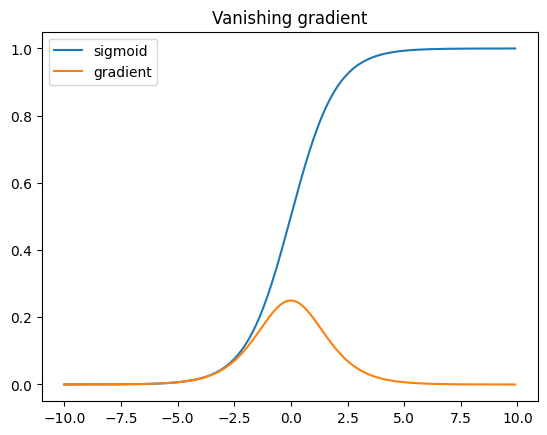

A single matrix 
 tensor([[ 0.5128,  2.6089,  1.8766, -0.5830,  0.2933],
        [-0.7178,  0.3452,  1.2462, -0.5500,  0.4918],
        [ 0.8960,  0.4040,  0.9436, -0.5185, -0.8396],
        [-2.0121,  1.1082, -0.7130, -0.0836, -1.6101],
        [-0.7210, -0.6013,  0.5823, -0.1126, -0.2247]])
After multiplying 100 matrices
 tensor([[ 2.5609e+29,  1.8023e+29,  3.1036e+29, -1.9296e+29,  6.4791e+29],
        [ 2.4762e+29,  1.7427e+29,  3.0009e+29, -1.8657e+29,  6.2647e+29],
        [-2.5044e+28, -1.7626e+28, -3.0351e+28,  1.8870e+28, -6.3362e+28],
        [-1.5903e+29, -1.1192e+29, -1.9273e+29,  1.1982e+29, -4.0234e+29],
        [ 2.4216e+28,  1.7043e+28,  2.9348e+28, -1.8246e+28,  6.1267e+28]])


In [1]:
# Jupyter magic: render matplotlib plots directly in the notebook output cell
%matplotlib inline

import torch
from matplotlib import pyplot as plt

# Create inputs from -10 to 10 in steps of 0.1.
# requires_grad=True tells PyTorch to track operations on x so we can compute dy/dx.
x = torch.arange(-10.0, 10.0, 0.1, requires_grad=True)

# Apply the sigmoid function elementwise: y = 1 / (1 + e^{-x})
y = torch.sigmoid(x)

# Backpropagate to compute gradients of y w.r.t x.
# Since y is a vector, we provide an upstream gradient (ones) so each element contributes equally.
y.backward(gradient=torch.ones_like(x))

# Plot the sigmoid curve (detach to avoid autograd tracking, convert tensors to NumPy for matplotlib)
plt.plot(x.detach().numpy(), y.detach().numpy(), label='sigmoid')

# Plot the gradient dy/dx stored in x.grad.
# This shows gradients are tiny near the tails (x very negative/positive) → "vanishing gradient".
plt.plot(x.detach().numpy(), x.grad.numpy(), label='gradient')

# Add plot decorations
plt.legend()
plt.title("Vanishing gradient")
plt.show()

# Create a 5x5 random matrix with entries sampled from N(0, 1)
A = torch.normal(0, 1, size=(5, 5))
print('A single matrix \n', A)

# Repeatedly multiply A by new random 5x5 matrices (also N(0, 1)).
# This demonstrates how repeated matrix multiplications can cause values to explode or vanish
# due to compounding scaling effects (similar to instability in deep networks / RNNs).
for i in range(100):
    A = torch.mm(A, torch.normal(0, 1, size=(5, 5)))

# Print the final matrix after 100 multiplications
print('After multiplying 100 matrices\n', A)

# Linear lerninag rate for an objective function

epoch 70, x1: 0.020621, x2: -0.171758


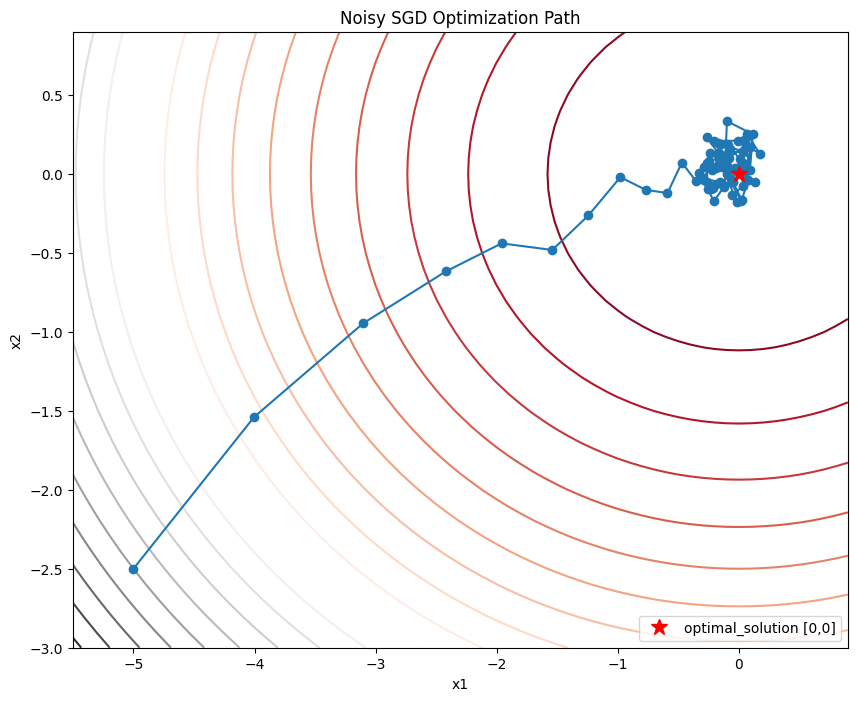

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1234)

# Objective function: convex quadratic bowl
def f(x1, x2):
    return x1**2 + 2*x2**2

# Analytical gradients
def f_grad(x1, x2):
    return 2 * x1, 4 * x2


# Constant learning rate
def constant_lr():
    return 1

# Stochastic Gradient Descent with gradient noise
def sgd(x1, x2, f_grad):
    g1, g2 = f_grad(x1, x2)

    # Add Gaussian noise to simulate stochastic gradients
    g1 = g1 + torch.normal(0.0, 1.0, ())
    g2 = g2 + torch.normal(0.0, 1.0, ())

    eta_t = eta * lr()
    return x1 - eta_t * g1, x2 - eta_t * g2

# Training loop
def train(trainer, f_grad, steps=70):
    # Initialize as tensors (important for consistency)
    x1 = torch.tensor(-5.0)
    x2 = torch.tensor(-2.5)

    results = [(x1.item(), x2.item())]

    for i in range(steps):
        x1, x2 = trainer(x1, x2, f_grad)
        results.append((x1.item(), x2.item()))

    print(f'epoch {i+1}, x1: {x1.item():.6f}, x2: {x2.item():.6f}')
    return results



eta = 0.1
lr = constant_lr

# Run training
results = train(sgd, f_grad)

# Create contour grid
x1_grid, x2_grid = np.meshgrid(
    np.arange(-5.5, 1.0, 0.1),
    np.arange(-3.0, 1.0, 0.1)
)

# Plot
plt.figure(figsize=(10, 8))
plt.contour(x1_grid, x2_grid, f(x1_grid, x2_grid), 20, cmap='RdGy')

# Extract trajectory
xs, ys = zip(*results)
plt.plot(xs, ys, '-o')

# Mark optimum
plt.plot(0.0, 0.0, "r*", markersize=12,
         label="optimal_solution [0,0]")

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc="lower right")
plt.title("Noisy SGD Optimization Path")
plt.show()

# Exponential lerninag rate for an objective function

epoch 2500, x1: -0.646550, x2: -0.046847


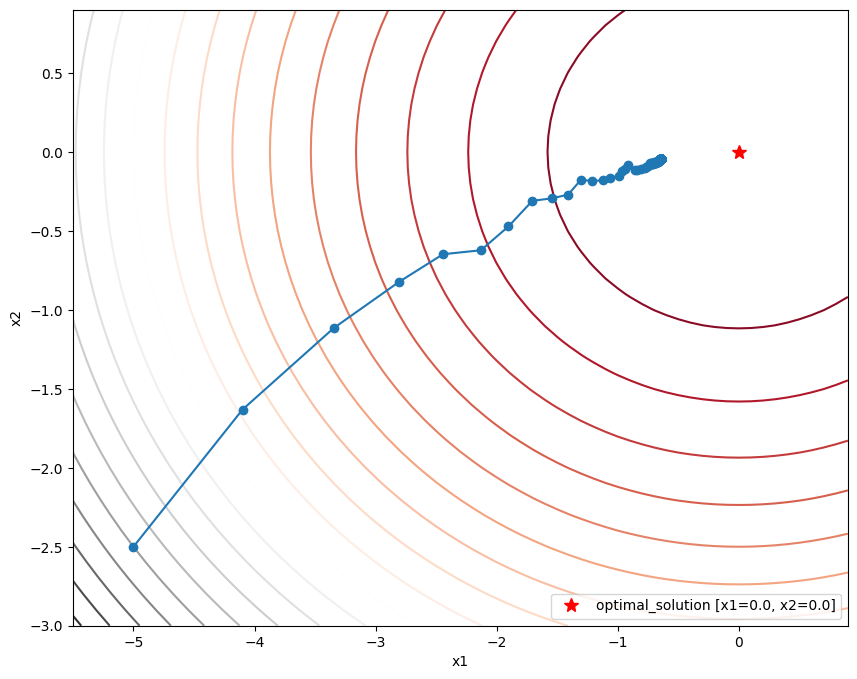

In [10]:
import numpy as np                      # For meshgrid + exp
import torch                            # Tensors + RNG
import matplotlib.pyplot as plt         # Plotting

%matplotlib inline
torch.manual_seed(1234)                 # Reproducible noise


# Objective: convex quadratic bowl with minimum at (0, 0)
def f(x1, x2):
    return x1**2 + 2*x2**2


# Analytical gradients of f
def f_grad(x1, x2):
    return 2 * x1, 4 * x2


# One step of noisy SGD
def sgd(x1, x2, f_grad):
    g1, g2 = f_grad(x1, x2)

    # Add scalar Gaussian noise (shape () keeps everything scalar-like)
    g1 = g1 + torch.normal(0.0, 1.0, ())
    g2 = g2 + torch.normal(0.0, 1.0, ())

    # Decayed learning rate for this iteration
    eta_t = eta * lr()

    # Update
    return x1 - eta_t * g1, x2 - eta_t * g2


# 2D training loop: stores floats for plotting (prevents matplotlib "sequence" error)
def train_2d(trainer, f_grad, steps=50):
    # Start as 0-dim tensors for consistent tensor math
    x1 = torch.tensor(-5.0)
    x2 = torch.tensor(-2.5)

    # Store trajectory as plain Python floats (homogeneous list)
    results = [(x1.item(), x2.item())]

    for i in range(steps):
        x1, x2 = trainer(x1, x2, f_grad)
        results.append((x1.item(), x2.item()))

    print(f'epoch {i + 1}, x1: {x1.item():.6f}, x2: {x2.item():.6f}')
    return results


# Exponentially decaying learning-rate schedule
it = 0
def exponential_lr():
    global it
    it += 1
    return np.exp(-0.1 * it)


eta = 0.1               # Base learning-rate scale
lr = exponential_lr     # Use exponential decay

# Run optimization
results = train_2d(sgd, f_grad=f_grad, steps=2500)


# Contour grid for visualization
x1g, x2g = np.meshgrid(
    np.arange(-5.5, 1.0, 0.1),
    np.arange(-3.0, 1.0, 0.1)
)

# Plot objective contours
fig, ax = plt.subplots(figsize=(10, 8))
ax.contour(x1g, x2g, f(x1g, x2g), 20, cmap='RdGy')

# Plot trajectory (now safe: results is list of float pairs)
xs, ys = zip(*results)
ax.plot(xs, ys, '-o')

# Mark optimum
ax.plot(0.0, 0.0, "r*", markersize=10,
        label="optimal_solution [x1=0.0, x2=0.0]")

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend(loc="lower right")
plt.show()

# Polynomial lerninag rate for an objective function

epoch 25, x1: 0.002161, x2: 0.088646


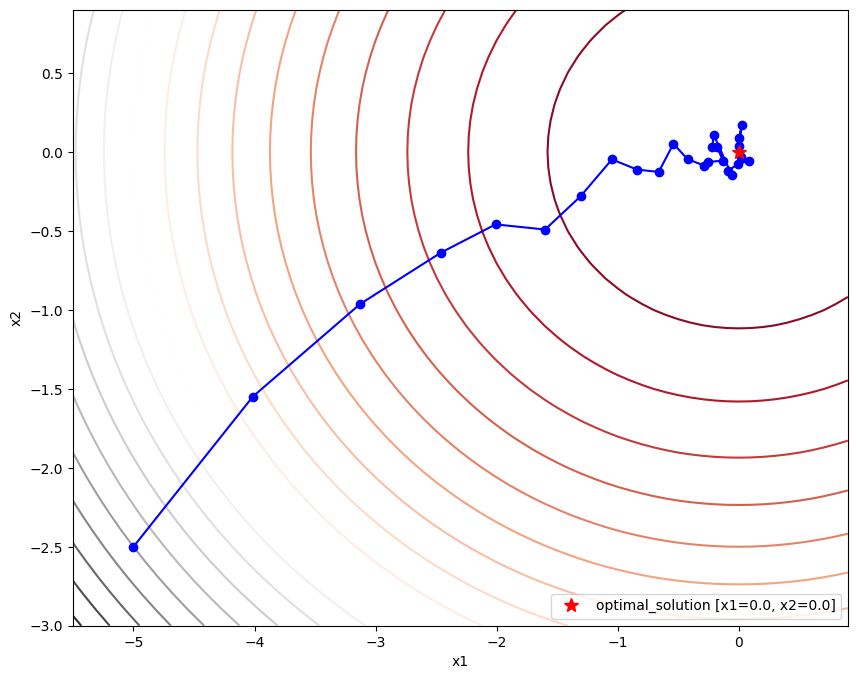

In [14]:
import numpy as np                      # Numerical tools (meshgrid, polynomial LR schedule)
import imageio                          # Image/video I/O (not used in this snippet)
import torch                            # PyTorch tensors + randomness
import torch.nn.functional as F         # NN functional ops (not used here)
import torch.utils.data as Data         # Data utilities (not used here)
from torch.autograd import Variable     # Legacy autograd wrapper (not used here)
import matplotlib.pyplot as plt         # Plotting
from torch.optim import SGD, LBFGS, Adam, RMSprop, SparseAdam  # Optimizers (not used here)
from torch.utils.data import Dataset, DataLoader               # Dataset utilities (not used)

torch.manual_seed(1234)                 # Reproducible noise


# Objective function: convex quadratic bowl with optimum at (0,0)
def f(x1, x2):
    return x1**2 + 2*x2**2


# Analytical gradients of f
def f_grad(x1, x2):
    return 2 * x1, 4 * x2


# One step of noisy SGD
def sgd(x1, x2, f_grad):
    g1, g2 = f_grad(x1, x2)

    # Add *scalar* Gaussian noise (shape () not (1,)) so x1/x2 stay scalar tensors
    g1 = g1 + torch.normal(0.0, 1.0, ())
    g2 = g2 + torch.normal(0.0, 1.0, ())

    # Step size for this iteration (eta scaled by schedule lr())
    eta_t = eta * lr()

    # Gradient descent update
    return (x1 - eta_t * g1, x2 - eta_t * g2)


# Train loop for 2D optimization (stores floats for plotting to avoid "sequence" errors)
def train_2d(trainer, f_grad, steps=50):
    # Start as 0-dim tensors for consistent tensor math
    x1 = torch.tensor(-5.0)
    x2 = torch.tensor(-2.5)

    # Store trajectory as plain floats for homogeneous plotting inputs
    results = [(x1.item(), x2.item())]

    for i in range(steps):
        x1, x2 = trainer(x1, x2, f_grad)
        results.append((x1.item(), x2.item()))

    print(f'epoch {i + 1}, x1: {x1.item():.6f}, x2: {x2.item():.6f}')
    return results


# Polynomial learning rate schedule: (1 + 0.02*t)^(-0.5)
it = 0
def poly_lr():
    global it
    it += 1
    return (1 + 0.02 * it)**(-0.5)


eta = 0.1               # Base learning-rate scale
lr = poly_lr            # Use polynomial decay schedule

# Run optimization
results = train_2d(sgd, f_grad=f_grad, steps=25)


# Build contour grid for objective visualization
x1g, x2g = np.meshgrid(
    np.arange(-5.5, 1.0, 0.1),
    np.arange(-3.0, 1.0, 0.1)
)

# Plot contours + optimization path
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
ax1.contour(x1g, x2g, f(x1g, x2g), 20, cmap='RdGy')

# Safe plotting: results are floats, so zip(*results) is homogeneous
ax1.plot(*zip(*results), '-o', color='blue')

# Mark optimum
ax1.plot(0.0, 0.0, "r*", markersize=10,
         label="optimal_solution [x1=0.0, x2=0.0]")

plt.legend(loc="lower right")
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
plt.show()

# Rate of change of learning rate for different schedulers

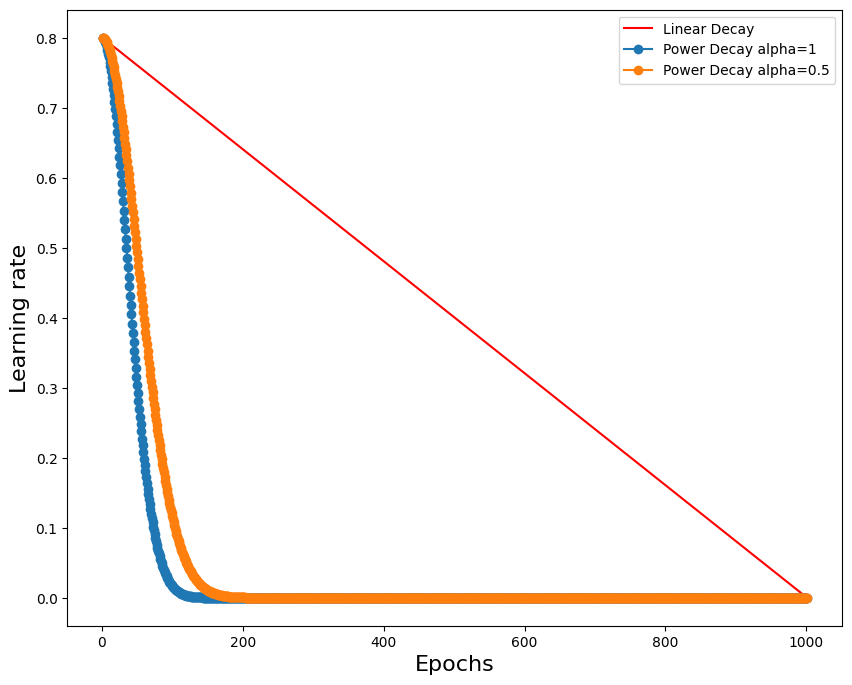

In [15]:
import numpy as np                  # Numerical computing
import matplotlib.pyplot as plt     # Plotting


# Class that implements different learning rate decay schedules
class lr_decay():
    
    # Constructor: initialize total epochs, initial learning rate, and power parameter
    def __init__(self, epochs, initial_lr, power):
        self.epochs = epochs              # Total number of training epochs
        self.initial_lr = initial_lr      # Starting learning rate
        self.power = power                # Power parameter (not directly used here)
        

    # Linear learning rate decay:
    # lr = initial_lr * (1 - epoch / total_epochs)
    # Decreases linearly to 0 as epoch → total_epochs
    def linear_decay(self, epoch):
        decay = (1 - (epoch / float(self.epochs))) 
        eta_updated = self.initial_lr * decay
        return float(eta_updated)
    

    # Power decay schedule:
    # lr_t = lr / (1 + decay * epoch)^alpha
    # Produces slower decay compared to linear depending on alpha
    def power_decay(self, epoch, lr, alpha):
        decay = self.initial_lr / float(self.epochs)
        return float(lr * 1 / (1 + decay * epoch)**alpha)
    

    # Generates full history of power decay values across all epochs
    def power_deacay_hist(self, alpha=1):
        lr = self.initial_lr                  # Start from initial learning rate
        power_decay_list = []                 # Store decay values

        for ep in range(0, self.epochs + 1):
            lr = self.power_decay(ep, lr, alpha)
            power_decay_list.append(lr)

        return power_decay_list
        

# ---------------------------------------
# Create learning rate schedules
# ---------------------------------------

initial_lr = 0.8
epochs = 1000
power = 1

# Instantiate scheduler
lr_sch = lr_decay(epochs, initial_lr, power)

# Compute linear decay for each epoch
lr_linear = np.array([lr_sch.linear_decay(ep) 
                      for ep in range(0, epochs + 1)])

# Compute power decay history for alpha = 1
lr_power_alpha_1 = lr_sch.power_deacay_hist(alpha=1)

# Compute power decay history for alpha = 0.5 (slower decay)
lr_power_alpha_2 = lr_sch.power_deacay_hist(alpha=0.5)


# ---------------------------------------
# Plot learning rate schedules
# ---------------------------------------

ep_plot = np.arange(1, epochs + 2, 1)   # Epoch indices for plotting

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot linear decay
ax.plot(ep_plot, lr_linear, "-r", label="Linear Decay")

# Plot power decay (alpha = 1)
ax.plot(ep_plot, lr_power_alpha_1, "-o", label="Power Decay alpha=1")

# Plot power decay (alpha = 0.5)
ax.plot(ep_plot, lr_power_alpha_2, "-o", label="Power Decay alpha=0.5")

# Axis labels
ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Learning rate', fontsize=16)

# Show legend
ax.legend()

plt.show()

# Constant learning rate scheduler for DNN with function approxiamtion


SGD Optimization (constant LR)
Epoch: 01/30000 Loss: 6.23648e+00
Epoch: 5001/30000 Loss: 5.23612e-01
Epoch: 10001/30000 Loss: 4.76653e-01
Epoch: 15001/30000 Loss: 4.29664e-01
Epoch: 20001/30000 Loss: 5.31863e-01
Epoch: 25001/30000 Loss: 4.62871e-01


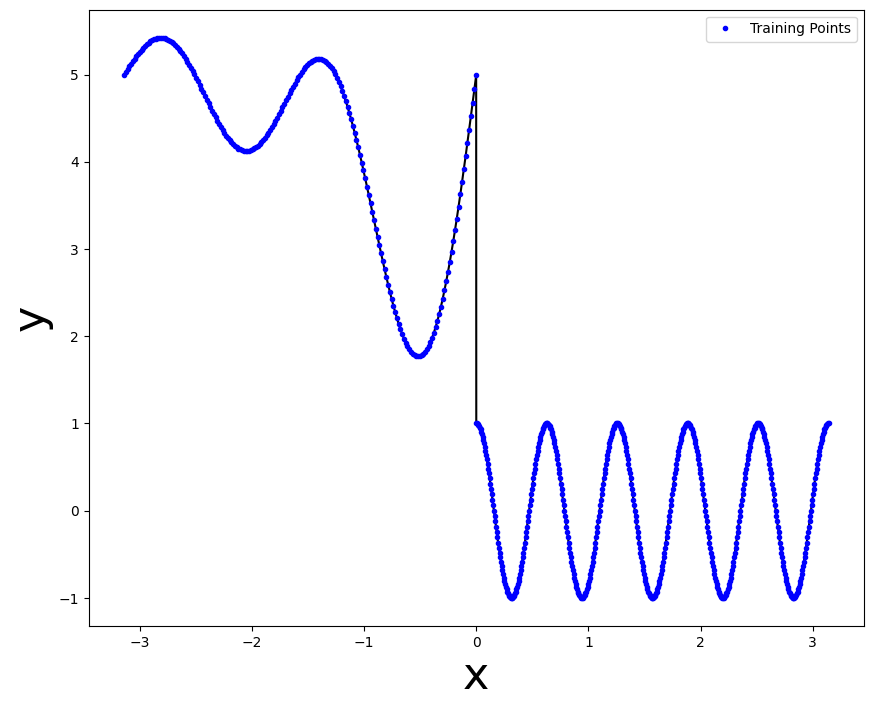

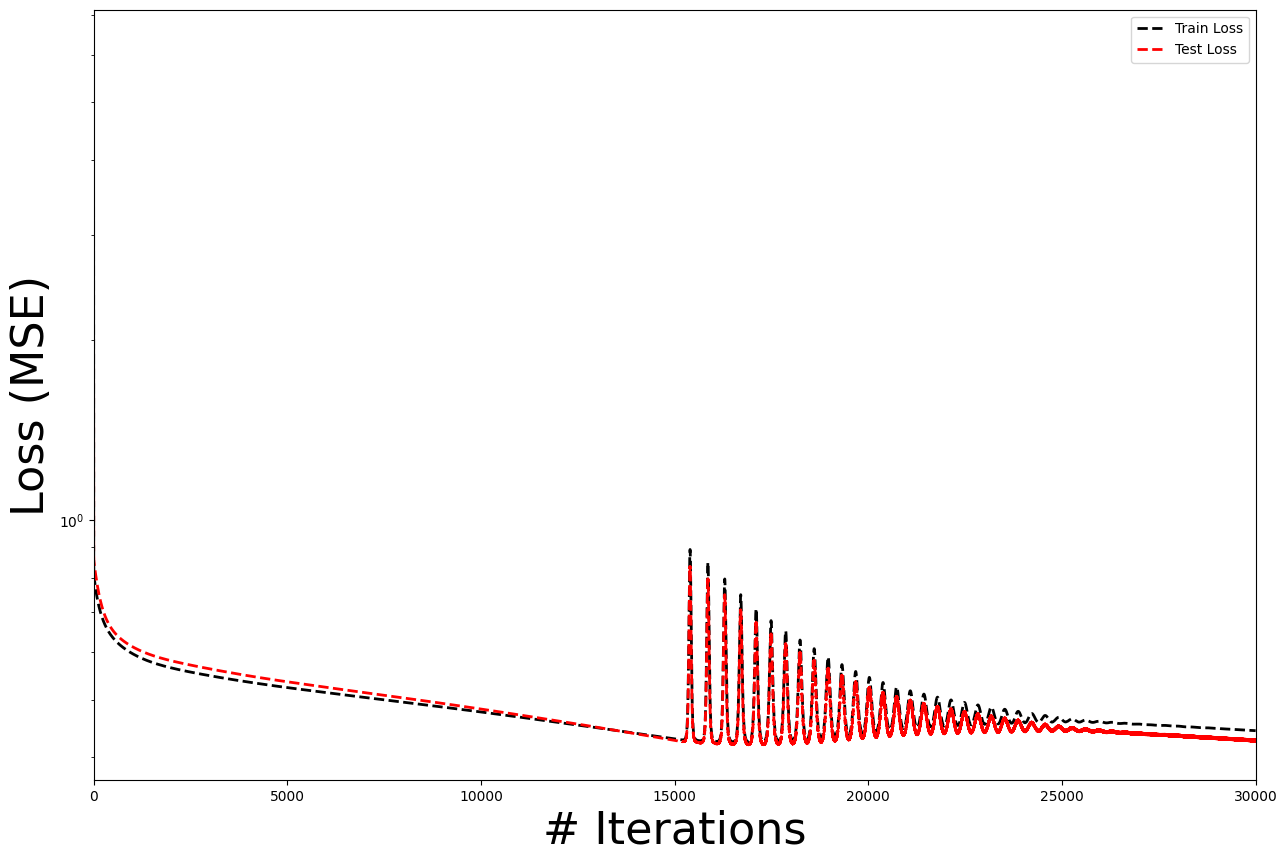

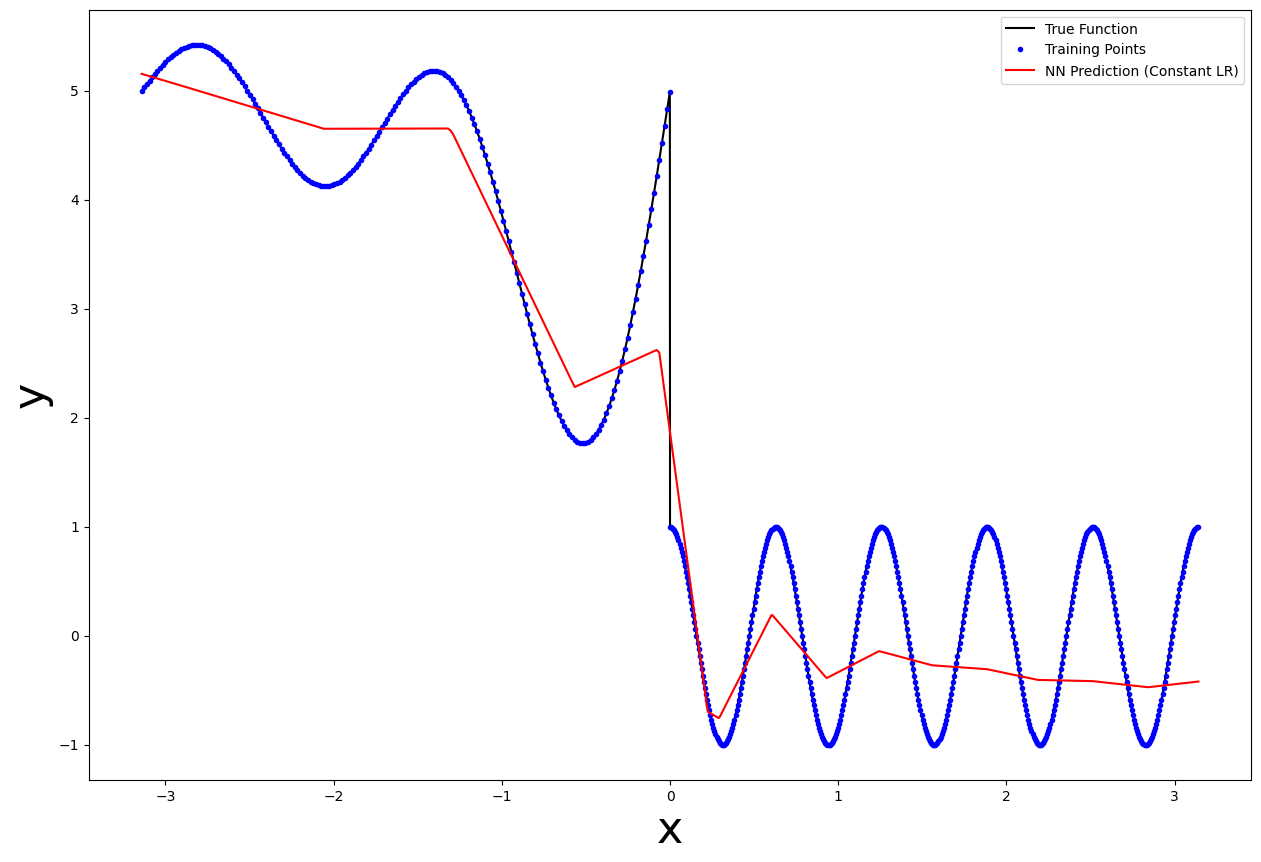

Epoch: 1359/30000 Loss: 5.81973e-01
Epoch: 1360/30000 Loss: 5.81939e-01
Epoch: 1361/30000 Loss: 5.81904e-01
Epoch: 1362/30000 Loss: 5.81870e-01
Epoch: 1363/30000 Loss: 5.81836e-01
Epoch: 1364/30000 Loss: 5.81801e-01
Epoch: 1365/30000 Loss: 5.81767e-01
Epoch: 1366/30000 Loss: 5.81733e-01
Epoch: 1367/30000 Loss: 5.81699e-01
Epoch: 1368/30000 Loss: 5.81664e-01
Epoch: 1369/30000 Loss: 5.81630e-01
Epoch: 1370/30000 Loss: 5.81596e-01
Epoch: 1371/30000 Loss: 5.81562e-01
Epoch: 1372/30000 Loss: 5.81528e-01
Epoch: 1373/30000 Loss: 5.81494e-01
Epoch: 1374/30000 Loss: 5.81460e-01
Epoch: 1375/30000 Loss: 5.81426e-01
Epoch: 1376/30000 Loss: 5.81392e-01
Epoch: 1377/30000 Loss: 5.81358e-01
Epoch: 1378/30000 Loss: 5.81324e-01
Epoch: 1379/30000 Loss: 5.81290e-01
Epoch: 1380/30000 Loss: 5.81256e-01
Epoch: 1381/30000 Loss: 5.81222e-01
Epoch: 1382/30000 Loss: 5.81188e-01
Epoch: 1383/30000 Loss: 5.81155e-01
Epoch: 1384/30000 Loss: 5.81121e-01
Epoch: 1385/30000 Loss: 5.81087e-01
Epoch: 1386/30000 Loss: 5.81

Epoch: 1700/30000 Loss: 5.71879e-01
Epoch: 1701/30000 Loss: 5.71854e-01
Epoch: 1702/30000 Loss: 5.71828e-01
Epoch: 1703/30000 Loss: 5.71803e-01
Epoch: 1704/30000 Loss: 5.71778e-01
Epoch: 1705/30000 Loss: 5.71753e-01
Epoch: 1706/30000 Loss: 5.71728e-01
Epoch: 1707/30000 Loss: 5.71703e-01
Epoch: 1708/30000 Loss: 5.71678e-01
Epoch: 1709/30000 Loss: 5.71653e-01
Epoch: 1710/30000 Loss: 5.71628e-01
Epoch: 1711/30000 Loss: 5.71603e-01
Epoch: 1712/30000 Loss: 5.71578e-01
Epoch: 1713/30000 Loss: 5.71553e-01
Epoch: 1714/30000 Loss: 5.71528e-01
Epoch: 1715/30000 Loss: 5.71503e-01
Epoch: 1716/30000 Loss: 5.71478e-01
Epoch: 1717/30000 Loss: 5.71453e-01
Epoch: 1718/30000 Loss: 5.71428e-01
Epoch: 1719/30000 Loss: 5.71403e-01
Epoch: 1720/30000 Loss: 5.71378e-01
Epoch: 1721/30000 Loss: 5.71353e-01
Epoch: 1722/30000 Loss: 5.71328e-01
Epoch: 1723/30000 Loss: 5.71303e-01
Epoch: 1724/30000 Loss: 5.71278e-01
Epoch: 1725/30000 Loss: 5.71253e-01
Epoch: 1726/30000 Loss: 5.71228e-01
Epoch: 1727/30000 Loss: 5.71

Epoch: 2046/30000 Loss: 5.64123e-01
Epoch: 2047/30000 Loss: 5.64103e-01
Epoch: 2048/30000 Loss: 5.64083e-01
Epoch: 2049/30000 Loss: 5.64063e-01
Epoch: 2050/30000 Loss: 5.64042e-01
Epoch: 2051/30000 Loss: 5.64022e-01
Epoch: 2052/30000 Loss: 5.64002e-01
Epoch: 2053/30000 Loss: 5.63982e-01
Epoch: 2054/30000 Loss: 5.63962e-01
Epoch: 2055/30000 Loss: 5.63942e-01
Epoch: 2056/30000 Loss: 5.63922e-01
Epoch: 2057/30000 Loss: 5.63902e-01
Epoch: 2058/30000 Loss: 5.63883e-01
Epoch: 2059/30000 Loss: 5.63863e-01
Epoch: 2060/30000 Loss: 5.63843e-01
Epoch: 2061/30000 Loss: 5.63823e-01
Epoch: 2062/30000 Loss: 5.63803e-01
Epoch: 2063/30000 Loss: 5.63783e-01
Epoch: 2064/30000 Loss: 5.63763e-01
Epoch: 2065/30000 Loss: 5.63743e-01
Epoch: 2066/30000 Loss: 5.63723e-01
Epoch: 2067/30000 Loss: 5.63704e-01
Epoch: 2068/30000 Loss: 5.63684e-01
Epoch: 2069/30000 Loss: 5.63664e-01
Epoch: 2070/30000 Loss: 5.63644e-01
Epoch: 2071/30000 Loss: 5.63624e-01
Epoch: 2072/30000 Loss: 5.63605e-01
Epoch: 2073/30000 Loss: 5.63

Epoch: 2388/30000 Loss: 5.57813e-01
Epoch: 2389/30000 Loss: 5.57796e-01
Epoch: 2390/30000 Loss: 5.57779e-01
Epoch: 2391/30000 Loss: 5.57762e-01
Epoch: 2392/30000 Loss: 5.57745e-01
Epoch: 2393/30000 Loss: 5.57727e-01
Epoch: 2394/30000 Loss: 5.57710e-01
Epoch: 2395/30000 Loss: 5.57693e-01
Epoch: 2396/30000 Loss: 5.57676e-01
Epoch: 2397/30000 Loss: 5.57659e-01
Epoch: 2398/30000 Loss: 5.57642e-01
Epoch: 2399/30000 Loss: 5.57625e-01
Epoch: 2400/30000 Loss: 5.57607e-01
Epoch: 2401/30000 Loss: 5.57590e-01
Epoch: 2402/30000 Loss: 5.57573e-01
Epoch: 2403/30000 Loss: 5.57556e-01
Epoch: 2404/30000 Loss: 5.57539e-01
Epoch: 2405/30000 Loss: 5.57522e-01
Epoch: 2406/30000 Loss: 5.57505e-01
Epoch: 2407/30000 Loss: 5.57488e-01
Epoch: 2408/30000 Loss: 5.57471e-01
Epoch: 2409/30000 Loss: 5.57454e-01
Epoch: 2410/30000 Loss: 5.57437e-01
Epoch: 2411/30000 Loss: 5.57420e-01
Epoch: 2412/30000 Loss: 5.57403e-01
Epoch: 2413/30000 Loss: 5.57386e-01
Epoch: 2414/30000 Loss: 5.57369e-01
Epoch: 2415/30000 Loss: 5.57

Epoch: 2734/30000 Loss: 5.52182e-01
Epoch: 2735/30000 Loss: 5.52166e-01
Epoch: 2736/30000 Loss: 5.52151e-01
Epoch: 2737/30000 Loss: 5.52135e-01
Epoch: 2738/30000 Loss: 5.52120e-01
Epoch: 2739/30000 Loss: 5.52104e-01
Epoch: 2740/30000 Loss: 5.52089e-01
Epoch: 2741/30000 Loss: 5.52073e-01
Epoch: 2742/30000 Loss: 5.52058e-01
Epoch: 2743/30000 Loss: 5.52042e-01
Epoch: 2744/30000 Loss: 5.52027e-01
Epoch: 2745/30000 Loss: 5.52012e-01
Epoch: 2746/30000 Loss: 5.51996e-01
Epoch: 2747/30000 Loss: 5.51981e-01
Epoch: 2748/30000 Loss: 5.51966e-01
Epoch: 2749/30000 Loss: 5.51950e-01
Epoch: 2750/30000 Loss: 5.51935e-01
Epoch: 2751/30000 Loss: 5.51919e-01
Epoch: 2752/30000 Loss: 5.51904e-01
Epoch: 2753/30000 Loss: 5.51889e-01
Epoch: 2754/30000 Loss: 5.51874e-01
Epoch: 2755/30000 Loss: 5.51858e-01
Epoch: 2756/30000 Loss: 5.51843e-01
Epoch: 2757/30000 Loss: 5.51827e-01
Epoch: 2758/30000 Loss: 5.51812e-01
Epoch: 2759/30000 Loss: 5.51797e-01
Epoch: 2760/30000 Loss: 5.51781e-01
Epoch: 2761/30000 Loss: 5.51

Epoch: 3072/30000 Loss: 5.47126e-01
Epoch: 3073/30000 Loss: 5.47111e-01
Epoch: 3074/30000 Loss: 5.47097e-01
Epoch: 3075/30000 Loss: 5.47083e-01
Epoch: 3076/30000 Loss: 5.47068e-01
Epoch: 3077/30000 Loss: 5.47054e-01
Epoch: 3078/30000 Loss: 5.47039e-01
Epoch: 3079/30000 Loss: 5.47025e-01
Epoch: 3080/30000 Loss: 5.47011e-01
Epoch: 3081/30000 Loss: 5.46996e-01
Epoch: 3082/30000 Loss: 5.46982e-01
Epoch: 3083/30000 Loss: 5.46968e-01
Epoch: 3084/30000 Loss: 5.46953e-01
Epoch: 3085/30000 Loss: 5.46939e-01
Epoch: 3086/30000 Loss: 5.46925e-01
Epoch: 3087/30000 Loss: 5.46910e-01
Epoch: 3088/30000 Loss: 5.46896e-01
Epoch: 3089/30000 Loss: 5.46882e-01
Epoch: 3090/30000 Loss: 5.46867e-01
Epoch: 3091/30000 Loss: 5.46853e-01
Epoch: 3092/30000 Loss: 5.46839e-01
Epoch: 3093/30000 Loss: 5.46825e-01
Epoch: 3094/30000 Loss: 5.46810e-01
Epoch: 3095/30000 Loss: 5.46796e-01
Epoch: 3096/30000 Loss: 5.46782e-01
Epoch: 3097/30000 Loss: 5.46767e-01
Epoch: 3098/30000 Loss: 5.46753e-01
Epoch: 3099/30000 Loss: 5.46

Epoch: 3436/30000 Loss: 5.42048e-01
Epoch: 3437/30000 Loss: 5.42035e-01
Epoch: 3438/30000 Loss: 5.42021e-01
Epoch: 3439/30000 Loss: 5.42008e-01
Epoch: 3440/30000 Loss: 5.41994e-01
Epoch: 3441/30000 Loss: 5.41981e-01
Epoch: 3442/30000 Loss: 5.41968e-01
Epoch: 3443/30000 Loss: 5.41954e-01
Epoch: 3444/30000 Loss: 5.41941e-01
Epoch: 3445/30000 Loss: 5.41927e-01
Epoch: 3446/30000 Loss: 5.41914e-01
Epoch: 3447/30000 Loss: 5.41901e-01
Epoch: 3448/30000 Loss: 5.41887e-01
Epoch: 3449/30000 Loss: 5.41874e-01
Epoch: 3450/30000 Loss: 5.41861e-01
Epoch: 3451/30000 Loss: 5.41847e-01
Epoch: 3452/30000 Loss: 5.41834e-01
Epoch: 3453/30000 Loss: 5.41821e-01
Epoch: 3454/30000 Loss: 5.41807e-01
Epoch: 3455/30000 Loss: 5.41794e-01
Epoch: 3456/30000 Loss: 5.41781e-01
Epoch: 3457/30000 Loss: 5.41767e-01
Epoch: 3458/30000 Loss: 5.41754e-01
Epoch: 3459/30000 Loss: 5.41740e-01
Epoch: 3460/30000 Loss: 5.41727e-01
Epoch: 3461/30000 Loss: 5.41714e-01
Epoch: 3462/30000 Loss: 5.41700e-01
Epoch: 3463/30000 Loss: 5.41

Epoch: 3795/30000 Loss: 5.37388e-01
Epoch: 3796/30000 Loss: 5.37375e-01
Epoch: 3797/30000 Loss: 5.37363e-01
Epoch: 3798/30000 Loss: 5.37350e-01
Epoch: 3799/30000 Loss: 5.37338e-01
Epoch: 3800/30000 Loss: 5.37325e-01
Epoch: 3801/30000 Loss: 5.37313e-01
Epoch: 3802/30000 Loss: 5.37300e-01
Epoch: 3803/30000 Loss: 5.37288e-01
Epoch: 3804/30000 Loss: 5.37275e-01
Epoch: 3805/30000 Loss: 5.37263e-01
Epoch: 3806/30000 Loss: 5.37250e-01
Epoch: 3807/30000 Loss: 5.37238e-01
Epoch: 3808/30000 Loss: 5.37225e-01
Epoch: 3809/30000 Loss: 5.37213e-01
Epoch: 3810/30000 Loss: 5.37200e-01
Epoch: 3811/30000 Loss: 5.37188e-01
Epoch: 3812/30000 Loss: 5.37175e-01
Epoch: 3813/30000 Loss: 5.37163e-01
Epoch: 3814/30000 Loss: 5.37150e-01
Epoch: 3815/30000 Loss: 5.37138e-01
Epoch: 3816/30000 Loss: 5.37125e-01
Epoch: 3817/30000 Loss: 5.37113e-01
Epoch: 3818/30000 Loss: 5.37100e-01
Epoch: 3819/30000 Loss: 5.37088e-01
Epoch: 3820/30000 Loss: 5.37075e-01
Epoch: 3821/30000 Loss: 5.37063e-01
Epoch: 3822/30000 Loss: 5.37

Epoch: 4128/30000 Loss: 5.33318e-01
Epoch: 4129/30000 Loss: 5.33306e-01
Epoch: 4130/30000 Loss: 5.33294e-01
Epoch: 4131/30000 Loss: 5.33283e-01
Epoch: 4132/30000 Loss: 5.33271e-01
Epoch: 4133/30000 Loss: 5.33259e-01
Epoch: 4134/30000 Loss: 5.33247e-01
Epoch: 4135/30000 Loss: 5.33235e-01
Epoch: 4136/30000 Loss: 5.33223e-01
Epoch: 4137/30000 Loss: 5.33211e-01
Epoch: 4138/30000 Loss: 5.33199e-01
Epoch: 4139/30000 Loss: 5.33187e-01
Epoch: 4140/30000 Loss: 5.33175e-01
Epoch: 4141/30000 Loss: 5.33163e-01
Epoch: 4142/30000 Loss: 5.33151e-01
Epoch: 4143/30000 Loss: 5.33139e-01
Epoch: 4144/30000 Loss: 5.33128e-01
Epoch: 4145/30000 Loss: 5.33116e-01
Epoch: 4146/30000 Loss: 5.33104e-01
Epoch: 4147/30000 Loss: 5.33092e-01
Epoch: 4148/30000 Loss: 5.33080e-01
Epoch: 4149/30000 Loss: 5.33068e-01
Epoch: 4150/30000 Loss: 5.33056e-01
Epoch: 4151/30000 Loss: 5.33044e-01
Epoch: 4152/30000 Loss: 5.33032e-01
Epoch: 4153/30000 Loss: 5.33020e-01
Epoch: 4154/30000 Loss: 5.33008e-01
Epoch: 4155/30000 Loss: 5.32

Epoch: 4468/30000 Loss: 5.29381e-01
Epoch: 4469/30000 Loss: 5.29370e-01
Epoch: 4470/30000 Loss: 5.29358e-01
Epoch: 4471/30000 Loss: 5.29347e-01
Epoch: 4472/30000 Loss: 5.29336e-01
Epoch: 4473/30000 Loss: 5.29324e-01
Epoch: 4474/30000 Loss: 5.29313e-01
Epoch: 4475/30000 Loss: 5.29302e-01
Epoch: 4476/30000 Loss: 5.29290e-01
Epoch: 4477/30000 Loss: 5.29279e-01
Epoch: 4478/30000 Loss: 5.29268e-01
Epoch: 4479/30000 Loss: 5.29256e-01
Epoch: 4480/30000 Loss: 5.29245e-01
Epoch: 4481/30000 Loss: 5.29234e-01
Epoch: 4482/30000 Loss: 5.29222e-01
Epoch: 4483/30000 Loss: 5.29211e-01
Epoch: 4484/30000 Loss: 5.29200e-01
Epoch: 4485/30000 Loss: 5.29189e-01
Epoch: 4486/30000 Loss: 5.29177e-01
Epoch: 4487/30000 Loss: 5.29166e-01
Epoch: 4488/30000 Loss: 5.29155e-01
Epoch: 4489/30000 Loss: 5.29144e-01
Epoch: 4490/30000 Loss: 5.29132e-01
Epoch: 4491/30000 Loss: 5.29121e-01
Epoch: 4492/30000 Loss: 5.29110e-01
Epoch: 4493/30000 Loss: 5.29098e-01
Epoch: 4494/30000 Loss: 5.29087e-01
Epoch: 4495/30000 Loss: 5.29

Epoch: 4804/30000 Loss: 5.25693e-01
Epoch: 4805/30000 Loss: 5.25683e-01
Epoch: 4806/30000 Loss: 5.25672e-01
Epoch: 4807/30000 Loss: 5.25661e-01
Epoch: 4808/30000 Loss: 5.25651e-01
Epoch: 4809/30000 Loss: 5.25640e-01
Epoch: 4810/30000 Loss: 5.25629e-01
Epoch: 4811/30000 Loss: 5.25619e-01
Epoch: 4812/30000 Loss: 5.25608e-01
Epoch: 4813/30000 Loss: 5.25598e-01
Epoch: 4814/30000 Loss: 5.25587e-01
Epoch: 4815/30000 Loss: 5.25576e-01
Epoch: 4816/30000 Loss: 5.25566e-01
Epoch: 4817/30000 Loss: 5.25555e-01
Epoch: 4818/30000 Loss: 5.25544e-01
Epoch: 4819/30000 Loss: 5.25534e-01
Epoch: 4820/30000 Loss: 5.25523e-01
Epoch: 4821/30000 Loss: 5.25513e-01
Epoch: 4822/30000 Loss: 5.25502e-01
Epoch: 4823/30000 Loss: 5.25491e-01
Epoch: 4824/30000 Loss: 5.25481e-01
Epoch: 4825/30000 Loss: 5.25470e-01
Epoch: 4826/30000 Loss: 5.25460e-01
Epoch: 4827/30000 Loss: 5.25449e-01
Epoch: 4828/30000 Loss: 5.25438e-01
Epoch: 4829/30000 Loss: 5.25428e-01
Epoch: 4830/30000 Loss: 5.25417e-01
Epoch: 4831/30000 Loss: 5.25

Epoch: 5142/30000 Loss: 5.22152e-01
Epoch: 5143/30000 Loss: 5.22141e-01
Epoch: 5144/30000 Loss: 5.22131e-01
Epoch: 5145/30000 Loss: 5.22121e-01
Epoch: 5146/30000 Loss: 5.22111e-01
Epoch: 5147/30000 Loss: 5.22101e-01
Epoch: 5148/30000 Loss: 5.22090e-01
Epoch: 5149/30000 Loss: 5.22080e-01
Epoch: 5150/30000 Loss: 5.22070e-01
Epoch: 5151/30000 Loss: 5.22060e-01
Epoch: 5152/30000 Loss: 5.22049e-01
Epoch: 5153/30000 Loss: 5.22039e-01
Epoch: 5154/30000 Loss: 5.22029e-01
Epoch: 5155/30000 Loss: 5.22019e-01
Epoch: 5156/30000 Loss: 5.22009e-01
Epoch: 5157/30000 Loss: 5.21998e-01
Epoch: 5158/30000 Loss: 5.21988e-01
Epoch: 5159/30000 Loss: 5.21978e-01
Epoch: 5160/30000 Loss: 5.21968e-01
Epoch: 5161/30000 Loss: 5.21958e-01
Epoch: 5162/30000 Loss: 5.21947e-01
Epoch: 5163/30000 Loss: 5.21937e-01
Epoch: 5164/30000 Loss: 5.21927e-01
Epoch: 5165/30000 Loss: 5.21917e-01
Epoch: 5166/30000 Loss: 5.21906e-01
Epoch: 5167/30000 Loss: 5.21896e-01
Epoch: 5168/30000 Loss: 5.21886e-01
Epoch: 5169/30000 Loss: 5.21

Epoch: 5486/30000 Loss: 5.18677e-01
Epoch: 5487/30000 Loss: 5.18667e-01
Epoch: 5488/30000 Loss: 5.18657e-01
Epoch: 5489/30000 Loss: 5.18647e-01
Epoch: 5490/30000 Loss: 5.18637e-01
Epoch: 5491/30000 Loss: 5.18627e-01
Epoch: 5492/30000 Loss: 5.18617e-01
Epoch: 5493/30000 Loss: 5.18607e-01
Epoch: 5494/30000 Loss: 5.18597e-01
Epoch: 5495/30000 Loss: 5.18587e-01
Epoch: 5496/30000 Loss: 5.18577e-01
Epoch: 5497/30000 Loss: 5.18567e-01
Epoch: 5498/30000 Loss: 5.18557e-01
Epoch: 5499/30000 Loss: 5.18547e-01
Epoch: 5500/30000 Loss: 5.18537e-01
Epoch: 5501/30000 Loss: 5.18527e-01
Epoch: 5502/30000 Loss: 5.18517e-01
Epoch: 5503/30000 Loss: 5.18507e-01
Epoch: 5504/30000 Loss: 5.18497e-01
Epoch: 5505/30000 Loss: 5.18487e-01
Epoch: 5506/30000 Loss: 5.18477e-01
Epoch: 5507/30000 Loss: 5.18467e-01
Epoch: 5508/30000 Loss: 5.18457e-01
Epoch: 5509/30000 Loss: 5.18447e-01
Epoch: 5510/30000 Loss: 5.18437e-01
Epoch: 5511/30000 Loss: 5.18427e-01
Epoch: 5512/30000 Loss: 5.18417e-01
Epoch: 5513/30000 Loss: 5.18

Epoch: 5831/30000 Loss: 5.15278e-01
Epoch: 5832/30000 Loss: 5.15268e-01
Epoch: 5833/30000 Loss: 5.15258e-01
Epoch: 5834/30000 Loss: 5.15249e-01
Epoch: 5835/30000 Loss: 5.15239e-01
Epoch: 5836/30000 Loss: 5.15229e-01
Epoch: 5837/30000 Loss: 5.15220e-01
Epoch: 5838/30000 Loss: 5.15210e-01
Epoch: 5839/30000 Loss: 5.15200e-01
Epoch: 5840/30000 Loss: 5.15190e-01
Epoch: 5841/30000 Loss: 5.15181e-01
Epoch: 5842/30000 Loss: 5.15171e-01
Epoch: 5843/30000 Loss: 5.15161e-01
Epoch: 5844/30000 Loss: 5.15152e-01
Epoch: 5845/30000 Loss: 5.15142e-01
Epoch: 5846/30000 Loss: 5.15132e-01
Epoch: 5847/30000 Loss: 5.15122e-01
Epoch: 5848/30000 Loss: 5.15113e-01
Epoch: 5849/30000 Loss: 5.15103e-01
Epoch: 5850/30000 Loss: 5.15093e-01
Epoch: 5851/30000 Loss: 5.15084e-01
Epoch: 5852/30000 Loss: 5.15074e-01
Epoch: 5853/30000 Loss: 5.15064e-01
Epoch: 5854/30000 Loss: 5.15055e-01
Epoch: 5855/30000 Loss: 5.15045e-01
Epoch: 5856/30000 Loss: 5.15035e-01
Epoch: 5857/30000 Loss: 5.15025e-01
Epoch: 5858/30000 Loss: 5.15

Epoch: 6175/30000 Loss: 5.11952e-01
Epoch: 6176/30000 Loss: 5.11943e-01
Epoch: 6177/30000 Loss: 5.11933e-01
Epoch: 6178/30000 Loss: 5.11924e-01
Epoch: 6179/30000 Loss: 5.11914e-01
Epoch: 6180/30000 Loss: 5.11904e-01
Epoch: 6181/30000 Loss: 5.11895e-01
Epoch: 6182/30000 Loss: 5.11885e-01
Epoch: 6183/30000 Loss: 5.11875e-01
Epoch: 6184/30000 Loss: 5.11866e-01
Epoch: 6185/30000 Loss: 5.11856e-01
Epoch: 6186/30000 Loss: 5.11846e-01
Epoch: 6187/30000 Loss: 5.11837e-01
Epoch: 6188/30000 Loss: 5.11827e-01
Epoch: 6189/30000 Loss: 5.11818e-01
Epoch: 6190/30000 Loss: 5.11808e-01
Epoch: 6191/30000 Loss: 5.11798e-01
Epoch: 6192/30000 Loss: 5.11789e-01
Epoch: 6193/30000 Loss: 5.11779e-01
Epoch: 6194/30000 Loss: 5.11769e-01
Epoch: 6195/30000 Loss: 5.11760e-01
Epoch: 6196/30000 Loss: 5.11750e-01
Epoch: 6197/30000 Loss: 5.11741e-01
Epoch: 6198/30000 Loss: 5.11731e-01
Epoch: 6199/30000 Loss: 5.11721e-01
Epoch: 6200/30000 Loss: 5.11712e-01
Epoch: 6201/30000 Loss: 5.11702e-01
Epoch: 6202/30000 Loss: 5.11

Epoch: 6523/30000 Loss: 5.08609e-01
Epoch: 6524/30000 Loss: 5.08599e-01
Epoch: 6525/30000 Loss: 5.08590e-01
Epoch: 6526/30000 Loss: 5.08580e-01
Epoch: 6527/30000 Loss: 5.08571e-01
Epoch: 6528/30000 Loss: 5.08561e-01
Epoch: 6529/30000 Loss: 5.08551e-01
Epoch: 6530/30000 Loss: 5.08542e-01
Epoch: 6531/30000 Loss: 5.08532e-01
Epoch: 6532/30000 Loss: 5.08523e-01
Epoch: 6533/30000 Loss: 5.08513e-01
Epoch: 6534/30000 Loss: 5.08504e-01
Epoch: 6535/30000 Loss: 5.08494e-01
Epoch: 6536/30000 Loss: 5.08484e-01
Epoch: 6537/30000 Loss: 5.08475e-01
Epoch: 6538/30000 Loss: 5.08465e-01
Epoch: 6539/30000 Loss: 5.08456e-01
Epoch: 6540/30000 Loss: 5.08446e-01
Epoch: 6541/30000 Loss: 5.08436e-01
Epoch: 6542/30000 Loss: 5.08427e-01
Epoch: 6543/30000 Loss: 5.08417e-01
Epoch: 6544/30000 Loss: 5.08408e-01
Epoch: 6545/30000 Loss: 5.08398e-01
Epoch: 6546/30000 Loss: 5.08389e-01
Epoch: 6547/30000 Loss: 5.08379e-01
Epoch: 6548/30000 Loss: 5.08370e-01
Epoch: 6549/30000 Loss: 5.08360e-01
Epoch: 6550/30000 Loss: 5.08

Epoch: 6865/30000 Loss: 5.05372e-01
Epoch: 6866/30000 Loss: 5.05362e-01
Epoch: 6867/30000 Loss: 5.05353e-01
Epoch: 6868/30000 Loss: 5.05344e-01
Epoch: 6869/30000 Loss: 5.05334e-01
Epoch: 6870/30000 Loss: 5.05325e-01
Epoch: 6871/30000 Loss: 5.05316e-01
Epoch: 6872/30000 Loss: 5.05306e-01
Epoch: 6873/30000 Loss: 5.05297e-01
Epoch: 6874/30000 Loss: 5.05287e-01
Epoch: 6875/30000 Loss: 5.05278e-01
Epoch: 6876/30000 Loss: 5.05269e-01
Epoch: 6877/30000 Loss: 5.05259e-01
Epoch: 6878/30000 Loss: 5.05250e-01
Epoch: 6879/30000 Loss: 5.05240e-01
Epoch: 6880/30000 Loss: 5.05231e-01
Epoch: 6881/30000 Loss: 5.05222e-01
Epoch: 6882/30000 Loss: 5.05212e-01
Epoch: 6883/30000 Loss: 5.05203e-01
Epoch: 6884/30000 Loss: 5.05193e-01
Epoch: 6885/30000 Loss: 5.05184e-01
Epoch: 6886/30000 Loss: 5.05175e-01
Epoch: 6887/30000 Loss: 5.05165e-01
Epoch: 6888/30000 Loss: 5.05156e-01
Epoch: 6889/30000 Loss: 5.05146e-01
Epoch: 6890/30000 Loss: 5.05137e-01
Epoch: 6891/30000 Loss: 5.05128e-01
Epoch: 6892/30000 Loss: 5.05

Epoch: 7197/30000 Loss: 5.02265e-01
Epoch: 7198/30000 Loss: 5.02255e-01
Epoch: 7199/30000 Loss: 5.02246e-01
Epoch: 7200/30000 Loss: 5.02237e-01
Epoch: 7201/30000 Loss: 5.02228e-01
Epoch: 7202/30000 Loss: 5.02218e-01
Epoch: 7203/30000 Loss: 5.02209e-01
Epoch: 7204/30000 Loss: 5.02200e-01
Epoch: 7205/30000 Loss: 5.02191e-01
Epoch: 7206/30000 Loss: 5.02181e-01
Epoch: 7207/30000 Loss: 5.02172e-01
Epoch: 7208/30000 Loss: 5.02163e-01
Epoch: 7209/30000 Loss: 5.02154e-01
Epoch: 7210/30000 Loss: 5.02144e-01
Epoch: 7211/30000 Loss: 5.02135e-01
Epoch: 7212/30000 Loss: 5.02126e-01
Epoch: 7213/30000 Loss: 5.02116e-01
Epoch: 7214/30000 Loss: 5.02107e-01
Epoch: 7215/30000 Loss: 5.02098e-01
Epoch: 7216/30000 Loss: 5.02088e-01
Epoch: 7217/30000 Loss: 5.02079e-01
Epoch: 7218/30000 Loss: 5.02070e-01
Epoch: 7219/30000 Loss: 5.02061e-01
Epoch: 7220/30000 Loss: 5.02051e-01
Epoch: 7221/30000 Loss: 5.02042e-01
Epoch: 7222/30000 Loss: 5.02033e-01
Epoch: 7223/30000 Loss: 5.02024e-01
Epoch: 7224/30000 Loss: 5.02

Epoch: 7538/30000 Loss: 4.99120e-01
Epoch: 7539/30000 Loss: 4.99111e-01
Epoch: 7540/30000 Loss: 4.99102e-01
Epoch: 7541/30000 Loss: 4.99093e-01
Epoch: 7542/30000 Loss: 4.99084e-01
Epoch: 7543/30000 Loss: 4.99074e-01
Epoch: 7544/30000 Loss: 4.99065e-01
Epoch: 7545/30000 Loss: 4.99056e-01
Epoch: 7546/30000 Loss: 4.99047e-01
Epoch: 7547/30000 Loss: 4.99038e-01
Epoch: 7548/30000 Loss: 4.99029e-01
Epoch: 7549/30000 Loss: 4.99019e-01
Epoch: 7550/30000 Loss: 4.99010e-01
Epoch: 7551/30000 Loss: 4.99001e-01
Epoch: 7552/30000 Loss: 4.98992e-01
Epoch: 7553/30000 Loss: 4.98983e-01
Epoch: 7554/30000 Loss: 4.98974e-01
Epoch: 7555/30000 Loss: 4.98965e-01
Epoch: 7556/30000 Loss: 4.98955e-01
Epoch: 7557/30000 Loss: 4.98946e-01
Epoch: 7558/30000 Loss: 4.98937e-01
Epoch: 7559/30000 Loss: 4.98928e-01
Epoch: 7560/30000 Loss: 4.98919e-01
Epoch: 7561/30000 Loss: 4.98910e-01
Epoch: 7562/30000 Loss: 4.98900e-01
Epoch: 7563/30000 Loss: 4.98891e-01
Epoch: 7564/30000 Loss: 4.98882e-01
Epoch: 7565/30000 Loss: 4.98

Epoch: 7875/30000 Loss: 4.96053e-01
Epoch: 7876/30000 Loss: 4.96044e-01
Epoch: 7877/30000 Loss: 4.96035e-01
Epoch: 7878/30000 Loss: 4.96026e-01
Epoch: 7879/30000 Loss: 4.96017e-01
Epoch: 7880/30000 Loss: 4.96008e-01
Epoch: 7881/30000 Loss: 4.95999e-01
Epoch: 7882/30000 Loss: 4.95990e-01
Epoch: 7883/30000 Loss: 4.95981e-01
Epoch: 7884/30000 Loss: 4.95972e-01
Epoch: 7885/30000 Loss: 4.95963e-01
Epoch: 7886/30000 Loss: 4.95954e-01
Epoch: 7887/30000 Loss: 4.95945e-01
Epoch: 7888/30000 Loss: 4.95936e-01
Epoch: 7889/30000 Loss: 4.95927e-01
Epoch: 7890/30000 Loss: 4.95918e-01
Epoch: 7891/30000 Loss: 4.95909e-01
Epoch: 7892/30000 Loss: 4.95900e-01
Epoch: 7893/30000 Loss: 4.95891e-01
Epoch: 7894/30000 Loss: 4.95882e-01
Epoch: 7895/30000 Loss: 4.95873e-01
Epoch: 7896/30000 Loss: 4.95864e-01
Epoch: 7897/30000 Loss: 4.95855e-01
Epoch: 7898/30000 Loss: 4.95846e-01
Epoch: 7899/30000 Loss: 4.95837e-01
Epoch: 7900/30000 Loss: 4.95828e-01
Epoch: 7901/30000 Loss: 4.95819e-01
Epoch: 7902/30000 Loss: 4.95

Epoch: 8206/30000 Loss: 4.93068e-01
Epoch: 8207/30000 Loss: 4.93059e-01
Epoch: 8208/30000 Loss: 4.93050e-01
Epoch: 8209/30000 Loss: 4.93041e-01
Epoch: 8210/30000 Loss: 4.93032e-01
Epoch: 8211/30000 Loss: 4.93023e-01
Epoch: 8212/30000 Loss: 4.93014e-01
Epoch: 8213/30000 Loss: 4.93005e-01
Epoch: 8214/30000 Loss: 4.92996e-01
Epoch: 8215/30000 Loss: 4.92987e-01
Epoch: 8216/30000 Loss: 4.92978e-01
Epoch: 8217/30000 Loss: 4.92969e-01
Epoch: 8218/30000 Loss: 4.92960e-01
Epoch: 8219/30000 Loss: 4.92951e-01
Epoch: 8220/30000 Loss: 4.92942e-01
Epoch: 8221/30000 Loss: 4.92933e-01
Epoch: 8222/30000 Loss: 4.92924e-01
Epoch: 8223/30000 Loss: 4.92915e-01
Epoch: 8224/30000 Loss: 4.92906e-01
Epoch: 8225/30000 Loss: 4.92897e-01
Epoch: 8226/30000 Loss: 4.92888e-01
Epoch: 8227/30000 Loss: 4.92879e-01
Epoch: 8228/30000 Loss: 4.92870e-01
Epoch: 8229/30000 Loss: 4.92861e-01
Epoch: 8230/30000 Loss: 4.92852e-01
Epoch: 8231/30000 Loss: 4.92843e-01
Epoch: 8232/30000 Loss: 4.92834e-01
Epoch: 8233/30000 Loss: 4.92

Epoch: 8541/30000 Loss: 4.90050e-01
Epoch: 8542/30000 Loss: 4.90042e-01
Epoch: 8543/30000 Loss: 4.90032e-01
Epoch: 8544/30000 Loss: 4.90023e-01
Epoch: 8545/30000 Loss: 4.90015e-01
Epoch: 8546/30000 Loss: 4.90006e-01
Epoch: 8547/30000 Loss: 4.89996e-01
Epoch: 8548/30000 Loss: 4.89988e-01
Epoch: 8549/30000 Loss: 4.89979e-01
Epoch: 8550/30000 Loss: 4.89969e-01
Epoch: 8551/30000 Loss: 4.89961e-01
Epoch: 8552/30000 Loss: 4.89951e-01
Epoch: 8553/30000 Loss: 4.89942e-01
Epoch: 8554/30000 Loss: 4.89934e-01
Epoch: 8555/30000 Loss: 4.89924e-01
Epoch: 8556/30000 Loss: 4.89916e-01
Epoch: 8557/30000 Loss: 4.89907e-01
Epoch: 8558/30000 Loss: 4.89898e-01
Epoch: 8559/30000 Loss: 4.89889e-01
Epoch: 8560/30000 Loss: 4.89880e-01
Epoch: 8561/30000 Loss: 4.89871e-01
Epoch: 8562/30000 Loss: 4.89862e-01
Epoch: 8563/30000 Loss: 4.89853e-01
Epoch: 8564/30000 Loss: 4.89844e-01
Epoch: 8565/30000 Loss: 4.89835e-01
Epoch: 8566/30000 Loss: 4.89826e-01
Epoch: 8567/30000 Loss: 4.89817e-01
Epoch: 8568/30000 Loss: 4.89

Epoch: 8874/30000 Loss: 4.87045e-01
Epoch: 8875/30000 Loss: 4.87036e-01
Epoch: 8876/30000 Loss: 4.87026e-01
Epoch: 8877/30000 Loss: 4.87017e-01
Epoch: 8878/30000 Loss: 4.87008e-01
Epoch: 8879/30000 Loss: 4.86999e-01
Epoch: 8880/30000 Loss: 4.86990e-01
Epoch: 8881/30000 Loss: 4.86981e-01
Epoch: 8882/30000 Loss: 4.86972e-01
Epoch: 8883/30000 Loss: 4.86963e-01
Epoch: 8884/30000 Loss: 4.86954e-01
Epoch: 8885/30000 Loss: 4.86944e-01
Epoch: 8886/30000 Loss: 4.86935e-01
Epoch: 8887/30000 Loss: 4.86926e-01
Epoch: 8888/30000 Loss: 4.86917e-01
Epoch: 8889/30000 Loss: 4.86908e-01
Epoch: 8890/30000 Loss: 4.86899e-01
Epoch: 8891/30000 Loss: 4.86890e-01
Epoch: 8892/30000 Loss: 4.86881e-01
Epoch: 8893/30000 Loss: 4.86872e-01
Epoch: 8894/30000 Loss: 4.86863e-01
Epoch: 8895/30000 Loss: 4.86854e-01
Epoch: 8896/30000 Loss: 4.86844e-01
Epoch: 8897/30000 Loss: 4.86835e-01
Epoch: 8898/30000 Loss: 4.86826e-01
Epoch: 8899/30000 Loss: 4.86817e-01
Epoch: 8900/30000 Loss: 4.86808e-01
Epoch: 8901/30000 Loss: 4.86

Epoch: 9211/30000 Loss: 4.83969e-01
Epoch: 9212/30000 Loss: 4.83960e-01
Epoch: 9213/30000 Loss: 4.83950e-01
Epoch: 9214/30000 Loss: 4.83941e-01
Epoch: 9215/30000 Loss: 4.83932e-01
Epoch: 9216/30000 Loss: 4.83923e-01
Epoch: 9217/30000 Loss: 4.83914e-01
Epoch: 9218/30000 Loss: 4.83905e-01
Epoch: 9219/30000 Loss: 4.83896e-01
Epoch: 9220/30000 Loss: 4.83886e-01
Epoch: 9221/30000 Loss: 4.83877e-01
Epoch: 9222/30000 Loss: 4.83868e-01
Epoch: 9223/30000 Loss: 4.83859e-01
Epoch: 9224/30000 Loss: 4.83850e-01
Epoch: 9225/30000 Loss: 4.83841e-01
Epoch: 9226/30000 Loss: 4.83831e-01
Epoch: 9227/30000 Loss: 4.83822e-01
Epoch: 9228/30000 Loss: 4.83813e-01
Epoch: 9229/30000 Loss: 4.83804e-01
Epoch: 9230/30000 Loss: 4.83795e-01
Epoch: 9231/30000 Loss: 4.83786e-01
Epoch: 9232/30000 Loss: 4.83776e-01
Epoch: 9233/30000 Loss: 4.83767e-01
Epoch: 9234/30000 Loss: 4.83758e-01
Epoch: 9235/30000 Loss: 4.83749e-01
Epoch: 9236/30000 Loss: 4.83740e-01
Epoch: 9237/30000 Loss: 4.83731e-01
Epoch: 9238/30000 Loss: 4.83

Epoch: 9543/30000 Loss: 4.80914e-01
Epoch: 9544/30000 Loss: 4.80905e-01
Epoch: 9545/30000 Loss: 4.80896e-01
Epoch: 9546/30000 Loss: 4.80887e-01
Epoch: 9547/30000 Loss: 4.80877e-01
Epoch: 9548/30000 Loss: 4.80868e-01
Epoch: 9549/30000 Loss: 4.80859e-01
Epoch: 9550/30000 Loss: 4.80850e-01
Epoch: 9551/30000 Loss: 4.80841e-01
Epoch: 9552/30000 Loss: 4.80831e-01
Epoch: 9553/30000 Loss: 4.80822e-01
Epoch: 9554/30000 Loss: 4.80813e-01
Epoch: 9555/30000 Loss: 4.80804e-01
Epoch: 9556/30000 Loss: 4.80794e-01
Epoch: 9557/30000 Loss: 4.80785e-01
Epoch: 9558/30000 Loss: 4.80776e-01
Epoch: 9559/30000 Loss: 4.80767e-01
Epoch: 9560/30000 Loss: 4.80757e-01
Epoch: 9561/30000 Loss: 4.80748e-01
Epoch: 9562/30000 Loss: 4.80739e-01
Epoch: 9563/30000 Loss: 4.80730e-01
Epoch: 9564/30000 Loss: 4.80720e-01
Epoch: 9565/30000 Loss: 4.80711e-01
Epoch: 9566/30000 Loss: 4.80702e-01
Epoch: 9567/30000 Loss: 4.80693e-01
Epoch: 9568/30000 Loss: 4.80683e-01
Epoch: 9569/30000 Loss: 4.80674e-01
Epoch: 9570/30000 Loss: 4.80

Epoch: 9881/30000 Loss: 4.77775e-01
Epoch: 9882/30000 Loss: 4.77765e-01
Epoch: 9883/30000 Loss: 4.77756e-01
Epoch: 9884/30000 Loss: 4.77747e-01
Epoch: 9885/30000 Loss: 4.77737e-01
Epoch: 9886/30000 Loss: 4.77728e-01
Epoch: 9887/30000 Loss: 4.77719e-01
Epoch: 9888/30000 Loss: 4.77709e-01
Epoch: 9889/30000 Loss: 4.77700e-01
Epoch: 9890/30000 Loss: 4.77691e-01
Epoch: 9891/30000 Loss: 4.77681e-01
Epoch: 9892/30000 Loss: 4.77672e-01
Epoch: 9893/30000 Loss: 4.77663e-01
Epoch: 9894/30000 Loss: 4.77654e-01
Epoch: 9895/30000 Loss: 4.77644e-01
Epoch: 9896/30000 Loss: 4.77635e-01
Epoch: 9897/30000 Loss: 4.77626e-01
Epoch: 9898/30000 Loss: 4.77616e-01
Epoch: 9899/30000 Loss: 4.77607e-01
Epoch: 9900/30000 Loss: 4.77598e-01
Epoch: 9901/30000 Loss: 4.77588e-01
Epoch: 9902/30000 Loss: 4.77579e-01
Epoch: 9903/30000 Loss: 4.77570e-01
Epoch: 9904/30000 Loss: 4.77560e-01
Epoch: 9905/30000 Loss: 4.77551e-01
Epoch: 9906/30000 Loss: 4.77542e-01
Epoch: 9907/30000 Loss: 4.77532e-01
Epoch: 9908/30000 Loss: 4.77

Epoch: 10232/30000 Loss: 4.74491e-01
Epoch: 10233/30000 Loss: 4.74482e-01
Epoch: 10234/30000 Loss: 4.74473e-01
Epoch: 10235/30000 Loss: 4.74463e-01
Epoch: 10236/30000 Loss: 4.74454e-01
Epoch: 10237/30000 Loss: 4.74445e-01
Epoch: 10238/30000 Loss: 4.74435e-01
Epoch: 10239/30000 Loss: 4.74426e-01
Epoch: 10240/30000 Loss: 4.74416e-01
Epoch: 10241/30000 Loss: 4.74407e-01
Epoch: 10242/30000 Loss: 4.74398e-01
Epoch: 10243/30000 Loss: 4.74388e-01
Epoch: 10244/30000 Loss: 4.74379e-01
Epoch: 10245/30000 Loss: 4.74369e-01
Epoch: 10246/30000 Loss: 4.74360e-01
Epoch: 10247/30000 Loss: 4.74351e-01
Epoch: 10248/30000 Loss: 4.74341e-01
Epoch: 10249/30000 Loss: 4.74332e-01
Epoch: 10250/30000 Loss: 4.74323e-01
Epoch: 10251/30000 Loss: 4.74313e-01
Epoch: 10252/30000 Loss: 4.74304e-01
Epoch: 10253/30000 Loss: 4.74295e-01
Epoch: 10254/30000 Loss: 4.74285e-01
Epoch: 10255/30000 Loss: 4.74276e-01
Epoch: 10256/30000 Loss: 4.74266e-01
Epoch: 10257/30000 Loss: 4.74257e-01
Epoch: 10258/30000 Loss: 4.74248e-01
E

Epoch: 10575/30000 Loss: 4.71274e-01
Epoch: 10576/30000 Loss: 4.71264e-01
Epoch: 10577/30000 Loss: 4.71255e-01
Epoch: 10578/30000 Loss: 4.71245e-01
Epoch: 10579/30000 Loss: 4.71236e-01
Epoch: 10580/30000 Loss: 4.71227e-01
Epoch: 10581/30000 Loss: 4.71217e-01
Epoch: 10582/30000 Loss: 4.71208e-01
Epoch: 10583/30000 Loss: 4.71198e-01
Epoch: 10584/30000 Loss: 4.71189e-01
Epoch: 10585/30000 Loss: 4.71179e-01
Epoch: 10586/30000 Loss: 4.71170e-01
Epoch: 10587/30000 Loss: 4.71161e-01
Epoch: 10588/30000 Loss: 4.71151e-01
Epoch: 10589/30000 Loss: 4.71142e-01
Epoch: 10590/30000 Loss: 4.71132e-01
Epoch: 10591/30000 Loss: 4.71123e-01
Epoch: 10592/30000 Loss: 4.71114e-01
Epoch: 10593/30000 Loss: 4.71104e-01
Epoch: 10594/30000 Loss: 4.71095e-01
Epoch: 10595/30000 Loss: 4.71085e-01
Epoch: 10596/30000 Loss: 4.71076e-01
Epoch: 10597/30000 Loss: 4.71067e-01
Epoch: 10598/30000 Loss: 4.71057e-01
Epoch: 10599/30000 Loss: 4.71048e-01
Epoch: 10600/30000 Loss: 4.71038e-01
Epoch: 10601/30000 Loss: 4.71029e-01
E

Epoch: 10896/30000 Loss: 4.68260e-01
Epoch: 10897/30000 Loss: 4.68250e-01
Epoch: 10898/30000 Loss: 4.68241e-01
Epoch: 10899/30000 Loss: 4.68232e-01
Epoch: 10900/30000 Loss: 4.68222e-01
Epoch: 10901/30000 Loss: 4.68213e-01
Epoch: 10902/30000 Loss: 4.68203e-01
Epoch: 10903/30000 Loss: 4.68194e-01
Epoch: 10904/30000 Loss: 4.68185e-01
Epoch: 10905/30000 Loss: 4.68175e-01
Epoch: 10906/30000 Loss: 4.68166e-01
Epoch: 10907/30000 Loss: 4.68157e-01
Epoch: 10908/30000 Loss: 4.68147e-01
Epoch: 10909/30000 Loss: 4.68138e-01
Epoch: 10910/30000 Loss: 4.68128e-01
Epoch: 10911/30000 Loss: 4.68119e-01
Epoch: 10912/30000 Loss: 4.68110e-01
Epoch: 10913/30000 Loss: 4.68100e-01
Epoch: 10914/30000 Loss: 4.68091e-01
Epoch: 10915/30000 Loss: 4.68081e-01
Epoch: 10916/30000 Loss: 4.68072e-01
Epoch: 10917/30000 Loss: 4.68063e-01
Epoch: 10918/30000 Loss: 4.68053e-01
Epoch: 10919/30000 Loss: 4.68044e-01
Epoch: 10920/30000 Loss: 4.68034e-01
Epoch: 10921/30000 Loss: 4.68025e-01
Epoch: 10922/30000 Loss: 4.68016e-01
E

Epoch: 11249/30000 Loss: 4.64947e-01
Epoch: 11250/30000 Loss: 4.64938e-01
Epoch: 11251/30000 Loss: 4.64929e-01
Epoch: 11252/30000 Loss: 4.64919e-01
Epoch: 11253/30000 Loss: 4.64910e-01
Epoch: 11254/30000 Loss: 4.64900e-01
Epoch: 11255/30000 Loss: 4.64891e-01
Epoch: 11256/30000 Loss: 4.64882e-01
Epoch: 11257/30000 Loss: 4.64872e-01
Epoch: 11258/30000 Loss: 4.64863e-01
Epoch: 11259/30000 Loss: 4.64853e-01
Epoch: 11260/30000 Loss: 4.64844e-01
Epoch: 11261/30000 Loss: 4.64835e-01
Epoch: 11262/30000 Loss: 4.64825e-01
Epoch: 11263/30000 Loss: 4.64816e-01
Epoch: 11264/30000 Loss: 4.64806e-01
Epoch: 11265/30000 Loss: 4.64797e-01
Epoch: 11266/30000 Loss: 4.64788e-01
Epoch: 11267/30000 Loss: 4.64778e-01
Epoch: 11268/30000 Loss: 4.64769e-01
Epoch: 11269/30000 Loss: 4.64759e-01
Epoch: 11270/30000 Loss: 4.64750e-01
Epoch: 11271/30000 Loss: 4.64741e-01
Epoch: 11272/30000 Loss: 4.64731e-01
Epoch: 11273/30000 Loss: 4.64722e-01
Epoch: 11274/30000 Loss: 4.64712e-01
Epoch: 11275/30000 Loss: 4.64703e-01
E

Epoch: 11620/30000 Loss: 4.61467e-01
Epoch: 11621/30000 Loss: 4.61458e-01
Epoch: 11622/30000 Loss: 4.61448e-01
Epoch: 11623/30000 Loss: 4.61439e-01
Epoch: 11624/30000 Loss: 4.61429e-01
Epoch: 11625/30000 Loss: 4.61420e-01
Epoch: 11626/30000 Loss: 4.61411e-01
Epoch: 11627/30000 Loss: 4.61401e-01
Epoch: 11628/30000 Loss: 4.61392e-01
Epoch: 11629/30000 Loss: 4.61383e-01
Epoch: 11630/30000 Loss: 4.61373e-01
Epoch: 11631/30000 Loss: 4.61364e-01
Epoch: 11632/30000 Loss: 4.61354e-01
Epoch: 11633/30000 Loss: 4.61345e-01
Epoch: 11634/30000 Loss: 4.61335e-01
Epoch: 11635/30000 Loss: 4.61326e-01
Epoch: 11636/30000 Loss: 4.61317e-01
Epoch: 11637/30000 Loss: 4.61307e-01
Epoch: 11638/30000 Loss: 4.61298e-01
Epoch: 11639/30000 Loss: 4.61289e-01
Epoch: 11640/30000 Loss: 4.61279e-01
Epoch: 11641/30000 Loss: 4.61270e-01
Epoch: 11642/30000 Loss: 4.61260e-01
Epoch: 11643/30000 Loss: 4.61251e-01
Epoch: 11644/30000 Loss: 4.61242e-01
Epoch: 11645/30000 Loss: 4.61232e-01
Epoch: 11646/30000 Loss: 4.61223e-01
E

Epoch: 11962/30000 Loss: 4.58259e-01
Epoch: 11963/30000 Loss: 4.58250e-01
Epoch: 11964/30000 Loss: 4.58240e-01
Epoch: 11965/30000 Loss: 4.58231e-01
Epoch: 11966/30000 Loss: 4.58222e-01
Epoch: 11967/30000 Loss: 4.58212e-01
Epoch: 11968/30000 Loss: 4.58203e-01
Epoch: 11969/30000 Loss: 4.58193e-01
Epoch: 11970/30000 Loss: 4.58184e-01
Epoch: 11971/30000 Loss: 4.58175e-01
Epoch: 11972/30000 Loss: 4.58165e-01
Epoch: 11973/30000 Loss: 4.58156e-01
Epoch: 11974/30000 Loss: 4.58147e-01
Epoch: 11975/30000 Loss: 4.58137e-01
Epoch: 11976/30000 Loss: 4.58128e-01
Epoch: 11977/30000 Loss: 4.58118e-01
Epoch: 11978/30000 Loss: 4.58109e-01
Epoch: 11979/30000 Loss: 4.58100e-01
Epoch: 11980/30000 Loss: 4.58090e-01
Epoch: 11981/30000 Loss: 4.58081e-01
Epoch: 11982/30000 Loss: 4.58072e-01
Epoch: 11983/30000 Loss: 4.58062e-01
Epoch: 11984/30000 Loss: 4.58053e-01
Epoch: 11985/30000 Loss: 4.58044e-01
Epoch: 11986/30000 Loss: 4.58034e-01
Epoch: 11987/30000 Loss: 4.58025e-01
Epoch: 11988/30000 Loss: 4.58016e-01
E

Epoch: 12316/30000 Loss: 4.54936e-01
Epoch: 12317/30000 Loss: 4.54926e-01
Epoch: 12318/30000 Loss: 4.54917e-01
Epoch: 12319/30000 Loss: 4.54907e-01
Epoch: 12320/30000 Loss: 4.54898e-01
Epoch: 12321/30000 Loss: 4.54889e-01
Epoch: 12322/30000 Loss: 4.54879e-01
Epoch: 12323/30000 Loss: 4.54870e-01
Epoch: 12324/30000 Loss: 4.54861e-01
Epoch: 12325/30000 Loss: 4.54851e-01
Epoch: 12326/30000 Loss: 4.54842e-01
Epoch: 12327/30000 Loss: 4.54832e-01
Epoch: 12328/30000 Loss: 4.54823e-01
Epoch: 12329/30000 Loss: 4.54814e-01
Epoch: 12330/30000 Loss: 4.54804e-01
Epoch: 12331/30000 Loss: 4.54795e-01
Epoch: 12332/30000 Loss: 4.54785e-01
Epoch: 12333/30000 Loss: 4.54776e-01
Epoch: 12334/30000 Loss: 4.54767e-01
Epoch: 12335/30000 Loss: 4.54757e-01
Epoch: 12336/30000 Loss: 4.54748e-01
Epoch: 12337/30000 Loss: 4.54738e-01
Epoch: 12338/30000 Loss: 4.54729e-01
Epoch: 12339/30000 Loss: 4.54720e-01
Epoch: 12340/30000 Loss: 4.54710e-01
Epoch: 12341/30000 Loss: 4.54701e-01
Epoch: 12342/30000 Loss: 4.54692e-01
E

Epoch: 12678/30000 Loss: 4.51536e-01
Epoch: 12679/30000 Loss: 4.51527e-01
Epoch: 12680/30000 Loss: 4.51517e-01
Epoch: 12681/30000 Loss: 4.51508e-01
Epoch: 12682/30000 Loss: 4.51498e-01
Epoch: 12683/30000 Loss: 4.51489e-01
Epoch: 12684/30000 Loss: 4.51480e-01
Epoch: 12685/30000 Loss: 4.51470e-01
Epoch: 12686/30000 Loss: 4.51461e-01
Epoch: 12687/30000 Loss: 4.51451e-01
Epoch: 12688/30000 Loss: 4.51442e-01
Epoch: 12689/30000 Loss: 4.51433e-01
Epoch: 12690/30000 Loss: 4.51423e-01
Epoch: 12691/30000 Loss: 4.51414e-01
Epoch: 12692/30000 Loss: 4.51404e-01
Epoch: 12693/30000 Loss: 4.51395e-01
Epoch: 12694/30000 Loss: 4.51386e-01
Epoch: 12695/30000 Loss: 4.51376e-01
Epoch: 12696/30000 Loss: 4.51367e-01
Epoch: 12697/30000 Loss: 4.51357e-01
Epoch: 12698/30000 Loss: 4.51348e-01
Epoch: 12699/30000 Loss: 4.51339e-01
Epoch: 12700/30000 Loss: 4.51329e-01
Epoch: 12701/30000 Loss: 4.51320e-01
Epoch: 12702/30000 Loss: 4.51310e-01
Epoch: 12703/30000 Loss: 4.51301e-01
Epoch: 12704/30000 Loss: 4.51291e-01
E

Epoch: 13041/30000 Loss: 4.48119e-01
Epoch: 13042/30000 Loss: 4.48109e-01
Epoch: 13043/30000 Loss: 4.48100e-01
Epoch: 13044/30000 Loss: 4.48090e-01
Epoch: 13045/30000 Loss: 4.48081e-01
Epoch: 13046/30000 Loss: 4.48072e-01
Epoch: 13047/30000 Loss: 4.48062e-01
Epoch: 13048/30000 Loss: 4.48053e-01
Epoch: 13049/30000 Loss: 4.48043e-01
Epoch: 13050/30000 Loss: 4.48034e-01
Epoch: 13051/30000 Loss: 4.48025e-01
Epoch: 13052/30000 Loss: 4.48015e-01
Epoch: 13053/30000 Loss: 4.48006e-01
Epoch: 13054/30000 Loss: 4.47996e-01
Epoch: 13055/30000 Loss: 4.47987e-01
Epoch: 13056/30000 Loss: 4.47977e-01
Epoch: 13057/30000 Loss: 4.47968e-01
Epoch: 13058/30000 Loss: 4.47959e-01
Epoch: 13059/30000 Loss: 4.47949e-01
Epoch: 13060/30000 Loss: 4.47940e-01
Epoch: 13061/30000 Loss: 4.47930e-01
Epoch: 13062/30000 Loss: 4.47921e-01
Epoch: 13063/30000 Loss: 4.47911e-01
Epoch: 13064/30000 Loss: 4.47902e-01
Epoch: 13065/30000 Loss: 4.47893e-01
Epoch: 13066/30000 Loss: 4.47883e-01
Epoch: 13067/30000 Loss: 4.47874e-01
E

Epoch: 13395/30000 Loss: 4.44785e-01
Epoch: 13396/30000 Loss: 4.44776e-01
Epoch: 13397/30000 Loss: 4.44766e-01
Epoch: 13398/30000 Loss: 4.44757e-01
Epoch: 13399/30000 Loss: 4.44747e-01
Epoch: 13400/30000 Loss: 4.44738e-01
Epoch: 13401/30000 Loss: 4.44728e-01
Epoch: 13402/30000 Loss: 4.44719e-01
Epoch: 13403/30000 Loss: 4.44710e-01
Epoch: 13404/30000 Loss: 4.44700e-01
Epoch: 13405/30000 Loss: 4.44691e-01
Epoch: 13406/30000 Loss: 4.44681e-01
Epoch: 13407/30000 Loss: 4.44672e-01
Epoch: 13408/30000 Loss: 4.44663e-01
Epoch: 13409/30000 Loss: 4.44653e-01
Epoch: 13410/30000 Loss: 4.44644e-01
Epoch: 13411/30000 Loss: 4.44634e-01
Epoch: 13412/30000 Loss: 4.44625e-01
Epoch: 13413/30000 Loss: 4.44616e-01
Epoch: 13414/30000 Loss: 4.44606e-01
Epoch: 13415/30000 Loss: 4.44597e-01
Epoch: 13416/30000 Loss: 4.44587e-01
Epoch: 13417/30000 Loss: 4.44578e-01
Epoch: 13418/30000 Loss: 4.44568e-01
Epoch: 13419/30000 Loss: 4.44559e-01
Epoch: 13420/30000 Loss: 4.44550e-01
Epoch: 13421/30000 Loss: 4.44540e-01
E

Epoch: 13730/30000 Loss: 4.41631e-01
Epoch: 13731/30000 Loss: 4.41621e-01
Epoch: 13732/30000 Loss: 4.41612e-01
Epoch: 13733/30000 Loss: 4.41602e-01
Epoch: 13734/30000 Loss: 4.41593e-01
Epoch: 13735/30000 Loss: 4.41583e-01
Epoch: 13736/30000 Loss: 4.41574e-01
Epoch: 13737/30000 Loss: 4.41565e-01
Epoch: 13738/30000 Loss: 4.41555e-01
Epoch: 13739/30000 Loss: 4.41546e-01
Epoch: 13740/30000 Loss: 4.41536e-01
Epoch: 13741/30000 Loss: 4.41527e-01
Epoch: 13742/30000 Loss: 4.41518e-01
Epoch: 13743/30000 Loss: 4.41508e-01
Epoch: 13744/30000 Loss: 4.41499e-01
Epoch: 13745/30000 Loss: 4.41489e-01
Epoch: 13746/30000 Loss: 4.41480e-01
Epoch: 13747/30000 Loss: 4.41470e-01
Epoch: 13748/30000 Loss: 4.41461e-01
Epoch: 13749/30000 Loss: 4.41452e-01
Epoch: 13750/30000 Loss: 4.41442e-01
Epoch: 13751/30000 Loss: 4.41433e-01
Epoch: 13752/30000 Loss: 4.41423e-01
Epoch: 13753/30000 Loss: 4.41414e-01
Epoch: 13754/30000 Loss: 4.41405e-01
Epoch: 13755/30000 Loss: 4.41395e-01
Epoch: 13756/30000 Loss: 4.41386e-01
E

Epoch: 14076/30000 Loss: 4.38370e-01
Epoch: 14077/30000 Loss: 4.38360e-01
Epoch: 14078/30000 Loss: 4.38351e-01
Epoch: 14079/30000 Loss: 4.38341e-01
Epoch: 14080/30000 Loss: 4.38332e-01
Epoch: 14081/30000 Loss: 4.38322e-01
Epoch: 14082/30000 Loss: 4.38313e-01
Epoch: 14083/30000 Loss: 4.38304e-01
Epoch: 14084/30000 Loss: 4.38294e-01
Epoch: 14085/30000 Loss: 4.38285e-01
Epoch: 14086/30000 Loss: 4.38275e-01
Epoch: 14087/30000 Loss: 4.38266e-01
Epoch: 14088/30000 Loss: 4.38256e-01
Epoch: 14089/30000 Loss: 4.38247e-01
Epoch: 14090/30000 Loss: 4.38237e-01
Epoch: 14091/30000 Loss: 4.38228e-01
Epoch: 14092/30000 Loss: 4.38219e-01
Epoch: 14093/30000 Loss: 4.38209e-01
Epoch: 14094/30000 Loss: 4.38200e-01
Epoch: 14095/30000 Loss: 4.38190e-01
Epoch: 14096/30000 Loss: 4.38181e-01
Epoch: 14097/30000 Loss: 4.38172e-01
Epoch: 14098/30000 Loss: 4.38162e-01
Epoch: 14099/30000 Loss: 4.38153e-01
Epoch: 14100/30000 Loss: 4.38143e-01
Epoch: 14101/30000 Loss: 4.38134e-01
Epoch: 14102/30000 Loss: 4.38124e-01
E

Epoch: 14418/30000 Loss: 4.35146e-01
Epoch: 14419/30000 Loss: 4.35136e-01
Epoch: 14420/30000 Loss: 4.35127e-01
Epoch: 14421/30000 Loss: 4.35118e-01
Epoch: 14422/30000 Loss: 4.35108e-01
Epoch: 14423/30000 Loss: 4.35099e-01
Epoch: 14424/30000 Loss: 4.35089e-01
Epoch: 14425/30000 Loss: 4.35080e-01
Epoch: 14426/30000 Loss: 4.35071e-01
Epoch: 14427/30000 Loss: 4.35061e-01
Epoch: 14428/30000 Loss: 4.35052e-01
Epoch: 14429/30000 Loss: 4.35042e-01
Epoch: 14430/30000 Loss: 4.35033e-01
Epoch: 14431/30000 Loss: 4.35023e-01
Epoch: 14432/30000 Loss: 4.35014e-01
Epoch: 14433/30000 Loss: 4.35004e-01
Epoch: 14434/30000 Loss: 4.34995e-01
Epoch: 14435/30000 Loss: 4.34986e-01
Epoch: 14436/30000 Loss: 4.34976e-01
Epoch: 14437/30000 Loss: 4.34967e-01
Epoch: 14438/30000 Loss: 4.34957e-01
Epoch: 14439/30000 Loss: 4.34948e-01
Epoch: 14440/30000 Loss: 4.34939e-01
Epoch: 14441/30000 Loss: 4.34929e-01
Epoch: 14442/30000 Loss: 4.34920e-01
Epoch: 14443/30000 Loss: 4.34910e-01
Epoch: 14444/30000 Loss: 4.34901e-01
E

Epoch: 14765/30000 Loss: 4.31878e-01
Epoch: 14766/30000 Loss: 4.31869e-01
Epoch: 14767/30000 Loss: 4.31859e-01
Epoch: 14768/30000 Loss: 4.31850e-01
Epoch: 14769/30000 Loss: 4.31840e-01
Epoch: 14770/30000 Loss: 4.31831e-01
Epoch: 14771/30000 Loss: 4.31822e-01
Epoch: 14772/30000 Loss: 4.31812e-01
Epoch: 14773/30000 Loss: 4.31803e-01
Epoch: 14774/30000 Loss: 4.31793e-01
Epoch: 14775/30000 Loss: 4.31784e-01
Epoch: 14776/30000 Loss: 4.31775e-01
Epoch: 14777/30000 Loss: 4.31765e-01
Epoch: 14778/30000 Loss: 4.31756e-01
Epoch: 14779/30000 Loss: 4.31746e-01
Epoch: 14780/30000 Loss: 4.31737e-01
Epoch: 14781/30000 Loss: 4.31728e-01
Epoch: 14782/30000 Loss: 4.31718e-01
Epoch: 14783/30000 Loss: 4.31709e-01
Epoch: 14784/30000 Loss: 4.31699e-01
Epoch: 14785/30000 Loss: 4.31690e-01
Epoch: 14786/30000 Loss: 4.31681e-01
Epoch: 14787/30000 Loss: 4.31671e-01
Epoch: 14788/30000 Loss: 4.31662e-01
Epoch: 14789/30000 Loss: 4.31652e-01
Epoch: 14790/30000 Loss: 4.31643e-01
Epoch: 14791/30000 Loss: 4.31634e-01
E

Epoch: 15106/30000 Loss: 4.28704e-01
Epoch: 15107/30000 Loss: 4.28696e-01
Epoch: 15108/30000 Loss: 4.28686e-01
Epoch: 15109/30000 Loss: 4.28678e-01
Epoch: 15110/30000 Loss: 4.28668e-01
Epoch: 15111/30000 Loss: 4.28660e-01
Epoch: 15112/30000 Loss: 4.28651e-01
Epoch: 15113/30000 Loss: 4.28643e-01
Epoch: 15114/30000 Loss: 4.28634e-01
Epoch: 15115/30000 Loss: 4.28626e-01
Epoch: 15116/30000 Loss: 4.28616e-01
Epoch: 15117/30000 Loss: 4.28609e-01
Epoch: 15118/30000 Loss: 4.28599e-01
Epoch: 15119/30000 Loss: 4.28591e-01
Epoch: 15120/30000 Loss: 4.28582e-01
Epoch: 15121/30000 Loss: 4.28573e-01
Epoch: 15122/30000 Loss: 4.28564e-01
Epoch: 15123/30000 Loss: 4.28556e-01
Epoch: 15124/30000 Loss: 4.28547e-01
Epoch: 15125/30000 Loss: 4.28539e-01
Epoch: 15126/30000 Loss: 4.28530e-01
Epoch: 15127/30000 Loss: 4.28522e-01
Epoch: 15128/30000 Loss: 4.28513e-01
Epoch: 15129/30000 Loss: 4.28506e-01
Epoch: 15130/30000 Loss: 4.28496e-01
Epoch: 15131/30000 Loss: 4.28489e-01
Epoch: 15132/30000 Loss: 4.28480e-01
E

Epoch: 15450/30000 Loss: 5.12720e-01
Epoch: 15451/30000 Loss: 5.08614e-01
Epoch: 15452/30000 Loss: 5.04702e-01
Epoch: 15453/30000 Loss: 5.00980e-01
Epoch: 15454/30000 Loss: 4.97431e-01
Epoch: 15455/30000 Loss: 4.94063e-01
Epoch: 15456/30000 Loss: 4.90859e-01
Epoch: 15457/30000 Loss: 4.87813e-01
Epoch: 15458/30000 Loss: 4.84914e-01
Epoch: 15459/30000 Loss: 4.82146e-01
Epoch: 15460/30000 Loss: 4.79510e-01
Epoch: 15461/30000 Loss: 4.77010e-01
Epoch: 15462/30000 Loss: 4.74629e-01
Epoch: 15463/30000 Loss: 4.72366e-01
Epoch: 15464/30000 Loss: 4.70214e-01
Epoch: 15465/30000 Loss: 4.68176e-01
Epoch: 15466/30000 Loss: 4.66240e-01
Epoch: 15467/30000 Loss: 4.64403e-01
Epoch: 15468/30000 Loss: 4.62659e-01
Epoch: 15469/30000 Loss: 4.61003e-01
Epoch: 15470/30000 Loss: 4.59431e-01
Epoch: 15471/30000 Loss: 4.57936e-01
Epoch: 15472/30000 Loss: 4.56519e-01
Epoch: 15473/30000 Loss: 4.55170e-01
Epoch: 15474/30000 Loss: 4.53888e-01
Epoch: 15475/30000 Loss: 4.52672e-01
Epoch: 15476/30000 Loss: 4.51513e-01
E

Epoch: 15798/30000 Loss: 4.77365e-01
Epoch: 15799/30000 Loss: 4.79813e-01
Epoch: 15800/30000 Loss: 4.82388e-01
Epoch: 15801/30000 Loss: 4.85086e-01
Epoch: 15802/30000 Loss: 4.87908e-01
Epoch: 15803/30000 Loss: 4.90863e-01
Epoch: 15804/30000 Loss: 4.93953e-01
Epoch: 15805/30000 Loss: 4.97189e-01
Epoch: 15806/30000 Loss: 5.00568e-01
Epoch: 15807/30000 Loss: 5.04105e-01
Epoch: 15808/30000 Loss: 5.07806e-01
Epoch: 15809/30000 Loss: 5.11691e-01
Epoch: 15810/30000 Loss: 5.15729e-01
Epoch: 15811/30000 Loss: 5.19959e-01
Epoch: 15812/30000 Loss: 5.24353e-01
Epoch: 15813/30000 Loss: 5.28952e-01
Epoch: 15814/30000 Loss: 5.33727e-01
Epoch: 15815/30000 Loss: 5.38713e-01
Epoch: 15816/30000 Loss: 5.43884e-01
Epoch: 15817/30000 Loss: 5.49275e-01
Epoch: 15818/30000 Loss: 5.54853e-01
Epoch: 15819/30000 Loss: 5.60664e-01
Epoch: 15820/30000 Loss: 5.66670e-01
Epoch: 15821/30000 Loss: 5.72912e-01
Epoch: 15822/30000 Loss: 5.79346e-01
Epoch: 15823/30000 Loss: 5.86018e-01
Epoch: 15824/30000 Loss: 5.92881e-01
E

Epoch: 16149/30000 Loss: 4.27109e-01
Epoch: 16150/30000 Loss: 4.27187e-01
Epoch: 16151/30000 Loss: 4.27272e-01
Epoch: 16152/30000 Loss: 4.27358e-01
Epoch: 16153/30000 Loss: 4.27450e-01
Epoch: 16154/30000 Loss: 4.27542e-01
Epoch: 16155/30000 Loss: 4.27639e-01
Epoch: 16156/30000 Loss: 4.27740e-01
Epoch: 16157/30000 Loss: 4.27847e-01
Epoch: 16158/30000 Loss: 4.27955e-01
Epoch: 16159/30000 Loss: 4.28070e-01
Epoch: 16160/30000 Loss: 4.28188e-01
Epoch: 16161/30000 Loss: 4.28313e-01
Epoch: 16162/30000 Loss: 4.28439e-01
Epoch: 16163/30000 Loss: 4.28571e-01
Epoch: 16164/30000 Loss: 4.28709e-01
Epoch: 16165/30000 Loss: 4.28854e-01
Epoch: 16166/30000 Loss: 4.29004e-01
Epoch: 16167/30000 Loss: 4.29161e-01
Epoch: 16168/30000 Loss: 4.29323e-01
Epoch: 16169/30000 Loss: 4.29491e-01
Epoch: 16170/30000 Loss: 4.29664e-01
Epoch: 16171/30000 Loss: 4.29848e-01
Epoch: 16172/30000 Loss: 4.30037e-01
Epoch: 16173/30000 Loss: 4.30233e-01
Epoch: 16174/30000 Loss: 4.30438e-01
Epoch: 16175/30000 Loss: 4.30653e-01
E

Epoch: 16516/30000 Loss: 4.24995e-01
Epoch: 16517/30000 Loss: 4.25011e-01
Epoch: 16518/30000 Loss: 4.25025e-01
Epoch: 16519/30000 Loss: 4.25044e-01
Epoch: 16520/30000 Loss: 4.25058e-01
Epoch: 16521/30000 Loss: 4.25078e-01
Epoch: 16522/30000 Loss: 4.25095e-01
Epoch: 16523/30000 Loss: 4.25115e-01
Epoch: 16524/30000 Loss: 4.25136e-01
Epoch: 16525/30000 Loss: 4.25160e-01
Epoch: 16526/30000 Loss: 4.25181e-01
Epoch: 16527/30000 Loss: 4.25205e-01
Epoch: 16528/30000 Loss: 4.25231e-01
Epoch: 16529/30000 Loss: 4.25259e-01
Epoch: 16530/30000 Loss: 4.25287e-01
Epoch: 16531/30000 Loss: 4.25318e-01
Epoch: 16532/30000 Loss: 4.25349e-01
Epoch: 16533/30000 Loss: 4.25381e-01
Epoch: 16534/30000 Loss: 4.25415e-01
Epoch: 16535/30000 Loss: 4.25452e-01
Epoch: 16536/30000 Loss: 4.25490e-01
Epoch: 16537/30000 Loss: 4.25527e-01
Epoch: 16538/30000 Loss: 4.25568e-01
Epoch: 16539/30000 Loss: 4.25611e-01
Epoch: 16540/30000 Loss: 4.25654e-01
Epoch: 16541/30000 Loss: 4.25700e-01
Epoch: 16542/30000 Loss: 4.25747e-01
E

Epoch: 16836/30000 Loss: 4.30127e-01
Epoch: 16837/30000 Loss: 4.29927e-01
Epoch: 16838/30000 Loss: 4.29737e-01
Epoch: 16839/30000 Loss: 4.29550e-01
Epoch: 16840/30000 Loss: 4.29370e-01
Epoch: 16841/30000 Loss: 4.29196e-01
Epoch: 16842/30000 Loss: 4.29029e-01
Epoch: 16843/30000 Loss: 4.28866e-01
Epoch: 16844/30000 Loss: 4.28708e-01
Epoch: 16845/30000 Loss: 4.28556e-01
Epoch: 16846/30000 Loss: 4.28409e-01
Epoch: 16847/30000 Loss: 4.28265e-01
Epoch: 16848/30000 Loss: 4.28126e-01
Epoch: 16849/30000 Loss: 4.27991e-01
Epoch: 16850/30000 Loss: 4.27863e-01
Epoch: 16851/30000 Loss: 4.27737e-01
Epoch: 16852/30000 Loss: 4.27615e-01
Epoch: 16853/30000 Loss: 4.27496e-01
Epoch: 16854/30000 Loss: 4.27384e-01
Epoch: 16855/30000 Loss: 4.27274e-01
Epoch: 16856/30000 Loss: 4.27168e-01
Epoch: 16857/30000 Loss: 4.27065e-01
Epoch: 16858/30000 Loss: 4.26966e-01
Epoch: 16859/30000 Loss: 4.26872e-01
Epoch: 16860/30000 Loss: 4.26778e-01
Epoch: 16861/30000 Loss: 4.26688e-01
Epoch: 16862/30000 Loss: 4.26602e-01
E

Epoch: 17163/30000 Loss: 5.03121e-01
Epoch: 17164/30000 Loss: 5.00457e-01
Epoch: 17165/30000 Loss: 4.97848e-01
Epoch: 17166/30000 Loss: 4.95347e-01
Epoch: 17167/30000 Loss: 4.92899e-01
Epoch: 17168/30000 Loss: 4.90562e-01
Epoch: 17169/30000 Loss: 4.88268e-01
Epoch: 17170/30000 Loss: 4.86078e-01
Epoch: 17171/30000 Loss: 4.83935e-01
Epoch: 17172/30000 Loss: 4.81889e-01
Epoch: 17173/30000 Loss: 4.79886e-01
Epoch: 17174/30000 Loss: 4.77980e-01
Epoch: 17175/30000 Loss: 4.76105e-01
Epoch: 17176/30000 Loss: 4.74324e-01
Epoch: 17177/30000 Loss: 4.72577e-01
Epoch: 17178/30000 Loss: 4.70926e-01
Epoch: 17179/30000 Loss: 4.69298e-01
Epoch: 17180/30000 Loss: 4.67762e-01
Epoch: 17181/30000 Loss: 4.66245e-01
Epoch: 17182/30000 Loss: 4.64800e-01
Epoch: 17183/30000 Loss: 4.63389e-01
Epoch: 17184/30000 Loss: 4.62043e-01
Epoch: 17185/30000 Loss: 4.60730e-01
Epoch: 17186/30000 Loss: 4.59479e-01
Epoch: 17187/30000 Loss: 4.58258e-01
Epoch: 17188/30000 Loss: 4.57088e-01
Epoch: 17189/30000 Loss: 4.55953e-01
E

Epoch: 17500/30000 Loss: 6.69429e-01
Epoch: 17501/30000 Loss: 6.67414e-01
Epoch: 17502/30000 Loss: 6.65266e-01
Epoch: 17503/30000 Loss: 6.62898e-01
Epoch: 17504/30000 Loss: 6.60419e-01
Epoch: 17505/30000 Loss: 6.57725e-01
Epoch: 17506/30000 Loss: 6.54922e-01
Epoch: 17507/30000 Loss: 6.51940e-01
Epoch: 17508/30000 Loss: 6.48853e-01
Epoch: 17509/30000 Loss: 6.45619e-01
Epoch: 17510/30000 Loss: 6.42311e-01
Epoch: 17511/30000 Loss: 6.38862e-01
Epoch: 17512/30000 Loss: 6.35340e-01
Epoch: 17513/30000 Loss: 6.31717e-01
Epoch: 17514/30000 Loss: 6.28051e-01
Epoch: 17515/30000 Loss: 6.24290e-01
Epoch: 17516/30000 Loss: 6.20489e-01
Epoch: 17517/30000 Loss: 6.16629e-01
Epoch: 17518/30000 Loss: 6.12744e-01
Epoch: 17519/30000 Loss: 6.08820e-01
Epoch: 17520/30000 Loss: 6.04896e-01
Epoch: 17521/30000 Loss: 6.00940e-01
Epoch: 17522/30000 Loss: 5.96983e-01
Epoch: 17523/30000 Loss: 5.93026e-01
Epoch: 17524/30000 Loss: 5.89091e-01
Epoch: 17525/30000 Loss: 5.85160e-01
Epoch: 17526/30000 Loss: 5.81229e-01
E

Epoch: 17842/30000 Loss: 5.99868e-01
Epoch: 17843/30000 Loss: 6.03091e-01
Epoch: 17844/30000 Loss: 6.06243e-01
Epoch: 17845/30000 Loss: 6.09368e-01
Epoch: 17846/30000 Loss: 6.12416e-01
Epoch: 17847/30000 Loss: 6.15406e-01
Epoch: 17848/30000 Loss: 6.18321e-01
Epoch: 17849/30000 Loss: 6.21175e-01
Epoch: 17850/30000 Loss: 6.23931e-01
Epoch: 17851/30000 Loss: 6.26587e-01
Epoch: 17852/30000 Loss: 6.29162e-01
Epoch: 17853/30000 Loss: 6.31636e-01
Epoch: 17854/30000 Loss: 6.34012e-01
Epoch: 17855/30000 Loss: 6.36240e-01
Epoch: 17856/30000 Loss: 6.38362e-01
Epoch: 17857/30000 Loss: 6.40329e-01
Epoch: 17858/30000 Loss: 6.42176e-01
Epoch: 17859/30000 Loss: 6.43849e-01
Epoch: 17860/30000 Loss: 6.45399e-01
Epoch: 17861/30000 Loss: 6.46762e-01
Epoch: 17862/30000 Loss: 6.47998e-01
Epoch: 17863/30000 Loss: 6.49043e-01
Epoch: 17864/30000 Loss: 6.49936e-01
Epoch: 17865/30000 Loss: 6.50603e-01
Epoch: 17866/30000 Loss: 6.51173e-01
Epoch: 17867/30000 Loss: 6.51491e-01
Epoch: 17868/30000 Loss: 6.51718e-01
E

Epoch: 18172/30000 Loss: 4.87575e-01
Epoch: 18173/30000 Loss: 4.89358e-01
Epoch: 18174/30000 Loss: 4.91180e-01
Epoch: 18175/30000 Loss: 4.93047e-01
Epoch: 18176/30000 Loss: 4.94953e-01
Epoch: 18177/30000 Loss: 4.96905e-01
Epoch: 18178/30000 Loss: 4.98898e-01
Epoch: 18179/30000 Loss: 5.00935e-01
Epoch: 18180/30000 Loss: 5.03013e-01
Epoch: 18181/30000 Loss: 5.05136e-01
Epoch: 18182/30000 Loss: 5.07304e-01
Epoch: 18183/30000 Loss: 5.09514e-01
Epoch: 18184/30000 Loss: 5.11765e-01
Epoch: 18185/30000 Loss: 5.14056e-01
Epoch: 18186/30000 Loss: 5.16389e-01
Epoch: 18187/30000 Loss: 5.18763e-01
Epoch: 18188/30000 Loss: 5.21176e-01
Epoch: 18189/30000 Loss: 5.23625e-01
Epoch: 18190/30000 Loss: 5.26114e-01
Epoch: 18191/30000 Loss: 5.28640e-01
Epoch: 18192/30000 Loss: 5.31201e-01
Epoch: 18193/30000 Loss: 5.33794e-01
Epoch: 18194/30000 Loss: 5.36414e-01
Epoch: 18195/30000 Loss: 5.39058e-01
Epoch: 18196/30000 Loss: 5.41738e-01
Epoch: 18197/30000 Loss: 5.44443e-01
Epoch: 18198/30000 Loss: 5.47171e-01
E

Epoch: 18438/30000 Loss: 4.30181e-01
Epoch: 18439/30000 Loss: 4.30272e-01
Epoch: 18440/30000 Loss: 4.30341e-01
Epoch: 18441/30000 Loss: 4.30442e-01
Epoch: 18442/30000 Loss: 4.30523e-01
Epoch: 18443/30000 Loss: 4.30628e-01
Epoch: 18444/30000 Loss: 4.30720e-01
Epoch: 18445/30000 Loss: 4.30839e-01
Epoch: 18446/30000 Loss: 4.30936e-01
Epoch: 18447/30000 Loss: 4.31062e-01
Epoch: 18448/30000 Loss: 4.31172e-01
Epoch: 18449/30000 Loss: 4.31308e-01
Epoch: 18450/30000 Loss: 4.31427e-01
Epoch: 18451/30000 Loss: 4.31570e-01
Epoch: 18452/30000 Loss: 4.31702e-01
Epoch: 18453/30000 Loss: 4.31859e-01
Epoch: 18454/30000 Loss: 4.32000e-01
Epoch: 18455/30000 Loss: 4.32169e-01
Epoch: 18456/30000 Loss: 4.32327e-01
Epoch: 18457/30000 Loss: 4.32508e-01
Epoch: 18458/30000 Loss: 4.32679e-01
Epoch: 18459/30000 Loss: 4.32871e-01
Epoch: 18460/30000 Loss: 4.33051e-01
Epoch: 18461/30000 Loss: 4.33256e-01
Epoch: 18462/30000 Loss: 4.33453e-01
Epoch: 18463/30000 Loss: 4.33672e-01
Epoch: 18464/30000 Loss: 4.33883e-01
E

Epoch: 18787/30000 Loss: 4.31720e-01
Epoch: 18788/30000 Loss: 4.31728e-01
Epoch: 18789/30000 Loss: 4.31770e-01
Epoch: 18790/30000 Loss: 4.31787e-01
Epoch: 18791/30000 Loss: 4.31838e-01
Epoch: 18792/30000 Loss: 4.31868e-01
Epoch: 18793/30000 Loss: 4.31928e-01
Epoch: 18794/30000 Loss: 4.31964e-01
Epoch: 18795/30000 Loss: 4.32033e-01
Epoch: 18796/30000 Loss: 4.32078e-01
Epoch: 18797/30000 Loss: 4.32157e-01
Epoch: 18798/30000 Loss: 4.32216e-01
Epoch: 18799/30000 Loss: 4.32304e-01
Epoch: 18800/30000 Loss: 4.32370e-01
Epoch: 18801/30000 Loss: 4.32469e-01
Epoch: 18802/30000 Loss: 4.32545e-01
Epoch: 18803/30000 Loss: 4.32654e-01
Epoch: 18804/30000 Loss: 4.32742e-01
Epoch: 18805/30000 Loss: 4.32861e-01
Epoch: 18806/30000 Loss: 4.32964e-01
Epoch: 18807/30000 Loss: 4.33093e-01
Epoch: 18808/30000 Loss: 4.33208e-01
Epoch: 18809/30000 Loss: 4.33349e-01
Epoch: 18810/30000 Loss: 4.33471e-01
Epoch: 18811/30000 Loss: 4.33626e-01
Epoch: 18812/30000 Loss: 4.33764e-01
Epoch: 18813/30000 Loss: 4.33931e-01
E

Epoch: 19127/30000 Loss: 4.34817e-01
Epoch: 19128/30000 Loss: 4.34728e-01
Epoch: 19129/30000 Loss: 4.34670e-01
Epoch: 19130/30000 Loss: 4.34592e-01
Epoch: 19131/30000 Loss: 4.34543e-01
Epoch: 19132/30000 Loss: 4.34475e-01
Epoch: 19133/30000 Loss: 4.34440e-01
Epoch: 19134/30000 Loss: 4.34380e-01
Epoch: 19135/30000 Loss: 4.34351e-01
Epoch: 19136/30000 Loss: 4.34306e-01
Epoch: 19137/30000 Loss: 4.34300e-01
Epoch: 19138/30000 Loss: 4.34265e-01
Epoch: 19139/30000 Loss: 4.34268e-01
Epoch: 19140/30000 Loss: 4.34244e-01
Epoch: 19141/30000 Loss: 4.34258e-01
Epoch: 19142/30000 Loss: 4.34243e-01
Epoch: 19143/30000 Loss: 4.34268e-01
Epoch: 19144/30000 Loss: 4.34264e-01
Epoch: 19145/30000 Loss: 4.34297e-01
Epoch: 19146/30000 Loss: 4.34300e-01
Epoch: 19147/30000 Loss: 4.34343e-01
Epoch: 19148/30000 Loss: 4.34360e-01
Epoch: 19149/30000 Loss: 4.34416e-01
Epoch: 19150/30000 Loss: 4.34444e-01
Epoch: 19151/30000 Loss: 4.34512e-01
Epoch: 19152/30000 Loss: 4.34551e-01
Epoch: 19153/30000 Loss: 4.34630e-01
E

Epoch: 19468/30000 Loss: 4.39582e-01
Epoch: 19469/30000 Loss: 4.39413e-01
Epoch: 19470/30000 Loss: 4.39227e-01
Epoch: 19471/30000 Loss: 4.39078e-01
Epoch: 19472/30000 Loss: 4.38908e-01
Epoch: 19473/30000 Loss: 4.38772e-01
Epoch: 19474/30000 Loss: 4.38615e-01
Epoch: 19475/30000 Loss: 4.38498e-01
Epoch: 19476/30000 Loss: 4.38352e-01
Epoch: 19477/30000 Loss: 4.38250e-01
Epoch: 19478/30000 Loss: 4.38119e-01
Epoch: 19479/30000 Loss: 4.38019e-01
Epoch: 19480/30000 Loss: 4.37901e-01
Epoch: 19481/30000 Loss: 4.37834e-01
Epoch: 19482/30000 Loss: 4.37725e-01
Epoch: 19483/30000 Loss: 4.37669e-01
Epoch: 19484/30000 Loss: 4.37575e-01
Epoch: 19485/30000 Loss: 4.37531e-01
Epoch: 19486/30000 Loss: 4.37447e-01
Epoch: 19487/30000 Loss: 4.37405e-01
Epoch: 19488/30000 Loss: 4.37331e-01
Epoch: 19489/30000 Loss: 4.37310e-01
Epoch: 19490/30000 Loss: 4.37250e-01
Epoch: 19491/30000 Loss: 4.37236e-01
Epoch: 19492/30000 Loss: 4.37187e-01
Epoch: 19493/30000 Loss: 4.37184e-01
Epoch: 19494/30000 Loss: 4.37145e-01
E

Epoch: 19810/30000 Loss: 4.45246e-01
Epoch: 19811/30000 Loss: 4.44989e-01
Epoch: 19812/30000 Loss: 4.44708e-01
Epoch: 19813/30000 Loss: 4.44460e-01
Epoch: 19814/30000 Loss: 4.44194e-01
Epoch: 19815/30000 Loss: 4.43974e-01
Epoch: 19816/30000 Loss: 4.43723e-01
Epoch: 19817/30000 Loss: 4.43519e-01
Epoch: 19818/30000 Loss: 4.43282e-01
Epoch: 19819/30000 Loss: 4.43080e-01
Epoch: 19820/30000 Loss: 4.42860e-01
Epoch: 19821/30000 Loss: 4.42695e-01
Epoch: 19822/30000 Loss: 4.42490e-01
Epoch: 19823/30000 Loss: 4.42339e-01
Epoch: 19824/30000 Loss: 4.42147e-01
Epoch: 19825/30000 Loss: 4.41999e-01
Epoch: 19826/30000 Loss: 4.41821e-01
Epoch: 19827/30000 Loss: 4.41685e-01
Epoch: 19828/30000 Loss: 4.41521e-01
Epoch: 19829/30000 Loss: 4.41409e-01
Epoch: 19830/30000 Loss: 4.41257e-01
Epoch: 19831/30000 Loss: 4.41159e-01
Epoch: 19832/30000 Loss: 4.41022e-01
Epoch: 19833/30000 Loss: 4.40936e-01
Epoch: 19834/30000 Loss: 4.40810e-01
Epoch: 19835/30000 Loss: 4.40727e-01
Epoch: 19836/30000 Loss: 4.40614e-01
E

Epoch: 20160/30000 Loss: 4.48750e-01
Epoch: 20161/30000 Loss: 4.48485e-01
Epoch: 20162/30000 Loss: 4.48179e-01
Epoch: 20163/30000 Loss: 4.47918e-01
Epoch: 20164/30000 Loss: 4.47626e-01
Epoch: 20165/30000 Loss: 4.47374e-01
Epoch: 20166/30000 Loss: 4.47101e-01
Epoch: 20167/30000 Loss: 4.46883e-01
Epoch: 20168/30000 Loss: 4.46620e-01
Epoch: 20169/30000 Loss: 4.46412e-01
Epoch: 20170/30000 Loss: 4.46171e-01
Epoch: 20171/30000 Loss: 4.45963e-01
Epoch: 20172/30000 Loss: 4.45730e-01
Epoch: 20173/30000 Loss: 4.45556e-01
Epoch: 20174/30000 Loss: 4.45342e-01
Epoch: 20175/30000 Loss: 4.45181e-01
Epoch: 20176/30000 Loss: 4.44981e-01
Epoch: 20177/30000 Loss: 4.44828e-01
Epoch: 20178/30000 Loss: 4.44639e-01
Epoch: 20179/30000 Loss: 4.44486e-01
Epoch: 20180/30000 Loss: 4.44315e-01
Epoch: 20181/30000 Loss: 4.44194e-01
Epoch: 20182/30000 Loss: 4.44033e-01
Epoch: 20183/30000 Loss: 4.43925e-01
Epoch: 20184/30000 Loss: 4.43773e-01
Epoch: 20185/30000 Loss: 4.43669e-01
Epoch: 20186/30000 Loss: 4.43535e-01
E

Epoch: 20509/30000 Loss: 4.52266e-01
Epoch: 20510/30000 Loss: 4.51931e-01
Epoch: 20511/30000 Loss: 4.51652e-01
Epoch: 20512/30000 Loss: 4.51335e-01
Epoch: 20513/30000 Loss: 4.51038e-01
Epoch: 20514/30000 Loss: 4.50738e-01
Epoch: 20515/30000 Loss: 4.50489e-01
Epoch: 20516/30000 Loss: 4.50198e-01
Epoch: 20517/30000 Loss: 4.49952e-01
Epoch: 20518/30000 Loss: 4.49681e-01
Epoch: 20519/30000 Loss: 4.49448e-01
Epoch: 20520/30000 Loss: 4.49184e-01
Epoch: 20521/30000 Loss: 4.48979e-01
Epoch: 20522/30000 Loss: 4.48734e-01
Epoch: 20523/30000 Loss: 4.48532e-01
Epoch: 20524/30000 Loss: 4.48304e-01
Epoch: 20525/30000 Loss: 4.48123e-01
Epoch: 20526/30000 Loss: 4.47907e-01
Epoch: 20527/30000 Loss: 4.47736e-01
Epoch: 20528/30000 Loss: 4.47534e-01
Epoch: 20529/30000 Loss: 4.47375e-01
Epoch: 20530/30000 Loss: 4.47187e-01
Epoch: 20531/30000 Loss: 4.47036e-01
Epoch: 20532/30000 Loss: 4.46862e-01
Epoch: 20533/30000 Loss: 4.46731e-01
Epoch: 20534/30000 Loss: 4.46571e-01
Epoch: 20535/30000 Loss: 4.46450e-01
E

Epoch: 20865/30000 Loss: 4.53033e-01
Epoch: 20866/30000 Loss: 4.52747e-01
Epoch: 20867/30000 Loss: 4.52492e-01
Epoch: 20868/30000 Loss: 4.52217e-01
Epoch: 20869/30000 Loss: 4.51976e-01
Epoch: 20870/30000 Loss: 4.51717e-01
Epoch: 20871/30000 Loss: 4.51489e-01
Epoch: 20872/30000 Loss: 4.51242e-01
Epoch: 20873/30000 Loss: 4.51041e-01
Epoch: 20874/30000 Loss: 4.50808e-01
Epoch: 20875/30000 Loss: 4.50607e-01
Epoch: 20876/30000 Loss: 4.50380e-01
Epoch: 20877/30000 Loss: 4.50186e-01
Epoch: 20878/30000 Loss: 4.49981e-01
Epoch: 20879/30000 Loss: 4.49820e-01
Epoch: 20880/30000 Loss: 4.49625e-01
Epoch: 20881/30000 Loss: 4.49476e-01
Epoch: 20882/30000 Loss: 4.49297e-01
Epoch: 20883/30000 Loss: 4.49136e-01
Epoch: 20884/30000 Loss: 4.48966e-01
Epoch: 20885/30000 Loss: 4.48842e-01
Epoch: 20886/30000 Loss: 4.48683e-01
Epoch: 20887/30000 Loss: 4.48571e-01
Epoch: 20888/30000 Loss: 4.48428e-01
Epoch: 20889/30000 Loss: 4.48318e-01
Epoch: 20890/30000 Loss: 4.48184e-01
Epoch: 20891/30000 Loss: 4.48072e-01
E

Epoch: 21199/30000 Loss: 4.60246e-01
Epoch: 21200/30000 Loss: 4.59858e-01
Epoch: 21201/30000 Loss: 4.59500e-01
Epoch: 21202/30000 Loss: 4.59124e-01
Epoch: 21203/30000 Loss: 4.58757e-01
Epoch: 21204/30000 Loss: 4.58387e-01
Epoch: 21205/30000 Loss: 4.58072e-01
Epoch: 21206/30000 Loss: 4.57722e-01
Epoch: 21207/30000 Loss: 4.57392e-01
Epoch: 21208/30000 Loss: 4.57058e-01
Epoch: 21209/30000 Loss: 4.56769e-01
Epoch: 21210/30000 Loss: 4.56447e-01
Epoch: 21211/30000 Loss: 4.56163e-01
Epoch: 21212/30000 Loss: 4.55855e-01
Epoch: 21213/30000 Loss: 4.55566e-01
Epoch: 21214/30000 Loss: 4.55271e-01
Epoch: 21215/30000 Loss: 4.55014e-01
Epoch: 21216/30000 Loss: 4.54723e-01
Epoch: 21217/30000 Loss: 4.54470e-01
Epoch: 21218/30000 Loss: 4.54203e-01
Epoch: 21219/30000 Loss: 4.53981e-01
Epoch: 21220/30000 Loss: 4.53723e-01
Epoch: 21221/30000 Loss: 4.53487e-01
Epoch: 21222/30000 Loss: 4.53246e-01
Epoch: 21223/30000 Loss: 4.53041e-01
Epoch: 21224/30000 Loss: 4.52809e-01
Epoch: 21225/30000 Loss: 4.52625e-01
E

Epoch: 21535/30000 Loss: 4.67281e-01
Epoch: 21536/30000 Loss: 4.66826e-01
Epoch: 21537/30000 Loss: 4.66404e-01
Epoch: 21538/30000 Loss: 4.65963e-01
Epoch: 21539/30000 Loss: 4.65533e-01
Epoch: 21540/30000 Loss: 4.65093e-01
Epoch: 21541/30000 Loss: 4.64691e-01
Epoch: 21542/30000 Loss: 4.64272e-01
Epoch: 21543/30000 Loss: 4.63872e-01
Epoch: 21544/30000 Loss: 4.63467e-01
Epoch: 21545/30000 Loss: 4.63084e-01
Epoch: 21546/30000 Loss: 4.62686e-01
Epoch: 21547/30000 Loss: 4.62325e-01
Epoch: 21548/30000 Loss: 4.61936e-01
Epoch: 21549/30000 Loss: 4.61577e-01
Epoch: 21550/30000 Loss: 4.61193e-01
Epoch: 21551/30000 Loss: 4.60835e-01
Epoch: 21552/30000 Loss: 4.60473e-01
Epoch: 21553/30000 Loss: 4.60145e-01
Epoch: 21554/30000 Loss: 4.59796e-01
Epoch: 21555/30000 Loss: 4.59480e-01
Epoch: 21556/30000 Loss: 4.59143e-01
Epoch: 21557/30000 Loss: 4.58838e-01
Epoch: 21558/30000 Loss: 4.58513e-01
Epoch: 21559/30000 Loss: 4.58211e-01
Epoch: 21560/30000 Loss: 4.57889e-01
Epoch: 21561/30000 Loss: 4.57617e-01
E

Epoch: 21880/30000 Loss: 4.69491e-01
Epoch: 21881/30000 Loss: 4.69057e-01
Epoch: 21882/30000 Loss: 4.68613e-01
Epoch: 21883/30000 Loss: 4.68195e-01
Epoch: 21884/30000 Loss: 4.67771e-01
Epoch: 21885/30000 Loss: 4.67380e-01
Epoch: 21886/30000 Loss: 4.66962e-01
Epoch: 21887/30000 Loss: 4.66557e-01
Epoch: 21888/30000 Loss: 4.66152e-01
Epoch: 21889/30000 Loss: 4.65763e-01
Epoch: 21890/30000 Loss: 4.65354e-01
Epoch: 21891/30000 Loss: 4.64994e-01
Epoch: 21892/30000 Loss: 4.64605e-01
Epoch: 21893/30000 Loss: 4.64231e-01
Epoch: 21894/30000 Loss: 4.63854e-01
Epoch: 21895/30000 Loss: 4.63496e-01
Epoch: 21896/30000 Loss: 4.63127e-01
Epoch: 21897/30000 Loss: 4.62788e-01
Epoch: 21898/30000 Loss: 4.62433e-01
Epoch: 21899/30000 Loss: 4.62105e-01
Epoch: 21900/30000 Loss: 4.61747e-01
Epoch: 21901/30000 Loss: 4.61430e-01
Epoch: 21902/30000 Loss: 4.61094e-01
Epoch: 21903/30000 Loss: 4.60780e-01
Epoch: 21904/30000 Loss: 4.60453e-01
Epoch: 21905/30000 Loss: 4.60143e-01
Epoch: 21906/30000 Loss: 4.59828e-01
E

Epoch: 22218/30000 Loss: 4.73388e-01
Epoch: 22219/30000 Loss: 4.72961e-01
Epoch: 22220/30000 Loss: 4.72531e-01
Epoch: 22221/30000 Loss: 4.72124e-01
Epoch: 22222/30000 Loss: 4.71705e-01
Epoch: 22223/30000 Loss: 4.71298e-01
Epoch: 22224/30000 Loss: 4.70888e-01
Epoch: 22225/30000 Loss: 4.70486e-01
Epoch: 22226/30000 Loss: 4.70083e-01
Epoch: 22227/30000 Loss: 4.69693e-01
Epoch: 22228/30000 Loss: 4.69283e-01
Epoch: 22229/30000 Loss: 4.68898e-01
Epoch: 22230/30000 Loss: 4.68510e-01
Epoch: 22231/30000 Loss: 4.68127e-01
Epoch: 22232/30000 Loss: 4.67743e-01
Epoch: 22233/30000 Loss: 4.67387e-01
Epoch: 22234/30000 Loss: 4.67013e-01
Epoch: 22235/30000 Loss: 4.66647e-01
Epoch: 22236/30000 Loss: 4.66267e-01
Epoch: 22237/30000 Loss: 4.65894e-01
Epoch: 22238/30000 Loss: 4.65534e-01
Epoch: 22239/30000 Loss: 4.65203e-01
Epoch: 22240/30000 Loss: 4.64852e-01
Epoch: 22241/30000 Loss: 4.64513e-01
Epoch: 22242/30000 Loss: 4.64170e-01
Epoch: 22243/30000 Loss: 4.63855e-01
Epoch: 22244/30000 Loss: 4.63513e-01
E

Epoch: 22554/30000 Loss: 4.76669e-01
Epoch: 22555/30000 Loss: 4.76277e-01
Epoch: 22556/30000 Loss: 4.75896e-01
Epoch: 22557/30000 Loss: 4.75514e-01
Epoch: 22558/30000 Loss: 4.75131e-01
Epoch: 22559/30000 Loss: 4.74750e-01
Epoch: 22560/30000 Loss: 4.74367e-01
Epoch: 22561/30000 Loss: 4.73999e-01
Epoch: 22562/30000 Loss: 4.73619e-01
Epoch: 22563/30000 Loss: 4.73240e-01
Epoch: 22564/30000 Loss: 4.72865e-01
Epoch: 22565/30000 Loss: 4.72499e-01
Epoch: 22566/30000 Loss: 4.72125e-01
Epoch: 22567/30000 Loss: 4.71762e-01
Epoch: 22568/30000 Loss: 4.71395e-01
Epoch: 22569/30000 Loss: 4.71034e-01
Epoch: 22570/30000 Loss: 4.70669e-01
Epoch: 22571/30000 Loss: 4.70314e-01
Epoch: 22572/30000 Loss: 4.69940e-01
Epoch: 22573/30000 Loss: 4.69594e-01
Epoch: 22574/30000 Loss: 4.69242e-01
Epoch: 22575/30000 Loss: 4.68892e-01
Epoch: 22576/30000 Loss: 4.68540e-01
Epoch: 22577/30000 Loss: 4.68198e-01
Epoch: 22578/30000 Loss: 4.67855e-01
Epoch: 22579/30000 Loss: 4.67525e-01
Epoch: 22580/30000 Loss: 4.67175e-01
E

Epoch: 22900/30000 Loss: 4.75188e-01
Epoch: 22901/30000 Loss: 4.74848e-01
Epoch: 22902/30000 Loss: 4.74525e-01
Epoch: 22903/30000 Loss: 4.74207e-01
Epoch: 22904/30000 Loss: 4.73880e-01
Epoch: 22905/30000 Loss: 4.73545e-01
Epoch: 22906/30000 Loss: 4.73224e-01
Epoch: 22907/30000 Loss: 4.72900e-01
Epoch: 22908/30000 Loss: 4.72576e-01
Epoch: 22909/30000 Loss: 4.72262e-01
Epoch: 22910/30000 Loss: 4.71940e-01
Epoch: 22911/30000 Loss: 4.71614e-01
Epoch: 22912/30000 Loss: 4.71296e-01
Epoch: 22913/30000 Loss: 4.70979e-01
Epoch: 22914/30000 Loss: 4.70661e-01
Epoch: 22915/30000 Loss: 4.70354e-01
Epoch: 22916/30000 Loss: 4.70042e-01
Epoch: 22917/30000 Loss: 4.69716e-01
Epoch: 22918/30000 Loss: 4.69405e-01
Epoch: 22919/30000 Loss: 4.69113e-01
Epoch: 22920/30000 Loss: 4.68806e-01
Epoch: 22921/30000 Loss: 4.68494e-01
Epoch: 22922/30000 Loss: 4.68192e-01
Epoch: 22923/30000 Loss: 4.67887e-01
Epoch: 22924/30000 Loss: 4.67590e-01
Epoch: 22925/30000 Loss: 4.67302e-01
Epoch: 22926/30000 Loss: 4.66995e-01
E

Epoch: 23248/30000 Loss: 4.73099e-01
Epoch: 23249/30000 Loss: 4.72804e-01
Epoch: 23250/30000 Loss: 4.72530e-01
Epoch: 23251/30000 Loss: 4.72261e-01
Epoch: 23252/30000 Loss: 4.71983e-01
Epoch: 23253/30000 Loss: 4.71698e-01
Epoch: 23254/30000 Loss: 4.71423e-01
Epoch: 23255/30000 Loss: 4.71131e-01
Epoch: 23256/30000 Loss: 4.70854e-01
Epoch: 23257/30000 Loss: 4.70583e-01
Epoch: 23258/30000 Loss: 4.70309e-01
Epoch: 23259/30000 Loss: 4.70024e-01
Epoch: 23260/30000 Loss: 4.69753e-01
Epoch: 23261/30000 Loss: 4.69476e-01
Epoch: 23262/30000 Loss: 4.69205e-01
Epoch: 23263/30000 Loss: 4.68930e-01
Epoch: 23264/30000 Loss: 4.68663e-01
Epoch: 23265/30000 Loss: 4.68391e-01
Epoch: 23266/30000 Loss: 4.68127e-01
Epoch: 23267/30000 Loss: 4.67866e-01
Epoch: 23268/30000 Loss: 4.67601e-01
Epoch: 23269/30000 Loss: 4.67321e-01
Epoch: 23270/30000 Loss: 4.67065e-01
Epoch: 23271/30000 Loss: 4.66796e-01
Epoch: 23272/30000 Loss: 4.66537e-01
Epoch: 23273/30000 Loss: 4.66287e-01
Epoch: 23274/30000 Loss: 4.66035e-01
E

Epoch: 23598/30000 Loss: 4.70565e-01
Epoch: 23599/30000 Loss: 4.70331e-01
Epoch: 23600/30000 Loss: 4.70104e-01
Epoch: 23601/30000 Loss: 4.69867e-01
Epoch: 23602/30000 Loss: 4.69638e-01
Epoch: 23603/30000 Loss: 4.69405e-01
Epoch: 23604/30000 Loss: 4.69180e-01
Epoch: 23605/30000 Loss: 4.68949e-01
Epoch: 23606/30000 Loss: 4.68722e-01
Epoch: 23607/30000 Loss: 4.68500e-01
Epoch: 23608/30000 Loss: 4.68276e-01
Epoch: 23609/30000 Loss: 4.68043e-01
Epoch: 23610/30000 Loss: 4.67821e-01
Epoch: 23611/30000 Loss: 4.67585e-01
Epoch: 23612/30000 Loss: 4.67362e-01
Epoch: 23613/30000 Loss: 4.67136e-01
Epoch: 23614/30000 Loss: 4.66918e-01
Epoch: 23615/30000 Loss: 4.66701e-01
Epoch: 23616/30000 Loss: 4.66483e-01
Epoch: 23617/30000 Loss: 4.66267e-01
Epoch: 23618/30000 Loss: 4.66051e-01
Epoch: 23619/30000 Loss: 4.65827e-01
Epoch: 23620/30000 Loss: 4.65617e-01
Epoch: 23621/30000 Loss: 4.65403e-01
Epoch: 23622/30000 Loss: 4.65193e-01
Epoch: 23623/30000 Loss: 4.64981e-01
Epoch: 23624/30000 Loss: 4.64774e-01
E

Epoch: 23948/30000 Loss: 4.68301e-01
Epoch: 23949/30000 Loss: 4.68098e-01
Epoch: 23950/30000 Loss: 4.67912e-01
Epoch: 23951/30000 Loss: 4.67732e-01
Epoch: 23952/30000 Loss: 4.67552e-01
Epoch: 23953/30000 Loss: 4.67381e-01
Epoch: 23954/30000 Loss: 4.67198e-01
Epoch: 23955/30000 Loss: 4.67006e-01
Epoch: 23956/30000 Loss: 4.66821e-01
Epoch: 23957/30000 Loss: 4.66641e-01
Epoch: 23958/30000 Loss: 4.66463e-01
Epoch: 23959/30000 Loss: 4.66272e-01
Epoch: 23960/30000 Loss: 4.66091e-01
Epoch: 23961/30000 Loss: 4.65921e-01
Epoch: 23962/30000 Loss: 4.65745e-01
Epoch: 23963/30000 Loss: 4.65558e-01
Epoch: 23964/30000 Loss: 4.65380e-01
Epoch: 23965/30000 Loss: 4.65215e-01
Epoch: 23966/30000 Loss: 4.65045e-01
Epoch: 23967/30000 Loss: 4.64864e-01
Epoch: 23968/30000 Loss: 4.64691e-01
Epoch: 23969/30000 Loss: 4.64533e-01
Epoch: 23970/30000 Loss: 4.64362e-01
Epoch: 23971/30000 Loss: 4.64184e-01
Epoch: 23972/30000 Loss: 4.64016e-01
Epoch: 23973/30000 Loss: 4.63863e-01
Epoch: 23974/30000 Loss: 4.63695e-01
E

Epoch: 24292/30000 Loss: 4.67461e-01
Epoch: 24293/30000 Loss: 4.67325e-01
Epoch: 24294/30000 Loss: 4.67190e-01
Epoch: 24295/30000 Loss: 4.67049e-01
Epoch: 24296/30000 Loss: 4.66906e-01
Epoch: 24297/30000 Loss: 4.66755e-01
Epoch: 24298/30000 Loss: 4.66611e-01
Epoch: 24299/30000 Loss: 4.66483e-01
Epoch: 24300/30000 Loss: 4.66340e-01
Epoch: 24301/30000 Loss: 4.66192e-01
Epoch: 24302/30000 Loss: 4.66051e-01
Epoch: 24303/30000 Loss: 4.65899e-01
Epoch: 24304/30000 Loss: 4.65756e-01
Epoch: 24305/30000 Loss: 4.65606e-01
Epoch: 24306/30000 Loss: 4.65468e-01
Epoch: 24307/30000 Loss: 4.65350e-01
Epoch: 24308/30000 Loss: 4.65207e-01
Epoch: 24309/30000 Loss: 4.65057e-01
Epoch: 24310/30000 Loss: 4.64921e-01
Epoch: 24311/30000 Loss: 4.64781e-01
Epoch: 24312/30000 Loss: 4.64641e-01
Epoch: 24313/30000 Loss: 4.64502e-01
Epoch: 24314/30000 Loss: 4.64362e-01
Epoch: 24315/30000 Loss: 4.64242e-01
Epoch: 24316/30000 Loss: 4.64105e-01
Epoch: 24317/30000 Loss: 4.63961e-01
Epoch: 24318/30000 Loss: 4.63824e-01
E

Epoch: 24638/30000 Loss: 4.65803e-01
Epoch: 24639/30000 Loss: 4.65685e-01
Epoch: 24640/30000 Loss: 4.65579e-01
Epoch: 24641/30000 Loss: 4.65475e-01
Epoch: 24642/30000 Loss: 4.65376e-01
Epoch: 24643/30000 Loss: 4.65259e-01
Epoch: 24644/30000 Loss: 4.65152e-01
Epoch: 24645/30000 Loss: 4.65050e-01
Epoch: 24646/30000 Loss: 4.64943e-01
Epoch: 24647/30000 Loss: 4.64832e-01
Epoch: 24648/30000 Loss: 4.64726e-01
Epoch: 24649/30000 Loss: 4.64620e-01
Epoch: 24650/30000 Loss: 4.64513e-01
Epoch: 24651/30000 Loss: 4.64416e-01
Epoch: 24652/30000 Loss: 4.64309e-01
Epoch: 24653/30000 Loss: 4.64201e-01
Epoch: 24654/30000 Loss: 4.64103e-01
Epoch: 24655/30000 Loss: 4.63992e-01
Epoch: 24656/30000 Loss: 4.63885e-01
Epoch: 24657/30000 Loss: 4.63784e-01
Epoch: 24658/30000 Loss: 4.63680e-01
Epoch: 24659/30000 Loss: 4.63574e-01
Epoch: 24660/30000 Loss: 4.63470e-01
Epoch: 24661/30000 Loss: 4.63375e-01
Epoch: 24662/30000 Loss: 4.63269e-01
Epoch: 24663/30000 Loss: 4.63153e-01
Epoch: 24664/30000 Loss: 4.63056e-01
E

Epoch: 24978/30000 Loss: 4.64573e-01
Epoch: 24979/30000 Loss: 4.64506e-01
Epoch: 24980/30000 Loss: 4.64437e-01
Epoch: 24981/30000 Loss: 4.64366e-01
Epoch: 24982/30000 Loss: 4.64297e-01
Epoch: 24983/30000 Loss: 4.64243e-01
Epoch: 24984/30000 Loss: 4.64177e-01
Epoch: 24985/30000 Loss: 4.64098e-01
Epoch: 24986/30000 Loss: 4.64024e-01
Epoch: 24987/30000 Loss: 4.63952e-01
Epoch: 24988/30000 Loss: 4.63880e-01
Epoch: 24989/30000 Loss: 4.63809e-01
Epoch: 24990/30000 Loss: 4.63735e-01
Epoch: 24991/30000 Loss: 4.63661e-01
Epoch: 24992/30000 Loss: 4.63597e-01
Epoch: 24993/30000 Loss: 4.63524e-01
Epoch: 24994/30000 Loss: 4.63449e-01
Epoch: 24995/30000 Loss: 4.63377e-01
Epoch: 24996/30000 Loss: 4.63302e-01
Epoch: 24997/30000 Loss: 4.63241e-01
Epoch: 24998/30000 Loss: 4.63171e-01
Epoch: 24999/30000 Loss: 4.63090e-01
Epoch: 25000/30000 Loss: 4.63014e-01
Epoch: 25001/30000 Loss: 4.62946e-01
Epoch: 25002/30000 Loss: 4.62872e-01
Epoch: 25003/30000 Loss: 4.62793e-01
Epoch: 25004/30000 Loss: 4.62719e-01
E

Epoch: 25323/30000 Loss: 4.62745e-01
Epoch: 25324/30000 Loss: 4.62699e-01
Epoch: 25325/30000 Loss: 4.62634e-01
Epoch: 25326/30000 Loss: 4.62592e-01
Epoch: 25327/30000 Loss: 4.62535e-01
Epoch: 25328/30000 Loss: 4.62487e-01
Epoch: 25329/30000 Loss: 4.62446e-01
Epoch: 25330/30000 Loss: 4.62397e-01
Epoch: 25331/30000 Loss: 4.62348e-01
Epoch: 25332/30000 Loss: 4.62303e-01
Epoch: 25333/30000 Loss: 4.62259e-01
Epoch: 25334/30000 Loss: 4.62209e-01
Epoch: 25335/30000 Loss: 4.62156e-01
Epoch: 25336/30000 Loss: 4.62105e-01
Epoch: 25337/30000 Loss: 4.62074e-01
Epoch: 25338/30000 Loss: 4.62025e-01
Epoch: 25339/30000 Loss: 4.61960e-01
Epoch: 25340/30000 Loss: 4.61909e-01
Epoch: 25341/30000 Loss: 4.61858e-01
Epoch: 25342/30000 Loss: 4.61806e-01
Epoch: 25343/30000 Loss: 4.61758e-01
Epoch: 25344/30000 Loss: 4.61711e-01
Epoch: 25345/30000 Loss: 4.61659e-01
Epoch: 25346/30000 Loss: 4.61609e-01
Epoch: 25347/30000 Loss: 4.61569e-01
Epoch: 25348/30000 Loss: 4.61517e-01
Epoch: 25349/30000 Loss: 4.61452e-01
E

Epoch: 25671/30000 Loss: 4.61010e-01
Epoch: 25672/30000 Loss: 4.60979e-01
Epoch: 25673/30000 Loss: 4.60944e-01
Epoch: 25674/30000 Loss: 4.60905e-01
Epoch: 25675/30000 Loss: 4.60860e-01
Epoch: 25676/30000 Loss: 4.60824e-01
Epoch: 25677/30000 Loss: 4.60811e-01
Epoch: 25678/30000 Loss: 4.60778e-01
Epoch: 25679/30000 Loss: 4.60741e-01
Epoch: 25680/30000 Loss: 4.60701e-01
Epoch: 25681/30000 Loss: 4.60667e-01
Epoch: 25682/30000 Loss: 4.60637e-01
Epoch: 25683/30000 Loss: 4.60605e-01
Epoch: 25684/30000 Loss: 4.60564e-01
Epoch: 25685/30000 Loss: 4.60523e-01
Epoch: 25686/30000 Loss: 4.60482e-01
Epoch: 25687/30000 Loss: 4.60460e-01
Epoch: 25688/30000 Loss: 4.60429e-01
Epoch: 25689/30000 Loss: 4.60385e-01
Epoch: 25690/30000 Loss: 4.60343e-01
Epoch: 25691/30000 Loss: 4.60319e-01
Epoch: 25692/30000 Loss: 4.60278e-01
Epoch: 25693/30000 Loss: 4.60242e-01
Epoch: 25694/30000 Loss: 4.60210e-01
Epoch: 25695/30000 Loss: 4.60167e-01
Epoch: 25696/30000 Loss: 4.60127e-01
Epoch: 25697/30000 Loss: 4.60105e-01
E

Epoch: 26029/30000 Loss: 4.59057e-01
Epoch: 26030/30000 Loss: 4.59034e-01
Epoch: 26031/30000 Loss: 4.59012e-01
Epoch: 26032/30000 Loss: 4.58983e-01
Epoch: 26033/30000 Loss: 4.58981e-01
Epoch: 26034/30000 Loss: 4.58952e-01
Epoch: 26035/30000 Loss: 4.58918e-01
Epoch: 26036/30000 Loss: 4.58894e-01
Epoch: 26037/30000 Loss: 4.58859e-01
Epoch: 26038/30000 Loss: 4.58831e-01
Epoch: 26039/30000 Loss: 4.58820e-01
Epoch: 26040/30000 Loss: 4.58798e-01
Epoch: 26041/30000 Loss: 4.58775e-01
Epoch: 26042/30000 Loss: 4.58744e-01
Epoch: 26043/30000 Loss: 4.58726e-01
Epoch: 26044/30000 Loss: 4.58696e-01
Epoch: 26045/30000 Loss: 4.58676e-01
Epoch: 26046/30000 Loss: 4.58654e-01
Epoch: 26047/30000 Loss: 4.58642e-01
Epoch: 26048/30000 Loss: 4.58611e-01
Epoch: 26049/30000 Loss: 4.58573e-01
Epoch: 26050/30000 Loss: 4.58543e-01
Epoch: 26051/30000 Loss: 4.58503e-01
Epoch: 26052/30000 Loss: 4.58481e-01
Epoch: 26053/30000 Loss: 4.58482e-01
Epoch: 26054/30000 Loss: 4.58450e-01
Epoch: 26055/30000 Loss: 4.58417e-01
E

Epoch: 26379/30000 Loss: 4.57212e-01
Epoch: 26380/30000 Loss: 4.57188e-01
Epoch: 26381/30000 Loss: 4.57176e-01
Epoch: 26382/30000 Loss: 4.57154e-01
Epoch: 26383/30000 Loss: 4.57132e-01
Epoch: 26384/30000 Loss: 4.57114e-01
Epoch: 26385/30000 Loss: 4.57100e-01
Epoch: 26386/30000 Loss: 4.57076e-01
Epoch: 26387/30000 Loss: 4.57094e-01
Epoch: 26388/30000 Loss: 4.57079e-01
Epoch: 26389/30000 Loss: 4.57039e-01
Epoch: 26390/30000 Loss: 4.57014e-01
Epoch: 26391/30000 Loss: 4.56986e-01
Epoch: 26392/30000 Loss: 4.56968e-01
Epoch: 26393/30000 Loss: 4.56934e-01
Epoch: 26394/30000 Loss: 4.56912e-01
Epoch: 26395/30000 Loss: 4.56952e-01
Epoch: 26396/30000 Loss: 4.56929e-01
Epoch: 26397/30000 Loss: 4.56898e-01
Epoch: 26398/30000 Loss: 4.56880e-01
Epoch: 26399/30000 Loss: 4.56849e-01
Epoch: 26400/30000 Loss: 4.56826e-01
Epoch: 26401/30000 Loss: 4.56802e-01
Epoch: 26402/30000 Loss: 4.56786e-01
Epoch: 26403/30000 Loss: 4.56780e-01
Epoch: 26404/30000 Loss: 4.56757e-01
Epoch: 26405/30000 Loss: 4.56761e-01
E

Epoch: 26723/30000 Loss: 4.55835e-01
Epoch: 26724/30000 Loss: 4.55825e-01
Epoch: 26725/30000 Loss: 4.55807e-01
Epoch: 26726/30000 Loss: 4.55792e-01
Epoch: 26727/30000 Loss: 4.55758e-01
Epoch: 26728/30000 Loss: 4.55747e-01
Epoch: 26729/30000 Loss: 4.55779e-01
Epoch: 26730/30000 Loss: 4.55765e-01
Epoch: 26731/30000 Loss: 4.55719e-01
Epoch: 26732/30000 Loss: 4.55711e-01
Epoch: 26733/30000 Loss: 4.55686e-01
Epoch: 26734/30000 Loss: 4.55670e-01
Epoch: 26735/30000 Loss: 4.55697e-01
Epoch: 26736/30000 Loss: 4.55687e-01
Epoch: 26737/30000 Loss: 4.55660e-01
Epoch: 26738/30000 Loss: 4.55645e-01
Epoch: 26739/30000 Loss: 4.55613e-01
Epoch: 26740/30000 Loss: 4.55598e-01
Epoch: 26741/30000 Loss: 4.55613e-01
Epoch: 26742/30000 Loss: 4.55603e-01
Epoch: 26743/30000 Loss: 4.55584e-01
Epoch: 26744/30000 Loss: 4.55568e-01
Epoch: 26745/30000 Loss: 4.55562e-01
Epoch: 26746/30000 Loss: 4.55552e-01
Epoch: 26747/30000 Loss: 4.55523e-01
Epoch: 26748/30000 Loss: 4.55509e-01
Epoch: 26749/30000 Loss: 4.55505e-01
E

Epoch: 27069/30000 Loss: 4.54388e-01
Epoch: 27070/30000 Loss: 4.54386e-01
Epoch: 27071/30000 Loss: 4.54391e-01
Epoch: 27072/30000 Loss: 4.54379e-01
Epoch: 27073/30000 Loss: 4.54357e-01
Epoch: 27074/30000 Loss: 4.54353e-01
Epoch: 27075/30000 Loss: 4.54335e-01
Epoch: 27076/30000 Loss: 4.54326e-01
Epoch: 27077/30000 Loss: 4.54331e-01
Epoch: 27078/30000 Loss: 4.54329e-01
Epoch: 27079/30000 Loss: 4.54303e-01
Epoch: 27080/30000 Loss: 4.54292e-01
Epoch: 27081/30000 Loss: 4.54318e-01
Epoch: 27082/30000 Loss: 4.54313e-01
Epoch: 27083/30000 Loss: 4.54275e-01
Epoch: 27084/30000 Loss: 4.54266e-01
Epoch: 27085/30000 Loss: 4.54260e-01
Epoch: 27086/30000 Loss: 4.54255e-01
Epoch: 27087/30000 Loss: 4.54261e-01
Epoch: 27088/30000 Loss: 4.54253e-01
Epoch: 27089/30000 Loss: 4.54258e-01
Epoch: 27090/30000 Loss: 4.54255e-01
Epoch: 27091/30000 Loss: 4.54231e-01
Epoch: 27092/30000 Loss: 4.54223e-01
Epoch: 27093/30000 Loss: 4.54204e-01
Epoch: 27094/30000 Loss: 4.54201e-01
Epoch: 27095/30000 Loss: 4.54196e-01
E

Epoch: 27407/30000 Loss: 4.53017e-01
Epoch: 27408/30000 Loss: 4.53012e-01
Epoch: 27409/30000 Loss: 4.52994e-01
Epoch: 27410/30000 Loss: 4.52998e-01
Epoch: 27411/30000 Loss: 4.52965e-01
Epoch: 27412/30000 Loss: 4.52962e-01
Epoch: 27413/30000 Loss: 4.52978e-01
Epoch: 27414/30000 Loss: 4.52978e-01
Epoch: 27415/30000 Loss: 4.52944e-01
Epoch: 27416/30000 Loss: 4.52940e-01
Epoch: 27417/30000 Loss: 4.52951e-01
Epoch: 27418/30000 Loss: 4.52953e-01
Epoch: 27419/30000 Loss: 4.52926e-01
Epoch: 27420/30000 Loss: 4.52923e-01
Epoch: 27421/30000 Loss: 4.52943e-01
Epoch: 27422/30000 Loss: 4.52945e-01
Epoch: 27423/30000 Loss: 4.52917e-01
Epoch: 27424/30000 Loss: 4.52913e-01
Epoch: 27425/30000 Loss: 4.52908e-01
Epoch: 27426/30000 Loss: 4.52910e-01
Epoch: 27427/30000 Loss: 4.52895e-01
Epoch: 27428/30000 Loss: 4.52890e-01
Epoch: 27429/30000 Loss: 4.52880e-01
Epoch: 27430/30000 Loss: 4.52885e-01
Epoch: 27431/30000 Loss: 4.52866e-01
Epoch: 27432/30000 Loss: 4.52862e-01
Epoch: 27433/30000 Loss: 4.52859e-01
E

Epoch: 27755/30000 Loss: 4.51989e-01
Epoch: 27756/30000 Loss: 4.51979e-01
Epoch: 27757/30000 Loss: 4.51999e-01
Epoch: 27758/30000 Loss: 4.51994e-01
Epoch: 27759/30000 Loss: 4.51974e-01
Epoch: 27760/30000 Loss: 4.51963e-01
Epoch: 27761/30000 Loss: 4.51949e-01
Epoch: 27762/30000 Loss: 4.51943e-01
Epoch: 27763/30000 Loss: 4.51929e-01
Epoch: 27764/30000 Loss: 4.51917e-01
Epoch: 27765/30000 Loss: 4.51913e-01
Epoch: 27766/30000 Loss: 4.51907e-01
Epoch: 27767/30000 Loss: 4.51875e-01
Epoch: 27768/30000 Loss: 4.51862e-01
Epoch: 27769/30000 Loss: 4.51864e-01
Epoch: 27770/30000 Loss: 4.51858e-01
Epoch: 27771/30000 Loss: 4.51847e-01
Epoch: 27772/30000 Loss: 4.51837e-01
Epoch: 27773/30000 Loss: 4.51813e-01
Epoch: 27774/30000 Loss: 4.51807e-01
Epoch: 27775/30000 Loss: 4.51804e-01
Epoch: 27776/30000 Loss: 4.51793e-01
Epoch: 27777/30000 Loss: 4.51752e-01
Epoch: 27778/30000 Loss: 4.51749e-01
Epoch: 27779/30000 Loss: 4.51767e-01
Epoch: 27780/30000 Loss: 4.51761e-01
Epoch: 27781/30000 Loss: 4.51726e-01
E

Epoch: 28096/30000 Loss: 4.50755e-01
Epoch: 28097/30000 Loss: 4.50731e-01
Epoch: 28098/30000 Loss: 4.50725e-01
Epoch: 28099/30000 Loss: 4.50712e-01
Epoch: 28100/30000 Loss: 4.50707e-01
Epoch: 28101/30000 Loss: 4.50697e-01
Epoch: 28102/30000 Loss: 4.50687e-01
Epoch: 28103/30000 Loss: 4.50685e-01
Epoch: 28104/30000 Loss: 4.50685e-01
Epoch: 28105/30000 Loss: 4.50664e-01
Epoch: 28106/30000 Loss: 4.50654e-01
Epoch: 28107/30000 Loss: 4.50654e-01
Epoch: 28108/30000 Loss: 4.50651e-01
Epoch: 28109/30000 Loss: 4.50620e-01
Epoch: 28110/30000 Loss: 4.50613e-01
Epoch: 28111/30000 Loss: 4.50614e-01
Epoch: 28112/30000 Loss: 4.50616e-01
Epoch: 28113/30000 Loss: 4.50597e-01
Epoch: 28114/30000 Loss: 4.50585e-01
Epoch: 28115/30000 Loss: 4.50574e-01
Epoch: 28116/30000 Loss: 4.50572e-01
Epoch: 28117/30000 Loss: 4.50560e-01
Epoch: 28118/30000 Loss: 4.50552e-01
Epoch: 28119/30000 Loss: 4.50538e-01
Epoch: 28120/30000 Loss: 4.50533e-01
Epoch: 28121/30000 Loss: 4.50548e-01
Epoch: 28122/30000 Loss: 4.50541e-01
E

Epoch: 28426/30000 Loss: 4.49524e-01
Epoch: 28427/30000 Loss: 4.49484e-01
Epoch: 28428/30000 Loss: 4.49484e-01
Epoch: 28429/30000 Loss: 4.49491e-01
Epoch: 28430/30000 Loss: 4.49496e-01
Epoch: 28431/30000 Loss: 4.49456e-01
Epoch: 28432/30000 Loss: 4.49460e-01
Epoch: 28433/30000 Loss: 4.49461e-01
Epoch: 28434/30000 Loss: 4.49462e-01
Epoch: 28435/30000 Loss: 4.49450e-01
Epoch: 28436/30000 Loss: 4.49457e-01
Epoch: 28437/30000 Loss: 4.49442e-01
Epoch: 28438/30000 Loss: 4.49436e-01
Epoch: 28439/30000 Loss: 4.49421e-01
Epoch: 28440/30000 Loss: 4.49428e-01
Epoch: 28441/30000 Loss: 4.49386e-01
Epoch: 28442/30000 Loss: 4.49384e-01
Epoch: 28443/30000 Loss: 4.49397e-01
Epoch: 28444/30000 Loss: 4.49401e-01
Epoch: 28445/30000 Loss: 4.49361e-01
Epoch: 28446/30000 Loss: 4.49361e-01
Epoch: 28447/30000 Loss: 4.49355e-01
Epoch: 28448/30000 Loss: 4.49359e-01
Epoch: 28449/30000 Loss: 4.49344e-01
Epoch: 28450/30000 Loss: 4.49349e-01
Epoch: 28451/30000 Loss: 4.49328e-01
Epoch: 28452/30000 Loss: 4.49329e-01
E

Epoch: 28775/30000 Loss: 4.48336e-01
Epoch: 28776/30000 Loss: 4.48336e-01
Epoch: 28777/30000 Loss: 4.48349e-01
Epoch: 28778/30000 Loss: 4.48355e-01
Epoch: 28779/30000 Loss: 4.48314e-01
Epoch: 28780/30000 Loss: 4.48316e-01
Epoch: 28781/30000 Loss: 4.48324e-01
Epoch: 28782/30000 Loss: 4.48334e-01
Epoch: 28783/30000 Loss: 4.48304e-01
Epoch: 28784/30000 Loss: 4.48300e-01
Epoch: 28785/30000 Loss: 4.48301e-01
Epoch: 28786/30000 Loss: 4.48311e-01
Epoch: 28787/30000 Loss: 4.48313e-01
Epoch: 28788/30000 Loss: 4.48314e-01
Epoch: 28789/30000 Loss: 4.48298e-01
Epoch: 28790/30000 Loss: 4.48304e-01
Epoch: 28791/30000 Loss: 4.48302e-01
Epoch: 28792/30000 Loss: 4.48306e-01
Epoch: 28793/30000 Loss: 4.48307e-01
Epoch: 28794/30000 Loss: 4.48314e-01
Epoch: 28795/30000 Loss: 4.48291e-01
Epoch: 28796/30000 Loss: 4.48296e-01
Epoch: 28797/30000 Loss: 4.48277e-01
Epoch: 28798/30000 Loss: 4.48263e-01
Epoch: 28799/30000 Loss: 4.48259e-01
Epoch: 28800/30000 Loss: 4.48259e-01
Epoch: 28801/30000 Loss: 4.48244e-01
E

Epoch: 29125/30000 Loss: 4.46817e-01
Epoch: 29126/30000 Loss: 4.46819e-01
Epoch: 29127/30000 Loss: 4.46823e-01
Epoch: 29128/30000 Loss: 4.46825e-01
Epoch: 29129/30000 Loss: 4.46820e-01
Epoch: 29130/30000 Loss: 4.46819e-01
Epoch: 29131/30000 Loss: 4.46801e-01
Epoch: 29132/30000 Loss: 4.46807e-01
Epoch: 29133/30000 Loss: 4.46806e-01
Epoch: 29134/30000 Loss: 4.46811e-01
Epoch: 29135/30000 Loss: 4.46783e-01
Epoch: 29136/30000 Loss: 4.46783e-01
Epoch: 29137/30000 Loss: 4.46771e-01
Epoch: 29138/30000 Loss: 4.46773e-01
Epoch: 29139/30000 Loss: 4.46766e-01
Epoch: 29140/30000 Loss: 4.46764e-01
Epoch: 29141/30000 Loss: 4.46754e-01
Epoch: 29142/30000 Loss: 4.46762e-01
Epoch: 29143/30000 Loss: 4.46763e-01
Epoch: 29144/30000 Loss: 4.46772e-01
Epoch: 29145/30000 Loss: 4.46755e-01
Epoch: 29146/30000 Loss: 4.46753e-01
Epoch: 29147/30000 Loss: 4.46738e-01
Epoch: 29148/30000 Loss: 4.46748e-01
Epoch: 29149/30000 Loss: 4.46737e-01
Epoch: 29150/30000 Loss: 4.46733e-01
Epoch: 29151/30000 Loss: 4.46731e-01
E

Epoch: 29466/30000 Loss: 4.45579e-01
Epoch: 29467/30000 Loss: 4.45542e-01
Epoch: 29468/30000 Loss: 4.45528e-01
Epoch: 29469/30000 Loss: 4.45534e-01
Epoch: 29470/30000 Loss: 4.45545e-01
Epoch: 29471/30000 Loss: 4.45522e-01
Epoch: 29472/30000 Loss: 4.45530e-01
Epoch: 29473/30000 Loss: 4.45520e-01
Epoch: 29474/30000 Loss: 4.45522e-01
Epoch: 29475/30000 Loss: 4.45480e-01
Epoch: 29476/30000 Loss: 4.45495e-01
Epoch: 29477/30000 Loss: 4.45511e-01
Epoch: 29478/30000 Loss: 4.45520e-01
Epoch: 29479/30000 Loss: 4.45487e-01
Epoch: 29480/30000 Loss: 4.45488e-01
Epoch: 29481/30000 Loss: 4.45472e-01
Epoch: 29482/30000 Loss: 4.45488e-01
Epoch: 29483/30000 Loss: 4.45503e-01
Epoch: 29484/30000 Loss: 4.45508e-01
Epoch: 29485/30000 Loss: 4.45467e-01
Epoch: 29486/30000 Loss: 4.45473e-01
Epoch: 29487/30000 Loss: 4.45468e-01
Epoch: 29488/30000 Loss: 4.45485e-01
Epoch: 29489/30000 Loss: 4.45460e-01
Epoch: 29490/30000 Loss: 4.45464e-01
Epoch: 29491/30000 Loss: 4.45446e-01
Epoch: 29492/30000 Loss: 4.45456e-01
E

Epoch: 29804/30000 Loss: 4.44248e-01
Epoch: 29805/30000 Loss: 4.44225e-01
Epoch: 29806/30000 Loss: 4.44234e-01
Epoch: 29807/30000 Loss: 4.44210e-01
Epoch: 29808/30000 Loss: 4.44223e-01
Epoch: 29809/30000 Loss: 4.44205e-01
Epoch: 29810/30000 Loss: 4.44195e-01
Epoch: 29811/30000 Loss: 4.44189e-01
Epoch: 29812/30000 Loss: 4.44207e-01
Epoch: 29813/30000 Loss: 4.44200e-01
Epoch: 29814/30000 Loss: 4.44214e-01
Epoch: 29815/30000 Loss: 4.44179e-01
Epoch: 29816/30000 Loss: 4.44182e-01
Epoch: 29817/30000 Loss: 4.44169e-01
Epoch: 29818/30000 Loss: 4.44184e-01
Epoch: 29819/30000 Loss: 4.44161e-01
Epoch: 29820/30000 Loss: 4.44167e-01
Epoch: 29821/30000 Loss: 4.44167e-01
Epoch: 29822/30000 Loss: 4.44185e-01
Epoch: 29823/30000 Loss: 4.44136e-01
Epoch: 29824/30000 Loss: 4.44152e-01
Epoch: 29825/30000 Loss: 4.44156e-01
Epoch: 29826/30000 Loss: 4.44162e-01
Epoch: 29827/30000 Loss: 4.44124e-01
Epoch: 29828/30000 Loss: 4.44141e-01
Epoch: 29829/30000 Loss: 4.44123e-01
Epoch: 29830/30000 Loss: 4.44120e-01
E

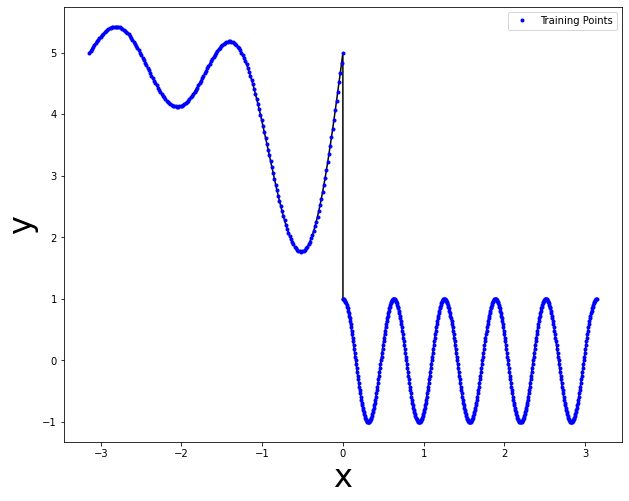

In [36]:
# ============================================
# LR scheduler example with CONSTANT learning rate
# (This code uses SGD with a fixed lr=0.01)
# ============================================

import numpy as np                          # Numerical computing
import imageio                              # Image/video I/O (NOT used here)
import torch                                # PyTorch tensors + neural nets
import torch.nn.functional as F             # NN functional ops (NOT used here)
import torch.utils.data as Data             # Data utilities (NOT used here)
from torch.autograd import Variable         # Legacy autograd wrapper (NOT needed in modern PyTorch)
import matplotlib.pyplot as plt             # Plotting
from torch.optim import SGD, LBFGS, Adam, RMSprop, SparseAdam  # Optimizers (mostly NOT used here)

torch.manual_seed(1234)                     # Reproducible initialization/training


# --------------------------------------------
# Define a piecewise target function y = f(x)
# Left side (x < 0): sum of sines + constant
# Right side (x >= 0): cos(10x)
# --------------------------------------------
def fun_x(x):
    if x < 0.0:
        f = 5.0 + np.sin(x) + np.sin(2.0 * x) + np.sin(3.0 * x) + np.sin(4.0 * x)
    else:
        f = np.cos(10.0 * x)
    return f


# --------------------------------------------
# Create training data (x_in, y_in)
# and test data (x_test, y_test)
# Avoid x = 0 on the left side by using -1e-3
# --------------------------------------------
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))

# Training inputs: left and right intervals
x_in_l = np.linspace(-np.pi, -1.0e-3, 201)   # left side (negative)
x_in_r = np.linspace(0.0, np.pi, 501)        # right side (non-negative)

# Training outputs
y_in_l = np.array([fun_x(i) for i in x_in_l])
y_in_r = np.array([fun_x(i) for i in x_in_r])

# Combine into full training set
x_in = np.concatenate((x_in_l, x_in_r), axis=0)
y_in = np.array([fun_x(i) for i in x_in])

# Test inputs (more points on the left side than train)
x_test_l = np.linspace(-np.pi, -1.0e-3, 301)
x_test_r = np.linspace(0.0, np.pi, 501)
x_test = np.concatenate((x_test_l, x_test_r), axis=0)

# Test outputs
y_test = np.array([fun_x(i) for i in x_test])


# --------------------------------------------
# Visualize the training function/points
# --------------------------------------------
ax1.plot(x_in, y_in, 'k-')                          # underlying function curve
ax1.plot(x_in, y_in, '.b', label="Training Points") # training samples
ax1.set_xlabel('x', fontsize=32)
ax1.set_ylabel('y', fontsize=32)
ax1.legend()


# --------------------------------------------
# Convert NumPy arrays to PyTorch tensors
# Reshape to (N,1) for a single input feature
# --------------------------------------------
x = torch.from_numpy(x_in.reshape(-1, 1)).float()
y = torch.from_numpy(y_in.reshape(-1, 1)).float()

x_test_t = torch.from_numpy(x_test.reshape(-1, 1)).float()
y_test_t = torch.from_numpy(y_test.reshape(-1, 1)).float()


# --------------------------------------------
# Model, loss function, training settings
# --------------------------------------------
loss_function = torch.nn.MSELoss()          # Mean Squared Error regression loss
Niter = 30000                               # Number of training iterations

# Simple feed-forward network:
# 1 -> 100 (ReLU) -> 1
Net = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

# NOTE: This is SGD  with constant learning rate 0.01
optimizer = torch.optim.SGD(Net.parameters(), lr=0.01)


# --------------------------------------------
# Logs for learning curves
# --------------------------------------------
train_loss_list = []    # MSE on training set each iteration
test_loss_list = []     # MSE on test set each iteration
acc_train = []          # Custom "relative error" on train
acc_test = []           # Custom "relative error" on test

# Variable(...) is not needed in modern PyTorch, but kept for compatibility with your style
x = Variable(x)
y = Variable(y)


# --------------------------------------------
# Training loop (full-batch gradient descent style)
# --------------------------------------------
print('SGD Optimization (constant LR)')

for it in range(Niter):
    # Forward pass: predict y for training inputs
    y_pred = Net(x)

    # Compute training loss (prediction first, then target)
    loss = loss_function(y_pred, y)

    # Backprop: clear old gradients, compute new gradients, apply update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (it %5000)==0:
        print(f"Epoch: {it + 1:02}/{Niter} Loss: {loss:.5e}")

    # Compute metrics without tracking gradients (faster + avoids graph growth)
    with torch.no_grad():
        # Training prediction and "relative error" metric
        y_train_pred = Net(x)
        train_rel_err = torch.linalg.norm(y - y_train_pred) / torch.linalg.norm(y_train_pred)

        # Test prediction, test loss, and "relative error"
        y_test_pred = Net(x_test_t)
        test_loss = loss_function(y_test_pred, y_test_t)
        test_rel_err = torch.linalg.norm(y_test_t - y_test_pred) / torch.linalg.norm(y_test_pred)

        # Store scalars (use .item() to store Python floats, not tensors)
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
        acc_train.append(train_rel_err.item())
        acc_test.append(test_rel_err.item())


# --------------------------------------------
# Final training predictions as NumPy array
# --------------------------------------------
y_const_lr = y_pred.detach().numpy()

# --------------------------------------------
# Plot Training and Test Loss (Constant LR)
# --------------------------------------------

fig, ax = plt.subplots(figsize=(15, 10))

# Iteration index
ep = np.arange(0, Niter, 1)

# Since we stored floats using .item(), no need for .numpy() or .detach()
train_loss_np_clr = np.array(train_loss_list)
test_loss_np_clr = np.array(test_loss_list)

# Axis labels
ax.set_xlabel('# Iterations', fontsize=32)
ax.set_ylabel('Loss (MSE)', fontsize=32)

# X-axis limit
ax.set_xlim(0, Niter + 10)

# Log-scale plot for better visualization
ax.semilogy(ep, train_loss_np_clr, 'k--', lw=2, label="Train Loss")
ax.semilogy(ep, test_loss_np_clr,  'r--', lw=2, label="Test Loss")

plt.legend()
plt.show()

# --------------------------------------------
# Plot Model Prediction vs Training Data
# --------------------------------------------

# Get final model prediction (as NumPy)
with torch.no_grad():
    y_const_lr = Net(x).detach().numpy()

fig, ax = plt.subplots(figsize=(15, 10))

# Plot true function curve
ax.plot(x_in, y_in, 'k-', label="True Function")

# Plot training data points
ax.plot(x_in, y_in, '.b', label="Training Points")

# Plot neural network prediction
ax.plot(x_in, y_const_lr, '-r', label="NN Prediction (Constant LR)")

ax.set_xlabel('x', fontsize=32)
ax.set_ylabel('y', fontsize=32)

plt.legend()
plt.show()

# Linear learning rate scheduler for DNN with function approxiamtion


SGD Optimization (Poly LR Decay)
Epoch: 01/30000  Loss: 6.23648e+00  LR: 1.000e-03
Epoch: 1001/30000  Loss: 7.35799e-01  LR: 9.832e-04
Epoch: 2001/30000  Loss: 6.93495e-01  LR: 9.661e-04
Epoch: 3001/30000  Loss: 6.67482e-01  LR: 9.487e-04
Epoch: 4001/30000  Loss: 6.49883e-01  LR: 9.309e-04
Epoch: 5001/30000  Loss: 6.37026e-01  LR: 9.129e-04
Epoch: 6001/30000  Loss: 6.27090e-01  LR: 8.944e-04
Epoch: 7001/30000  Loss: 6.19081e-01  LR: 8.756e-04
Epoch: 8001/30000  Loss: 6.12397e-01  LR: 8.563e-04
Epoch: 9001/30000  Loss: 6.06687e-01  LR: 8.366e-04
Epoch: 10001/30000  Loss: 6.01729e-01  LR: 8.165e-04
Epoch: 11001/30000  Loss: 5.97378e-01  LR: 7.958e-04
Epoch: 12001/30000  Loss: 5.93527e-01  LR: 7.746e-04
Epoch: 13001/30000  Loss: 5.90093e-01  LR: 7.528e-04
Epoch: 14001/30000  Loss: 5.87026e-01  LR: 7.303e-04
Epoch: 15001/30000  Loss: 5.84272e-01  LR: 7.071e-04
Epoch: 16001/30000  Loss: 5.81792e-01  LR: 6.831e-04
Epoch: 17001/30000  Loss: 5.79554e-01  LR: 6.583e-04
Epoch: 18001/30000  Loss:

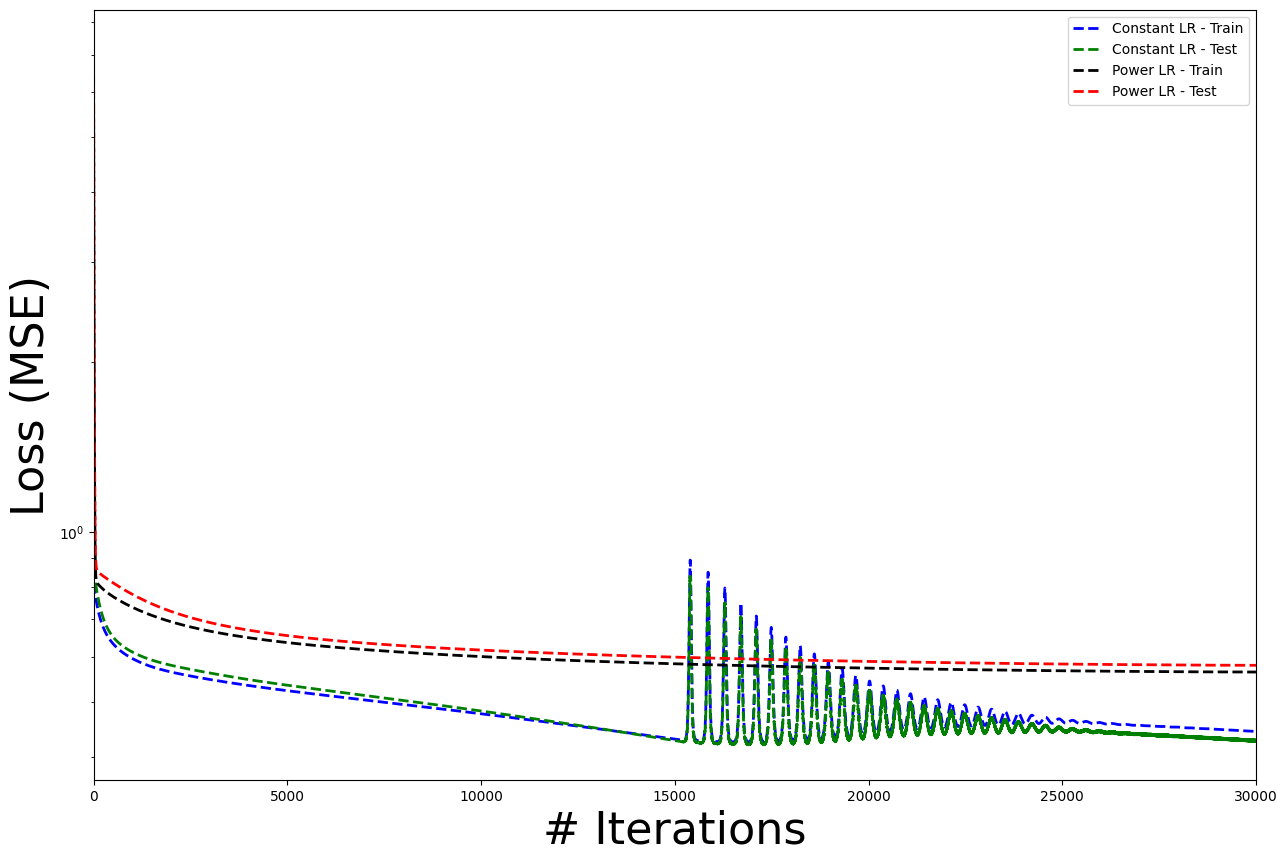

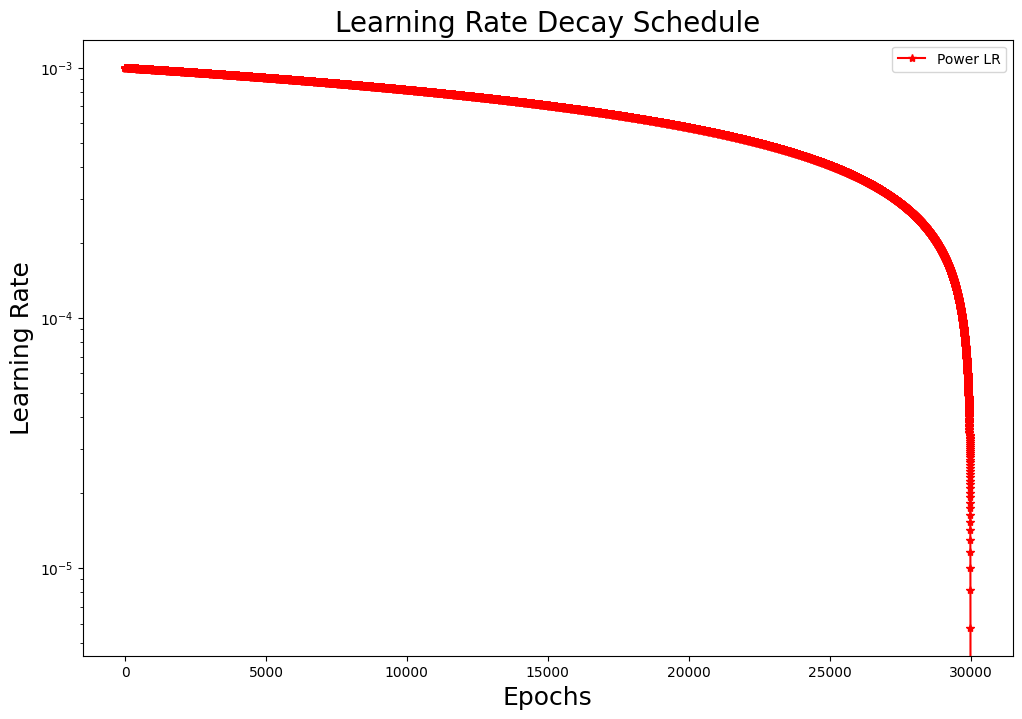

Epoch: 1497/30000 Loss: 7.11996e-01
Epoch: 1498/30000 Loss: 7.11954e-01
Epoch: 1499/30000 Loss: 7.11913e-01
Epoch: 1500/30000 Loss: 7.11871e-01
Epoch: 1501/30000 Loss: 7.11829e-01
Epoch: 1502/30000 Loss: 7.11788e-01
Epoch: 1503/30000 Loss: 7.11746e-01
Epoch: 1504/30000 Loss: 7.11705e-01
Epoch: 1505/30000 Loss: 7.11663e-01
Epoch: 1506/30000 Loss: 7.11622e-01
Epoch: 1507/30000 Loss: 7.11580e-01
Epoch: 1508/30000 Loss: 7.11539e-01
Epoch: 1509/30000 Loss: 7.11498e-01
Epoch: 1510/30000 Loss: 7.11456e-01
Epoch: 1511/30000 Loss: 7.11415e-01
Epoch: 1512/30000 Loss: 7.11374e-01
Epoch: 1513/30000 Loss: 7.11332e-01
Epoch: 1514/30000 Loss: 7.11291e-01
Epoch: 1515/30000 Loss: 7.11250e-01
Epoch: 1516/30000 Loss: 7.11208e-01
Epoch: 1517/30000 Loss: 7.11167e-01
Epoch: 1518/30000 Loss: 7.11126e-01
Epoch: 1519/30000 Loss: 7.11085e-01
Epoch: 1520/30000 Loss: 7.11043e-01
Epoch: 1521/30000 Loss: 7.11002e-01
Epoch: 1522/30000 Loss: 7.10961e-01
Epoch: 1523/30000 Loss: 7.10920e-01
Epoch: 1524/30000 Loss: 7.10

Epoch: 1866/30000 Loss: 6.97998e-01
Epoch: 1867/30000 Loss: 6.97964e-01
Epoch: 1868/30000 Loss: 6.97929e-01
Epoch: 1869/30000 Loss: 6.97895e-01
Epoch: 1870/30000 Loss: 6.97860e-01
Epoch: 1871/30000 Loss: 6.97826e-01
Epoch: 1872/30000 Loss: 6.97791e-01
Epoch: 1873/30000 Loss: 6.97757e-01
Epoch: 1874/30000 Loss: 6.97723e-01
Epoch: 1875/30000 Loss: 6.97688e-01
Epoch: 1876/30000 Loss: 6.97654e-01
Epoch: 1877/30000 Loss: 6.97619e-01
Epoch: 1878/30000 Loss: 6.97585e-01
Epoch: 1879/30000 Loss: 6.97551e-01
Epoch: 1880/30000 Loss: 6.97517e-01
Epoch: 1881/30000 Loss: 6.97482e-01
Epoch: 1882/30000 Loss: 6.97448e-01
Epoch: 1883/30000 Loss: 6.97414e-01
Epoch: 1884/30000 Loss: 6.97380e-01
Epoch: 1885/30000 Loss: 6.97346e-01
Epoch: 1886/30000 Loss: 6.97312e-01
Epoch: 1887/30000 Loss: 6.97277e-01
Epoch: 1888/30000 Loss: 6.97243e-01
Epoch: 1889/30000 Loss: 6.97209e-01
Epoch: 1890/30000 Loss: 6.97175e-01
Epoch: 1891/30000 Loss: 6.97141e-01
Epoch: 1892/30000 Loss: 6.97107e-01
Epoch: 1893/30000 Loss: 6.97

Epoch: 2240/30000 Loss: 6.86201e-01
Epoch: 2241/30000 Loss: 6.86172e-01
Epoch: 2242/30000 Loss: 6.86143e-01
Epoch: 2243/30000 Loss: 6.86114e-01
Epoch: 2244/30000 Loss: 6.86085e-01
Epoch: 2245/30000 Loss: 6.86056e-01
Epoch: 2246/30000 Loss: 6.86028e-01
Epoch: 2247/30000 Loss: 6.85999e-01
Epoch: 2248/30000 Loss: 6.85970e-01
Epoch: 2249/30000 Loss: 6.85941e-01
Epoch: 2250/30000 Loss: 6.85913e-01
Epoch: 2251/30000 Loss: 6.85884e-01
Epoch: 2252/30000 Loss: 6.85855e-01
Epoch: 2253/30000 Loss: 6.85827e-01
Epoch: 2254/30000 Loss: 6.85798e-01
Epoch: 2255/30000 Loss: 6.85769e-01
Epoch: 2256/30000 Loss: 6.85740e-01
Epoch: 2257/30000 Loss: 6.85712e-01
Epoch: 2258/30000 Loss: 6.85683e-01
Epoch: 2259/30000 Loss: 6.85655e-01
Epoch: 2260/30000 Loss: 6.85626e-01
Epoch: 2261/30000 Loss: 6.85597e-01
Epoch: 2262/30000 Loss: 6.85569e-01
Epoch: 2263/30000 Loss: 6.85540e-01
Epoch: 2264/30000 Loss: 6.85512e-01
Epoch: 2265/30000 Loss: 6.85483e-01
Epoch: 2266/30000 Loss: 6.85455e-01
Epoch: 2267/30000 Loss: 6.85

Epoch: 2607/30000 Loss: 6.76424e-01
Epoch: 2608/30000 Loss: 6.76399e-01
Epoch: 2609/30000 Loss: 6.76375e-01
Epoch: 2610/30000 Loss: 6.76350e-01
Epoch: 2611/30000 Loss: 6.76326e-01
Epoch: 2612/30000 Loss: 6.76301e-01
Epoch: 2613/30000 Loss: 6.76277e-01
Epoch: 2614/30000 Loss: 6.76252e-01
Epoch: 2615/30000 Loss: 6.76228e-01
Epoch: 2616/30000 Loss: 6.76203e-01
Epoch: 2617/30000 Loss: 6.76179e-01
Epoch: 2618/30000 Loss: 6.76154e-01
Epoch: 2619/30000 Loss: 6.76130e-01
Epoch: 2620/30000 Loss: 6.76105e-01
Epoch: 2621/30000 Loss: 6.76081e-01
Epoch: 2622/30000 Loss: 6.76057e-01
Epoch: 2623/30000 Loss: 6.76032e-01
Epoch: 2624/30000 Loss: 6.76008e-01
Epoch: 2625/30000 Loss: 6.75983e-01
Epoch: 2626/30000 Loss: 6.75959e-01
Epoch: 2627/30000 Loss: 6.75935e-01
Epoch: 2628/30000 Loss: 6.75910e-01
Epoch: 2629/30000 Loss: 6.75886e-01
Epoch: 2630/30000 Loss: 6.75861e-01
Epoch: 2631/30000 Loss: 6.75837e-01
Epoch: 2632/30000 Loss: 6.75813e-01
Epoch: 2633/30000 Loss: 6.75788e-01
Epoch: 2634/30000 Loss: 6.75

Epoch: 2974/30000 Loss: 6.68050e-01
Epoch: 2975/30000 Loss: 6.68029e-01
Epoch: 2976/30000 Loss: 6.68008e-01
Epoch: 2977/30000 Loss: 6.67987e-01
Epoch: 2978/30000 Loss: 6.67966e-01
Epoch: 2979/30000 Loss: 6.67945e-01
Epoch: 2980/30000 Loss: 6.67923e-01
Epoch: 2981/30000 Loss: 6.67902e-01
Epoch: 2982/30000 Loss: 6.67881e-01
Epoch: 2983/30000 Loss: 6.67860e-01
Epoch: 2984/30000 Loss: 6.67839e-01
Epoch: 2985/30000 Loss: 6.67818e-01
Epoch: 2986/30000 Loss: 6.67797e-01
Epoch: 2987/30000 Loss: 6.67776e-01
Epoch: 2988/30000 Loss: 6.67755e-01
Epoch: 2989/30000 Loss: 6.67734e-01
Epoch: 2990/30000 Loss: 6.67713e-01
Epoch: 2991/30000 Loss: 6.67692e-01
Epoch: 2992/30000 Loss: 6.67670e-01
Epoch: 2993/30000 Loss: 6.67650e-01
Epoch: 2994/30000 Loss: 6.67629e-01
Epoch: 2995/30000 Loss: 6.67607e-01
Epoch: 2996/30000 Loss: 6.67587e-01
Epoch: 2997/30000 Loss: 6.67566e-01
Epoch: 2998/30000 Loss: 6.67545e-01
Epoch: 2999/30000 Loss: 6.67524e-01
Epoch: 3000/30000 Loss: 6.67503e-01
Epoch: 3001/30000 Loss: 6.67

Epoch: 3347/30000 Loss: 6.60686e-01
Epoch: 3348/30000 Loss: 6.60668e-01
Epoch: 3349/30000 Loss: 6.60649e-01
Epoch: 3350/30000 Loss: 6.60631e-01
Epoch: 3351/30000 Loss: 6.60612e-01
Epoch: 3352/30000 Loss: 6.60594e-01
Epoch: 3353/30000 Loss: 6.60576e-01
Epoch: 3354/30000 Loss: 6.60557e-01
Epoch: 3355/30000 Loss: 6.60539e-01
Epoch: 3356/30000 Loss: 6.60521e-01
Epoch: 3357/30000 Loss: 6.60502e-01
Epoch: 3358/30000 Loss: 6.60484e-01
Epoch: 3359/30000 Loss: 6.60466e-01
Epoch: 3360/30000 Loss: 6.60447e-01
Epoch: 3361/30000 Loss: 6.60429e-01
Epoch: 3362/30000 Loss: 6.60411e-01
Epoch: 3363/30000 Loss: 6.60392e-01
Epoch: 3364/30000 Loss: 6.60374e-01
Epoch: 3365/30000 Loss: 6.60356e-01
Epoch: 3366/30000 Loss: 6.60337e-01
Epoch: 3367/30000 Loss: 6.60319e-01
Epoch: 3368/30000 Loss: 6.60301e-01
Epoch: 3369/30000 Loss: 6.60282e-01
Epoch: 3370/30000 Loss: 6.60264e-01
Epoch: 3371/30000 Loss: 6.60246e-01
Epoch: 3372/30000 Loss: 6.60228e-01
Epoch: 3373/30000 Loss: 6.60209e-01
Epoch: 3374/30000 Loss: 6.60

Epoch: 3719/30000 Loss: 6.54257e-01
Epoch: 3720/30000 Loss: 6.54241e-01
Epoch: 3721/30000 Loss: 6.54225e-01
Epoch: 3722/30000 Loss: 6.54208e-01
Epoch: 3723/30000 Loss: 6.54192e-01
Epoch: 3724/30000 Loss: 6.54176e-01
Epoch: 3725/30000 Loss: 6.54160e-01
Epoch: 3726/30000 Loss: 6.54144e-01
Epoch: 3727/30000 Loss: 6.54127e-01
Epoch: 3728/30000 Loss: 6.54111e-01
Epoch: 3729/30000 Loss: 6.54095e-01
Epoch: 3730/30000 Loss: 6.54079e-01
Epoch: 3731/30000 Loss: 6.54063e-01
Epoch: 3732/30000 Loss: 6.54047e-01
Epoch: 3733/30000 Loss: 6.54030e-01
Epoch: 3734/30000 Loss: 6.54014e-01
Epoch: 3735/30000 Loss: 6.53998e-01
Epoch: 3736/30000 Loss: 6.53982e-01
Epoch: 3737/30000 Loss: 6.53966e-01
Epoch: 3738/30000 Loss: 6.53950e-01
Epoch: 3739/30000 Loss: 6.53933e-01
Epoch: 3740/30000 Loss: 6.53917e-01
Epoch: 3741/30000 Loss: 6.53901e-01
Epoch: 3742/30000 Loss: 6.53885e-01
Epoch: 3743/30000 Loss: 6.53869e-01
Epoch: 3744/30000 Loss: 6.53853e-01
Epoch: 3745/30000 Loss: 6.53837e-01
Epoch: 3746/30000 Loss: 6.53

Epoch: 4081/30000 Loss: 6.48711e-01
Epoch: 4082/30000 Loss: 6.48696e-01
Epoch: 4083/30000 Loss: 6.48682e-01
Epoch: 4084/30000 Loss: 6.48668e-01
Epoch: 4085/30000 Loss: 6.48653e-01
Epoch: 4086/30000 Loss: 6.48639e-01
Epoch: 4087/30000 Loss: 6.48624e-01
Epoch: 4088/30000 Loss: 6.48610e-01
Epoch: 4089/30000 Loss: 6.48595e-01
Epoch: 4090/30000 Loss: 6.48581e-01
Epoch: 4091/30000 Loss: 6.48567e-01
Epoch: 4092/30000 Loss: 6.48552e-01
Epoch: 4093/30000 Loss: 6.48538e-01
Epoch: 4094/30000 Loss: 6.48524e-01
Epoch: 4095/30000 Loss: 6.48509e-01
Epoch: 4096/30000 Loss: 6.48495e-01
Epoch: 4097/30000 Loss: 6.48480e-01
Epoch: 4098/30000 Loss: 6.48466e-01
Epoch: 4099/30000 Loss: 6.48452e-01
Epoch: 4100/30000 Loss: 6.48437e-01
Epoch: 4101/30000 Loss: 6.48423e-01
Epoch: 4102/30000 Loss: 6.48409e-01
Epoch: 4103/30000 Loss: 6.48394e-01
Epoch: 4104/30000 Loss: 6.48380e-01
Epoch: 4105/30000 Loss: 6.48366e-01
Epoch: 4106/30000 Loss: 6.48351e-01
Epoch: 4107/30000 Loss: 6.48337e-01
Epoch: 4108/30000 Loss: 6.48

Epoch: 4449/30000 Loss: 6.43674e-01
Epoch: 4450/30000 Loss: 6.43661e-01
Epoch: 4451/30000 Loss: 6.43648e-01
Epoch: 4452/30000 Loss: 6.43636e-01
Epoch: 4453/30000 Loss: 6.43623e-01
Epoch: 4454/30000 Loss: 6.43610e-01
Epoch: 4455/30000 Loss: 6.43597e-01
Epoch: 4456/30000 Loss: 6.43584e-01
Epoch: 4457/30000 Loss: 6.43571e-01
Epoch: 4458/30000 Loss: 6.43558e-01
Epoch: 4459/30000 Loss: 6.43545e-01
Epoch: 4460/30000 Loss: 6.43532e-01
Epoch: 4461/30000 Loss: 6.43519e-01
Epoch: 4462/30000 Loss: 6.43506e-01
Epoch: 4463/30000 Loss: 6.43493e-01
Epoch: 4464/30000 Loss: 6.43480e-01
Epoch: 4465/30000 Loss: 6.43467e-01
Epoch: 4466/30000 Loss: 6.43454e-01
Epoch: 4467/30000 Loss: 6.43442e-01
Epoch: 4468/30000 Loss: 6.43429e-01
Epoch: 4469/30000 Loss: 6.43416e-01
Epoch: 4470/30000 Loss: 6.43403e-01
Epoch: 4471/30000 Loss: 6.43390e-01
Epoch: 4472/30000 Loss: 6.43377e-01
Epoch: 4473/30000 Loss: 6.43364e-01
Epoch: 4474/30000 Loss: 6.43351e-01
Epoch: 4475/30000 Loss: 6.43339e-01
Epoch: 4476/30000 Loss: 6.43

Epoch: 4814/30000 Loss: 6.39170e-01
Epoch: 4815/30000 Loss: 6.39158e-01
Epoch: 4816/30000 Loss: 6.39147e-01
Epoch: 4817/30000 Loss: 6.39135e-01
Epoch: 4818/30000 Loss: 6.39123e-01
Epoch: 4819/30000 Loss: 6.39112e-01
Epoch: 4820/30000 Loss: 6.39100e-01
Epoch: 4821/30000 Loss: 6.39088e-01
Epoch: 4822/30000 Loss: 6.39077e-01
Epoch: 4823/30000 Loss: 6.39065e-01
Epoch: 4824/30000 Loss: 6.39053e-01
Epoch: 4825/30000 Loss: 6.39041e-01
Epoch: 4826/30000 Loss: 6.39030e-01
Epoch: 4827/30000 Loss: 6.39018e-01
Epoch: 4828/30000 Loss: 6.39006e-01
Epoch: 4829/30000 Loss: 6.38995e-01
Epoch: 4830/30000 Loss: 6.38983e-01
Epoch: 4831/30000 Loss: 6.38971e-01
Epoch: 4832/30000 Loss: 6.38960e-01
Epoch: 4833/30000 Loss: 6.38948e-01
Epoch: 4834/30000 Loss: 6.38936e-01
Epoch: 4835/30000 Loss: 6.38925e-01
Epoch: 4836/30000 Loss: 6.38913e-01
Epoch: 4837/30000 Loss: 6.38901e-01
Epoch: 4838/30000 Loss: 6.38890e-01
Epoch: 4839/30000 Loss: 6.38878e-01
Epoch: 4840/30000 Loss: 6.38866e-01
Epoch: 4841/30000 Loss: 6.38

Epoch: 5195/30000 Loss: 6.34911e-01
Epoch: 5196/30000 Loss: 6.34900e-01
Epoch: 5197/30000 Loss: 6.34889e-01
Epoch: 5198/30000 Loss: 6.34879e-01
Epoch: 5199/30000 Loss: 6.34868e-01
Epoch: 5200/30000 Loss: 6.34858e-01
Epoch: 5201/30000 Loss: 6.34847e-01
Epoch: 5202/30000 Loss: 6.34836e-01
Epoch: 5203/30000 Loss: 6.34826e-01
Epoch: 5204/30000 Loss: 6.34815e-01
Epoch: 5205/30000 Loss: 6.34805e-01
Epoch: 5206/30000 Loss: 6.34794e-01
Epoch: 5207/30000 Loss: 6.34783e-01
Epoch: 5208/30000 Loss: 6.34773e-01
Epoch: 5209/30000 Loss: 6.34762e-01
Epoch: 5210/30000 Loss: 6.34751e-01
Epoch: 5211/30000 Loss: 6.34741e-01
Epoch: 5212/30000 Loss: 6.34730e-01
Epoch: 5213/30000 Loss: 6.34720e-01
Epoch: 5214/30000 Loss: 6.34709e-01
Epoch: 5215/30000 Loss: 6.34699e-01
Epoch: 5216/30000 Loss: 6.34688e-01
Epoch: 5217/30000 Loss: 6.34677e-01
Epoch: 5218/30000 Loss: 6.34667e-01
Epoch: 5219/30000 Loss: 6.34656e-01
Epoch: 5220/30000 Loss: 6.34646e-01
Epoch: 5221/30000 Loss: 6.34635e-01
Epoch: 5222/30000 Loss: 6.34

Epoch: 5565/30000 Loss: 6.31140e-01
Epoch: 5566/30000 Loss: 6.31130e-01
Epoch: 5567/30000 Loss: 6.31121e-01
Epoch: 5568/30000 Loss: 6.31111e-01
Epoch: 5569/30000 Loss: 6.31101e-01
Epoch: 5570/30000 Loss: 6.31092e-01
Epoch: 5571/30000 Loss: 6.31082e-01
Epoch: 5572/30000 Loss: 6.31072e-01
Epoch: 5573/30000 Loss: 6.31062e-01
Epoch: 5574/30000 Loss: 6.31053e-01
Epoch: 5575/30000 Loss: 6.31043e-01
Epoch: 5576/30000 Loss: 6.31033e-01
Epoch: 5577/30000 Loss: 6.31024e-01
Epoch: 5578/30000 Loss: 6.31014e-01
Epoch: 5579/30000 Loss: 6.31004e-01
Epoch: 5580/30000 Loss: 6.30994e-01
Epoch: 5581/30000 Loss: 6.30985e-01
Epoch: 5582/30000 Loss: 6.30975e-01
Epoch: 5583/30000 Loss: 6.30965e-01
Epoch: 5584/30000 Loss: 6.30956e-01
Epoch: 5585/30000 Loss: 6.30946e-01
Epoch: 5586/30000 Loss: 6.30936e-01
Epoch: 5587/30000 Loss: 6.30927e-01
Epoch: 5588/30000 Loss: 6.30917e-01
Epoch: 5589/30000 Loss: 6.30907e-01
Epoch: 5590/30000 Loss: 6.30898e-01
Epoch: 5591/30000 Loss: 6.30888e-01
Epoch: 5592/30000 Loss: 6.30

Epoch: 5948/30000 Loss: 6.27561e-01
Epoch: 5949/30000 Loss: 6.27552e-01
Epoch: 5950/30000 Loss: 6.27543e-01
Epoch: 5951/30000 Loss: 6.27534e-01
Epoch: 5952/30000 Loss: 6.27525e-01
Epoch: 5953/30000 Loss: 6.27516e-01
Epoch: 5954/30000 Loss: 6.27507e-01
Epoch: 5955/30000 Loss: 6.27498e-01
Epoch: 5956/30000 Loss: 6.27489e-01
Epoch: 5957/30000 Loss: 6.27480e-01
Epoch: 5958/30000 Loss: 6.27472e-01
Epoch: 5959/30000 Loss: 6.27463e-01
Epoch: 5960/30000 Loss: 6.27454e-01
Epoch: 5961/30000 Loss: 6.27445e-01
Epoch: 5962/30000 Loss: 6.27436e-01
Epoch: 5963/30000 Loss: 6.27427e-01
Epoch: 5964/30000 Loss: 6.27418e-01
Epoch: 5965/30000 Loss: 6.27409e-01
Epoch: 5966/30000 Loss: 6.27400e-01
Epoch: 5967/30000 Loss: 6.27391e-01
Epoch: 5968/30000 Loss: 6.27382e-01
Epoch: 5969/30000 Loss: 6.27374e-01
Epoch: 5970/30000 Loss: 6.27365e-01
Epoch: 5971/30000 Loss: 6.27356e-01
Epoch: 5972/30000 Loss: 6.27347e-01
Epoch: 5973/30000 Loss: 6.27338e-01
Epoch: 5974/30000 Loss: 6.27329e-01
Epoch: 5975/30000 Loss: 6.27

Epoch: 6323/30000 Loss: 6.24337e-01
Epoch: 6324/30000 Loss: 6.24328e-01
Epoch: 6325/30000 Loss: 6.24320e-01
Epoch: 6326/30000 Loss: 6.24312e-01
Epoch: 6327/30000 Loss: 6.24304e-01
Epoch: 6328/30000 Loss: 6.24295e-01
Epoch: 6329/30000 Loss: 6.24287e-01
Epoch: 6330/30000 Loss: 6.24279e-01
Epoch: 6331/30000 Loss: 6.24271e-01
Epoch: 6332/30000 Loss: 6.24262e-01
Epoch: 6333/30000 Loss: 6.24254e-01
Epoch: 6334/30000 Loss: 6.24246e-01
Epoch: 6335/30000 Loss: 6.24238e-01
Epoch: 6336/30000 Loss: 6.24229e-01
Epoch: 6337/30000 Loss: 6.24221e-01
Epoch: 6338/30000 Loss: 6.24213e-01
Epoch: 6339/30000 Loss: 6.24205e-01
Epoch: 6340/30000 Loss: 6.24196e-01
Epoch: 6341/30000 Loss: 6.24188e-01
Epoch: 6342/30000 Loss: 6.24180e-01
Epoch: 6343/30000 Loss: 6.24172e-01
Epoch: 6344/30000 Loss: 6.24163e-01
Epoch: 6345/30000 Loss: 6.24155e-01
Epoch: 6346/30000 Loss: 6.24147e-01
Epoch: 6347/30000 Loss: 6.24139e-01
Epoch: 6348/30000 Loss: 6.24130e-01
Epoch: 6349/30000 Loss: 6.24122e-01
Epoch: 6350/30000 Loss: 6.24

Epoch: 6683/30000 Loss: 6.21461e-01
Epoch: 6684/30000 Loss: 6.21454e-01
Epoch: 6685/30000 Loss: 6.21446e-01
Epoch: 6686/30000 Loss: 6.21438e-01
Epoch: 6687/30000 Loss: 6.21431e-01
Epoch: 6688/30000 Loss: 6.21423e-01
Epoch: 6689/30000 Loss: 6.21415e-01
Epoch: 6690/30000 Loss: 6.21407e-01
Epoch: 6691/30000 Loss: 6.21400e-01
Epoch: 6692/30000 Loss: 6.21392e-01
Epoch: 6693/30000 Loss: 6.21384e-01
Epoch: 6694/30000 Loss: 6.21377e-01
Epoch: 6695/30000 Loss: 6.21369e-01
Epoch: 6696/30000 Loss: 6.21361e-01
Epoch: 6697/30000 Loss: 6.21354e-01
Epoch: 6698/30000 Loss: 6.21346e-01
Epoch: 6699/30000 Loss: 6.21338e-01
Epoch: 6700/30000 Loss: 6.21330e-01
Epoch: 6701/30000 Loss: 6.21323e-01
Epoch: 6702/30000 Loss: 6.21315e-01
Epoch: 6703/30000 Loss: 6.21307e-01
Epoch: 6704/30000 Loss: 6.21300e-01
Epoch: 6705/30000 Loss: 6.21292e-01
Epoch: 6706/30000 Loss: 6.21284e-01
Epoch: 6707/30000 Loss: 6.21277e-01
Epoch: 6708/30000 Loss: 6.21269e-01
Epoch: 6709/30000 Loss: 6.21261e-01
Epoch: 6710/30000 Loss: 6.21

Epoch: 7056/30000 Loss: 6.18683e-01
Epoch: 7057/30000 Loss: 6.18676e-01
Epoch: 7058/30000 Loss: 6.18668e-01
Epoch: 7059/30000 Loss: 6.18661e-01
Epoch: 7060/30000 Loss: 6.18654e-01
Epoch: 7061/30000 Loss: 6.18647e-01
Epoch: 7062/30000 Loss: 6.18639e-01
Epoch: 7063/30000 Loss: 6.18632e-01
Epoch: 7064/30000 Loss: 6.18625e-01
Epoch: 7065/30000 Loss: 6.18618e-01
Epoch: 7066/30000 Loss: 6.18611e-01
Epoch: 7067/30000 Loss: 6.18603e-01
Epoch: 7068/30000 Loss: 6.18596e-01
Epoch: 7069/30000 Loss: 6.18589e-01
Epoch: 7070/30000 Loss: 6.18582e-01
Epoch: 7071/30000 Loss: 6.18575e-01
Epoch: 7072/30000 Loss: 6.18567e-01
Epoch: 7073/30000 Loss: 6.18560e-01
Epoch: 7074/30000 Loss: 6.18553e-01
Epoch: 7075/30000 Loss: 6.18546e-01
Epoch: 7076/30000 Loss: 6.18539e-01
Epoch: 7077/30000 Loss: 6.18532e-01
Epoch: 7078/30000 Loss: 6.18524e-01
Epoch: 7079/30000 Loss: 6.18517e-01
Epoch: 7080/30000 Loss: 6.18510e-01
Epoch: 7081/30000 Loss: 6.18503e-01
Epoch: 7082/30000 Loss: 6.18496e-01
Epoch: 7083/30000 Loss: 6.18

Epoch: 7421/30000 Loss: 6.16136e-01
Epoch: 7422/30000 Loss: 6.16129e-01
Epoch: 7423/30000 Loss: 6.16122e-01
Epoch: 7424/30000 Loss: 6.16116e-01
Epoch: 7425/30000 Loss: 6.16109e-01
Epoch: 7426/30000 Loss: 6.16102e-01
Epoch: 7427/30000 Loss: 6.16095e-01
Epoch: 7428/30000 Loss: 6.16089e-01
Epoch: 7429/30000 Loss: 6.16082e-01
Epoch: 7430/30000 Loss: 6.16075e-01
Epoch: 7431/30000 Loss: 6.16068e-01
Epoch: 7432/30000 Loss: 6.16062e-01
Epoch: 7433/30000 Loss: 6.16055e-01
Epoch: 7434/30000 Loss: 6.16048e-01
Epoch: 7435/30000 Loss: 6.16042e-01
Epoch: 7436/30000 Loss: 6.16035e-01
Epoch: 7437/30000 Loss: 6.16028e-01
Epoch: 7438/30000 Loss: 6.16021e-01
Epoch: 7439/30000 Loss: 6.16015e-01
Epoch: 7440/30000 Loss: 6.16008e-01
Epoch: 7441/30000 Loss: 6.16001e-01
Epoch: 7442/30000 Loss: 6.15995e-01
Epoch: 7443/30000 Loss: 6.15988e-01
Epoch: 7444/30000 Loss: 6.15981e-01
Epoch: 7445/30000 Loss: 6.15974e-01
Epoch: 7446/30000 Loss: 6.15968e-01
Epoch: 7447/30000 Loss: 6.15961e-01
Epoch: 7448/30000 Loss: 6.15

Epoch: 7786/30000 Loss: 6.13742e-01
Epoch: 7787/30000 Loss: 6.13735e-01
Epoch: 7788/30000 Loss: 6.13729e-01
Epoch: 7789/30000 Loss: 6.13723e-01
Epoch: 7790/30000 Loss: 6.13716e-01
Epoch: 7791/30000 Loss: 6.13710e-01
Epoch: 7792/30000 Loss: 6.13704e-01
Epoch: 7793/30000 Loss: 6.13697e-01
Epoch: 7794/30000 Loss: 6.13691e-01
Epoch: 7795/30000 Loss: 6.13684e-01
Epoch: 7796/30000 Loss: 6.13678e-01
Epoch: 7797/30000 Loss: 6.13672e-01
Epoch: 7798/30000 Loss: 6.13665e-01
Epoch: 7799/30000 Loss: 6.13659e-01
Epoch: 7800/30000 Loss: 6.13653e-01
Epoch: 7801/30000 Loss: 6.13646e-01
Epoch: 7802/30000 Loss: 6.13640e-01
Epoch: 7803/30000 Loss: 6.13634e-01
Epoch: 7804/30000 Loss: 6.13627e-01
Epoch: 7805/30000 Loss: 6.13621e-01
Epoch: 7806/30000 Loss: 6.13615e-01
Epoch: 7807/30000 Loss: 6.13608e-01
Epoch: 7808/30000 Loss: 6.13602e-01
Epoch: 7809/30000 Loss: 6.13596e-01
Epoch: 7810/30000 Loss: 6.13589e-01
Epoch: 7811/30000 Loss: 6.13583e-01
Epoch: 7812/30000 Loss: 6.13577e-01
Epoch: 7813/30000 Loss: 6.13

Epoch: 8147/30000 Loss: 6.11509e-01
Epoch: 8148/30000 Loss: 6.11503e-01
Epoch: 8149/30000 Loss: 6.11497e-01
Epoch: 8150/30000 Loss: 6.11491e-01
Epoch: 8151/30000 Loss: 6.11485e-01
Epoch: 8152/30000 Loss: 6.11479e-01
Epoch: 8153/30000 Loss: 6.11473e-01
Epoch: 8154/30000 Loss: 6.11467e-01
Epoch: 8155/30000 Loss: 6.11461e-01
Epoch: 8156/30000 Loss: 6.11455e-01
Epoch: 8157/30000 Loss: 6.11449e-01
Epoch: 8158/30000 Loss: 6.11443e-01
Epoch: 8159/30000 Loss: 6.11437e-01
Epoch: 8160/30000 Loss: 6.11431e-01
Epoch: 8161/30000 Loss: 6.11425e-01
Epoch: 8162/30000 Loss: 6.11419e-01
Epoch: 8163/30000 Loss: 6.11413e-01
Epoch: 8164/30000 Loss: 6.11407e-01
Epoch: 8165/30000 Loss: 6.11401e-01
Epoch: 8166/30000 Loss: 6.11395e-01
Epoch: 8167/30000 Loss: 6.11389e-01
Epoch: 8168/30000 Loss: 6.11383e-01
Epoch: 8169/30000 Loss: 6.11377e-01
Epoch: 8170/30000 Loss: 6.11371e-01
Epoch: 8171/30000 Loss: 6.11365e-01
Epoch: 8172/30000 Loss: 6.11359e-01
Epoch: 8173/30000 Loss: 6.11353e-01
Epoch: 8174/30000 Loss: 6.11

Epoch: 8507/30000 Loss: 6.09401e-01
Epoch: 8508/30000 Loss: 6.09396e-01
Epoch: 8509/30000 Loss: 6.09390e-01
Epoch: 8510/30000 Loss: 6.09384e-01
Epoch: 8511/30000 Loss: 6.09379e-01
Epoch: 8512/30000 Loss: 6.09373e-01
Epoch: 8513/30000 Loss: 6.09367e-01
Epoch: 8514/30000 Loss: 6.09362e-01
Epoch: 8515/30000 Loss: 6.09356e-01
Epoch: 8516/30000 Loss: 6.09350e-01
Epoch: 8517/30000 Loss: 6.09345e-01
Epoch: 8518/30000 Loss: 6.09339e-01
Epoch: 8519/30000 Loss: 6.09333e-01
Epoch: 8520/30000 Loss: 6.09327e-01
Epoch: 8521/30000 Loss: 6.09322e-01
Epoch: 8522/30000 Loss: 6.09316e-01
Epoch: 8523/30000 Loss: 6.09311e-01
Epoch: 8524/30000 Loss: 6.09305e-01
Epoch: 8525/30000 Loss: 6.09299e-01
Epoch: 8526/30000 Loss: 6.09293e-01
Epoch: 8527/30000 Loss: 6.09288e-01
Epoch: 8528/30000 Loss: 6.09282e-01
Epoch: 8529/30000 Loss: 6.09276e-01
Epoch: 8530/30000 Loss: 6.09271e-01
Epoch: 8531/30000 Loss: 6.09265e-01
Epoch: 8532/30000 Loss: 6.09259e-01
Epoch: 8533/30000 Loss: 6.09254e-01
Epoch: 8534/30000 Loss: 6.09

Epoch: 8875/30000 Loss: 6.07360e-01
Epoch: 8876/30000 Loss: 6.07355e-01
Epoch: 8877/30000 Loss: 6.07350e-01
Epoch: 8878/30000 Loss: 6.07344e-01
Epoch: 8879/30000 Loss: 6.07339e-01
Epoch: 8880/30000 Loss: 6.07333e-01
Epoch: 8881/30000 Loss: 6.07328e-01
Epoch: 8882/30000 Loss: 6.07323e-01
Epoch: 8883/30000 Loss: 6.07317e-01
Epoch: 8884/30000 Loss: 6.07312e-01
Epoch: 8885/30000 Loss: 6.07306e-01
Epoch: 8886/30000 Loss: 6.07301e-01
Epoch: 8887/30000 Loss: 6.07296e-01
Epoch: 8888/30000 Loss: 6.07290e-01
Epoch: 8889/30000 Loss: 6.07285e-01
Epoch: 8890/30000 Loss: 6.07279e-01
Epoch: 8891/30000 Loss: 6.07274e-01
Epoch: 8892/30000 Loss: 6.07269e-01
Epoch: 8893/30000 Loss: 6.07263e-01
Epoch: 8894/30000 Loss: 6.07258e-01
Epoch: 8895/30000 Loss: 6.07252e-01
Epoch: 8896/30000 Loss: 6.07247e-01
Epoch: 8897/30000 Loss: 6.07242e-01
Epoch: 8898/30000 Loss: 6.07236e-01
Epoch: 8899/30000 Loss: 6.07231e-01
Epoch: 8900/30000 Loss: 6.07226e-01
Epoch: 8901/30000 Loss: 6.07220e-01
Epoch: 8902/30000 Loss: 6.07

Epoch: 9243/30000 Loss: 6.05422e-01
Epoch: 9244/30000 Loss: 6.05417e-01
Epoch: 9245/30000 Loss: 6.05412e-01
Epoch: 9246/30000 Loss: 6.05407e-01
Epoch: 9247/30000 Loss: 6.05402e-01
Epoch: 9248/30000 Loss: 6.05397e-01
Epoch: 9249/30000 Loss: 6.05392e-01
Epoch: 9250/30000 Loss: 6.05386e-01
Epoch: 9251/30000 Loss: 6.05381e-01
Epoch: 9252/30000 Loss: 6.05376e-01
Epoch: 9253/30000 Loss: 6.05371e-01
Epoch: 9254/30000 Loss: 6.05366e-01
Epoch: 9255/30000 Loss: 6.05361e-01
Epoch: 9256/30000 Loss: 6.05356e-01
Epoch: 9257/30000 Loss: 6.05350e-01
Epoch: 9258/30000 Loss: 6.05345e-01
Epoch: 9259/30000 Loss: 6.05340e-01
Epoch: 9260/30000 Loss: 6.05335e-01
Epoch: 9261/30000 Loss: 6.05330e-01
Epoch: 9262/30000 Loss: 6.05325e-01
Epoch: 9263/30000 Loss: 6.05320e-01
Epoch: 9264/30000 Loss: 6.05315e-01
Epoch: 9265/30000 Loss: 6.05310e-01
Epoch: 9266/30000 Loss: 6.05305e-01
Epoch: 9267/30000 Loss: 6.05299e-01
Epoch: 9268/30000 Loss: 6.05294e-01
Epoch: 9269/30000 Loss: 6.05289e-01
Epoch: 9270/30000 Loss: 6.05

Epoch: 9614/30000 Loss: 6.03567e-01
Epoch: 9615/30000 Loss: 6.03562e-01
Epoch: 9616/30000 Loss: 6.03557e-01
Epoch: 9617/30000 Loss: 6.03552e-01
Epoch: 9618/30000 Loss: 6.03547e-01
Epoch: 9619/30000 Loss: 6.03543e-01
Epoch: 9620/30000 Loss: 6.03538e-01
Epoch: 9621/30000 Loss: 6.03533e-01
Epoch: 9622/30000 Loss: 6.03528e-01
Epoch: 9623/30000 Loss: 6.03523e-01
Epoch: 9624/30000 Loss: 6.03518e-01
Epoch: 9625/30000 Loss: 6.03513e-01
Epoch: 9626/30000 Loss: 6.03508e-01
Epoch: 9627/30000 Loss: 6.03503e-01
Epoch: 9628/30000 Loss: 6.03499e-01
Epoch: 9629/30000 Loss: 6.03494e-01
Epoch: 9630/30000 Loss: 6.03489e-01
Epoch: 9631/30000 Loss: 6.03484e-01
Epoch: 9632/30000 Loss: 6.03479e-01
Epoch: 9633/30000 Loss: 6.03474e-01
Epoch: 9634/30000 Loss: 6.03469e-01
Epoch: 9635/30000 Loss: 6.03464e-01
Epoch: 9636/30000 Loss: 6.03459e-01
Epoch: 9637/30000 Loss: 6.03455e-01
Epoch: 9638/30000 Loss: 6.03450e-01
Epoch: 9639/30000 Loss: 6.03445e-01
Epoch: 9640/30000 Loss: 6.03440e-01
Epoch: 9641/30000 Loss: 6.03

Epoch: 9975/30000 Loss: 6.01849e-01
Epoch: 9976/30000 Loss: 6.01844e-01
Epoch: 9977/30000 Loss: 6.01840e-01
Epoch: 9978/30000 Loss: 6.01835e-01
Epoch: 9979/30000 Loss: 6.01830e-01
Epoch: 9980/30000 Loss: 6.01826e-01
Epoch: 9981/30000 Loss: 6.01821e-01
Epoch: 9982/30000 Loss: 6.01817e-01
Epoch: 9983/30000 Loss: 6.01812e-01
Epoch: 9984/30000 Loss: 6.01807e-01
Epoch: 9985/30000 Loss: 6.01803e-01
Epoch: 9986/30000 Loss: 6.01798e-01
Epoch: 9987/30000 Loss: 6.01793e-01
Epoch: 9988/30000 Loss: 6.01789e-01
Epoch: 9989/30000 Loss: 6.01784e-01
Epoch: 9990/30000 Loss: 6.01779e-01
Epoch: 9991/30000 Loss: 6.01775e-01
Epoch: 9992/30000 Loss: 6.01770e-01
Epoch: 9993/30000 Loss: 6.01766e-01
Epoch: 9994/30000 Loss: 6.01761e-01
Epoch: 9995/30000 Loss: 6.01756e-01
Epoch: 9996/30000 Loss: 6.01752e-01
Epoch: 9997/30000 Loss: 6.01747e-01
Epoch: 9998/30000 Loss: 6.01742e-01
Epoch: 9999/30000 Loss: 6.01738e-01
Epoch: 10000/30000 Loss: 6.01733e-01
Epoch: 10001/30000 Loss: 6.01729e-01
Epoch: 10002/30000 Loss: 6

Epoch: 10340/30000 Loss: 6.00194e-01
Epoch: 10341/30000 Loss: 6.00189e-01
Epoch: 10342/30000 Loss: 6.00185e-01
Epoch: 10343/30000 Loss: 6.00180e-01
Epoch: 10344/30000 Loss: 6.00176e-01
Epoch: 10345/30000 Loss: 6.00171e-01
Epoch: 10346/30000 Loss: 6.00167e-01
Epoch: 10347/30000 Loss: 6.00163e-01
Epoch: 10348/30000 Loss: 6.00158e-01
Epoch: 10349/30000 Loss: 6.00154e-01
Epoch: 10350/30000 Loss: 6.00149e-01
Epoch: 10351/30000 Loss: 6.00145e-01
Epoch: 10352/30000 Loss: 6.00140e-01
Epoch: 10353/30000 Loss: 6.00136e-01
Epoch: 10354/30000 Loss: 6.00132e-01
Epoch: 10355/30000 Loss: 6.00127e-01
Epoch: 10356/30000 Loss: 6.00123e-01
Epoch: 10357/30000 Loss: 6.00118e-01
Epoch: 10358/30000 Loss: 6.00114e-01
Epoch: 10359/30000 Loss: 6.00109e-01
Epoch: 10360/30000 Loss: 6.00105e-01
Epoch: 10361/30000 Loss: 6.00101e-01
Epoch: 10362/30000 Loss: 6.00096e-01
Epoch: 10363/30000 Loss: 6.00092e-01
Epoch: 10364/30000 Loss: 6.00087e-01
Epoch: 10365/30000 Loss: 6.00083e-01
Epoch: 10366/30000 Loss: 6.00079e-01
E

Epoch: 10706/30000 Loss: 5.98605e-01
Epoch: 10707/30000 Loss: 5.98601e-01
Epoch: 10708/30000 Loss: 5.98596e-01
Epoch: 10709/30000 Loss: 5.98592e-01
Epoch: 10710/30000 Loss: 5.98588e-01
Epoch: 10711/30000 Loss: 5.98584e-01
Epoch: 10712/30000 Loss: 5.98580e-01
Epoch: 10713/30000 Loss: 5.98575e-01
Epoch: 10714/30000 Loss: 5.98571e-01
Epoch: 10715/30000 Loss: 5.98567e-01
Epoch: 10716/30000 Loss: 5.98563e-01
Epoch: 10717/30000 Loss: 5.98558e-01
Epoch: 10718/30000 Loss: 5.98554e-01
Epoch: 10719/30000 Loss: 5.98550e-01
Epoch: 10720/30000 Loss: 5.98546e-01
Epoch: 10721/30000 Loss: 5.98541e-01
Epoch: 10722/30000 Loss: 5.98537e-01
Epoch: 10723/30000 Loss: 5.98533e-01
Epoch: 10724/30000 Loss: 5.98529e-01
Epoch: 10725/30000 Loss: 5.98525e-01
Epoch: 10726/30000 Loss: 5.98520e-01
Epoch: 10727/30000 Loss: 5.98516e-01
Epoch: 10728/30000 Loss: 5.98512e-01
Epoch: 10729/30000 Loss: 5.98508e-01
Epoch: 10730/30000 Loss: 5.98503e-01
Epoch: 10731/30000 Loss: 5.98499e-01
Epoch: 10732/30000 Loss: 5.98495e-01
E

Epoch: 11072/30000 Loss: 5.97090e-01
Epoch: 11073/30000 Loss: 5.97086e-01
Epoch: 11074/30000 Loss: 5.97082e-01
Epoch: 11075/30000 Loss: 5.97078e-01
Epoch: 11076/30000 Loss: 5.97074e-01
Epoch: 11077/30000 Loss: 5.97070e-01
Epoch: 11078/30000 Loss: 5.97065e-01
Epoch: 11079/30000 Loss: 5.97061e-01
Epoch: 11080/30000 Loss: 5.97057e-01
Epoch: 11081/30000 Loss: 5.97053e-01
Epoch: 11082/30000 Loss: 5.97049e-01
Epoch: 11083/30000 Loss: 5.97045e-01
Epoch: 11084/30000 Loss: 5.97041e-01
Epoch: 11085/30000 Loss: 5.97037e-01
Epoch: 11086/30000 Loss: 5.97033e-01
Epoch: 11087/30000 Loss: 5.97029e-01
Epoch: 11088/30000 Loss: 5.97025e-01
Epoch: 11089/30000 Loss: 5.97021e-01
Epoch: 11090/30000 Loss: 5.97017e-01
Epoch: 11091/30000 Loss: 5.97013e-01
Epoch: 11092/30000 Loss: 5.97009e-01
Epoch: 11093/30000 Loss: 5.97005e-01
Epoch: 11094/30000 Loss: 5.97001e-01
Epoch: 11095/30000 Loss: 5.96997e-01
Epoch: 11096/30000 Loss: 5.96993e-01
Epoch: 11097/30000 Loss: 5.96989e-01
Epoch: 11098/30000 Loss: 5.96985e-01
E

Epoch: 11439/30000 Loss: 5.95635e-01
Epoch: 11440/30000 Loss: 5.95631e-01
Epoch: 11441/30000 Loss: 5.95627e-01
Epoch: 11442/30000 Loss: 5.95623e-01
Epoch: 11443/30000 Loss: 5.95620e-01
Epoch: 11444/30000 Loss: 5.95616e-01
Epoch: 11445/30000 Loss: 5.95612e-01
Epoch: 11446/30000 Loss: 5.95608e-01
Epoch: 11447/30000 Loss: 5.95604e-01
Epoch: 11448/30000 Loss: 5.95600e-01
Epoch: 11449/30000 Loss: 5.95596e-01
Epoch: 11450/30000 Loss: 5.95592e-01
Epoch: 11451/30000 Loss: 5.95588e-01
Epoch: 11452/30000 Loss: 5.95585e-01
Epoch: 11453/30000 Loss: 5.95581e-01
Epoch: 11454/30000 Loss: 5.95577e-01
Epoch: 11455/30000 Loss: 5.95573e-01
Epoch: 11456/30000 Loss: 5.95569e-01
Epoch: 11457/30000 Loss: 5.95565e-01
Epoch: 11458/30000 Loss: 5.95561e-01
Epoch: 11459/30000 Loss: 5.95557e-01
Epoch: 11460/30000 Loss: 5.95554e-01
Epoch: 11461/30000 Loss: 5.95550e-01
Epoch: 11462/30000 Loss: 5.95546e-01
Epoch: 11463/30000 Loss: 5.95542e-01
Epoch: 11464/30000 Loss: 5.95538e-01
Epoch: 11465/30000 Loss: 5.95534e-01
E

Epoch: 11819/30000 Loss: 5.94193e-01
Epoch: 11820/30000 Loss: 5.94189e-01
Epoch: 11821/30000 Loss: 5.94186e-01
Epoch: 11822/30000 Loss: 5.94182e-01
Epoch: 11823/30000 Loss: 5.94178e-01
Epoch: 11824/30000 Loss: 5.94175e-01
Epoch: 11825/30000 Loss: 5.94171e-01
Epoch: 11826/30000 Loss: 5.94167e-01
Epoch: 11827/30000 Loss: 5.94164e-01
Epoch: 11828/30000 Loss: 5.94160e-01
Epoch: 11829/30000 Loss: 5.94156e-01
Epoch: 11830/30000 Loss: 5.94153e-01
Epoch: 11831/30000 Loss: 5.94149e-01
Epoch: 11832/30000 Loss: 5.94145e-01
Epoch: 11833/30000 Loss: 5.94141e-01
Epoch: 11834/30000 Loss: 5.94138e-01
Epoch: 11835/30000 Loss: 5.94134e-01
Epoch: 11836/30000 Loss: 5.94130e-01
Epoch: 11837/30000 Loss: 5.94127e-01
Epoch: 11838/30000 Loss: 5.94123e-01
Epoch: 11839/30000 Loss: 5.94119e-01
Epoch: 11840/30000 Loss: 5.94116e-01
Epoch: 11841/30000 Loss: 5.94112e-01
Epoch: 11842/30000 Loss: 5.94108e-01
Epoch: 11843/30000 Loss: 5.94105e-01
Epoch: 11844/30000 Loss: 5.94101e-01
Epoch: 11845/30000 Loss: 5.94097e-01
E

Epoch: 12177/30000 Loss: 5.92893e-01
Epoch: 12178/30000 Loss: 5.92890e-01
Epoch: 12179/30000 Loss: 5.92886e-01
Epoch: 12180/30000 Loss: 5.92882e-01
Epoch: 12181/30000 Loss: 5.92879e-01
Epoch: 12182/30000 Loss: 5.92875e-01
Epoch: 12183/30000 Loss: 5.92872e-01
Epoch: 12184/30000 Loss: 5.92868e-01
Epoch: 12185/30000 Loss: 5.92865e-01
Epoch: 12186/30000 Loss: 5.92861e-01
Epoch: 12187/30000 Loss: 5.92857e-01
Epoch: 12188/30000 Loss: 5.92854e-01
Epoch: 12189/30000 Loss: 5.92850e-01
Epoch: 12190/30000 Loss: 5.92847e-01
Epoch: 12191/30000 Loss: 5.92843e-01
Epoch: 12192/30000 Loss: 5.92840e-01
Epoch: 12193/30000 Loss: 5.92836e-01
Epoch: 12194/30000 Loss: 5.92832e-01
Epoch: 12195/30000 Loss: 5.92829e-01
Epoch: 12196/30000 Loss: 5.92825e-01
Epoch: 12197/30000 Loss: 5.92822e-01
Epoch: 12198/30000 Loss: 5.92818e-01
Epoch: 12199/30000 Loss: 5.92815e-01
Epoch: 12200/30000 Loss: 5.92811e-01
Epoch: 12201/30000 Loss: 5.92808e-01
Epoch: 12202/30000 Loss: 5.92804e-01
Epoch: 12203/30000 Loss: 5.92800e-01
E

Epoch: 12543/30000 Loss: 5.91617e-01
Epoch: 12544/30000 Loss: 5.91614e-01
Epoch: 12545/30000 Loss: 5.91610e-01
Epoch: 12546/30000 Loss: 5.91607e-01
Epoch: 12547/30000 Loss: 5.91604e-01
Epoch: 12548/30000 Loss: 5.91600e-01
Epoch: 12549/30000 Loss: 5.91597e-01
Epoch: 12550/30000 Loss: 5.91594e-01
Epoch: 12551/30000 Loss: 5.91590e-01
Epoch: 12552/30000 Loss: 5.91587e-01
Epoch: 12553/30000 Loss: 5.91583e-01
Epoch: 12554/30000 Loss: 5.91580e-01
Epoch: 12555/30000 Loss: 5.91577e-01
Epoch: 12556/30000 Loss: 5.91573e-01
Epoch: 12557/30000 Loss: 5.91570e-01
Epoch: 12558/30000 Loss: 5.91566e-01
Epoch: 12559/30000 Loss: 5.91563e-01
Epoch: 12560/30000 Loss: 5.91560e-01
Epoch: 12561/30000 Loss: 5.91556e-01
Epoch: 12562/30000 Loss: 5.91553e-01
Epoch: 12563/30000 Loss: 5.91549e-01
Epoch: 12564/30000 Loss: 5.91546e-01
Epoch: 12565/30000 Loss: 5.91543e-01
Epoch: 12566/30000 Loss: 5.91539e-01
Epoch: 12567/30000 Loss: 5.91536e-01
Epoch: 12568/30000 Loss: 5.91532e-01
Epoch: 12569/30000 Loss: 5.91529e-01
E

Epoch: 12914/30000 Loss: 5.90377e-01
Epoch: 12915/30000 Loss: 5.90374e-01
Epoch: 12916/30000 Loss: 5.90370e-01
Epoch: 12917/30000 Loss: 5.90367e-01
Epoch: 12918/30000 Loss: 5.90364e-01
Epoch: 12919/30000 Loss: 5.90360e-01
Epoch: 12920/30000 Loss: 5.90357e-01
Epoch: 12921/30000 Loss: 5.90354e-01
Epoch: 12922/30000 Loss: 5.90351e-01
Epoch: 12923/30000 Loss: 5.90347e-01
Epoch: 12924/30000 Loss: 5.90344e-01
Epoch: 12925/30000 Loss: 5.90341e-01
Epoch: 12926/30000 Loss: 5.90337e-01
Epoch: 12927/30000 Loss: 5.90334e-01
Epoch: 12928/30000 Loss: 5.90331e-01
Epoch: 12929/30000 Loss: 5.90328e-01
Epoch: 12930/30000 Loss: 5.90324e-01
Epoch: 12931/30000 Loss: 5.90321e-01
Epoch: 12932/30000 Loss: 5.90318e-01
Epoch: 12933/30000 Loss: 5.90314e-01
Epoch: 12934/30000 Loss: 5.90311e-01
Epoch: 12935/30000 Loss: 5.90308e-01
Epoch: 12936/30000 Loss: 5.90305e-01
Epoch: 12937/30000 Loss: 5.90301e-01
Epoch: 12938/30000 Loss: 5.90298e-01
Epoch: 12939/30000 Loss: 5.90295e-01
Epoch: 12940/30000 Loss: 5.90292e-01
E

Epoch: 13282/30000 Loss: 5.89199e-01
Epoch: 13283/30000 Loss: 5.89195e-01
Epoch: 13284/30000 Loss: 5.89192e-01
Epoch: 13285/30000 Loss: 5.89189e-01
Epoch: 13286/30000 Loss: 5.89186e-01
Epoch: 13287/30000 Loss: 5.89183e-01
Epoch: 13288/30000 Loss: 5.89180e-01
Epoch: 13289/30000 Loss: 5.89177e-01
Epoch: 13290/30000 Loss: 5.89174e-01
Epoch: 13291/30000 Loss: 5.89170e-01
Epoch: 13292/30000 Loss: 5.89167e-01
Epoch: 13293/30000 Loss: 5.89164e-01
Epoch: 13294/30000 Loss: 5.89161e-01
Epoch: 13295/30000 Loss: 5.89158e-01
Epoch: 13296/30000 Loss: 5.89155e-01
Epoch: 13297/30000 Loss: 5.89152e-01
Epoch: 13298/30000 Loss: 5.89149e-01
Epoch: 13299/30000 Loss: 5.89145e-01
Epoch: 13300/30000 Loss: 5.89142e-01
Epoch: 13301/30000 Loss: 5.89139e-01
Epoch: 13302/30000 Loss: 5.89136e-01
Epoch: 13303/30000 Loss: 5.89133e-01
Epoch: 13304/30000 Loss: 5.89130e-01
Epoch: 13305/30000 Loss: 5.89127e-01
Epoch: 13306/30000 Loss: 5.89124e-01
Epoch: 13307/30000 Loss: 5.89120e-01
Epoch: 13308/30000 Loss: 5.89117e-01
E

Epoch: 13652/30000 Loss: 5.88060e-01
Epoch: 13653/30000 Loss: 5.88057e-01
Epoch: 13654/30000 Loss: 5.88054e-01
Epoch: 13655/30000 Loss: 5.88051e-01
Epoch: 13656/30000 Loss: 5.88048e-01
Epoch: 13657/30000 Loss: 5.88045e-01
Epoch: 13658/30000 Loss: 5.88042e-01
Epoch: 13659/30000 Loss: 5.88039e-01
Epoch: 13660/30000 Loss: 5.88036e-01
Epoch: 13661/30000 Loss: 5.88033e-01
Epoch: 13662/30000 Loss: 5.88030e-01
Epoch: 13663/30000 Loss: 5.88027e-01
Epoch: 13664/30000 Loss: 5.88024e-01
Epoch: 13665/30000 Loss: 5.88021e-01
Epoch: 13666/30000 Loss: 5.88018e-01
Epoch: 13667/30000 Loss: 5.88014e-01
Epoch: 13668/30000 Loss: 5.88011e-01
Epoch: 13669/30000 Loss: 5.88008e-01
Epoch: 13670/30000 Loss: 5.88005e-01
Epoch: 13671/30000 Loss: 5.88002e-01
Epoch: 13672/30000 Loss: 5.87999e-01
Epoch: 13673/30000 Loss: 5.87996e-01
Epoch: 13674/30000 Loss: 5.87993e-01
Epoch: 13675/30000 Loss: 5.87990e-01
Epoch: 13676/30000 Loss: 5.87987e-01
Epoch: 13677/30000 Loss: 5.87984e-01
Epoch: 13678/30000 Loss: 5.87981e-01
E

Epoch: 13999/30000 Loss: 5.87032e-01
Epoch: 14000/30000 Loss: 5.87029e-01
Epoch: 14001/30000 Loss: 5.87026e-01
Epoch: 14002/30000 Loss: 5.87023e-01
Epoch: 14003/30000 Loss: 5.87021e-01
Epoch: 14004/30000 Loss: 5.87018e-01
Epoch: 14005/30000 Loss: 5.87015e-01
Epoch: 14006/30000 Loss: 5.87012e-01
Epoch: 14007/30000 Loss: 5.87009e-01
Epoch: 14008/30000 Loss: 5.87006e-01
Epoch: 14009/30000 Loss: 5.87003e-01
Epoch: 14010/30000 Loss: 5.87000e-01
Epoch: 14011/30000 Loss: 5.86997e-01
Epoch: 14012/30000 Loss: 5.86994e-01
Epoch: 14013/30000 Loss: 5.86991e-01
Epoch: 14014/30000 Loss: 5.86989e-01
Epoch: 14015/30000 Loss: 5.86986e-01
Epoch: 14016/30000 Loss: 5.86983e-01
Epoch: 14017/30000 Loss: 5.86980e-01
Epoch: 14018/30000 Loss: 5.86977e-01
Epoch: 14019/30000 Loss: 5.86974e-01
Epoch: 14020/30000 Loss: 5.86971e-01
Epoch: 14021/30000 Loss: 5.86968e-01
Epoch: 14022/30000 Loss: 5.86965e-01
Epoch: 14023/30000 Loss: 5.86962e-01
Epoch: 14024/30000 Loss: 5.86960e-01
Epoch: 14025/30000 Loss: 5.86957e-01
E

Epoch: 14367/30000 Loss: 5.85984e-01
Epoch: 14368/30000 Loss: 5.85981e-01
Epoch: 14369/30000 Loss: 5.85978e-01
Epoch: 14370/30000 Loss: 5.85976e-01
Epoch: 14371/30000 Loss: 5.85973e-01
Epoch: 14372/30000 Loss: 5.85970e-01
Epoch: 14373/30000 Loss: 5.85967e-01
Epoch: 14374/30000 Loss: 5.85965e-01
Epoch: 14375/30000 Loss: 5.85962e-01
Epoch: 14376/30000 Loss: 5.85959e-01
Epoch: 14377/30000 Loss: 5.85956e-01
Epoch: 14378/30000 Loss: 5.85953e-01
Epoch: 14379/30000 Loss: 5.85951e-01
Epoch: 14380/30000 Loss: 5.85948e-01
Epoch: 14381/30000 Loss: 5.85945e-01
Epoch: 14382/30000 Loss: 5.85942e-01
Epoch: 14383/30000 Loss: 5.85940e-01
Epoch: 14384/30000 Loss: 5.85937e-01
Epoch: 14385/30000 Loss: 5.85934e-01
Epoch: 14386/30000 Loss: 5.85931e-01
Epoch: 14387/30000 Loss: 5.85928e-01
Epoch: 14388/30000 Loss: 5.85926e-01
Epoch: 14389/30000 Loss: 5.85923e-01
Epoch: 14390/30000 Loss: 5.85920e-01
Epoch: 14391/30000 Loss: 5.85917e-01
Epoch: 14392/30000 Loss: 5.85914e-01
Epoch: 14393/30000 Loss: 5.85912e-01
E

Epoch: 14755/30000 Loss: 5.84922e-01
Epoch: 14756/30000 Loss: 5.84920e-01
Epoch: 14757/30000 Loss: 5.84917e-01
Epoch: 14758/30000 Loss: 5.84914e-01
Epoch: 14759/30000 Loss: 5.84912e-01
Epoch: 14760/30000 Loss: 5.84909e-01
Epoch: 14761/30000 Loss: 5.84906e-01
Epoch: 14762/30000 Loss: 5.84904e-01
Epoch: 14763/30000 Loss: 5.84901e-01
Epoch: 14764/30000 Loss: 5.84898e-01
Epoch: 14765/30000 Loss: 5.84896e-01
Epoch: 14766/30000 Loss: 5.84893e-01
Epoch: 14767/30000 Loss: 5.84890e-01
Epoch: 14768/30000 Loss: 5.84888e-01
Epoch: 14769/30000 Loss: 5.84885e-01
Epoch: 14770/30000 Loss: 5.84882e-01
Epoch: 14771/30000 Loss: 5.84880e-01
Epoch: 14772/30000 Loss: 5.84877e-01
Epoch: 14773/30000 Loss: 5.84874e-01
Epoch: 14774/30000 Loss: 5.84872e-01
Epoch: 14775/30000 Loss: 5.84869e-01
Epoch: 14776/30000 Loss: 5.84866e-01
Epoch: 14777/30000 Loss: 5.84864e-01
Epoch: 14778/30000 Loss: 5.84861e-01
Epoch: 14779/30000 Loss: 5.84858e-01
Epoch: 14780/30000 Loss: 5.84856e-01
Epoch: 14781/30000 Loss: 5.84853e-01
E

Epoch: 15127/30000 Loss: 5.83945e-01
Epoch: 15128/30000 Loss: 5.83943e-01
Epoch: 15129/30000 Loss: 5.83940e-01
Epoch: 15130/30000 Loss: 5.83937e-01
Epoch: 15131/30000 Loss: 5.83935e-01
Epoch: 15132/30000 Loss: 5.83932e-01
Epoch: 15133/30000 Loss: 5.83930e-01
Epoch: 15134/30000 Loss: 5.83927e-01
Epoch: 15135/30000 Loss: 5.83925e-01
Epoch: 15136/30000 Loss: 5.83922e-01
Epoch: 15137/30000 Loss: 5.83919e-01
Epoch: 15138/30000 Loss: 5.83917e-01
Epoch: 15139/30000 Loss: 5.83914e-01
Epoch: 15140/30000 Loss: 5.83912e-01
Epoch: 15141/30000 Loss: 5.83909e-01
Epoch: 15142/30000 Loss: 5.83907e-01
Epoch: 15143/30000 Loss: 5.83904e-01
Epoch: 15144/30000 Loss: 5.83901e-01
Epoch: 15145/30000 Loss: 5.83899e-01
Epoch: 15146/30000 Loss: 5.83896e-01
Epoch: 15147/30000 Loss: 5.83894e-01
Epoch: 15148/30000 Loss: 5.83891e-01
Epoch: 15149/30000 Loss: 5.83889e-01
Epoch: 15150/30000 Loss: 5.83886e-01
Epoch: 15151/30000 Loss: 5.83883e-01
Epoch: 15152/30000 Loss: 5.83881e-01
Epoch: 15153/30000 Loss: 5.83878e-01
E

Epoch: 15520/30000 Loss: 5.82952e-01
Epoch: 15521/30000 Loss: 5.82949e-01
Epoch: 15522/30000 Loss: 5.82947e-01
Epoch: 15523/30000 Loss: 5.82944e-01
Epoch: 15524/30000 Loss: 5.82942e-01
Epoch: 15525/30000 Loss: 5.82939e-01
Epoch: 15526/30000 Loss: 5.82937e-01
Epoch: 15527/30000 Loss: 5.82934e-01
Epoch: 15528/30000 Loss: 5.82932e-01
Epoch: 15529/30000 Loss: 5.82929e-01
Epoch: 15530/30000 Loss: 5.82927e-01
Epoch: 15531/30000 Loss: 5.82924e-01
Epoch: 15532/30000 Loss: 5.82922e-01
Epoch: 15533/30000 Loss: 5.82919e-01
Epoch: 15534/30000 Loss: 5.82917e-01
Epoch: 15535/30000 Loss: 5.82914e-01
Epoch: 15536/30000 Loss: 5.82912e-01
Epoch: 15537/30000 Loss: 5.82910e-01
Epoch: 15538/30000 Loss: 5.82907e-01
Epoch: 15539/30000 Loss: 5.82905e-01
Epoch: 15540/30000 Loss: 5.82902e-01
Epoch: 15541/30000 Loss: 5.82900e-01
Epoch: 15542/30000 Loss: 5.82897e-01
Epoch: 15543/30000 Loss: 5.82895e-01
Epoch: 15544/30000 Loss: 5.82892e-01
Epoch: 15545/30000 Loss: 5.82890e-01
Epoch: 15546/30000 Loss: 5.82887e-01
E

Epoch: 15910/30000 Loss: 5.82007e-01
Epoch: 15911/30000 Loss: 5.82005e-01
Epoch: 15912/30000 Loss: 5.82002e-01
Epoch: 15913/30000 Loss: 5.82000e-01
Epoch: 15914/30000 Loss: 5.81998e-01
Epoch: 15915/30000 Loss: 5.81995e-01
Epoch: 15916/30000 Loss: 5.81993e-01
Epoch: 15917/30000 Loss: 5.81991e-01
Epoch: 15918/30000 Loss: 5.81988e-01
Epoch: 15919/30000 Loss: 5.81986e-01
Epoch: 15920/30000 Loss: 5.81983e-01
Epoch: 15921/30000 Loss: 5.81981e-01
Epoch: 15922/30000 Loss: 5.81979e-01
Epoch: 15923/30000 Loss: 5.81976e-01
Epoch: 15924/30000 Loss: 5.81974e-01
Epoch: 15925/30000 Loss: 5.81972e-01
Epoch: 15926/30000 Loss: 5.81969e-01
Epoch: 15927/30000 Loss: 5.81967e-01
Epoch: 15928/30000 Loss: 5.81964e-01
Epoch: 15929/30000 Loss: 5.81962e-01
Epoch: 15930/30000 Loss: 5.81960e-01
Epoch: 15931/30000 Loss: 5.81957e-01
Epoch: 15932/30000 Loss: 5.81955e-01
Epoch: 15933/30000 Loss: 5.81953e-01
Epoch: 15934/30000 Loss: 5.81950e-01
Epoch: 15935/30000 Loss: 5.81948e-01
Epoch: 15936/30000 Loss: 5.81946e-01
E

Epoch: 16279/30000 Loss: 5.81149e-01
Epoch: 16280/30000 Loss: 5.81147e-01
Epoch: 16281/30000 Loss: 5.81144e-01
Epoch: 16282/30000 Loss: 5.81142e-01
Epoch: 16283/30000 Loss: 5.81140e-01
Epoch: 16284/30000 Loss: 5.81137e-01
Epoch: 16285/30000 Loss: 5.81135e-01
Epoch: 16286/30000 Loss: 5.81133e-01
Epoch: 16287/30000 Loss: 5.81131e-01
Epoch: 16288/30000 Loss: 5.81128e-01
Epoch: 16289/30000 Loss: 5.81126e-01
Epoch: 16290/30000 Loss: 5.81124e-01
Epoch: 16291/30000 Loss: 5.81121e-01
Epoch: 16292/30000 Loss: 5.81119e-01
Epoch: 16293/30000 Loss: 5.81117e-01
Epoch: 16294/30000 Loss: 5.81115e-01
Epoch: 16295/30000 Loss: 5.81112e-01
Epoch: 16296/30000 Loss: 5.81110e-01
Epoch: 16297/30000 Loss: 5.81108e-01
Epoch: 16298/30000 Loss: 5.81105e-01
Epoch: 16299/30000 Loss: 5.81103e-01
Epoch: 16300/30000 Loss: 5.81101e-01
Epoch: 16301/30000 Loss: 5.81099e-01
Epoch: 16302/30000 Loss: 5.81096e-01
Epoch: 16303/30000 Loss: 5.81094e-01
Epoch: 16304/30000 Loss: 5.81092e-01
Epoch: 16305/30000 Loss: 5.81089e-01
E

Epoch: 16569/30000 Loss: 5.80496e-01
Epoch: 16570/30000 Loss: 5.80493e-01
Epoch: 16571/30000 Loss: 5.80491e-01
Epoch: 16572/30000 Loss: 5.80489e-01
Epoch: 16573/30000 Loss: 5.80487e-01
Epoch: 16574/30000 Loss: 5.80485e-01
Epoch: 16575/30000 Loss: 5.80482e-01
Epoch: 16576/30000 Loss: 5.80480e-01
Epoch: 16577/30000 Loss: 5.80478e-01
Epoch: 16578/30000 Loss: 5.80476e-01
Epoch: 16579/30000 Loss: 5.80473e-01
Epoch: 16580/30000 Loss: 5.80471e-01
Epoch: 16581/30000 Loss: 5.80469e-01
Epoch: 16582/30000 Loss: 5.80467e-01
Epoch: 16583/30000 Loss: 5.80464e-01
Epoch: 16584/30000 Loss: 5.80462e-01
Epoch: 16585/30000 Loss: 5.80460e-01
Epoch: 16586/30000 Loss: 5.80458e-01
Epoch: 16587/30000 Loss: 5.80456e-01
Epoch: 16588/30000 Loss: 5.80453e-01
Epoch: 16589/30000 Loss: 5.80451e-01
Epoch: 16590/30000 Loss: 5.80449e-01
Epoch: 16591/30000 Loss: 5.80447e-01
Epoch: 16592/30000 Loss: 5.80444e-01
Epoch: 16593/30000 Loss: 5.80442e-01
Epoch: 16594/30000 Loss: 5.80440e-01
Epoch: 16595/30000 Loss: 5.80438e-01
E

Epoch: 16934/30000 Loss: 5.79697e-01
Epoch: 16935/30000 Loss: 5.79695e-01
Epoch: 16936/30000 Loss: 5.79693e-01
Epoch: 16937/30000 Loss: 5.79691e-01
Epoch: 16938/30000 Loss: 5.79689e-01
Epoch: 16939/30000 Loss: 5.79687e-01
Epoch: 16940/30000 Loss: 5.79685e-01
Epoch: 16941/30000 Loss: 5.79682e-01
Epoch: 16942/30000 Loss: 5.79680e-01
Epoch: 16943/30000 Loss: 5.79678e-01
Epoch: 16944/30000 Loss: 5.79676e-01
Epoch: 16945/30000 Loss: 5.79674e-01
Epoch: 16946/30000 Loss: 5.79672e-01
Epoch: 16947/30000 Loss: 5.79669e-01
Epoch: 16948/30000 Loss: 5.79667e-01
Epoch: 16949/30000 Loss: 5.79665e-01
Epoch: 16950/30000 Loss: 5.79663e-01
Epoch: 16951/30000 Loss: 5.79661e-01
Epoch: 16952/30000 Loss: 5.79659e-01
Epoch: 16953/30000 Loss: 5.79657e-01
Epoch: 16954/30000 Loss: 5.79655e-01
Epoch: 16955/30000 Loss: 5.79652e-01
Epoch: 16956/30000 Loss: 5.79650e-01
Epoch: 16957/30000 Loss: 5.79648e-01
Epoch: 16958/30000 Loss: 5.79646e-01
Epoch: 16959/30000 Loss: 5.79644e-01
Epoch: 16960/30000 Loss: 5.79642e-01
E

Epoch: 17309/30000 Loss: 5.78909e-01
Epoch: 17310/30000 Loss: 5.78907e-01
Epoch: 17311/30000 Loss: 5.78905e-01
Epoch: 17312/30000 Loss: 5.78903e-01
Epoch: 17313/30000 Loss: 5.78901e-01
Epoch: 17314/30000 Loss: 5.78899e-01
Epoch: 17315/30000 Loss: 5.78897e-01
Epoch: 17316/30000 Loss: 5.78895e-01
Epoch: 17317/30000 Loss: 5.78893e-01
Epoch: 17318/30000 Loss: 5.78891e-01
Epoch: 17319/30000 Loss: 5.78889e-01
Epoch: 17320/30000 Loss: 5.78887e-01
Epoch: 17321/30000 Loss: 5.78885e-01
Epoch: 17322/30000 Loss: 5.78883e-01
Epoch: 17323/30000 Loss: 5.78881e-01
Epoch: 17324/30000 Loss: 5.78879e-01
Epoch: 17325/30000 Loss: 5.78876e-01
Epoch: 17326/30000 Loss: 5.78874e-01
Epoch: 17327/30000 Loss: 5.78872e-01
Epoch: 17328/30000 Loss: 5.78870e-01
Epoch: 17329/30000 Loss: 5.78868e-01
Epoch: 17330/30000 Loss: 5.78866e-01
Epoch: 17331/30000 Loss: 5.78864e-01
Epoch: 17332/30000 Loss: 5.78862e-01
Epoch: 17333/30000 Loss: 5.78860e-01
Epoch: 17334/30000 Loss: 5.78858e-01
Epoch: 17335/30000 Loss: 5.78856e-01
E

Epoch: 17676/30000 Loss: 5.78166e-01
Epoch: 17677/30000 Loss: 5.78164e-01
Epoch: 17678/30000 Loss: 5.78162e-01
Epoch: 17679/30000 Loss: 5.78160e-01
Epoch: 17680/30000 Loss: 5.78158e-01
Epoch: 17681/30000 Loss: 5.78156e-01
Epoch: 17682/30000 Loss: 5.78154e-01
Epoch: 17683/30000 Loss: 5.78152e-01
Epoch: 17684/30000 Loss: 5.78150e-01
Epoch: 17685/30000 Loss: 5.78148e-01
Epoch: 17686/30000 Loss: 5.78146e-01
Epoch: 17687/30000 Loss: 5.78144e-01
Epoch: 17688/30000 Loss: 5.78142e-01
Epoch: 17689/30000 Loss: 5.78140e-01
Epoch: 17690/30000 Loss: 5.78138e-01
Epoch: 17691/30000 Loss: 5.78136e-01
Epoch: 17692/30000 Loss: 5.78134e-01
Epoch: 17693/30000 Loss: 5.78132e-01
Epoch: 17694/30000 Loss: 5.78130e-01
Epoch: 17695/30000 Loss: 5.78128e-01
Epoch: 17696/30000 Loss: 5.78126e-01
Epoch: 17697/30000 Loss: 5.78124e-01
Epoch: 17698/30000 Loss: 5.78122e-01
Epoch: 17699/30000 Loss: 5.78120e-01
Epoch: 17700/30000 Loss: 5.78119e-01
Epoch: 17701/30000 Loss: 5.78116e-01
Epoch: 17702/30000 Loss: 5.78115e-01
E

Epoch: 18036/30000 Loss: 5.77463e-01
Epoch: 18037/30000 Loss: 5.77461e-01
Epoch: 18038/30000 Loss: 5.77459e-01
Epoch: 18039/30000 Loss: 5.77457e-01
Epoch: 18040/30000 Loss: 5.77456e-01
Epoch: 18041/30000 Loss: 5.77454e-01
Epoch: 18042/30000 Loss: 5.77452e-01
Epoch: 18043/30000 Loss: 5.77450e-01
Epoch: 18044/30000 Loss: 5.77448e-01
Epoch: 18045/30000 Loss: 5.77446e-01
Epoch: 18046/30000 Loss: 5.77444e-01
Epoch: 18047/30000 Loss: 5.77442e-01
Epoch: 18048/30000 Loss: 5.77440e-01
Epoch: 18049/30000 Loss: 5.77438e-01
Epoch: 18050/30000 Loss: 5.77437e-01
Epoch: 18051/30000 Loss: 5.77435e-01
Epoch: 18052/30000 Loss: 5.77433e-01
Epoch: 18053/30000 Loss: 5.77431e-01
Epoch: 18054/30000 Loss: 5.77429e-01
Epoch: 18055/30000 Loss: 5.77427e-01
Epoch: 18056/30000 Loss: 5.77425e-01
Epoch: 18057/30000 Loss: 5.77423e-01
Epoch: 18058/30000 Loss: 5.77421e-01
Epoch: 18059/30000 Loss: 5.77419e-01
Epoch: 18060/30000 Loss: 5.77418e-01
Epoch: 18061/30000 Loss: 5.77416e-01
Epoch: 18062/30000 Loss: 5.77414e-01
E

Epoch: 18408/30000 Loss: 5.76768e-01
Epoch: 18409/30000 Loss: 5.76766e-01
Epoch: 18410/30000 Loss: 5.76764e-01
Epoch: 18411/30000 Loss: 5.76762e-01
Epoch: 18412/30000 Loss: 5.76760e-01
Epoch: 18413/30000 Loss: 5.76758e-01
Epoch: 18414/30000 Loss: 5.76756e-01
Epoch: 18415/30000 Loss: 5.76755e-01
Epoch: 18416/30000 Loss: 5.76753e-01
Epoch: 18417/30000 Loss: 5.76751e-01
Epoch: 18418/30000 Loss: 5.76749e-01
Epoch: 18419/30000 Loss: 5.76747e-01
Epoch: 18420/30000 Loss: 5.76745e-01
Epoch: 18421/30000 Loss: 5.76744e-01
Epoch: 18422/30000 Loss: 5.76742e-01
Epoch: 18423/30000 Loss: 5.76740e-01
Epoch: 18424/30000 Loss: 5.76738e-01
Epoch: 18425/30000 Loss: 5.76736e-01
Epoch: 18426/30000 Loss: 5.76734e-01
Epoch: 18427/30000 Loss: 5.76733e-01
Epoch: 18428/30000 Loss: 5.76731e-01
Epoch: 18429/30000 Loss: 5.76729e-01
Epoch: 18430/30000 Loss: 5.76727e-01
Epoch: 18431/30000 Loss: 5.76725e-01
Epoch: 18432/30000 Loss: 5.76723e-01
Epoch: 18433/30000 Loss: 5.76722e-01
Epoch: 18434/30000 Loss: 5.76720e-01
E

Epoch: 18772/30000 Loss: 5.76109e-01
Epoch: 18773/30000 Loss: 5.76107e-01
Epoch: 18774/30000 Loss: 5.76106e-01
Epoch: 18775/30000 Loss: 5.76104e-01
Epoch: 18776/30000 Loss: 5.76102e-01
Epoch: 18777/30000 Loss: 5.76100e-01
Epoch: 18778/30000 Loss: 5.76099e-01
Epoch: 18779/30000 Loss: 5.76097e-01
Epoch: 18780/30000 Loss: 5.76095e-01
Epoch: 18781/30000 Loss: 5.76093e-01
Epoch: 18782/30000 Loss: 5.76091e-01
Epoch: 18783/30000 Loss: 5.76090e-01
Epoch: 18784/30000 Loss: 5.76088e-01
Epoch: 18785/30000 Loss: 5.76086e-01
Epoch: 18786/30000 Loss: 5.76084e-01
Epoch: 18787/30000 Loss: 5.76083e-01
Epoch: 18788/30000 Loss: 5.76081e-01
Epoch: 18789/30000 Loss: 5.76079e-01
Epoch: 18790/30000 Loss: 5.76077e-01
Epoch: 18791/30000 Loss: 5.76075e-01
Epoch: 18792/30000 Loss: 5.76074e-01
Epoch: 18793/30000 Loss: 5.76072e-01
Epoch: 18794/30000 Loss: 5.76070e-01
Epoch: 18795/30000 Loss: 5.76068e-01
Epoch: 18796/30000 Loss: 5.76067e-01
Epoch: 18797/30000 Loss: 5.76065e-01
Epoch: 18798/30000 Loss: 5.76063e-01
E

Epoch: 19147/30000 Loss: 5.75455e-01
Epoch: 19148/30000 Loss: 5.75453e-01
Epoch: 19149/30000 Loss: 5.75451e-01
Epoch: 19150/30000 Loss: 5.75450e-01
Epoch: 19151/30000 Loss: 5.75448e-01
Epoch: 19152/30000 Loss: 5.75446e-01
Epoch: 19153/30000 Loss: 5.75444e-01
Epoch: 19154/30000 Loss: 5.75443e-01
Epoch: 19155/30000 Loss: 5.75441e-01
Epoch: 19156/30000 Loss: 5.75439e-01
Epoch: 19157/30000 Loss: 5.75437e-01
Epoch: 19158/30000 Loss: 5.75436e-01
Epoch: 19159/30000 Loss: 5.75434e-01
Epoch: 19160/30000 Loss: 5.75432e-01
Epoch: 19161/30000 Loss: 5.75431e-01
Epoch: 19162/30000 Loss: 5.75429e-01
Epoch: 19163/30000 Loss: 5.75427e-01
Epoch: 19164/30000 Loss: 5.75425e-01
Epoch: 19165/30000 Loss: 5.75424e-01
Epoch: 19166/30000 Loss: 5.75422e-01
Epoch: 19167/30000 Loss: 5.75420e-01
Epoch: 19168/30000 Loss: 5.75419e-01
Epoch: 19169/30000 Loss: 5.75417e-01
Epoch: 19170/30000 Loss: 5.75415e-01
Epoch: 19171/30000 Loss: 5.75413e-01
Epoch: 19172/30000 Loss: 5.75412e-01
Epoch: 19173/30000 Loss: 5.75410e-01
E

Epoch: 19514/30000 Loss: 5.74834e-01
Epoch: 19515/30000 Loss: 5.74832e-01
Epoch: 19516/30000 Loss: 5.74831e-01
Epoch: 19517/30000 Loss: 5.74829e-01
Epoch: 19518/30000 Loss: 5.74827e-01
Epoch: 19519/30000 Loss: 5.74826e-01
Epoch: 19520/30000 Loss: 5.74824e-01
Epoch: 19521/30000 Loss: 5.74822e-01
Epoch: 19522/30000 Loss: 5.74821e-01
Epoch: 19523/30000 Loss: 5.74819e-01
Epoch: 19524/30000 Loss: 5.74818e-01
Epoch: 19525/30000 Loss: 5.74816e-01
Epoch: 19526/30000 Loss: 5.74814e-01
Epoch: 19527/30000 Loss: 5.74813e-01
Epoch: 19528/30000 Loss: 5.74811e-01
Epoch: 19529/30000 Loss: 5.74809e-01
Epoch: 19530/30000 Loss: 5.74808e-01
Epoch: 19531/30000 Loss: 5.74806e-01
Epoch: 19532/30000 Loss: 5.74804e-01
Epoch: 19533/30000 Loss: 5.74803e-01
Epoch: 19534/30000 Loss: 5.74801e-01
Epoch: 19535/30000 Loss: 5.74799e-01
Epoch: 19536/30000 Loss: 5.74798e-01
Epoch: 19537/30000 Loss: 5.74796e-01
Epoch: 19538/30000 Loss: 5.74794e-01
Epoch: 19539/30000 Loss: 5.74793e-01
Epoch: 19540/30000 Loss: 5.74791e-01
E

Epoch: 19888/30000 Loss: 5.74230e-01
Epoch: 19889/30000 Loss: 5.74229e-01
Epoch: 19890/30000 Loss: 5.74227e-01
Epoch: 19891/30000 Loss: 5.74226e-01
Epoch: 19892/30000 Loss: 5.74224e-01
Epoch: 19893/30000 Loss: 5.74223e-01
Epoch: 19894/30000 Loss: 5.74221e-01
Epoch: 19895/30000 Loss: 5.74219e-01
Epoch: 19896/30000 Loss: 5.74218e-01
Epoch: 19897/30000 Loss: 5.74216e-01
Epoch: 19898/30000 Loss: 5.74215e-01
Epoch: 19899/30000 Loss: 5.74213e-01
Epoch: 19900/30000 Loss: 5.74211e-01
Epoch: 19901/30000 Loss: 5.74210e-01
Epoch: 19902/30000 Loss: 5.74208e-01
Epoch: 19903/30000 Loss: 5.74207e-01
Epoch: 19904/30000 Loss: 5.74205e-01
Epoch: 19905/30000 Loss: 5.74203e-01
Epoch: 19906/30000 Loss: 5.74202e-01
Epoch: 19907/30000 Loss: 5.74200e-01
Epoch: 19908/30000 Loss: 5.74199e-01
Epoch: 19909/30000 Loss: 5.74197e-01
Epoch: 19910/30000 Loss: 5.74196e-01
Epoch: 19911/30000 Loss: 5.74194e-01
Epoch: 19912/30000 Loss: 5.74192e-01
Epoch: 19913/30000 Loss: 5.74191e-01
Epoch: 19914/30000 Loss: 5.74189e-01
E

Epoch: 20256/30000 Loss: 5.73656e-01
Epoch: 20257/30000 Loss: 5.73654e-01
Epoch: 20258/30000 Loss: 5.73653e-01
Epoch: 20259/30000 Loss: 5.73651e-01
Epoch: 20260/30000 Loss: 5.73649e-01
Epoch: 20261/30000 Loss: 5.73648e-01
Epoch: 20262/30000 Loss: 5.73646e-01
Epoch: 20263/30000 Loss: 5.73645e-01
Epoch: 20264/30000 Loss: 5.73643e-01
Epoch: 20265/30000 Loss: 5.73642e-01
Epoch: 20266/30000 Loss: 5.73640e-01
Epoch: 20267/30000 Loss: 5.73639e-01
Epoch: 20268/30000 Loss: 5.73637e-01
Epoch: 20269/30000 Loss: 5.73636e-01
Epoch: 20270/30000 Loss: 5.73634e-01
Epoch: 20271/30000 Loss: 5.73633e-01
Epoch: 20272/30000 Loss: 5.73631e-01
Epoch: 20273/30000 Loss: 5.73629e-01
Epoch: 20274/30000 Loss: 5.73628e-01
Epoch: 20275/30000 Loss: 5.73626e-01
Epoch: 20276/30000 Loss: 5.73625e-01
Epoch: 20277/30000 Loss: 5.73623e-01
Epoch: 20278/30000 Loss: 5.73622e-01
Epoch: 20279/30000 Loss: 5.73620e-01
Epoch: 20280/30000 Loss: 5.73619e-01
Epoch: 20281/30000 Loss: 5.73617e-01
Epoch: 20282/30000 Loss: 5.73616e-01
E

Epoch: 20618/30000 Loss: 5.73109e-01
Epoch: 20619/30000 Loss: 5.73108e-01
Epoch: 20620/30000 Loss: 5.73106e-01
Epoch: 20621/30000 Loss: 5.73105e-01
Epoch: 20622/30000 Loss: 5.73103e-01
Epoch: 20623/30000 Loss: 5.73102e-01
Epoch: 20624/30000 Loss: 5.73101e-01
Epoch: 20625/30000 Loss: 5.73099e-01
Epoch: 20626/30000 Loss: 5.73098e-01
Epoch: 20627/30000 Loss: 5.73096e-01
Epoch: 20628/30000 Loss: 5.73095e-01
Epoch: 20629/30000 Loss: 5.73093e-01
Epoch: 20630/30000 Loss: 5.73092e-01
Epoch: 20631/30000 Loss: 5.73090e-01
Epoch: 20632/30000 Loss: 5.73089e-01
Epoch: 20633/30000 Loss: 5.73087e-01
Epoch: 20634/30000 Loss: 5.73086e-01
Epoch: 20635/30000 Loss: 5.73084e-01
Epoch: 20636/30000 Loss: 5.73083e-01
Epoch: 20637/30000 Loss: 5.73081e-01
Epoch: 20638/30000 Loss: 5.73080e-01
Epoch: 20639/30000 Loss: 5.73078e-01
Epoch: 20640/30000 Loss: 5.73077e-01
Epoch: 20641/30000 Loss: 5.73075e-01
Epoch: 20642/30000 Loss: 5.73074e-01
Epoch: 20643/30000 Loss: 5.73072e-01
Epoch: 20644/30000 Loss: 5.73071e-01
E

Epoch: 20993/30000 Loss: 5.72566e-01
Epoch: 20994/30000 Loss: 5.72565e-01
Epoch: 20995/30000 Loss: 5.72563e-01
Epoch: 20996/30000 Loss: 5.72562e-01
Epoch: 20997/30000 Loss: 5.72560e-01
Epoch: 20998/30000 Loss: 5.72559e-01
Epoch: 20999/30000 Loss: 5.72558e-01
Epoch: 21000/30000 Loss: 5.72556e-01
Epoch: 21001/30000 Loss: 5.72555e-01
Epoch: 21002/30000 Loss: 5.72553e-01
Epoch: 21003/30000 Loss: 5.72552e-01
Epoch: 21004/30000 Loss: 5.72550e-01
Epoch: 21005/30000 Loss: 5.72549e-01
Epoch: 21006/30000 Loss: 5.72548e-01
Epoch: 21007/30000 Loss: 5.72546e-01
Epoch: 21008/30000 Loss: 5.72545e-01
Epoch: 21009/30000 Loss: 5.72543e-01
Epoch: 21010/30000 Loss: 5.72542e-01
Epoch: 21011/30000 Loss: 5.72541e-01
Epoch: 21012/30000 Loss: 5.72539e-01
Epoch: 21013/30000 Loss: 5.72538e-01
Epoch: 21014/30000 Loss: 5.72536e-01
Epoch: 21015/30000 Loss: 5.72535e-01
Epoch: 21016/30000 Loss: 5.72533e-01
Epoch: 21017/30000 Loss: 5.72532e-01
Epoch: 21018/30000 Loss: 5.72531e-01
Epoch: 21019/30000 Loss: 5.72529e-01
E

Epoch: 21376/30000 Loss: 5.72030e-01
Epoch: 21377/30000 Loss: 5.72029e-01
Epoch: 21378/30000 Loss: 5.72028e-01
Epoch: 21379/30000 Loss: 5.72026e-01
Epoch: 21380/30000 Loss: 5.72025e-01
Epoch: 21381/30000 Loss: 5.72024e-01
Epoch: 21382/30000 Loss: 5.72022e-01
Epoch: 21383/30000 Loss: 5.72021e-01
Epoch: 21384/30000 Loss: 5.72019e-01
Epoch: 21385/30000 Loss: 5.72018e-01
Epoch: 21386/30000 Loss: 5.72017e-01
Epoch: 21387/30000 Loss: 5.72015e-01
Epoch: 21388/30000 Loss: 5.72014e-01
Epoch: 21389/30000 Loss: 5.72012e-01
Epoch: 21390/30000 Loss: 5.72011e-01
Epoch: 21391/30000 Loss: 5.72010e-01
Epoch: 21392/30000 Loss: 5.72008e-01
Epoch: 21393/30000 Loss: 5.72007e-01
Epoch: 21394/30000 Loss: 5.72006e-01
Epoch: 21395/30000 Loss: 5.72004e-01
Epoch: 21396/30000 Loss: 5.72003e-01
Epoch: 21397/30000 Loss: 5.72002e-01
Epoch: 21398/30000 Loss: 5.72000e-01
Epoch: 21399/30000 Loss: 5.71999e-01
Epoch: 21400/30000 Loss: 5.71997e-01
Epoch: 21401/30000 Loss: 5.71996e-01
Epoch: 21402/30000 Loss: 5.71995e-01
E

Epoch: 21757/30000 Loss: 5.71519e-01
Epoch: 21758/30000 Loss: 5.71517e-01
Epoch: 21759/30000 Loss: 5.71516e-01
Epoch: 21760/30000 Loss: 5.71515e-01
Epoch: 21761/30000 Loss: 5.71514e-01
Epoch: 21762/30000 Loss: 5.71512e-01
Epoch: 21763/30000 Loss: 5.71511e-01
Epoch: 21764/30000 Loss: 5.71510e-01
Epoch: 21765/30000 Loss: 5.71508e-01
Epoch: 21766/30000 Loss: 5.71507e-01
Epoch: 21767/30000 Loss: 5.71506e-01
Epoch: 21768/30000 Loss: 5.71504e-01
Epoch: 21769/30000 Loss: 5.71503e-01
Epoch: 21770/30000 Loss: 5.71502e-01
Epoch: 21771/30000 Loss: 5.71500e-01
Epoch: 21772/30000 Loss: 5.71499e-01
Epoch: 21773/30000 Loss: 5.71498e-01
Epoch: 21774/30000 Loss: 5.71496e-01
Epoch: 21775/30000 Loss: 5.71495e-01
Epoch: 21776/30000 Loss: 5.71494e-01
Epoch: 21777/30000 Loss: 5.71492e-01
Epoch: 21778/30000 Loss: 5.71491e-01
Epoch: 21779/30000 Loss: 5.71490e-01
Epoch: 21780/30000 Loss: 5.71488e-01
Epoch: 21781/30000 Loss: 5.71487e-01
Epoch: 21782/30000 Loss: 5.71486e-01
Epoch: 21783/30000 Loss: 5.71485e-01
E

Epoch: 22144/30000 Loss: 5.71019e-01
Epoch: 22145/30000 Loss: 5.71017e-01
Epoch: 22146/30000 Loss: 5.71016e-01
Epoch: 22147/30000 Loss: 5.71015e-01
Epoch: 22148/30000 Loss: 5.71013e-01
Epoch: 22149/30000 Loss: 5.71012e-01
Epoch: 22150/30000 Loss: 5.71011e-01
Epoch: 22151/30000 Loss: 5.71010e-01
Epoch: 22152/30000 Loss: 5.71008e-01
Epoch: 22153/30000 Loss: 5.71007e-01
Epoch: 22154/30000 Loss: 5.71006e-01
Epoch: 22155/30000 Loss: 5.71005e-01
Epoch: 22156/30000 Loss: 5.71003e-01
Epoch: 22157/30000 Loss: 5.71002e-01
Epoch: 22158/30000 Loss: 5.71001e-01
Epoch: 22159/30000 Loss: 5.70999e-01
Epoch: 22160/30000 Loss: 5.70998e-01
Epoch: 22161/30000 Loss: 5.70997e-01
Epoch: 22162/30000 Loss: 5.70996e-01
Epoch: 22163/30000 Loss: 5.70994e-01
Epoch: 22164/30000 Loss: 5.70993e-01
Epoch: 22165/30000 Loss: 5.70992e-01
Epoch: 22166/30000 Loss: 5.70991e-01
Epoch: 22167/30000 Loss: 5.70989e-01
Epoch: 22168/30000 Loss: 5.70988e-01
Epoch: 22169/30000 Loss: 5.70987e-01
Epoch: 22170/30000 Loss: 5.70986e-01
E

Epoch: 22502/30000 Loss: 5.70572e-01
Epoch: 22503/30000 Loss: 5.70571e-01
Epoch: 22504/30000 Loss: 5.70570e-01
Epoch: 22505/30000 Loss: 5.70569e-01
Epoch: 22506/30000 Loss: 5.70568e-01
Epoch: 22507/30000 Loss: 5.70566e-01
Epoch: 22508/30000 Loss: 5.70565e-01
Epoch: 22509/30000 Loss: 5.70564e-01
Epoch: 22510/30000 Loss: 5.70563e-01
Epoch: 22511/30000 Loss: 5.70562e-01
Epoch: 22512/30000 Loss: 5.70560e-01
Epoch: 22513/30000 Loss: 5.70559e-01
Epoch: 22514/30000 Loss: 5.70558e-01
Epoch: 22515/30000 Loss: 5.70557e-01
Epoch: 22516/30000 Loss: 5.70555e-01
Epoch: 22517/30000 Loss: 5.70554e-01
Epoch: 22518/30000 Loss: 5.70553e-01
Epoch: 22519/30000 Loss: 5.70552e-01
Epoch: 22520/30000 Loss: 5.70551e-01
Epoch: 22521/30000 Loss: 5.70549e-01
Epoch: 22522/30000 Loss: 5.70548e-01
Epoch: 22523/30000 Loss: 5.70547e-01
Epoch: 22524/30000 Loss: 5.70546e-01
Epoch: 22525/30000 Loss: 5.70545e-01
Epoch: 22526/30000 Loss: 5.70543e-01
Epoch: 22527/30000 Loss: 5.70542e-01
Epoch: 22528/30000 Loss: 5.70541e-01
E

Epoch: 22883/30000 Loss: 5.70117e-01
Epoch: 22884/30000 Loss: 5.70116e-01
Epoch: 22885/30000 Loss: 5.70115e-01
Epoch: 22886/30000 Loss: 5.70113e-01
Epoch: 22887/30000 Loss: 5.70112e-01
Epoch: 22888/30000 Loss: 5.70111e-01
Epoch: 22889/30000 Loss: 5.70110e-01
Epoch: 22890/30000 Loss: 5.70109e-01
Epoch: 22891/30000 Loss: 5.70108e-01
Epoch: 22892/30000 Loss: 5.70106e-01
Epoch: 22893/30000 Loss: 5.70105e-01
Epoch: 22894/30000 Loss: 5.70104e-01
Epoch: 22895/30000 Loss: 5.70103e-01
Epoch: 22896/30000 Loss: 5.70102e-01
Epoch: 22897/30000 Loss: 5.70101e-01
Epoch: 22898/30000 Loss: 5.70099e-01
Epoch: 22899/30000 Loss: 5.70098e-01
Epoch: 22900/30000 Loss: 5.70097e-01
Epoch: 22901/30000 Loss: 5.70096e-01
Epoch: 22902/30000 Loss: 5.70095e-01
Epoch: 22903/30000 Loss: 5.70094e-01
Epoch: 22904/30000 Loss: 5.70092e-01
Epoch: 22905/30000 Loss: 5.70091e-01
Epoch: 22906/30000 Loss: 5.70090e-01
Epoch: 22907/30000 Loss: 5.70089e-01
Epoch: 22908/30000 Loss: 5.70088e-01
Epoch: 22909/30000 Loss: 5.70087e-01
E

Epoch: 23248/30000 Loss: 5.69699e-01
Epoch: 23249/30000 Loss: 5.69698e-01
Epoch: 23250/30000 Loss: 5.69697e-01
Epoch: 23251/30000 Loss: 5.69696e-01
Epoch: 23252/30000 Loss: 5.69694e-01
Epoch: 23253/30000 Loss: 5.69693e-01
Epoch: 23254/30000 Loss: 5.69692e-01
Epoch: 23255/30000 Loss: 5.69691e-01
Epoch: 23256/30000 Loss: 5.69690e-01
Epoch: 23257/30000 Loss: 5.69689e-01
Epoch: 23258/30000 Loss: 5.69688e-01
Epoch: 23259/30000 Loss: 5.69687e-01
Epoch: 23260/30000 Loss: 5.69685e-01
Epoch: 23261/30000 Loss: 5.69684e-01
Epoch: 23262/30000 Loss: 5.69683e-01
Epoch: 23263/30000 Loss: 5.69682e-01
Epoch: 23264/30000 Loss: 5.69681e-01
Epoch: 23265/30000 Loss: 5.69680e-01
Epoch: 23266/30000 Loss: 5.69679e-01
Epoch: 23267/30000 Loss: 5.69678e-01
Epoch: 23268/30000 Loss: 5.69676e-01
Epoch: 23269/30000 Loss: 5.69675e-01
Epoch: 23270/30000 Loss: 5.69674e-01
Epoch: 23271/30000 Loss: 5.69673e-01
Epoch: 23272/30000 Loss: 5.69672e-01
Epoch: 23273/30000 Loss: 5.69671e-01
Epoch: 23274/30000 Loss: 5.69670e-01
E

Epoch: 23612/30000 Loss: 5.69296e-01
Epoch: 23613/30000 Loss: 5.69295e-01
Epoch: 23614/30000 Loss: 5.69294e-01
Epoch: 23615/30000 Loss: 5.69293e-01
Epoch: 23616/30000 Loss: 5.69292e-01
Epoch: 23617/30000 Loss: 5.69291e-01
Epoch: 23618/30000 Loss: 5.69290e-01
Epoch: 23619/30000 Loss: 5.69288e-01
Epoch: 23620/30000 Loss: 5.69287e-01
Epoch: 23621/30000 Loss: 5.69286e-01
Epoch: 23622/30000 Loss: 5.69285e-01
Epoch: 23623/30000 Loss: 5.69284e-01
Epoch: 23624/30000 Loss: 5.69283e-01
Epoch: 23625/30000 Loss: 5.69282e-01
Epoch: 23626/30000 Loss: 5.69281e-01
Epoch: 23627/30000 Loss: 5.69280e-01
Epoch: 23628/30000 Loss: 5.69279e-01
Epoch: 23629/30000 Loss: 5.69278e-01
Epoch: 23630/30000 Loss: 5.69277e-01
Epoch: 23631/30000 Loss: 5.69275e-01
Epoch: 23632/30000 Loss: 5.69274e-01
Epoch: 23633/30000 Loss: 5.69273e-01
Epoch: 23634/30000 Loss: 5.69272e-01
Epoch: 23635/30000 Loss: 5.69271e-01
Epoch: 23636/30000 Loss: 5.69270e-01
Epoch: 23637/30000 Loss: 5.69269e-01
Epoch: 23638/30000 Loss: 5.69268e-01
E

Epoch: 23977/30000 Loss: 5.68907e-01
Epoch: 23978/30000 Loss: 5.68906e-01
Epoch: 23979/30000 Loss: 5.68905e-01
Epoch: 23980/30000 Loss: 5.68904e-01
Epoch: 23981/30000 Loss: 5.68903e-01
Epoch: 23982/30000 Loss: 5.68902e-01
Epoch: 23983/30000 Loss: 5.68901e-01
Epoch: 23984/30000 Loss: 5.68900e-01
Epoch: 23985/30000 Loss: 5.68899e-01
Epoch: 23986/30000 Loss: 5.68898e-01
Epoch: 23987/30000 Loss: 5.68897e-01
Epoch: 23988/30000 Loss: 5.68896e-01
Epoch: 23989/30000 Loss: 5.68895e-01
Epoch: 23990/30000 Loss: 5.68894e-01
Epoch: 23991/30000 Loss: 5.68893e-01
Epoch: 23992/30000 Loss: 5.68892e-01
Epoch: 23993/30000 Loss: 5.68891e-01
Epoch: 23994/30000 Loss: 5.68890e-01
Epoch: 23995/30000 Loss: 5.68889e-01
Epoch: 23996/30000 Loss: 5.68888e-01
Epoch: 23997/30000 Loss: 5.68887e-01
Epoch: 23998/30000 Loss: 5.68886e-01
Epoch: 23999/30000 Loss: 5.68885e-01
Epoch: 24000/30000 Loss: 5.68884e-01
Epoch: 24001/30000 Loss: 5.68883e-01
Epoch: 24002/30000 Loss: 5.68882e-01
Epoch: 24003/30000 Loss: 5.68880e-01
E

Epoch: 24357/30000 Loss: 5.68521e-01
Epoch: 24358/30000 Loss: 5.68520e-01
Epoch: 24359/30000 Loss: 5.68519e-01
Epoch: 24360/30000 Loss: 5.68518e-01
Epoch: 24361/30000 Loss: 5.68517e-01
Epoch: 24362/30000 Loss: 5.68516e-01
Epoch: 24363/30000 Loss: 5.68515e-01
Epoch: 24364/30000 Loss: 5.68514e-01
Epoch: 24365/30000 Loss: 5.68513e-01
Epoch: 24366/30000 Loss: 5.68512e-01
Epoch: 24367/30000 Loss: 5.68511e-01
Epoch: 24368/30000 Loss: 5.68510e-01
Epoch: 24369/30000 Loss: 5.68509e-01
Epoch: 24370/30000 Loss: 5.68508e-01
Epoch: 24371/30000 Loss: 5.68507e-01
Epoch: 24372/30000 Loss: 5.68506e-01
Epoch: 24373/30000 Loss: 5.68505e-01
Epoch: 24374/30000 Loss: 5.68504e-01
Epoch: 24375/30000 Loss: 5.68503e-01
Epoch: 24376/30000 Loss: 5.68502e-01
Epoch: 24377/30000 Loss: 5.68501e-01
Epoch: 24378/30000 Loss: 5.68500e-01
Epoch: 24379/30000 Loss: 5.68499e-01
Epoch: 24380/30000 Loss: 5.68498e-01
Epoch: 24381/30000 Loss: 5.68497e-01
Epoch: 24382/30000 Loss: 5.68496e-01
Epoch: 24383/30000 Loss: 5.68495e-01
E

Epoch: 24725/30000 Loss: 5.68166e-01
Epoch: 24726/30000 Loss: 5.68165e-01
Epoch: 24727/30000 Loss: 5.68164e-01
Epoch: 24728/30000 Loss: 5.68164e-01
Epoch: 24729/30000 Loss: 5.68163e-01
Epoch: 24730/30000 Loss: 5.68162e-01
Epoch: 24731/30000 Loss: 5.68161e-01
Epoch: 24732/30000 Loss: 5.68160e-01
Epoch: 24733/30000 Loss: 5.68159e-01
Epoch: 24734/30000 Loss: 5.68158e-01
Epoch: 24735/30000 Loss: 5.68157e-01
Epoch: 24736/30000 Loss: 5.68156e-01
Epoch: 24737/30000 Loss: 5.68155e-01
Epoch: 24738/30000 Loss: 5.68154e-01
Epoch: 24739/30000 Loss: 5.68153e-01
Epoch: 24740/30000 Loss: 5.68152e-01
Epoch: 24741/30000 Loss: 5.68151e-01
Epoch: 24742/30000 Loss: 5.68150e-01
Epoch: 24743/30000 Loss: 5.68149e-01
Epoch: 24744/30000 Loss: 5.68149e-01
Epoch: 24745/30000 Loss: 5.68148e-01
Epoch: 24746/30000 Loss: 5.68147e-01
Epoch: 24747/30000 Loss: 5.68146e-01
Epoch: 24748/30000 Loss: 5.68145e-01
Epoch: 24749/30000 Loss: 5.68144e-01
Epoch: 24750/30000 Loss: 5.68143e-01
Epoch: 24751/30000 Loss: 5.68142e-01
E

Epoch: 25086/30000 Loss: 5.67833e-01
Epoch: 25087/30000 Loss: 5.67832e-01
Epoch: 25088/30000 Loss: 5.67831e-01
Epoch: 25089/30000 Loss: 5.67830e-01
Epoch: 25090/30000 Loss: 5.67829e-01
Epoch: 25091/30000 Loss: 5.67828e-01
Epoch: 25092/30000 Loss: 5.67828e-01
Epoch: 25093/30000 Loss: 5.67827e-01
Epoch: 25094/30000 Loss: 5.67826e-01
Epoch: 25095/30000 Loss: 5.67825e-01
Epoch: 25096/30000 Loss: 5.67824e-01
Epoch: 25097/30000 Loss: 5.67823e-01
Epoch: 25098/30000 Loss: 5.67822e-01
Epoch: 25099/30000 Loss: 5.67821e-01
Epoch: 25100/30000 Loss: 5.67820e-01
Epoch: 25101/30000 Loss: 5.67819e-01
Epoch: 25102/30000 Loss: 5.67819e-01
Epoch: 25103/30000 Loss: 5.67818e-01
Epoch: 25104/30000 Loss: 5.67817e-01
Epoch: 25105/30000 Loss: 5.67816e-01
Epoch: 25106/30000 Loss: 5.67815e-01
Epoch: 25107/30000 Loss: 5.67814e-01
Epoch: 25108/30000 Loss: 5.67813e-01
Epoch: 25109/30000 Loss: 5.67812e-01
Epoch: 25110/30000 Loss: 5.67811e-01
Epoch: 25111/30000 Loss: 5.67810e-01
Epoch: 25112/30000 Loss: 5.67810e-01
E

Epoch: 25464/30000 Loss: 5.67500e-01
Epoch: 25465/30000 Loss: 5.67499e-01
Epoch: 25466/30000 Loss: 5.67498e-01
Epoch: 25467/30000 Loss: 5.67498e-01
Epoch: 25468/30000 Loss: 5.67497e-01
Epoch: 25469/30000 Loss: 5.67496e-01
Epoch: 25470/30000 Loss: 5.67495e-01
Epoch: 25471/30000 Loss: 5.67494e-01
Epoch: 25472/30000 Loss: 5.67493e-01
Epoch: 25473/30000 Loss: 5.67492e-01
Epoch: 25474/30000 Loss: 5.67492e-01
Epoch: 25475/30000 Loss: 5.67491e-01
Epoch: 25476/30000 Loss: 5.67490e-01
Epoch: 25477/30000 Loss: 5.67489e-01
Epoch: 25478/30000 Loss: 5.67488e-01
Epoch: 25479/30000 Loss: 5.67487e-01
Epoch: 25480/30000 Loss: 5.67486e-01
Epoch: 25481/30000 Loss: 5.67486e-01
Epoch: 25482/30000 Loss: 5.67485e-01
Epoch: 25483/30000 Loss: 5.67484e-01
Epoch: 25484/30000 Loss: 5.67483e-01
Epoch: 25485/30000 Loss: 5.67482e-01
Epoch: 25486/30000 Loss: 5.67481e-01
Epoch: 25487/30000 Loss: 5.67480e-01
Epoch: 25488/30000 Loss: 5.67479e-01
Epoch: 25489/30000 Loss: 5.67479e-01
Epoch: 25490/30000 Loss: 5.67478e-01
E

Epoch: 25843/30000 Loss: 5.67183e-01
Epoch: 25844/30000 Loss: 5.67182e-01
Epoch: 25845/30000 Loss: 5.67181e-01
Epoch: 25846/30000 Loss: 5.67180e-01
Epoch: 25847/30000 Loss: 5.67179e-01
Epoch: 25848/30000 Loss: 5.67178e-01
Epoch: 25849/30000 Loss: 5.67178e-01
Epoch: 25850/30000 Loss: 5.67177e-01
Epoch: 25851/30000 Loss: 5.67176e-01
Epoch: 25852/30000 Loss: 5.67175e-01
Epoch: 25853/30000 Loss: 5.67174e-01
Epoch: 25854/30000 Loss: 5.67174e-01
Epoch: 25855/30000 Loss: 5.67173e-01
Epoch: 25856/30000 Loss: 5.67172e-01
Epoch: 25857/30000 Loss: 5.67171e-01
Epoch: 25858/30000 Loss: 5.67170e-01
Epoch: 25859/30000 Loss: 5.67170e-01
Epoch: 25860/30000 Loss: 5.67169e-01
Epoch: 25861/30000 Loss: 5.67168e-01
Epoch: 25862/30000 Loss: 5.67167e-01
Epoch: 25863/30000 Loss: 5.67166e-01
Epoch: 25864/30000 Loss: 5.67165e-01
Epoch: 25865/30000 Loss: 5.67165e-01
Epoch: 25866/30000 Loss: 5.67164e-01
Epoch: 25867/30000 Loss: 5.67163e-01
Epoch: 25868/30000 Loss: 5.67162e-01
Epoch: 25869/30000 Loss: 5.67161e-01
E

Epoch: 26216/30000 Loss: 5.66887e-01
Epoch: 26217/30000 Loss: 5.66886e-01
Epoch: 26218/30000 Loss: 5.66885e-01
Epoch: 26219/30000 Loss: 5.66885e-01
Epoch: 26220/30000 Loss: 5.66884e-01
Epoch: 26221/30000 Loss: 5.66883e-01
Epoch: 26222/30000 Loss: 5.66882e-01
Epoch: 26223/30000 Loss: 5.66882e-01
Epoch: 26224/30000 Loss: 5.66881e-01
Epoch: 26225/30000 Loss: 5.66880e-01
Epoch: 26226/30000 Loss: 5.66879e-01
Epoch: 26227/30000 Loss: 5.66878e-01
Epoch: 26228/30000 Loss: 5.66878e-01
Epoch: 26229/30000 Loss: 5.66877e-01
Epoch: 26230/30000 Loss: 5.66876e-01
Epoch: 26231/30000 Loss: 5.66875e-01
Epoch: 26232/30000 Loss: 5.66875e-01
Epoch: 26233/30000 Loss: 5.66874e-01
Epoch: 26234/30000 Loss: 5.66873e-01
Epoch: 26235/30000 Loss: 5.66872e-01
Epoch: 26236/30000 Loss: 5.66872e-01
Epoch: 26237/30000 Loss: 5.66871e-01
Epoch: 26238/30000 Loss: 5.66870e-01
Epoch: 26239/30000 Loss: 5.66869e-01
Epoch: 26240/30000 Loss: 5.66869e-01
Epoch: 26241/30000 Loss: 5.66868e-01
Epoch: 26242/30000 Loss: 5.66867e-01
E

Epoch: 26601/30000 Loss: 5.66601e-01
Epoch: 26602/30000 Loss: 5.66600e-01
Epoch: 26603/30000 Loss: 5.66599e-01
Epoch: 26604/30000 Loss: 5.66599e-01
Epoch: 26605/30000 Loss: 5.66598e-01
Epoch: 26606/30000 Loss: 5.66597e-01
Epoch: 26607/30000 Loss: 5.66596e-01
Epoch: 26608/30000 Loss: 5.66596e-01
Epoch: 26609/30000 Loss: 5.66595e-01
Epoch: 26610/30000 Loss: 5.66594e-01
Epoch: 26611/30000 Loss: 5.66594e-01
Epoch: 26612/30000 Loss: 5.66593e-01
Epoch: 26613/30000 Loss: 5.66592e-01
Epoch: 26614/30000 Loss: 5.66591e-01
Epoch: 26615/30000 Loss: 5.66591e-01
Epoch: 26616/30000 Loss: 5.66590e-01
Epoch: 26617/30000 Loss: 5.66589e-01
Epoch: 26618/30000 Loss: 5.66589e-01
Epoch: 26619/30000 Loss: 5.66588e-01
Epoch: 26620/30000 Loss: 5.66587e-01
Epoch: 26621/30000 Loss: 5.66586e-01
Epoch: 26622/30000 Loss: 5.66586e-01
Epoch: 26623/30000 Loss: 5.66585e-01
Epoch: 26624/30000 Loss: 5.66584e-01
Epoch: 26625/30000 Loss: 5.66584e-01
Epoch: 26626/30000 Loss: 5.66583e-01
Epoch: 26627/30000 Loss: 5.66582e-01
E

Epoch: 26992/30000 Loss: 5.66329e-01
Epoch: 26993/30000 Loss: 5.66328e-01
Epoch: 26994/30000 Loss: 5.66327e-01
Epoch: 26995/30000 Loss: 5.66327e-01
Epoch: 26996/30000 Loss: 5.66326e-01
Epoch: 26997/30000 Loss: 5.66325e-01
Epoch: 26998/30000 Loss: 5.66325e-01
Epoch: 26999/30000 Loss: 5.66324e-01
Epoch: 27000/30000 Loss: 5.66323e-01
Epoch: 27001/30000 Loss: 5.66323e-01
Epoch: 27002/30000 Loss: 5.66322e-01
Epoch: 27003/30000 Loss: 5.66321e-01
Epoch: 27004/30000 Loss: 5.66321e-01
Epoch: 27005/30000 Loss: 5.66320e-01
Epoch: 27006/30000 Loss: 5.66319e-01
Epoch: 27007/30000 Loss: 5.66319e-01
Epoch: 27008/30000 Loss: 5.66318e-01
Epoch: 27009/30000 Loss: 5.66317e-01
Epoch: 27010/30000 Loss: 5.66317e-01
Epoch: 27011/30000 Loss: 5.66316e-01
Epoch: 27012/30000 Loss: 5.66315e-01
Epoch: 27013/30000 Loss: 5.66315e-01
Epoch: 27014/30000 Loss: 5.66314e-01
Epoch: 27015/30000 Loss: 5.66313e-01
Epoch: 27016/30000 Loss: 5.66313e-01
Epoch: 27017/30000 Loss: 5.66312e-01
Epoch: 27018/30000 Loss: 5.66311e-01
E

Epoch: 27376/30000 Loss: 5.66079e-01
Epoch: 27377/30000 Loss: 5.66079e-01
Epoch: 27378/30000 Loss: 5.66078e-01
Epoch: 27379/30000 Loss: 5.66077e-01
Epoch: 27380/30000 Loss: 5.66077e-01
Epoch: 27381/30000 Loss: 5.66076e-01
Epoch: 27382/30000 Loss: 5.66076e-01
Epoch: 27383/30000 Loss: 5.66075e-01
Epoch: 27384/30000 Loss: 5.66074e-01
Epoch: 27385/30000 Loss: 5.66074e-01
Epoch: 27386/30000 Loss: 5.66073e-01
Epoch: 27387/30000 Loss: 5.66072e-01
Epoch: 27388/30000 Loss: 5.66072e-01
Epoch: 27389/30000 Loss: 5.66071e-01
Epoch: 27390/30000 Loss: 5.66070e-01
Epoch: 27391/30000 Loss: 5.66070e-01
Epoch: 27392/30000 Loss: 5.66069e-01
Epoch: 27393/30000 Loss: 5.66069e-01
Epoch: 27394/30000 Loss: 5.66068e-01
Epoch: 27395/30000 Loss: 5.66067e-01
Epoch: 27396/30000 Loss: 5.66067e-01
Epoch: 27397/30000 Loss: 5.66066e-01
Epoch: 27398/30000 Loss: 5.66066e-01
Epoch: 27399/30000 Loss: 5.66065e-01
Epoch: 27400/30000 Loss: 5.66064e-01
Epoch: 27401/30000 Loss: 5.66064e-01
Epoch: 27402/30000 Loss: 5.66063e-01
E

Epoch: 27744/30000 Loss: 5.65858e-01
Epoch: 27745/30000 Loss: 5.65857e-01
Epoch: 27746/30000 Loss: 5.65857e-01
Epoch: 27747/30000 Loss: 5.65856e-01
Epoch: 27748/30000 Loss: 5.65855e-01
Epoch: 27749/30000 Loss: 5.65855e-01
Epoch: 27750/30000 Loss: 5.65854e-01
Epoch: 27751/30000 Loss: 5.65854e-01
Epoch: 27752/30000 Loss: 5.65853e-01
Epoch: 27753/30000 Loss: 5.65852e-01
Epoch: 27754/30000 Loss: 5.65852e-01
Epoch: 27755/30000 Loss: 5.65851e-01
Epoch: 27756/30000 Loss: 5.65851e-01
Epoch: 27757/30000 Loss: 5.65850e-01
Epoch: 27758/30000 Loss: 5.65850e-01
Epoch: 27759/30000 Loss: 5.65849e-01
Epoch: 27760/30000 Loss: 5.65848e-01
Epoch: 27761/30000 Loss: 5.65848e-01
Epoch: 27762/30000 Loss: 5.65847e-01
Epoch: 27763/30000 Loss: 5.65847e-01
Epoch: 27764/30000 Loss: 5.65846e-01
Epoch: 27765/30000 Loss: 5.65846e-01
Epoch: 27766/30000 Loss: 5.65845e-01
Epoch: 27767/30000 Loss: 5.65844e-01
Epoch: 27768/30000 Loss: 5.65844e-01
Epoch: 27769/30000 Loss: 5.65843e-01
Epoch: 27770/30000 Loss: 5.65843e-01
E

Epoch: 28130/30000 Loss: 5.65645e-01
Epoch: 28131/30000 Loss: 5.65644e-01
Epoch: 28132/30000 Loss: 5.65644e-01
Epoch: 28133/30000 Loss: 5.65643e-01
Epoch: 28134/30000 Loss: 5.65643e-01
Epoch: 28135/30000 Loss: 5.65642e-01
Epoch: 28136/30000 Loss: 5.65642e-01
Epoch: 28137/30000 Loss: 5.65641e-01
Epoch: 28138/30000 Loss: 5.65641e-01
Epoch: 28139/30000 Loss: 5.65640e-01
Epoch: 28140/30000 Loss: 5.65640e-01
Epoch: 28141/30000 Loss: 5.65639e-01
Epoch: 28142/30000 Loss: 5.65639e-01
Epoch: 28143/30000 Loss: 5.65638e-01
Epoch: 28144/30000 Loss: 5.65637e-01
Epoch: 28145/30000 Loss: 5.65637e-01
Epoch: 28146/30000 Loss: 5.65636e-01
Epoch: 28147/30000 Loss: 5.65636e-01
Epoch: 28148/30000 Loss: 5.65635e-01
Epoch: 28149/30000 Loss: 5.65635e-01
Epoch: 28150/30000 Loss: 5.65634e-01
Epoch: 28151/30000 Loss: 5.65634e-01
Epoch: 28152/30000 Loss: 5.65633e-01
Epoch: 28153/30000 Loss: 5.65633e-01
Epoch: 28154/30000 Loss: 5.65632e-01
Epoch: 28155/30000 Loss: 5.65632e-01
Epoch: 28156/30000 Loss: 5.65631e-01
E

Epoch: 28506/30000 Loss: 5.65458e-01
Epoch: 28507/30000 Loss: 5.65458e-01
Epoch: 28508/30000 Loss: 5.65457e-01
Epoch: 28509/30000 Loss: 5.65457e-01
Epoch: 28510/30000 Loss: 5.65456e-01
Epoch: 28511/30000 Loss: 5.65456e-01
Epoch: 28512/30000 Loss: 5.65455e-01
Epoch: 28513/30000 Loss: 5.65455e-01
Epoch: 28514/30000 Loss: 5.65455e-01
Epoch: 28515/30000 Loss: 5.65454e-01
Epoch: 28516/30000 Loss: 5.65454e-01
Epoch: 28517/30000 Loss: 5.65453e-01
Epoch: 28518/30000 Loss: 5.65453e-01
Epoch: 28519/30000 Loss: 5.65452e-01
Epoch: 28520/30000 Loss: 5.65452e-01
Epoch: 28521/30000 Loss: 5.65451e-01
Epoch: 28522/30000 Loss: 5.65451e-01
Epoch: 28523/30000 Loss: 5.65450e-01
Epoch: 28524/30000 Loss: 5.65450e-01
Epoch: 28525/30000 Loss: 5.65449e-01
Epoch: 28526/30000 Loss: 5.65449e-01
Epoch: 28527/30000 Loss: 5.65449e-01
Epoch: 28528/30000 Loss: 5.65448e-01
Epoch: 28529/30000 Loss: 5.65448e-01
Epoch: 28530/30000 Loss: 5.65447e-01
Epoch: 28531/30000 Loss: 5.65447e-01
Epoch: 28532/30000 Loss: 5.65446e-01
E

Epoch: 28870/30000 Loss: 5.65300e-01
Epoch: 28871/30000 Loss: 5.65299e-01
Epoch: 28872/30000 Loss: 5.65299e-01
Epoch: 28873/30000 Loss: 5.65299e-01
Epoch: 28874/30000 Loss: 5.65298e-01
Epoch: 28875/30000 Loss: 5.65298e-01
Epoch: 28876/30000 Loss: 5.65297e-01
Epoch: 28877/30000 Loss: 5.65297e-01
Epoch: 28878/30000 Loss: 5.65297e-01
Epoch: 28879/30000 Loss: 5.65296e-01
Epoch: 28880/30000 Loss: 5.65296e-01
Epoch: 28881/30000 Loss: 5.65295e-01
Epoch: 28882/30000 Loss: 5.65295e-01
Epoch: 28883/30000 Loss: 5.65295e-01
Epoch: 28884/30000 Loss: 5.65294e-01
Epoch: 28885/30000 Loss: 5.65294e-01
Epoch: 28886/30000 Loss: 5.65293e-01
Epoch: 28887/30000 Loss: 5.65293e-01
Epoch: 28888/30000 Loss: 5.65293e-01
Epoch: 28889/30000 Loss: 5.65292e-01
Epoch: 28890/30000 Loss: 5.65292e-01
Epoch: 28891/30000 Loss: 5.65291e-01
Epoch: 28892/30000 Loss: 5.65291e-01
Epoch: 28893/30000 Loss: 5.65291e-01
Epoch: 28894/30000 Loss: 5.65290e-01
Epoch: 28895/30000 Loss: 5.65290e-01
Epoch: 28896/30000 Loss: 5.65289e-01
E

Epoch: 29239/30000 Loss: 5.65164e-01
Epoch: 29240/30000 Loss: 5.65164e-01
Epoch: 29241/30000 Loss: 5.65163e-01
Epoch: 29242/30000 Loss: 5.65163e-01
Epoch: 29243/30000 Loss: 5.65163e-01
Epoch: 29244/30000 Loss: 5.65162e-01
Epoch: 29245/30000 Loss: 5.65162e-01
Epoch: 29246/30000 Loss: 5.65162e-01
Epoch: 29247/30000 Loss: 5.65162e-01
Epoch: 29248/30000 Loss: 5.65161e-01
Epoch: 29249/30000 Loss: 5.65161e-01
Epoch: 29250/30000 Loss: 5.65161e-01
Epoch: 29251/30000 Loss: 5.65160e-01
Epoch: 29252/30000 Loss: 5.65160e-01
Epoch: 29253/30000 Loss: 5.65160e-01
Epoch: 29254/30000 Loss: 5.65159e-01
Epoch: 29255/30000 Loss: 5.65159e-01
Epoch: 29256/30000 Loss: 5.65159e-01
Epoch: 29257/30000 Loss: 5.65158e-01
Epoch: 29258/30000 Loss: 5.65158e-01
Epoch: 29259/30000 Loss: 5.65158e-01
Epoch: 29260/30000 Loss: 5.65157e-01
Epoch: 29261/30000 Loss: 5.65157e-01
Epoch: 29262/30000 Loss: 5.65157e-01
Epoch: 29263/30000 Loss: 5.65156e-01
Epoch: 29264/30000 Loss: 5.65156e-01
Epoch: 29265/30000 Loss: 5.65156e-01
E

Epoch: 29611/30000 Loss: 5.65058e-01
Epoch: 29612/30000 Loss: 5.65057e-01
Epoch: 29613/30000 Loss: 5.65057e-01
Epoch: 29614/30000 Loss: 5.65057e-01
Epoch: 29615/30000 Loss: 5.65057e-01
Epoch: 29616/30000 Loss: 5.65057e-01
Epoch: 29617/30000 Loss: 5.65056e-01
Epoch: 29618/30000 Loss: 5.65056e-01
Epoch: 29619/30000 Loss: 5.65056e-01
Epoch: 29620/30000 Loss: 5.65056e-01
Epoch: 29621/30000 Loss: 5.65055e-01
Epoch: 29622/30000 Loss: 5.65055e-01
Epoch: 29623/30000 Loss: 5.65055e-01
Epoch: 29624/30000 Loss: 5.65055e-01
Epoch: 29625/30000 Loss: 5.65054e-01
Epoch: 29626/30000 Loss: 5.65054e-01
Epoch: 29627/30000 Loss: 5.65054e-01
Epoch: 29628/30000 Loss: 5.65054e-01
Epoch: 29629/30000 Loss: 5.65054e-01
Epoch: 29630/30000 Loss: 5.65053e-01
Epoch: 29631/30000 Loss: 5.65053e-01
Epoch: 29632/30000 Loss: 5.65053e-01
Epoch: 29633/30000 Loss: 5.65053e-01
Epoch: 29634/30000 Loss: 5.65052e-01
Epoch: 29635/30000 Loss: 5.65052e-01
Epoch: 29636/30000 Loss: 5.65052e-01
Epoch: 29637/30000 Loss: 5.65052e-01
E

Epoch: 29980/30000 Loss: 5.64997e-01
Epoch: 29981/30000 Loss: 5.64997e-01
Epoch: 29982/30000 Loss: 5.64997e-01
Epoch: 29983/30000 Loss: 5.64997e-01
Epoch: 29984/30000 Loss: 5.64997e-01
Epoch: 29985/30000 Loss: 5.64997e-01
Epoch: 29986/30000 Loss: 5.64997e-01
Epoch: 29987/30000 Loss: 5.64997e-01
Epoch: 29988/30000 Loss: 5.64997e-01
Epoch: 29989/30000 Loss: 5.64997e-01
Epoch: 29990/30000 Loss: 5.64997e-01
Epoch: 29991/30000 Loss: 5.64997e-01
Epoch: 29992/30000 Loss: 5.64997e-01
Epoch: 29993/30000 Loss: 5.64996e-01
Epoch: 29994/30000 Loss: 5.64996e-01
Epoch: 29995/30000 Loss: 5.64996e-01
Epoch: 29996/30000 Loss: 5.64996e-01
Epoch: 29997/30000 Loss: 5.64996e-01
Epoch: 29998/30000 Loss: 5.64996e-01
Epoch: 29999/30000 Loss: 5.64996e-01
Epoch: 30000/30000 Loss: 5.64996e-01


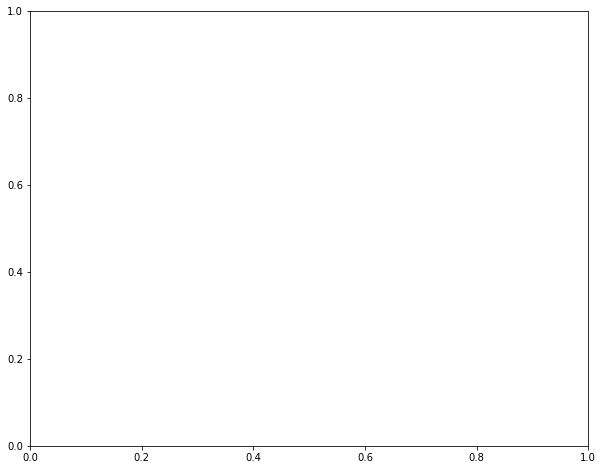

In [37]:
# ============================================
# LR scheduler with "Linear/Polynomial" LR decay
# (This schedule decays from lr_initial toward 0 using a power rule)
# ============================================

import numpy as np                          # Numerical computing
import imageio                              # Image/video I/O (NOT used here)
import torch                                # PyTorch tensors + NN
import torch.nn.functional as F             # NN functional ops (NOT used here)
import torch.utils.data as Data             # Data utilities (NOT used here)
from torch.autograd import Variable         # Legacy autograd wrapper (not needed, but kept)
import matplotlib.pyplot as plt             # Plotting
from torch.optim import SGD  # Optimizers (only SGD used)

%matplotlib inline
torch.manual_seed(1234)                     # Reproducible initialization


# --------------------------------------------
# Define a piecewise target function y = f(x)
# --------------------------------------------
def fun_x(x):
    if x < 0.0:
        return 5.0 + np.sin(x) + np.sin(2.0 * x) + np.sin(3.0 * x) + np.sin(4.0 * x)
    else:
        return np.cos(10.0 * x)


# --------------------------------------------
# Build training and test datasets
# --------------------------------------------
x_in_l = np.linspace(-np.pi, -1.0e-3, 201)
x_in_r = np.linspace(0.0, np.pi, 501)
x_in = np.concatenate((x_in_l, x_in_r), axis=0)
y_in = np.array([fun_x(i) for i in x_in])

x_test_l = np.linspace(-np.pi, -1.0e-3, 301)
x_test_r = np.linspace(0.0, np.pi, 501)
x_test_np = np.concatenate((x_test_l, x_test_r), axis=0)
y_test_np = np.array([fun_x(i) for i in x_test_np])

# Convert to torch tensors (shape: [N, 1])
x = torch.from_numpy(x_in.reshape(-1, 1)).float()
y = torch.from_numpy(y_in.reshape(-1, 1)).float()

x_test = torch.from_numpy(x_test_np.reshape(-1, 1)).float()
y_test = torch.from_numpy(y_test_np.reshape(-1, 1)).float()


# --------------------------------------------
# Polynomial (power) LR decay function
# lr(iter) = base_lr * (1 - iter/max_iter)^power
# Note: This is a "poly decay", not strictly linear unless power=1.
# --------------------------------------------
def lr_poly(base_lr, it, max_iter, power):
    return base_lr * ((1 - float(it) / max_iter) ** power)


lr_initial = 0.001         # Initial learning rate
Niter = 30000                 # Number of iterations (was Niter_Adam in your code)
power = 0.5                # Decay power exponent


# --------------------------------------------
# Model + loss + optimizer + scheduler
# --------------------------------------------
loss_function = torch.nn.MSELoss()

Net = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

# FIX: typo lr_intial -> lr_initial
optimizer = SGD(Net.parameters(), lr=lr_initial)

# Scheduler updates LR each iteration using lr_poly
# IMPORTANT: LambdaLR expects a *multiplier* by default, but we can also provide absolute LR
# by dividing by lr_initial to convert to multiplier:
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda it: lr_poly(lr_initial, it, Niter, power) / lr_initial
)


# --------------------------------------------
# Logs
# Store Python floats (via .item()) to avoid tensor/NumPy conversion issues later
# --------------------------------------------
train_loss_list = []
test_loss_list = []
acc_train = []
acc_test = []
lr_pow = []

# Variable(...) not needed, but kept to match your original style
x = Variable(x)
y = Variable(y)


# --------------------------------------------
# Training loop
# --------------------------------------------
print("SGD Optimization (Poly LR Decay)")

for it in range(Niter):
    # Forward pass
    y_pred = Net(x)

    # Training loss
    loss = loss_function(y_pred, y)

    # Backprop and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Step the scheduler AFTER optimizer step (common practice)
    scheduler.step()

    # Track current LR
    lr_pow.append(optimizer.param_groups[0]["lr"])

    # Evaluation (no gradient tracking)
    with torch.no_grad():
        y_train_pred = Net(x)
        y_test_pred = Net(x_test)

        test_loss = loss_function(y_test_pred, y_test)

        # Relative error metrics (your "accuracy" proxy)
        train_rel_err = torch.linalg.norm(y - y_train_pred) / torch.linalg.norm(y_train_pred)
        test_rel_err = torch.linalg.norm(y_test - y_test_pred) / torch.linalg.norm(y_test_pred)

        # Store floats
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
        acc_train.append(train_rel_err.item())
        acc_test.append(test_rel_err.item())

    if (it % 1000) == 0: 
        print(f"Epoch: {it + 1:02}/{Niter}  Loss: {loss.item():.5e}  LR: {lr_pow[-1]:.3e}")

train_loss_np_plr = np.array(train_loss_list)
test_loss_np_plr  = np.array(test_loss_list)
# --------------------------------------------
# Final predictions (NumPy) for plotting
# --------------------------------------------
with torch.no_grad():
    y_pow_lr = Net(x).detach().numpy()

# --------------------------------------------
# Plot Loss Curves (Constant LR vs Power LR)
# --------------------------------------------

fig, ax = plt.subplots(figsize=(15, 10))

# Iteration index (must match length of loss lists)
ep = np.arange(0, Niter, 1)

ax.set_xlabel('# Iterations', fontsize=32)
ax.set_ylabel('Loss (MSE)', fontsize=32)
ax.set_xlim(0, Niter + 2)

# Constant LR losses
ax.semilogy(ep, train_loss_np_clr, 'b--', lw=2, label="Constant LR - Train")
ax.semilogy(ep, test_loss_np_clr,  'g--', lw=2, label="Constant LR - Test")

# Power LR losses
ax.semilogy(ep, train_loss_np_plr, 'k--', lw=2, label="Power LR - Train")
ax.semilogy(ep, test_loss_np_plr,  'r--', lw=2, label="Power LR - Test")

plt.legend()
plt.show()

# --------------------------------------------
# Plot Learning Rate Schedule (Power LR)
# --------------------------------------------

fig, ax = plt.subplots(figsize=(12, 8))

# Iteration index (match length of lr_pow)
ep = np.arange(0, len(lr_pow), 1)

# Semilog plot of learning rate
ax.semilogy(ep, lr_pow, "-*r", label="Power LR")

ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Learning Rate", fontsize=18)
ax.set_title("Learning Rate Decay Schedule", fontsize=20)

ax.legend()
plt.show()


# 1-cycle learning rate scheduler for DNN with function approxiamtion


SGD Optimization with Cyclic LR
Epoch: 01/350  Loss: 6.23648e+00  LR: 4.00000e-04


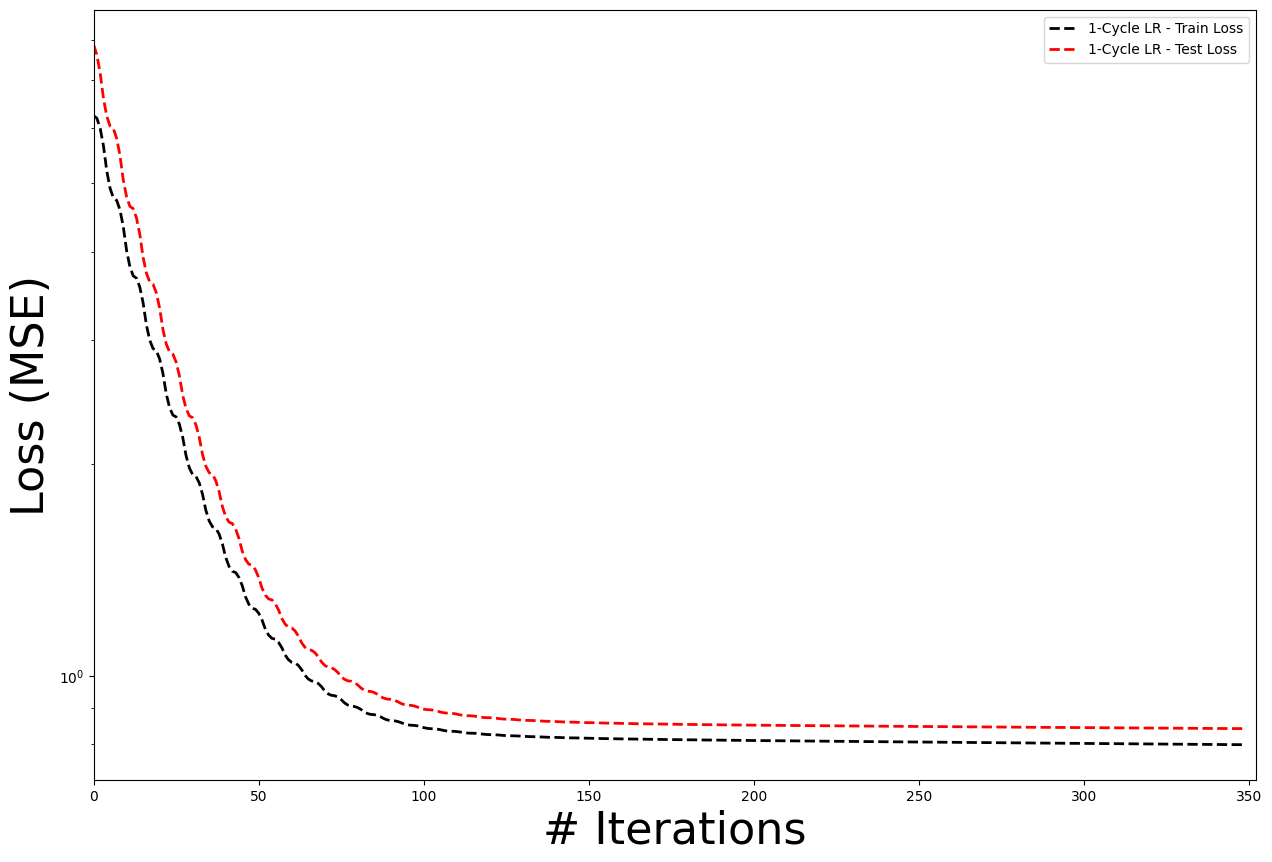

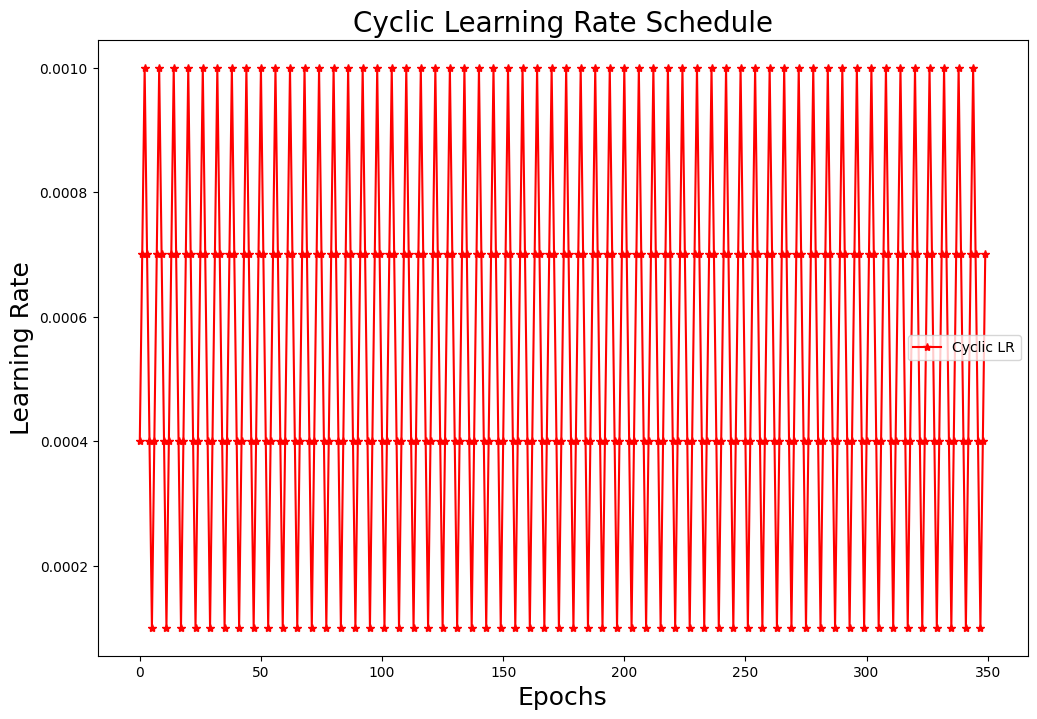

In [30]:
# ============================================
# LR Scheduler with Cyclic / 1-Cycle Style LR
# ============================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.autograd import Variable

%matplotlib inline
torch.manual_seed(1234)


# --------------------------------------------
# Define piecewise target function
# --------------------------------------------
def fun_x(x):
    if x < 0.0:
        return 5.0 + np.sin(x) + np.sin(2.0*x) + np.sin(3.0*x) + np.sin(4.0*x)
    else:
        return np.cos(10.0*x)


# --------------------------------------------
# Build training and test datasets
# --------------------------------------------
x_in_l = np.linspace(-np.pi, -1.0e-3, 201)
x_in_r = np.linspace(0.0, np.pi, 501)
x_in = np.concatenate((x_in_l, x_in_r))
y_in = np.array([fun_x(i) for i in x_in])

x_test_l = np.linspace(-np.pi, -1.0e-3, 301)
x_test_r = np.linspace(0.0, np.pi, 501)
x_test_np = np.concatenate((x_test_l, x_test_r))
y_test_np = np.array([fun_x(i) for i in x_test_np])

# Convert to tensors
x = torch.from_numpy(x_in.reshape(-1, 1)).float()
y = torch.from_numpy(y_in.reshape(-1, 1)).float()
x_test = torch.from_numpy(x_test_np.reshape(-1, 1)).float()
y_test = torch.from_numpy(y_test_np.reshape(-1, 1)).float()


# --------------------------------------------
# Model + Loss + Optimizer
# --------------------------------------------
lr_initial = 0.01
Niter = 350

loss_function = torch.nn.MSELoss()

Net = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

optimizer = SGD(Net.parameters(), lr=lr_initial)

# --------------------------------------------
# Cyclic Learning Rate Scheduler
# base_lr → minimum LR
# max_lr  → peak LR
# step_size_up → number of iterations to reach max_lr
# mode="triangular" → symmetric up-down LR cycle
# --------------------------------------------
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=0.0001,
    max_lr=0.001,
    step_size_up=3,
    mode="triangular",
    cycle_momentum=False  # important when using SGD without momentum
)


# --------------------------------------------
# Logging containers (store floats, not tensors)
# --------------------------------------------
train_loss_list = []
test_loss_list = []
acc_train = []
acc_test = []
lr_1cs = []

x = Variable(x)
y = Variable(y)


# --------------------------------------------
# Training loop
# --------------------------------------------
print("SGD Optimization with Cyclic LR")

for it in range(Niter):

    # Forward pass
    y_pred = Net(x)
    loss = loss_function(y_pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Step LR scheduler AFTER optimizer step
    scheduler.step()

    # Track current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_1cs.append(current_lr)

    # Evaluation
    with torch.no_grad():
        y_train_pred = Net(x)
        y_test_pred = Net(x_test)

        test_loss = loss_function(y_test_pred, y_test)

        train_rel_err = torch.linalg.norm(y - y_train_pred) / torch.linalg.norm(y_train_pred)
        test_rel_err = torch.linalg.norm(y_test - y_test_pred) / torch.linalg.norm(y_test_pred)

        # Store floats
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
        acc_train.append(train_rel_err.item())
        acc_test.append(test_rel_err.item())

    if (it %1000) == 0:
        print(f"Epoch: {it+1:02}/{Niter}  Loss: {loss.item():.5e}  LR: {current_lr:.5e}")


# --------------------------------------------
# Final predictions (NumPy)
# --------------------------------------------
with torch.no_grad():
    y_1cycle_lr = Net(x).detach().numpy()


# --------------------------------------------
# Plot Loss Curves (Cyclic / 1-Cycle LR)
# --------------------------------------------

fig, ax = plt.subplots(figsize=(15, 10))

# Use correct iteration variable
ep = np.arange(0, Niter, 1)

# Convert stored float lists directly to NumPy arrays
train_loss_np_1cs = np.array(train_loss_list)
test_loss_np_1cs  = np.array(test_loss_list)

ax.set_xlabel('# Iterations', fontsize=32)
ax.set_ylabel('Loss (MSE)', fontsize=32)
ax.set_xlim(0, Niter + 2)

# Semilog plot for better visualization
ax.semilogy(ep, train_loss_np_1cs, 'k--', lw=2,
            label="1-Cycle LR - Train Loss")

ax.semilogy(ep, test_loss_np_1cs, 'r--', lw=2,
            label="1-Cycle LR - Test Loss")

plt.legend()
plt.show()

# --------------------------------------------
# Plot Learning Rate Schedule (Cyclic LR)
# --------------------------------------------

fig, ax = plt.subplots(figsize=(12, 8))

# Make sure epoch axis matches lr history length
ep = np.arange(0, len(lr_1cs), 1)

ax.plot(ep, lr_1cs, "-*r", label="Cyclic LR")

ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Learning Rate", fontsize=18)
ax.set_title("Cyclic Learning Rate Schedule", fontsize=20)

ax.legend()
plt.show()

In [2]:
!pip install -q -U tensorflow_addons

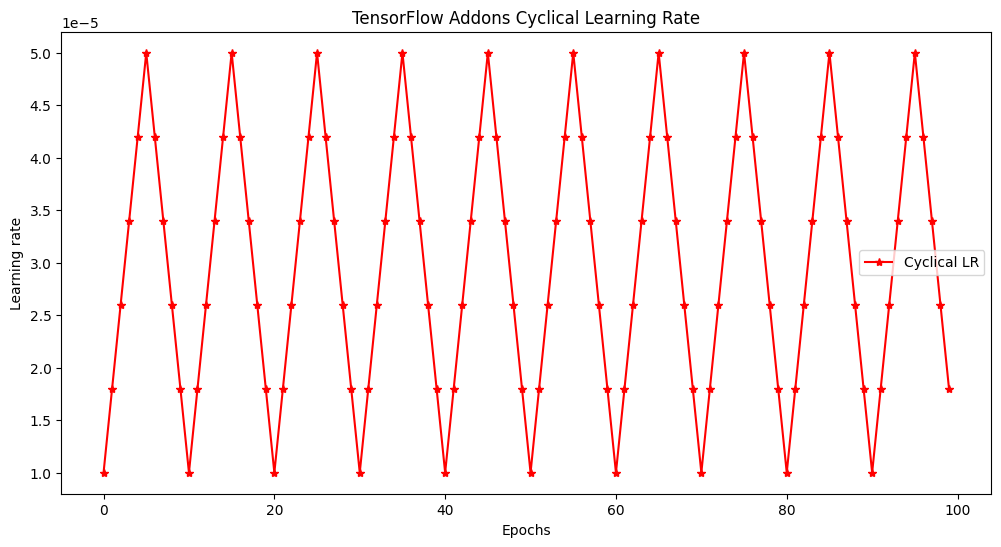

In [32]:
# --------------------------------------------
# Cyclical Learning Rate (CLR) using TensorFlow Addons
# --------------------------------------------

import tensorflow_addons as tfa          # Provides extra optimizers/schedulers not in core TF
import numpy as np                       # Numerical arrays
import matplotlib.pyplot as plt          # Plotting

# --------------------------------------------
# CLR hyperparameters
# --------------------------------------------
start_lr = 1e-5          # Starting learning rate (also used as the initial LR)
min_lr = 1e-5            # Minimum LR (declared but not used below; start_lr effectively acts as min here)
max_lr = 5e-5            # Maximum LR (peak of the cycle)
rampup_epochs = 5        # step_size controls how quickly LR moves through the cycle
Nepoch = 100             # Total epochs to visualize

# --------------------------------------------
# Create CLR schedule
# In TF Addons, step_size is measured in "iterations" (often batches),
# but here we pass epoch indices, so it behaves like an epoch-level cycle.
#
# scale_fn=lambda x: 1 makes cycle amplitude constant (no decay over time).
# --------------------------------------------
clr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=start_lr,
    maximal_learning_rate=max_lr,
    scale_fn=lambda x: 1,
    step_size=rampup_epochs
)

# --------------------------------------------
# Compute LR values over epochs for plotting
# Note: clr(ep) returns a Tensor; convert to NumPy for plotting.
# --------------------------------------------
ep = np.arange(0, Nepoch)                # Epoch indices: 0..Nepoch-1
lr = clr(ep).numpy()                     # Convert Tensor to NumPy array

# --------------------------------------------
# Plot learning rate schedule
# --------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(ep, lr, "-*r", label="Cyclical LR")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.title("TensorFlow Addons Cyclical Learning Rate")
plt.legend()
plt.show()

In [22]:
import tensorflow as tf
opt = tf.optimizers.Adam(learning_rate = clr)

# $L_2$-regularizer for DNN with function approxiamtion


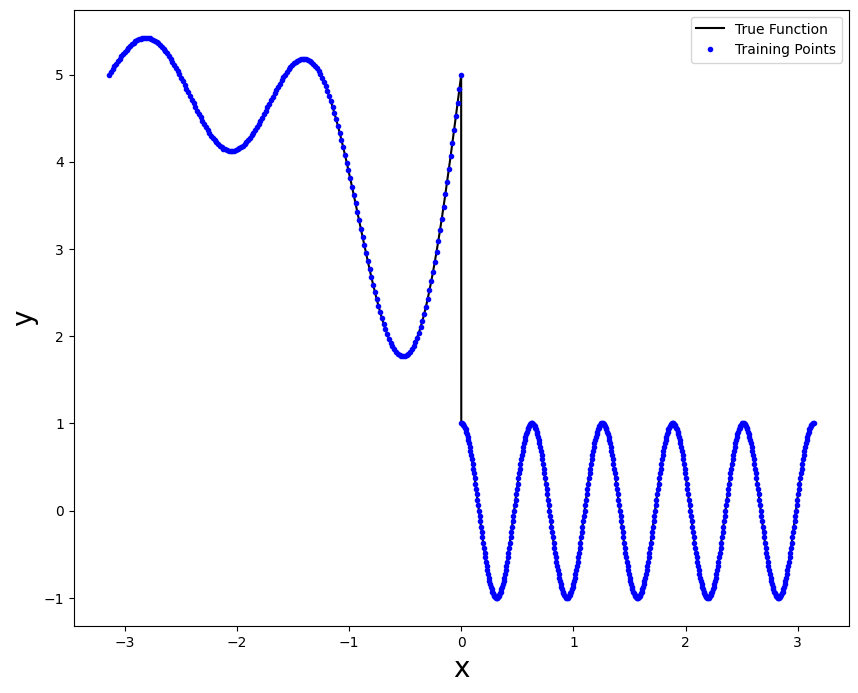

Adam Optimization (Constant LR)
Iter:      1/30000  TrainLoss: 6.236e+00  TestLoss: 6.058e+00
Iter:   1500/30000  TrainLoss: 2.693e-01  TestLoss: 2.512e-01
Iter:   3000/30000  TrainLoss: 2.417e-01  TestLoss: 2.221e-01
Iter:   4500/30000  TrainLoss: 2.349e-01  TestLoss: 2.143e-01
Iter:   6000/30000  TrainLoss: 2.308e-01  TestLoss: 2.098e-01
Iter:   7500/30000  TrainLoss: 2.210e-01  TestLoss: 2.006e-01
Iter:   9000/30000  TrainLoss: 1.978e-01  TestLoss: 1.800e-01
Iter:  10500/30000  TrainLoss: 1.815e-01  TestLoss: 1.653e-01
Iter:  12000/30000  TrainLoss: 1.698e-01  TestLoss: 1.555e-01
Iter:  13500/30000  TrainLoss: 1.725e-01  TestLoss: 1.581e-01
Iter:  15000/30000  TrainLoss: 1.628e-01  TestLoss: 1.435e-01
Iter:  16500/30000  TrainLoss: 1.468e-01  TestLoss: 1.341e-01
Iter:  18000/30000  TrainLoss: 1.424e-01  TestLoss: 1.299e-01
Iter:  19500/30000  TrainLoss: 1.384e-01  TestLoss: 1.263e-01
Iter:  21000/30000  TrainLoss: 1.355e-01  TestLoss: 1.237e-01
Iter:  22500/30000  TrainLoss: 1.400e-

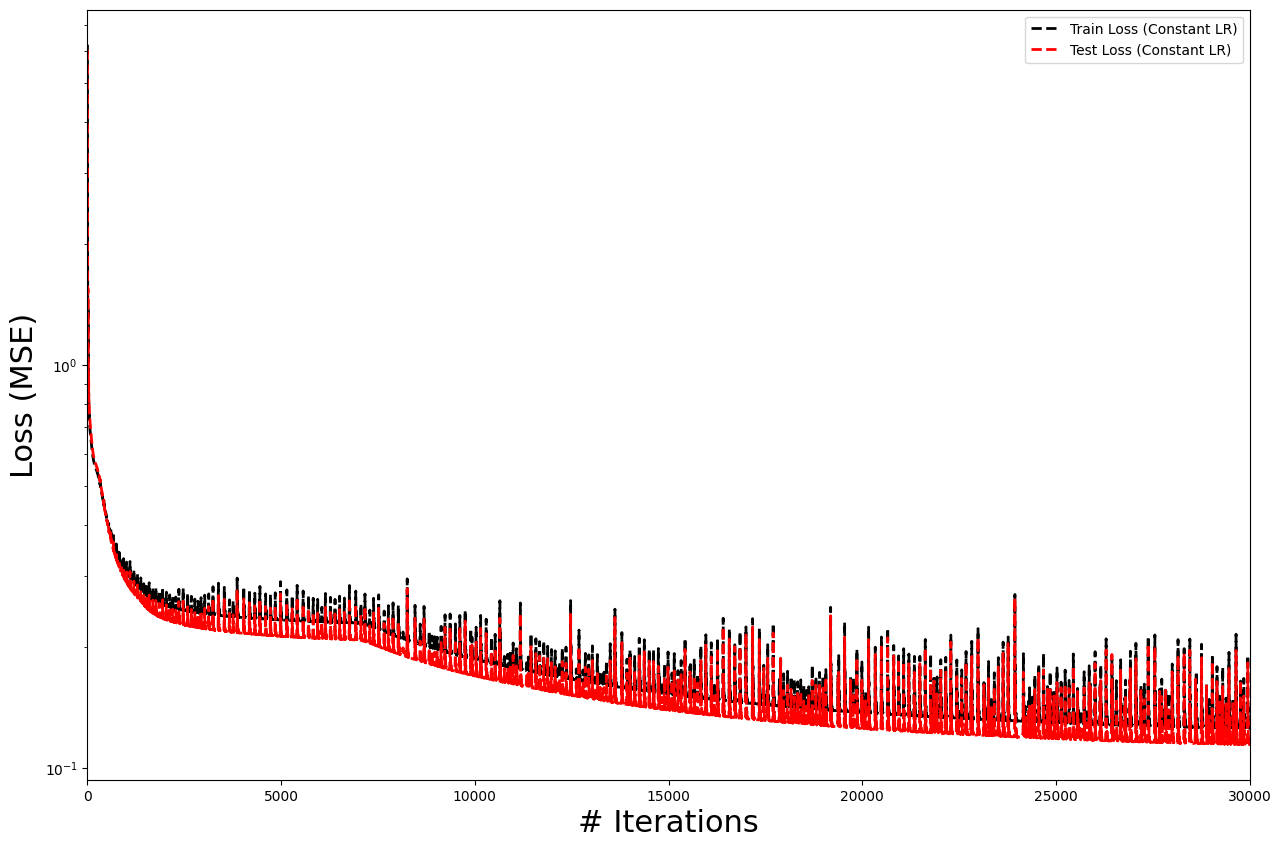

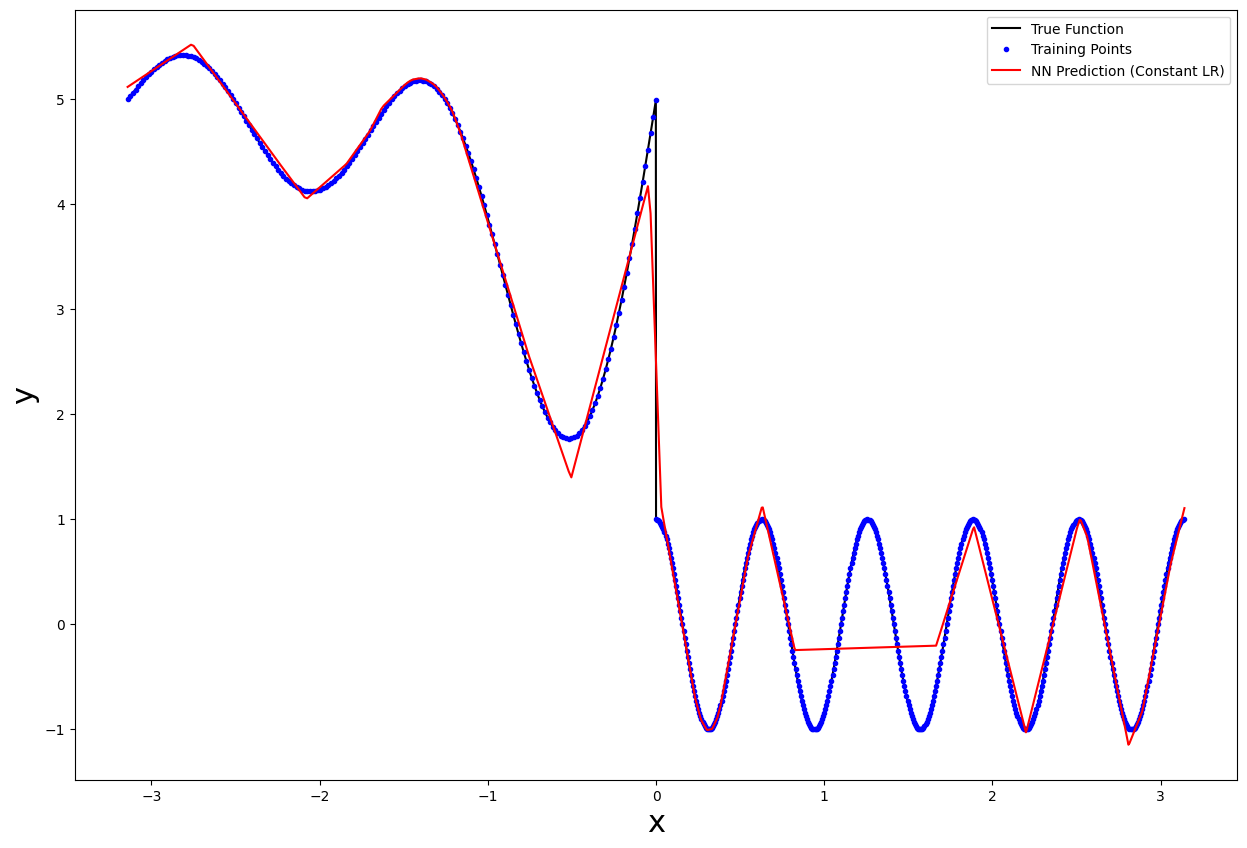

Epoch: 1269/30000 Loss: 2.98517e-01
Epoch: 1270/30000 Loss: 2.98614e-01
Epoch: 1271/30000 Loss: 2.98742e-01
Epoch: 1272/30000 Loss: 2.98893e-01
Epoch: 1273/30000 Loss: 2.99102e-01
Epoch: 1274/30000 Loss: 2.99352e-01
Epoch: 1275/30000 Loss: 2.99695e-01
Epoch: 1276/30000 Loss: 3.00117e-01
Epoch: 1277/30000 Loss: 3.00666e-01
Epoch: 1278/30000 Loss: 3.01293e-01
Epoch: 1279/30000 Loss: 3.02044e-01
Epoch: 1280/30000 Loss: 3.02797e-01
Epoch: 1281/30000 Loss: 3.03560e-01
Epoch: 1282/30000 Loss: 3.04159e-01
Epoch: 1283/30000 Loss: 3.04498e-01
Epoch: 1284/30000 Loss: 3.04363e-01
Epoch: 1285/30000 Loss: 3.03692e-01
Epoch: 1286/30000 Loss: 3.02406e-01
Epoch: 1287/30000 Loss: 3.00808e-01
Epoch: 1288/30000 Loss: 2.99171e-01
Epoch: 1289/30000 Loss: 2.97853e-01
Epoch: 1290/30000 Loss: 2.97007e-01
Epoch: 1291/30000 Loss: 2.96702e-01
Epoch: 1292/30000 Loss: 2.96844e-01
Epoch: 1293/30000 Loss: 2.97265e-01
Epoch: 1294/30000 Loss: 2.97797e-01
Epoch: 1295/30000 Loss: 2.98271e-01
Epoch: 1296/30000 Loss: 2.98

Epoch: 1618/30000 Loss: 2.85372e-01
Epoch: 1619/30000 Loss: 2.85257e-01
Epoch: 1620/30000 Loss: 2.85149e-01
Epoch: 1621/30000 Loss: 2.85062e-01
Epoch: 1622/30000 Loss: 2.84986e-01
Epoch: 1623/30000 Loss: 2.84923e-01
Epoch: 1624/30000 Loss: 2.84873e-01
Epoch: 1625/30000 Loss: 2.84833e-01
Epoch: 1626/30000 Loss: 2.84802e-01
Epoch: 1627/30000 Loss: 2.84775e-01
Epoch: 1628/30000 Loss: 2.84751e-01
Epoch: 1629/30000 Loss: 2.84730e-01
Epoch: 1630/30000 Loss: 2.84711e-01
Epoch: 1631/30000 Loss: 2.84695e-01
Epoch: 1632/30000 Loss: 2.84681e-01
Epoch: 1633/30000 Loss: 2.84670e-01
Epoch: 1634/30000 Loss: 2.84662e-01
Epoch: 1635/30000 Loss: 2.84658e-01
Epoch: 1636/30000 Loss: 2.84662e-01
Epoch: 1637/30000 Loss: 2.84675e-01
Epoch: 1638/30000 Loss: 2.84702e-01
Epoch: 1639/30000 Loss: 2.84749e-01
Epoch: 1640/30000 Loss: 2.84827e-01
Epoch: 1641/30000 Loss: 2.84951e-01
Epoch: 1642/30000 Loss: 2.85161e-01
Epoch: 1643/30000 Loss: 2.85481e-01
Epoch: 1644/30000 Loss: 2.85969e-01
Epoch: 1645/30000 Loss: 2.86

Epoch: 1965/30000 Loss: 2.86424e-01
Epoch: 1966/30000 Loss: 2.88745e-01
Epoch: 1967/30000 Loss: 2.87713e-01
Epoch: 1968/30000 Loss: 2.84183e-01
Epoch: 1969/30000 Loss: 2.80282e-01
Epoch: 1970/30000 Loss: 2.78221e-01
Epoch: 1971/30000 Loss: 2.78657e-01
Epoch: 1972/30000 Loss: 2.80645e-01
Epoch: 1973/30000 Loss: 2.82527e-01
Epoch: 1974/30000 Loss: 2.82978e-01
Epoch: 1975/30000 Loss: 2.81828e-01
Epoch: 1976/30000 Loss: 2.79900e-01
Epoch: 1977/30000 Loss: 2.78389e-01
Epoch: 1978/30000 Loss: 2.78033e-01
Epoch: 1979/30000 Loss: 2.78716e-01
Epoch: 1980/30000 Loss: 2.79718e-01
Epoch: 1981/30000 Loss: 2.80298e-01
Epoch: 1982/30000 Loss: 2.80119e-01
Epoch: 1983/30000 Loss: 2.79341e-01
Epoch: 1984/30000 Loss: 2.78477e-01
Epoch: 1985/30000 Loss: 2.77958e-01
Epoch: 1986/30000 Loss: 2.77961e-01
Epoch: 1987/30000 Loss: 2.78331e-01
Epoch: 1988/30000 Loss: 2.78747e-01
Epoch: 1989/30000 Loss: 2.78935e-01
Epoch: 1990/30000 Loss: 2.78805e-01
Epoch: 1991/30000 Loss: 2.78438e-01
Epoch: 1992/30000 Loss: 2.78

Epoch: 2315/30000 Loss: 2.73956e-01
Epoch: 2316/30000 Loss: 2.73949e-01
Epoch: 2317/30000 Loss: 2.73941e-01
Epoch: 2318/30000 Loss: 2.73935e-01
Epoch: 2319/30000 Loss: 2.73933e-01
Epoch: 2320/30000 Loss: 2.73934e-01
Epoch: 2321/30000 Loss: 2.73939e-01
Epoch: 2322/30000 Loss: 2.73947e-01
Epoch: 2323/30000 Loss: 2.73959e-01
Epoch: 2324/30000 Loss: 2.73979e-01
Epoch: 2325/30000 Loss: 2.74012e-01
Epoch: 2326/30000 Loss: 2.74059e-01
Epoch: 2327/30000 Loss: 2.74130e-01
Epoch: 2328/30000 Loss: 2.74226e-01
Epoch: 2329/30000 Loss: 2.74355e-01
Epoch: 2330/30000 Loss: 2.74528e-01
Epoch: 2331/30000 Loss: 2.74780e-01
Epoch: 2332/30000 Loss: 2.75126e-01
Epoch: 2333/30000 Loss: 2.75618e-01
Epoch: 2334/30000 Loss: 2.76296e-01
Epoch: 2335/30000 Loss: 2.77237e-01
Epoch: 2336/30000 Loss: 2.78506e-01
Epoch: 2337/30000 Loss: 2.80197e-01
Epoch: 2338/30000 Loss: 2.82369e-01
Epoch: 2339/30000 Loss: 2.85020e-01
Epoch: 2340/30000 Loss: 2.88070e-01
Epoch: 2341/30000 Loss: 2.91099e-01
Epoch: 2342/30000 Loss: 2.93

Epoch: 2646/30000 Loss: 2.71202e-01
Epoch: 2647/30000 Loss: 2.71155e-01
Epoch: 2648/30000 Loss: 2.71099e-01
Epoch: 2649/30000 Loss: 2.71064e-01
Epoch: 2650/30000 Loss: 2.71060e-01
Epoch: 2651/30000 Loss: 2.71076e-01
Epoch: 2652/30000 Loss: 2.71092e-01
Epoch: 2653/30000 Loss: 2.71090e-01
Epoch: 2654/30000 Loss: 2.71067e-01
Epoch: 2655/30000 Loss: 2.71034e-01
Epoch: 2656/30000 Loss: 2.71008e-01
Epoch: 2657/30000 Loss: 2.70996e-01
Epoch: 2658/30000 Loss: 2.70999e-01
Epoch: 2659/30000 Loss: 2.71006e-01
Epoch: 2660/30000 Loss: 2.71007e-01
Epoch: 2661/30000 Loss: 2.70997e-01
Epoch: 2662/30000 Loss: 2.70978e-01
Epoch: 2663/30000 Loss: 2.70957e-01
Epoch: 2664/30000 Loss: 2.70942e-01
Epoch: 2665/30000 Loss: 2.70936e-01
Epoch: 2666/30000 Loss: 2.70934e-01
Epoch: 2667/30000 Loss: 2.70934e-01
Epoch: 2668/30000 Loss: 2.70929e-01
Epoch: 2669/30000 Loss: 2.70920e-01
Epoch: 2670/30000 Loss: 2.70907e-01
Epoch: 2671/30000 Loss: 2.70894e-01
Epoch: 2672/30000 Loss: 2.70883e-01
Epoch: 2673/30000 Loss: 2.70

Epoch: 2988/30000 Loss: 2.68857e-01
Epoch: 2989/30000 Loss: 2.68856e-01
Epoch: 2990/30000 Loss: 2.68857e-01
Epoch: 2991/30000 Loss: 2.68859e-01
Epoch: 2992/30000 Loss: 2.68865e-01
Epoch: 2993/30000 Loss: 2.68875e-01
Epoch: 2994/30000 Loss: 2.68890e-01
Epoch: 2995/30000 Loss: 2.68913e-01
Epoch: 2996/30000 Loss: 2.68947e-01
Epoch: 2997/30000 Loss: 2.68997e-01
Epoch: 2998/30000 Loss: 2.69068e-01
Epoch: 2999/30000 Loss: 2.69166e-01
Epoch: 3000/30000 Loss: 2.69304e-01
Epoch: 3001/30000 Loss: 2.69500e-01
Epoch: 3002/30000 Loss: 2.69781e-01
Epoch: 3003/30000 Loss: 2.70191e-01
Epoch: 3004/30000 Loss: 2.70776e-01
Epoch: 3005/30000 Loss: 2.71625e-01
Epoch: 3006/30000 Loss: 2.72835e-01
Epoch: 3007/30000 Loss: 2.74572e-01
Epoch: 3008/30000 Loss: 2.77048e-01
Epoch: 3009/30000 Loss: 2.80472e-01
Epoch: 3010/30000 Loss: 2.84953e-01
Epoch: 3011/30000 Loss: 2.90414e-01
Epoch: 3012/30000 Loss: 2.96135e-01
Epoch: 3013/30000 Loss: 3.00770e-01
Epoch: 3014/30000 Loss: 3.02152e-01
Epoch: 3015/30000 Loss: 2.98

Epoch: 3322/30000 Loss: 2.67395e-01
Epoch: 3323/30000 Loss: 2.67169e-01
Epoch: 3324/30000 Loss: 2.67106e-01
Epoch: 3325/30000 Loss: 2.67211e-01
Epoch: 3326/30000 Loss: 2.67347e-01
Epoch: 3327/30000 Loss: 2.67377e-01
Epoch: 3328/30000 Loss: 2.67280e-01
Epoch: 3329/30000 Loss: 2.67142e-01
Epoch: 3330/30000 Loss: 2.67068e-01
Epoch: 3331/30000 Loss: 2.67091e-01
Epoch: 3332/30000 Loss: 2.67161e-01
Epoch: 3333/30000 Loss: 2.67204e-01
Epoch: 3334/30000 Loss: 2.67182e-01
Epoch: 3335/30000 Loss: 2.67118e-01
Epoch: 3336/30000 Loss: 2.67058e-01
Epoch: 3337/30000 Loss: 2.67037e-01
Epoch: 3338/30000 Loss: 2.67053e-01
Epoch: 3339/30000 Loss: 2.67081e-01
Epoch: 3340/30000 Loss: 2.67093e-01
Epoch: 3341/30000 Loss: 2.67079e-01
Epoch: 3342/30000 Loss: 2.67047e-01
Epoch: 3343/30000 Loss: 2.67016e-01
Epoch: 3344/30000 Loss: 2.67001e-01
Epoch: 3345/30000 Loss: 2.67003e-01
Epoch: 3346/30000 Loss: 2.67013e-01
Epoch: 3347/30000 Loss: 2.67019e-01
Epoch: 3348/30000 Loss: 2.67013e-01
Epoch: 3349/30000 Loss: 2.66

Epoch: 3648/30000 Loss: 2.68497e-01
Epoch: 3649/30000 Loss: 2.68218e-01
Epoch: 3650/30000 Loss: 2.67593e-01
Epoch: 3651/30000 Loss: 2.66848e-01
Epoch: 3652/30000 Loss: 2.66211e-01
Epoch: 3653/30000 Loss: 2.65836e-01
Epoch: 3654/30000 Loss: 2.65773e-01
Epoch: 3655/30000 Loss: 2.65973e-01
Epoch: 3656/30000 Loss: 2.66305e-01
Epoch: 3657/30000 Loss: 2.66612e-01
Epoch: 3658/30000 Loss: 2.66763e-01
Epoch: 3659/30000 Loss: 2.66697e-01
Epoch: 3660/30000 Loss: 2.66447e-01
Epoch: 3661/30000 Loss: 2.66109e-01
Epoch: 3662/30000 Loss: 2.65806e-01
Epoch: 3663/30000 Loss: 2.65622e-01
Epoch: 3664/30000 Loss: 2.65583e-01
Epoch: 3665/30000 Loss: 2.65656e-01
Epoch: 3666/30000 Loss: 2.65779e-01
Epoch: 3667/30000 Loss: 2.65892e-01
Epoch: 3668/30000 Loss: 2.65956e-01
Epoch: 3669/30000 Loss: 2.65960e-01
Epoch: 3670/30000 Loss: 2.65917e-01
Epoch: 3671/30000 Loss: 2.65845e-01
Epoch: 3672/30000 Loss: 2.65765e-01
Epoch: 3673/30000 Loss: 2.65686e-01
Epoch: 3674/30000 Loss: 2.65621e-01
Epoch: 3675/30000 Loss: 2.65

Epoch: 3983/30000 Loss: 2.65051e-01
Epoch: 3984/30000 Loss: 2.64779e-01
Epoch: 3985/30000 Loss: 2.64530e-01
Epoch: 3986/30000 Loss: 2.64391e-01
Epoch: 3987/30000 Loss: 2.64386e-01
Epoch: 3988/30000 Loss: 2.64478e-01
Epoch: 3989/30000 Loss: 2.64601e-01
Epoch: 3990/30000 Loss: 2.64694e-01
Epoch: 3991/30000 Loss: 2.64718e-01
Epoch: 3992/30000 Loss: 2.64671e-01
Epoch: 3993/30000 Loss: 2.64578e-01
Epoch: 3994/30000 Loss: 2.64474e-01
Epoch: 3995/30000 Loss: 2.64390e-01
Epoch: 3996/30000 Loss: 2.64345e-01
Epoch: 3997/30000 Loss: 2.64343e-01
Epoch: 3998/30000 Loss: 2.64370e-01
Epoch: 3999/30000 Loss: 2.64410e-01
Epoch: 4000/30000 Loss: 2.64446e-01
Epoch: 4001/30000 Loss: 2.64463e-01
Epoch: 4002/30000 Loss: 2.64457e-01
Epoch: 4003/30000 Loss: 2.64432e-01
Epoch: 4004/30000 Loss: 2.64394e-01
Epoch: 4005/30000 Loss: 2.64355e-01
Epoch: 4006/30000 Loss: 2.64322e-01
Epoch: 4007/30000 Loss: 2.64302e-01
Epoch: 4008/30000 Loss: 2.64296e-01
Epoch: 4009/30000 Loss: 2.64299e-01
Epoch: 4010/30000 Loss: 2.64

Epoch: 4327/30000 Loss: 2.86262e-01
Epoch: 4328/30000 Loss: 2.76186e-01
Epoch: 4329/30000 Loss: 2.67623e-01
Epoch: 4330/30000 Loss: 2.63547e-01
Epoch: 4331/30000 Loss: 2.64572e-01
Epoch: 4332/30000 Loss: 2.68853e-01
Epoch: 4333/30000 Loss: 2.73340e-01
Epoch: 4334/30000 Loss: 2.75499e-01
Epoch: 4335/30000 Loss: 2.74241e-01
Epoch: 4336/30000 Loss: 2.70417e-01
Epoch: 4337/30000 Loss: 2.66173e-01
Epoch: 4338/30000 Loss: 2.63593e-01
Epoch: 4339/30000 Loss: 2.63517e-01
Epoch: 4340/30000 Loss: 2.65275e-01
Epoch: 4341/30000 Loss: 2.67369e-01
Epoch: 4342/30000 Loss: 2.68427e-01
Epoch: 4343/30000 Loss: 2.67932e-01
Epoch: 4344/30000 Loss: 2.66302e-01
Epoch: 4345/30000 Loss: 2.64513e-01
Epoch: 4346/30000 Loss: 2.63443e-01
Epoch: 4347/30000 Loss: 2.63414e-01
Epoch: 4348/30000 Loss: 2.64137e-01
Epoch: 4349/30000 Loss: 2.65005e-01
Epoch: 4350/30000 Loss: 2.65471e-01
Epoch: 4351/30000 Loss: 2.65306e-01
Epoch: 4352/30000 Loss: 2.64659e-01
Epoch: 4353/30000 Loss: 2.63887e-01
Epoch: 4354/30000 Loss: 2.63

Epoch: 4663/30000 Loss: 2.62348e-01
Epoch: 4664/30000 Loss: 2.62355e-01
Epoch: 4665/30000 Loss: 2.62366e-01
Epoch: 4666/30000 Loss: 2.62380e-01
Epoch: 4667/30000 Loss: 2.62400e-01
Epoch: 4668/30000 Loss: 2.62426e-01
Epoch: 4669/30000 Loss: 2.62459e-01
Epoch: 4670/30000 Loss: 2.62501e-01
Epoch: 4671/30000 Loss: 2.62558e-01
Epoch: 4672/30000 Loss: 2.62632e-01
Epoch: 4673/30000 Loss: 2.62733e-01
Epoch: 4674/30000 Loss: 2.62866e-01
Epoch: 4675/30000 Loss: 2.63049e-01
Epoch: 4676/30000 Loss: 2.63299e-01
Epoch: 4677/30000 Loss: 2.63636e-01
Epoch: 4678/30000 Loss: 2.64099e-01
Epoch: 4679/30000 Loss: 2.64733e-01
Epoch: 4680/30000 Loss: 2.65603e-01
Epoch: 4681/30000 Loss: 2.66782e-01
Epoch: 4682/30000 Loss: 2.68363e-01
Epoch: 4683/30000 Loss: 2.70460e-01
Epoch: 4684/30000 Loss: 2.73072e-01
Epoch: 4685/30000 Loss: 2.76278e-01
Epoch: 4686/30000 Loss: 2.79822e-01
Epoch: 4687/30000 Loss: 2.83416e-01
Epoch: 4688/30000 Loss: 2.86231e-01
Epoch: 4689/30000 Loss: 2.87421e-01
Epoch: 4690/30000 Loss: 2.85

Epoch: 5003/30000 Loss: 2.61790e-01
Epoch: 5004/30000 Loss: 2.61917e-01
Epoch: 5005/30000 Loss: 2.62093e-01
Epoch: 5006/30000 Loss: 2.62338e-01
Epoch: 5007/30000 Loss: 2.62682e-01
Epoch: 5008/30000 Loss: 2.63166e-01
Epoch: 5009/30000 Loss: 2.63849e-01
Epoch: 5010/30000 Loss: 2.64821e-01
Epoch: 5011/30000 Loss: 2.66168e-01
Epoch: 5012/30000 Loss: 2.68039e-01
Epoch: 5013/30000 Loss: 2.70573e-01
Epoch: 5014/30000 Loss: 2.73916e-01
Epoch: 5015/30000 Loss: 2.78093e-01
Epoch: 5016/30000 Loss: 2.82944e-01
Epoch: 5017/30000 Loss: 2.87695e-01
Epoch: 5018/30000 Loss: 2.91389e-01
Epoch: 5019/30000 Loss: 2.92383e-01
Epoch: 5020/30000 Loss: 2.89658e-01
Epoch: 5021/30000 Loss: 2.82977e-01
Epoch: 5022/30000 Loss: 2.74287e-01
Epoch: 5023/30000 Loss: 2.66471e-01
Epoch: 5024/30000 Loss: 2.62031e-01
Epoch: 5025/30000 Loss: 2.61773e-01
Epoch: 5026/30000 Loss: 2.64657e-01
Epoch: 5027/30000 Loss: 2.68591e-01
Epoch: 5028/30000 Loss: 2.71435e-01
Epoch: 5029/30000 Loss: 2.71877e-01
Epoch: 5030/30000 Loss: 2.69

Epoch: 5332/30000 Loss: 2.62279e-01
Epoch: 5333/30000 Loss: 2.63079e-01
Epoch: 5334/30000 Loss: 2.63441e-01
Epoch: 5335/30000 Loss: 2.63268e-01
Epoch: 5336/30000 Loss: 2.62663e-01
Epoch: 5337/30000 Loss: 2.61876e-01
Epoch: 5338/30000 Loss: 2.61168e-01
Epoch: 5339/30000 Loss: 2.60733e-01
Epoch: 5340/30000 Loss: 2.60632e-01
Epoch: 5341/30000 Loss: 2.60801e-01
Epoch: 5342/30000 Loss: 2.61107e-01
Epoch: 5343/30000 Loss: 2.61404e-01
Epoch: 5344/30000 Loss: 2.61585e-01
Epoch: 5345/30000 Loss: 2.61609e-01
Epoch: 5346/30000 Loss: 2.61486e-01
Epoch: 5347/30000 Loss: 2.61270e-01
Epoch: 5348/30000 Loss: 2.61025e-01
Epoch: 5349/30000 Loss: 2.60810e-01
Epoch: 5350/30000 Loss: 2.60667e-01
Epoch: 5351/30000 Loss: 2.60609e-01
Epoch: 5352/30000 Loss: 2.60627e-01
Epoch: 5353/30000 Loss: 2.60696e-01
Epoch: 5354/30000 Loss: 2.60788e-01
Epoch: 5355/30000 Loss: 2.60871e-01
Epoch: 5356/30000 Loss: 2.60926e-01
Epoch: 5357/30000 Loss: 2.60941e-01
Epoch: 5358/30000 Loss: 2.60919e-01
Epoch: 5359/30000 Loss: 2.60

Epoch: 5671/30000 Loss: 2.77384e-01
Epoch: 5672/30000 Loss: 2.82942e-01
Epoch: 5673/30000 Loss: 2.88798e-01
Epoch: 5674/30000 Loss: 2.93766e-01
Epoch: 5675/30000 Loss: 2.95896e-01
Epoch: 5676/30000 Loss: 2.93551e-01
Epoch: 5677/30000 Loss: 2.86209e-01
Epoch: 5678/30000 Loss: 2.75837e-01
Epoch: 5679/30000 Loss: 2.66158e-01
Epoch: 5680/30000 Loss: 2.60654e-01
Epoch: 5681/30000 Loss: 2.60582e-01
Epoch: 5682/30000 Loss: 2.64491e-01
Epoch: 5683/30000 Loss: 2.69408e-01
Epoch: 5684/30000 Loss: 2.72436e-01
Epoch: 5685/30000 Loss: 2.72056e-01
Epoch: 5686/30000 Loss: 2.68606e-01
Epoch: 5687/30000 Loss: 2.64068e-01
Epoch: 5688/30000 Loss: 2.60750e-01
Epoch: 5689/30000 Loss: 2.59942e-01
Epoch: 5690/30000 Loss: 2.61370e-01
Epoch: 5691/30000 Loss: 2.63645e-01
Epoch: 5692/30000 Loss: 2.65230e-01
Epoch: 5693/30000 Loss: 2.65246e-01
Epoch: 5694/30000 Loss: 2.63815e-01
Epoch: 5695/30000 Loss: 2.61833e-01
Epoch: 5696/30000 Loss: 2.60335e-01
Epoch: 5697/30000 Loss: 2.59920e-01
Epoch: 5698/30000 Loss: 2.60

Epoch: 5997/30000 Loss: 2.70634e-01
Epoch: 5998/30000 Loss: 2.72314e-01
Epoch: 5999/30000 Loss: 2.70438e-01
Epoch: 6000/30000 Loss: 2.66181e-01
Epoch: 6001/30000 Loss: 2.61862e-01
Epoch: 6002/30000 Loss: 2.59524e-01
Epoch: 6003/30000 Loss: 2.59800e-01
Epoch: 6004/30000 Loss: 2.61824e-01
Epoch: 6005/30000 Loss: 2.63996e-01
Epoch: 6006/30000 Loss: 2.64964e-01
Epoch: 6007/30000 Loss: 2.64277e-01
Epoch: 6008/30000 Loss: 2.62433e-01
Epoch: 6009/30000 Loss: 2.60507e-01
Epoch: 6010/30000 Loss: 2.59424e-01
Epoch: 6011/30000 Loss: 2.59506e-01
Epoch: 6012/30000 Loss: 2.60388e-01
Epoch: 6013/30000 Loss: 2.61356e-01
Epoch: 6014/30000 Loss: 2.61826e-01
Epoch: 6015/30000 Loss: 2.61562e-01
Epoch: 6016/30000 Loss: 2.60789e-01
Epoch: 6017/30000 Loss: 2.59932e-01
Epoch: 6018/30000 Loss: 2.59397e-01
Epoch: 6019/30000 Loss: 2.59342e-01
Epoch: 6020/30000 Loss: 2.59658e-01
Epoch: 6021/30000 Loss: 2.60089e-01
Epoch: 6022/30000 Loss: 2.60366e-01
Epoch: 6023/30000 Loss: 2.60366e-01
Epoch: 6024/30000 Loss: 2.60

Epoch: 6326/30000 Loss: 2.58816e-01
Epoch: 6327/30000 Loss: 2.58803e-01
Epoch: 6328/30000 Loss: 2.58792e-01
Epoch: 6329/30000 Loss: 2.58786e-01
Epoch: 6330/30000 Loss: 2.58785e-01
Epoch: 6331/30000 Loss: 2.58787e-01
Epoch: 6332/30000 Loss: 2.58791e-01
Epoch: 6333/30000 Loss: 2.58794e-01
Epoch: 6334/30000 Loss: 2.58796e-01
Epoch: 6335/30000 Loss: 2.58795e-01
Epoch: 6336/30000 Loss: 2.58791e-01
Epoch: 6337/30000 Loss: 2.58785e-01
Epoch: 6338/30000 Loss: 2.58778e-01
Epoch: 6339/30000 Loss: 2.58772e-01
Epoch: 6340/30000 Loss: 2.58768e-01
Epoch: 6341/30000 Loss: 2.58767e-01
Epoch: 6342/30000 Loss: 2.58766e-01
Epoch: 6343/30000 Loss: 2.58766e-01
Epoch: 6344/30000 Loss: 2.58764e-01
Epoch: 6345/30000 Loss: 2.58763e-01
Epoch: 6346/30000 Loss: 2.58760e-01
Epoch: 6347/30000 Loss: 2.58758e-01
Epoch: 6348/30000 Loss: 2.58756e-01
Epoch: 6349/30000 Loss: 2.58753e-01
Epoch: 6350/30000 Loss: 2.58751e-01
Epoch: 6351/30000 Loss: 2.58749e-01
Epoch: 6352/30000 Loss: 2.58747e-01
Epoch: 6353/30000 Loss: 2.58

Epoch: 6650/30000 Loss: 2.46495e-01
Epoch: 6651/30000 Loss: 2.46521e-01
Epoch: 6652/30000 Loss: 2.46926e-01
Epoch: 6653/30000 Loss: 2.48153e-01
Epoch: 6654/30000 Loss: 2.50458e-01
Epoch: 6655/30000 Loss: 2.54245e-01
Epoch: 6656/30000 Loss: 2.58830e-01
Epoch: 6657/30000 Loss: 2.63278e-01
Epoch: 6658/30000 Loss: 2.65078e-01
Epoch: 6659/30000 Loss: 2.63658e-01
Epoch: 6660/30000 Loss: 2.60267e-01
Epoch: 6661/30000 Loss: 2.58205e-01
Epoch: 6662/30000 Loss: 2.58787e-01
Epoch: 6663/30000 Loss: 2.59937e-01
Epoch: 6664/30000 Loss: 2.58487e-01
Epoch: 6665/30000 Loss: 2.53413e-01
Epoch: 6666/30000 Loss: 2.46901e-01
Epoch: 6667/30000 Loss: 2.42485e-01
Epoch: 6668/30000 Loss: 2.42098e-01
Epoch: 6669/30000 Loss: 2.44799e-01
Epoch: 6670/30000 Loss: 2.47935e-01
Epoch: 6671/30000 Loss: 2.49111e-01
Epoch: 6672/30000 Loss: 2.47632e-01
Epoch: 6673/30000 Loss: 2.44602e-01
Epoch: 6674/30000 Loss: 2.41884e-01
Epoch: 6675/30000 Loss: 2.40750e-01
Epoch: 6676/30000 Loss: 2.41168e-01
Epoch: 6677/30000 Loss: 2.42

Epoch: 6974/30000 Loss: 2.13472e-01
Epoch: 6975/30000 Loss: 2.12891e-01
Epoch: 6976/30000 Loss: 2.12309e-01
Epoch: 6977/30000 Loss: 2.11834e-01
Epoch: 6978/30000 Loss: 2.11535e-01
Epoch: 6979/30000 Loss: 2.11427e-01
Epoch: 6980/30000 Loss: 2.11476e-01
Epoch: 6981/30000 Loss: 2.11623e-01
Epoch: 6982/30000 Loss: 2.11801e-01
Epoch: 6983/30000 Loss: 2.11954e-01
Epoch: 6984/30000 Loss: 2.12038e-01
Epoch: 6985/30000 Loss: 2.12042e-01
Epoch: 6986/30000 Loss: 2.11963e-01
Epoch: 6987/30000 Loss: 2.11826e-01
Epoch: 6988/30000 Loss: 2.11650e-01
Epoch: 6989/30000 Loss: 2.11466e-01
Epoch: 6990/30000 Loss: 2.11290e-01
Epoch: 6991/30000 Loss: 2.11136e-01
Epoch: 6992/30000 Loss: 2.11011e-01
Epoch: 6993/30000 Loss: 2.10914e-01
Epoch: 6994/30000 Loss: 2.10841e-01
Epoch: 6995/30000 Loss: 2.10791e-01
Epoch: 6996/30000 Loss: 2.10759e-01
Epoch: 6997/30000 Loss: 2.10740e-01
Epoch: 6998/30000 Loss: 2.10730e-01
Epoch: 6999/30000 Loss: 2.10727e-01
Epoch: 7000/30000 Loss: 2.10731e-01
Epoch: 7001/30000 Loss: 2.10

Epoch: 7305/30000 Loss: 1.97542e-01
Epoch: 7306/30000 Loss: 1.97498e-01
Epoch: 7307/30000 Loss: 1.97471e-01
Epoch: 7308/30000 Loss: 1.97452e-01
Epoch: 7309/30000 Loss: 1.97430e-01
Epoch: 7310/30000 Loss: 1.97401e-01
Epoch: 7311/30000 Loss: 1.97362e-01
Epoch: 7312/30000 Loss: 1.97317e-01
Epoch: 7313/30000 Loss: 1.97270e-01
Epoch: 7314/30000 Loss: 1.97226e-01
Epoch: 7315/30000 Loss: 1.97187e-01
Epoch: 7316/30000 Loss: 1.97153e-01
Epoch: 7317/30000 Loss: 1.97124e-01
Epoch: 7318/30000 Loss: 1.97097e-01
Epoch: 7319/30000 Loss: 1.97067e-01
Epoch: 7320/30000 Loss: 1.97033e-01
Epoch: 7321/30000 Loss: 1.96998e-01
Epoch: 7322/30000 Loss: 1.96960e-01
Epoch: 7323/30000 Loss: 1.96920e-01
Epoch: 7324/30000 Loss: 1.96880e-01
Epoch: 7325/30000 Loss: 1.96841e-01
Epoch: 7326/30000 Loss: 1.96807e-01
Epoch: 7327/30000 Loss: 1.96776e-01
Epoch: 7328/30000 Loss: 1.96748e-01
Epoch: 7329/30000 Loss: 1.96720e-01
Epoch: 7330/30000 Loss: 1.96693e-01
Epoch: 7331/30000 Loss: 1.96666e-01
Epoch: 7332/30000 Loss: 1.96

Epoch: 7637/30000 Loss: 1.89956e-01
Epoch: 7638/30000 Loss: 1.89414e-01
Epoch: 7639/30000 Loss: 1.88985e-01
Epoch: 7640/30000 Loss: 1.88685e-01
Epoch: 7641/30000 Loss: 1.88514e-01
Epoch: 7642/30000 Loss: 1.88440e-01
Epoch: 7643/30000 Loss: 1.88435e-01
Epoch: 7644/30000 Loss: 1.88474e-01
Epoch: 7645/30000 Loss: 1.88536e-01
Epoch: 7646/30000 Loss: 1.88605e-01
Epoch: 7647/30000 Loss: 1.88675e-01
Epoch: 7648/30000 Loss: 1.88749e-01
Epoch: 7649/30000 Loss: 1.88823e-01
Epoch: 7650/30000 Loss: 1.88900e-01
Epoch: 7651/30000 Loss: 1.88977e-01
Epoch: 7652/30000 Loss: 1.89059e-01
Epoch: 7653/30000 Loss: 1.89141e-01
Epoch: 7654/30000 Loss: 1.89233e-01
Epoch: 7655/30000 Loss: 1.89330e-01
Epoch: 7656/30000 Loss: 1.89445e-01
Epoch: 7657/30000 Loss: 1.89573e-01
Epoch: 7658/30000 Loss: 1.89731e-01
Epoch: 7659/30000 Loss: 1.89911e-01
Epoch: 7660/30000 Loss: 1.90144e-01
Epoch: 7661/30000 Loss: 1.90414e-01
Epoch: 7662/30000 Loss: 1.90738e-01
Epoch: 7663/30000 Loss: 1.91118e-01
Epoch: 7664/30000 Loss: 1.91

Epoch: 7959/30000 Loss: 1.82336e-01
Epoch: 7960/30000 Loss: 1.82346e-01
Epoch: 7961/30000 Loss: 1.82370e-01
Epoch: 7962/30000 Loss: 1.82406e-01
Epoch: 7963/30000 Loss: 1.82455e-01
Epoch: 7964/30000 Loss: 1.82519e-01
Epoch: 7965/30000 Loss: 1.82606e-01
Epoch: 7966/30000 Loss: 1.82716e-01
Epoch: 7967/30000 Loss: 1.82871e-01
Epoch: 7968/30000 Loss: 1.83076e-01
Epoch: 7969/30000 Loss: 1.83367e-01
Epoch: 7970/30000 Loss: 1.83759e-01
Epoch: 7971/30000 Loss: 1.84299e-01
Epoch: 7972/30000 Loss: 1.85029e-01
Epoch: 7973/30000 Loss: 1.86015e-01
Epoch: 7974/30000 Loss: 1.87295e-01
Epoch: 7975/30000 Loss: 1.88868e-01
Epoch: 7976/30000 Loss: 1.90725e-01
Epoch: 7977/30000 Loss: 1.92692e-01
Epoch: 7978/30000 Loss: 1.94521e-01
Epoch: 7979/30000 Loss: 1.95773e-01
Epoch: 7980/30000 Loss: 1.96062e-01
Epoch: 7981/30000 Loss: 1.95186e-01
Epoch: 7982/30000 Loss: 1.93459e-01
Epoch: 7983/30000 Loss: 1.91542e-01
Epoch: 7984/30000 Loss: 1.90175e-01
Epoch: 7985/30000 Loss: 1.89710e-01
Epoch: 7986/30000 Loss: 1.89

Epoch: 8288/30000 Loss: 1.77455e-01
Epoch: 8289/30000 Loss: 1.77912e-01
Epoch: 8290/30000 Loss: 1.78307e-01
Epoch: 8291/30000 Loss: 1.78400e-01
Epoch: 8292/30000 Loss: 1.78153e-01
Epoch: 8293/30000 Loss: 1.77700e-01
Epoch: 8294/30000 Loss: 1.77230e-01
Epoch: 8295/30000 Loss: 1.76921e-01
Epoch: 8296/30000 Loss: 1.76853e-01
Epoch: 8297/30000 Loss: 1.76990e-01
Epoch: 8298/30000 Loss: 1.77215e-01
Epoch: 8299/30000 Loss: 1.77404e-01
Epoch: 8300/30000 Loss: 1.77482e-01
Epoch: 8301/30000 Loss: 1.77418e-01
Epoch: 8302/30000 Loss: 1.77252e-01
Epoch: 8303/30000 Loss: 1.77042e-01
Epoch: 8304/30000 Loss: 1.76857e-01
Epoch: 8305/30000 Loss: 1.76740e-01
Epoch: 8306/30000 Loss: 1.76702e-01
Epoch: 8307/30000 Loss: 1.76728e-01
Epoch: 8308/30000 Loss: 1.76784e-01
Epoch: 8309/30000 Loss: 1.76840e-01
Epoch: 8310/30000 Loss: 1.76866e-01
Epoch: 8311/30000 Loss: 1.76850e-01
Epoch: 8312/30000 Loss: 1.76796e-01
Epoch: 8313/30000 Loss: 1.76721e-01
Epoch: 8314/30000 Loss: 1.76642e-01
Epoch: 8315/30000 Loss: 1.76

Epoch: 8613/30000 Loss: 1.72539e-01
Epoch: 8614/30000 Loss: 1.72546e-01
Epoch: 8615/30000 Loss: 1.72555e-01
Epoch: 8616/30000 Loss: 1.72565e-01
Epoch: 8617/30000 Loss: 1.72576e-01
Epoch: 8618/30000 Loss: 1.72590e-01
Epoch: 8619/30000 Loss: 1.72606e-01
Epoch: 8620/30000 Loss: 1.72630e-01
Epoch: 8621/30000 Loss: 1.72657e-01
Epoch: 8622/30000 Loss: 1.72692e-01
Epoch: 8623/30000 Loss: 1.72736e-01
Epoch: 8624/30000 Loss: 1.72796e-01
Epoch: 8625/30000 Loss: 1.72872e-01
Epoch: 8626/30000 Loss: 1.72969e-01
Epoch: 8627/30000 Loss: 1.73093e-01
Epoch: 8628/30000 Loss: 1.73256e-01
Epoch: 8629/30000 Loss: 1.73471e-01
Epoch: 8630/30000 Loss: 1.73768e-01
Epoch: 8631/30000 Loss: 1.74158e-01
Epoch: 8632/30000 Loss: 1.74697e-01
Epoch: 8633/30000 Loss: 1.75406e-01
Epoch: 8634/30000 Loss: 1.76358e-01
Epoch: 8635/30000 Loss: 1.77599e-01
Epoch: 8636/30000 Loss: 1.79240e-01
Epoch: 8637/30000 Loss: 1.81327e-01
Epoch: 8638/30000 Loss: 1.83924e-01
Epoch: 8639/30000 Loss: 1.87021e-01
Epoch: 8640/30000 Loss: 1.90

Epoch: 8929/30000 Loss: 1.68750e-01
Epoch: 8930/30000 Loss: 1.68802e-01
Epoch: 8931/30000 Loss: 1.68884e-01
Epoch: 8932/30000 Loss: 1.69008e-01
Epoch: 8933/30000 Loss: 1.69209e-01
Epoch: 8934/30000 Loss: 1.69512e-01
Epoch: 8935/30000 Loss: 1.69988e-01
Epoch: 8936/30000 Loss: 1.70708e-01
Epoch: 8937/30000 Loss: 1.71819e-01
Epoch: 8938/30000 Loss: 1.73492e-01
Epoch: 8939/30000 Loss: 1.76013e-01
Epoch: 8940/30000 Loss: 1.79710e-01
Epoch: 8941/30000 Loss: 1.84983e-01
Epoch: 8942/30000 Loss: 1.92129e-01
Epoch: 8943/30000 Loss: 2.00946e-01
Epoch: 8944/30000 Loss: 2.10276e-01
Epoch: 8945/30000 Loss: 2.17503e-01
Epoch: 8946/30000 Loss: 2.18894e-01
Epoch: 8947/30000 Loss: 2.11909e-01
Epoch: 8948/30000 Loss: 1.98164e-01
Epoch: 8949/30000 Loss: 1.83762e-01
Epoch: 8950/30000 Loss: 1.74912e-01
Epoch: 8951/30000 Loss: 1.73409e-01
Epoch: 8952/30000 Loss: 1.76684e-01
Epoch: 8953/30000 Loss: 1.80595e-01
Epoch: 8954/30000 Loss: 1.82206e-01
Epoch: 8955/30000 Loss: 1.81146e-01
Epoch: 8956/30000 Loss: 1.78

Epoch: 9247/30000 Loss: 1.65280e-01
Epoch: 9248/30000 Loss: 1.65320e-01
Epoch: 9249/30000 Loss: 1.65367e-01
Epoch: 9250/30000 Loss: 1.65396e-01
Epoch: 9251/30000 Loss: 1.65394e-01
Epoch: 9252/30000 Loss: 1.65359e-01
Epoch: 9253/30000 Loss: 1.65299e-01
Epoch: 9254/30000 Loss: 1.65230e-01
Epoch: 9255/30000 Loss: 1.65167e-01
Epoch: 9256/30000 Loss: 1.65122e-01
Epoch: 9257/30000 Loss: 1.65101e-01
Epoch: 9258/30000 Loss: 1.65101e-01
Epoch: 9259/30000 Loss: 1.65114e-01
Epoch: 9260/30000 Loss: 1.65129e-01
Epoch: 9261/30000 Loss: 1.65135e-01
Epoch: 9262/30000 Loss: 1.65128e-01
Epoch: 9263/30000 Loss: 1.65109e-01
Epoch: 9264/30000 Loss: 1.65079e-01
Epoch: 9265/30000 Loss: 1.65046e-01
Epoch: 9266/30000 Loss: 1.65014e-01
Epoch: 9267/30000 Loss: 1.64988e-01
Epoch: 9268/30000 Loss: 1.64970e-01
Epoch: 9269/30000 Loss: 1.64959e-01
Epoch: 9270/30000 Loss: 1.64956e-01
Epoch: 9271/30000 Loss: 1.64956e-01
Epoch: 9272/30000 Loss: 1.64958e-01
Epoch: 9273/30000 Loss: 1.64959e-01
Epoch: 9274/30000 Loss: 1.64

Epoch: 9586/30000 Loss: 1.78057e-01
Epoch: 9587/30000 Loss: 1.78317e-01
Epoch: 9588/30000 Loss: 1.77630e-01
Epoch: 9589/30000 Loss: 1.76018e-01
Epoch: 9590/30000 Loss: 1.73837e-01
Epoch: 9591/30000 Loss: 1.71539e-01
Epoch: 9592/30000 Loss: 1.69594e-01
Epoch: 9593/30000 Loss: 1.68290e-01
Epoch: 9594/30000 Loss: 1.67620e-01
Epoch: 9595/30000 Loss: 1.67355e-01
Epoch: 9596/30000 Loss: 1.67158e-01
Epoch: 9597/30000 Loss: 1.66774e-01
Epoch: 9598/30000 Loss: 1.66100e-01
Epoch: 9599/30000 Loss: 1.65217e-01
Epoch: 9600/30000 Loss: 1.64308e-01
Epoch: 9601/30000 Loss: 1.63563e-01
Epoch: 9602/30000 Loss: 1.63130e-01
Epoch: 9603/30000 Loss: 1.63038e-01
Epoch: 9604/30000 Loss: 1.63231e-01
Epoch: 9605/30000 Loss: 1.63583e-01
Epoch: 9606/30000 Loss: 1.63940e-01
Epoch: 9607/30000 Loss: 1.64159e-01
Epoch: 9608/30000 Loss: 1.64150e-01
Epoch: 9609/30000 Loss: 1.63891e-01
Epoch: 9610/30000 Loss: 1.63436e-01
Epoch: 9611/30000 Loss: 1.62885e-01
Epoch: 9612/30000 Loss: 1.62359e-01
Epoch: 9613/30000 Loss: 1.61

Epoch: 9911/30000 Loss: 1.61875e-01
Epoch: 9912/30000 Loss: 1.62032e-01
Epoch: 9913/30000 Loss: 1.62001e-01
Epoch: 9914/30000 Loss: 1.61786e-01
Epoch: 9915/30000 Loss: 1.61431e-01
Epoch: 9916/30000 Loss: 1.60978e-01
Epoch: 9917/30000 Loss: 1.60501e-01
Epoch: 9918/30000 Loss: 1.60045e-01
Epoch: 9919/30000 Loss: 1.59661e-01
Epoch: 9920/30000 Loss: 1.59368e-01
Epoch: 9921/30000 Loss: 1.59176e-01
Epoch: 9922/30000 Loss: 1.59071e-01
Epoch: 9923/30000 Loss: 1.59037e-01
Epoch: 9924/30000 Loss: 1.59049e-01
Epoch: 9925/30000 Loss: 1.59084e-01
Epoch: 9926/30000 Loss: 1.59125e-01
Epoch: 9927/30000 Loss: 1.59156e-01
Epoch: 9928/30000 Loss: 1.59173e-01
Epoch: 9929/30000 Loss: 1.59171e-01
Epoch: 9930/30000 Loss: 1.59152e-01
Epoch: 9931/30000 Loss: 1.59119e-01
Epoch: 9932/30000 Loss: 1.59078e-01
Epoch: 9933/30000 Loss: 1.59034e-01
Epoch: 9934/30000 Loss: 1.58993e-01
Epoch: 9935/30000 Loss: 1.58960e-01
Epoch: 9936/30000 Loss: 1.58942e-01
Epoch: 9937/30000 Loss: 1.58941e-01
Epoch: 9938/30000 Loss: 1.58

Epoch: 10195/30000 Loss: 1.58274e-01
Epoch: 10196/30000 Loss: 1.58173e-01
Epoch: 10197/30000 Loss: 1.57950e-01
Epoch: 10198/30000 Loss: 1.57653e-01
Epoch: 10199/30000 Loss: 1.57346e-01
Epoch: 10200/30000 Loss: 1.57075e-01
Epoch: 10201/30000 Loss: 1.56875e-01
Epoch: 10202/30000 Loss: 1.56750e-01
Epoch: 10203/30000 Loss: 1.56697e-01
Epoch: 10204/30000 Loss: 1.56692e-01
Epoch: 10205/30000 Loss: 1.56714e-01
Epoch: 10206/30000 Loss: 1.56744e-01
Epoch: 10207/30000 Loss: 1.56767e-01
Epoch: 10208/30000 Loss: 1.56777e-01
Epoch: 10209/30000 Loss: 1.56771e-01
Epoch: 10210/30000 Loss: 1.56752e-01
Epoch: 10211/30000 Loss: 1.56726e-01
Epoch: 10212/30000 Loss: 1.56702e-01
Epoch: 10213/30000 Loss: 1.56685e-01
Epoch: 10214/30000 Loss: 1.56678e-01
Epoch: 10215/30000 Loss: 1.56688e-01
Epoch: 10216/30000 Loss: 1.56710e-01
Epoch: 10217/30000 Loss: 1.56749e-01
Epoch: 10218/30000 Loss: 1.56798e-01
Epoch: 10219/30000 Loss: 1.56860e-01
Epoch: 10220/30000 Loss: 1.56930e-01
Epoch: 10221/30000 Loss: 1.57011e-01
E

Epoch: 10522/30000 Loss: 1.54137e-01
Epoch: 10523/30000 Loss: 1.54133e-01
Epoch: 10524/30000 Loss: 1.54134e-01
Epoch: 10525/30000 Loss: 1.54142e-01
Epoch: 10526/30000 Loss: 1.54156e-01
Epoch: 10527/30000 Loss: 1.54177e-01
Epoch: 10528/30000 Loss: 1.54203e-01
Epoch: 10529/30000 Loss: 1.54236e-01
Epoch: 10530/30000 Loss: 1.54276e-01
Epoch: 10531/30000 Loss: 1.54332e-01
Epoch: 10532/30000 Loss: 1.54404e-01
Epoch: 10533/30000 Loss: 1.54505e-01
Epoch: 10534/30000 Loss: 1.54637e-01
Epoch: 10535/30000 Loss: 1.54823e-01
Epoch: 10536/30000 Loss: 1.55066e-01
Epoch: 10537/30000 Loss: 1.55396e-01
Epoch: 10538/30000 Loss: 1.55840e-01
Epoch: 10539/30000 Loss: 1.56463e-01
Epoch: 10540/30000 Loss: 1.57306e-01
Epoch: 10541/30000 Loss: 1.58465e-01
Epoch: 10542/30000 Loss: 1.60000e-01
Epoch: 10543/30000 Loss: 1.62030e-01
Epoch: 10544/30000 Loss: 1.64583e-01
Epoch: 10545/30000 Loss: 1.67647e-01
Epoch: 10546/30000 Loss: 1.71034e-01
Epoch: 10547/30000 Loss: 1.74340e-01
Epoch: 10548/30000 Loss: 1.76899e-01
E

Epoch: 10850/30000 Loss: 1.52091e-01
Epoch: 10851/30000 Loss: 1.52156e-01
Epoch: 10852/30000 Loss: 1.52230e-01
Epoch: 10853/30000 Loss: 1.52280e-01
Epoch: 10854/30000 Loss: 1.52295e-01
Epoch: 10855/30000 Loss: 1.52257e-01
Epoch: 10856/30000 Loss: 1.52176e-01
Epoch: 10857/30000 Loss: 1.52064e-01
Epoch: 10858/30000 Loss: 1.51942e-01
Epoch: 10859/30000 Loss: 1.51824e-01
Epoch: 10860/30000 Loss: 1.51722e-01
Epoch: 10861/30000 Loss: 1.51645e-01
Epoch: 10862/30000 Loss: 1.51591e-01
Epoch: 10863/30000 Loss: 1.51560e-01
Epoch: 10864/30000 Loss: 1.51548e-01
Epoch: 10865/30000 Loss: 1.51552e-01
Epoch: 10866/30000 Loss: 1.51566e-01
Epoch: 10867/30000 Loss: 1.51587e-01
Epoch: 10868/30000 Loss: 1.51611e-01
Epoch: 10869/30000 Loss: 1.51636e-01
Epoch: 10870/30000 Loss: 1.51661e-01
Epoch: 10871/30000 Loss: 1.51686e-01
Epoch: 10872/30000 Loss: 1.51711e-01
Epoch: 10873/30000 Loss: 1.51737e-01
Epoch: 10874/30000 Loss: 1.51762e-01
Epoch: 10875/30000 Loss: 1.51790e-01
Epoch: 10876/30000 Loss: 1.51824e-01
E

Epoch: 11183/30000 Loss: 1.62266e-01
Epoch: 11184/30000 Loss: 1.68076e-01
Epoch: 11185/30000 Loss: 1.76048e-01
Epoch: 11186/30000 Loss: 1.86253e-01
Epoch: 11187/30000 Loss: 1.98107e-01
Epoch: 11188/30000 Loss: 2.09434e-01
Epoch: 11189/30000 Loss: 2.16162e-01
Epoch: 11190/30000 Loss: 2.13676e-01
Epoch: 11191/30000 Loss: 1.99839e-01
Epoch: 11192/30000 Loss: 1.78797e-01
Epoch: 11193/30000 Loss: 1.59432e-01
Epoch: 11194/30000 Loss: 1.50005e-01
Epoch: 11195/30000 Loss: 1.52502e-01
Epoch: 11196/30000 Loss: 1.62176e-01
Epoch: 11197/30000 Loss: 1.71327e-01
Epoch: 11198/30000 Loss: 1.73944e-01
Epoch: 11199/30000 Loss: 1.68648e-01
Epoch: 11200/30000 Loss: 1.59289e-01
Epoch: 11201/30000 Loss: 1.51738e-01
Epoch: 11202/30000 Loss: 1.49819e-01
Epoch: 11203/30000 Loss: 1.53054e-01
Epoch: 11204/30000 Loss: 1.57845e-01
Epoch: 11205/30000 Loss: 1.60393e-01
Epoch: 11206/30000 Loss: 1.59056e-01
Epoch: 11207/30000 Loss: 1.55065e-01
Epoch: 11208/30000 Loss: 1.51163e-01
Epoch: 11209/30000 Loss: 1.49574e-01
E

Epoch: 11512/30000 Loss: 1.48172e-01
Epoch: 11513/30000 Loss: 1.48362e-01
Epoch: 11514/30000 Loss: 1.48306e-01
Epoch: 11515/30000 Loss: 1.48051e-01
Epoch: 11516/30000 Loss: 1.47717e-01
Epoch: 11517/30000 Loss: 1.47427e-01
Epoch: 11518/30000 Loss: 1.47261e-01
Epoch: 11519/30000 Loss: 1.47236e-01
Epoch: 11520/30000 Loss: 1.47317e-01
Epoch: 11521/30000 Loss: 1.47436e-01
Epoch: 11522/30000 Loss: 1.47533e-01
Epoch: 11523/30000 Loss: 1.47562e-01
Epoch: 11524/30000 Loss: 1.47517e-01
Epoch: 11525/30000 Loss: 1.47423e-01
Epoch: 11526/30000 Loss: 1.47310e-01
Epoch: 11527/30000 Loss: 1.47214e-01
Epoch: 11528/30000 Loss: 1.47155e-01
Epoch: 11529/30000 Loss: 1.47139e-01
Epoch: 11530/30000 Loss: 1.47157e-01
Epoch: 11531/30000 Loss: 1.47194e-01
Epoch: 11532/30000 Loss: 1.47231e-01
Epoch: 11533/30000 Loss: 1.47255e-01
Epoch: 11534/30000 Loss: 1.47257e-01
Epoch: 11535/30000 Loss: 1.47238e-01
Epoch: 11536/30000 Loss: 1.47199e-01
Epoch: 11537/30000 Loss: 1.47148e-01
Epoch: 11538/30000 Loss: 1.47097e-01
E

Epoch: 11837/30000 Loss: 1.45509e-01
Epoch: 11838/30000 Loss: 1.45481e-01
Epoch: 11839/30000 Loss: 1.45505e-01
Epoch: 11840/30000 Loss: 1.45569e-01
Epoch: 11841/30000 Loss: 1.45669e-01
Epoch: 11842/30000 Loss: 1.45796e-01
Epoch: 11843/30000 Loss: 1.45953e-01
Epoch: 11844/30000 Loss: 1.46133e-01
Epoch: 11845/30000 Loss: 1.46349e-01
Epoch: 11846/30000 Loss: 1.46601e-01
Epoch: 11847/30000 Loss: 1.46912e-01
Epoch: 11848/30000 Loss: 1.47292e-01
Epoch: 11849/30000 Loss: 1.47774e-01
Epoch: 11850/30000 Loss: 1.48378e-01
Epoch: 11851/30000 Loss: 1.49148e-01
Epoch: 11852/30000 Loss: 1.50132e-01
Epoch: 11853/30000 Loss: 1.51374e-01
Epoch: 11854/30000 Loss: 1.52922e-01
Epoch: 11855/30000 Loss: 1.54801e-01
Epoch: 11856/30000 Loss: 1.56989e-01
Epoch: 11857/30000 Loss: 1.59452e-01
Epoch: 11858/30000 Loss: 1.62022e-01
Epoch: 11859/30000 Loss: 1.64442e-01
Epoch: 11860/30000 Loss: 1.66407e-01
Epoch: 11861/30000 Loss: 1.67658e-01
Epoch: 11862/30000 Loss: 1.68015e-01
Epoch: 11863/30000 Loss: 1.67578e-01
E

Epoch: 12166/30000 Loss: 1.43802e-01
Epoch: 12167/30000 Loss: 1.43999e-01
Epoch: 12168/30000 Loss: 1.44122e-01
Epoch: 12169/30000 Loss: 1.44124e-01
Epoch: 12170/30000 Loss: 1.44009e-01
Epoch: 12171/30000 Loss: 1.43828e-01
Epoch: 12172/30000 Loss: 1.43633e-01
Epoch: 12173/30000 Loss: 1.43480e-01
Epoch: 12174/30000 Loss: 1.43396e-01
Epoch: 12175/30000 Loss: 1.43387e-01
Epoch: 12176/30000 Loss: 1.43433e-01
Epoch: 12177/30000 Loss: 1.43505e-01
Epoch: 12178/30000 Loss: 1.43571e-01
Epoch: 12179/30000 Loss: 1.43611e-01
Epoch: 12180/30000 Loss: 1.43617e-01
Epoch: 12181/30000 Loss: 1.43590e-01
Epoch: 12182/30000 Loss: 1.43533e-01
Epoch: 12183/30000 Loss: 1.43471e-01
Epoch: 12184/30000 Loss: 1.43419e-01
Epoch: 12185/30000 Loss: 1.43392e-01
Epoch: 12186/30000 Loss: 1.43413e-01
Epoch: 12187/30000 Loss: 1.43528e-01
Epoch: 12188/30000 Loss: 1.43862e-01
Epoch: 12189/30000 Loss: 1.44609e-01
Epoch: 12190/30000 Loss: 1.46035e-01
Epoch: 12191/30000 Loss: 1.48172e-01
Epoch: 12192/30000 Loss: 1.50841e-01
E

Epoch: 12490/30000 Loss: 1.48678e-01
Epoch: 12491/30000 Loss: 1.50024e-01
Epoch: 12492/30000 Loss: 1.51478e-01
Epoch: 12493/30000 Loss: 1.53054e-01
Epoch: 12494/30000 Loss: 1.54685e-01
Epoch: 12495/30000 Loss: 1.56337e-01
Epoch: 12496/30000 Loss: 1.57941e-01
Epoch: 12497/30000 Loss: 1.59415e-01
Epoch: 12498/30000 Loss: 1.60624e-01
Epoch: 12499/30000 Loss: 1.61369e-01
Epoch: 12500/30000 Loss: 1.61366e-01
Epoch: 12501/30000 Loss: 1.60312e-01
Epoch: 12502/30000 Loss: 1.58003e-01
Epoch: 12503/30000 Loss: 1.54566e-01
Epoch: 12504/30000 Loss: 1.50510e-01
Epoch: 12505/30000 Loss: 1.46591e-01
Epoch: 12506/30000 Loss: 1.43602e-01
Epoch: 12507/30000 Loss: 1.41999e-01
Epoch: 12508/30000 Loss: 1.41833e-01
Epoch: 12509/30000 Loss: 1.42768e-01
Epoch: 12510/30000 Loss: 1.44256e-01
Epoch: 12511/30000 Loss: 1.45739e-01
Epoch: 12512/30000 Loss: 1.46767e-01
Epoch: 12513/30000 Loss: 1.47123e-01
Epoch: 12514/30000 Loss: 1.46771e-01
Epoch: 12515/30000 Loss: 1.45896e-01
Epoch: 12516/30000 Loss: 1.44775e-01
E

Epoch: 12832/30000 Loss: 1.41077e-01
Epoch: 12833/30000 Loss: 1.40876e-01
Epoch: 12834/30000 Loss: 1.40675e-01
Epoch: 12835/30000 Loss: 1.40520e-01
Epoch: 12836/30000 Loss: 1.40437e-01
Epoch: 12837/30000 Loss: 1.40421e-01
Epoch: 12838/30000 Loss: 1.40456e-01
Epoch: 12839/30000 Loss: 1.40511e-01
Epoch: 12840/30000 Loss: 1.40555e-01
Epoch: 12841/30000 Loss: 1.40572e-01
Epoch: 12842/30000 Loss: 1.40553e-01
Epoch: 12843/30000 Loss: 1.40503e-01
Epoch: 12844/30000 Loss: 1.40432e-01
Epoch: 12845/30000 Loss: 1.40352e-01
Epoch: 12846/30000 Loss: 1.40278e-01
Epoch: 12847/30000 Loss: 1.40219e-01
Epoch: 12848/30000 Loss: 1.40180e-01
Epoch: 12849/30000 Loss: 1.40162e-01
Epoch: 12850/30000 Loss: 1.40161e-01
Epoch: 12851/30000 Loss: 1.40172e-01
Epoch: 12852/30000 Loss: 1.40189e-01
Epoch: 12853/30000 Loss: 1.40207e-01
Epoch: 12854/30000 Loss: 1.40220e-01
Epoch: 12855/30000 Loss: 1.40229e-01
Epoch: 12856/30000 Loss: 1.40232e-01
Epoch: 12857/30000 Loss: 1.40229e-01
Epoch: 12858/30000 Loss: 1.40222e-01
E

Epoch: 13151/30000 Loss: 1.39093e-01
Epoch: 13152/30000 Loss: 1.39139e-01
Epoch: 13153/30000 Loss: 1.39203e-01
Epoch: 13154/30000 Loss: 1.39298e-01
Epoch: 13155/30000 Loss: 1.39431e-01
Epoch: 13156/30000 Loss: 1.39626e-01
Epoch: 13157/30000 Loss: 1.39902e-01
Epoch: 13158/30000 Loss: 1.40308e-01
Epoch: 13159/30000 Loss: 1.40888e-01
Epoch: 13160/30000 Loss: 1.41737e-01
Epoch: 13161/30000 Loss: 1.42955e-01
Epoch: 13162/30000 Loss: 1.44709e-01
Epoch: 13163/30000 Loss: 1.47179e-01
Epoch: 13164/30000 Loss: 1.50590e-01
Epoch: 13165/30000 Loss: 1.55133e-01
Epoch: 13166/30000 Loss: 1.60871e-01
Epoch: 13167/30000 Loss: 1.67563e-01
Epoch: 13168/30000 Loss: 1.74782e-01
Epoch: 13169/30000 Loss: 1.81778e-01
Epoch: 13170/30000 Loss: 1.88027e-01
Epoch: 13171/30000 Loss: 1.93195e-01
Epoch: 13172/30000 Loss: 1.96766e-01
Epoch: 13173/30000 Loss: 1.96540e-01
Epoch: 13174/30000 Loss: 1.89759e-01
Epoch: 13175/30000 Loss: 1.75173e-01
Epoch: 13176/30000 Loss: 1.57588e-01
Epoch: 13177/30000 Loss: 1.45268e-01
E

Epoch: 13468/30000 Loss: 1.38764e-01
Epoch: 13469/30000 Loss: 1.38216e-01
Epoch: 13470/30000 Loss: 1.37861e-01
Epoch: 13471/30000 Loss: 1.37723e-01
Epoch: 13472/30000 Loss: 1.37772e-01
Epoch: 13473/30000 Loss: 1.37947e-01
Epoch: 13474/30000 Loss: 1.38174e-01
Epoch: 13475/30000 Loss: 1.38389e-01
Epoch: 13476/30000 Loss: 1.38547e-01
Epoch: 13477/30000 Loss: 1.38623e-01
Epoch: 13478/30000 Loss: 1.38613e-01
Epoch: 13479/30000 Loss: 1.38529e-01
Epoch: 13480/30000 Loss: 1.38396e-01
Epoch: 13481/30000 Loss: 1.38238e-01
Epoch: 13482/30000 Loss: 1.38077e-01
Epoch: 13483/30000 Loss: 1.37932e-01
Epoch: 13484/30000 Loss: 1.37816e-01
Epoch: 13485/30000 Loss: 1.37735e-01
Epoch: 13486/30000 Loss: 1.37687e-01
Epoch: 13487/30000 Loss: 1.37670e-01
Epoch: 13488/30000 Loss: 1.37676e-01
Epoch: 13489/30000 Loss: 1.37698e-01
Epoch: 13490/30000 Loss: 1.37728e-01
Epoch: 13491/30000 Loss: 1.37763e-01
Epoch: 13492/30000 Loss: 1.37798e-01
Epoch: 13493/30000 Loss: 1.37831e-01
Epoch: 13494/30000 Loss: 1.37861e-01
E

Epoch: 13803/30000 Loss: 1.36970e-01
Epoch: 13804/30000 Loss: 1.37029e-01
Epoch: 13805/30000 Loss: 1.37096e-01
Epoch: 13806/30000 Loss: 1.37181e-01
Epoch: 13807/30000 Loss: 1.37282e-01
Epoch: 13808/30000 Loss: 1.37413e-01
Epoch: 13809/30000 Loss: 1.37570e-01
Epoch: 13810/30000 Loss: 1.37764e-01
Epoch: 13811/30000 Loss: 1.38006e-01
Epoch: 13812/30000 Loss: 1.38330e-01
Epoch: 13813/30000 Loss: 1.38738e-01
Epoch: 13814/30000 Loss: 1.39275e-01
Epoch: 13815/30000 Loss: 1.39953e-01
Epoch: 13816/30000 Loss: 1.40828e-01
Epoch: 13817/30000 Loss: 1.41921e-01
Epoch: 13818/30000 Loss: 1.43305e-01
Epoch: 13819/30000 Loss: 1.44999e-01
Epoch: 13820/30000 Loss: 1.47079e-01
Epoch: 13821/30000 Loss: 1.49525e-01
Epoch: 13822/30000 Loss: 1.52339e-01
Epoch: 13823/30000 Loss: 1.55351e-01
Epoch: 13824/30000 Loss: 1.58325e-01
Epoch: 13825/30000 Loss: 1.60859e-01
Epoch: 13826/30000 Loss: 1.62454e-01
Epoch: 13827/30000 Loss: 1.62593e-01
Epoch: 13828/30000 Loss: 1.60904e-01
Epoch: 13829/30000 Loss: 1.57391e-01
E

Epoch: 14133/30000 Loss: 1.35745e-01
Epoch: 14134/30000 Loss: 1.35798e-01
Epoch: 14135/30000 Loss: 1.35870e-01
Epoch: 14136/30000 Loss: 1.35964e-01
Epoch: 14137/30000 Loss: 1.36089e-01
Epoch: 14138/30000 Loss: 1.36264e-01
Epoch: 14139/30000 Loss: 1.36501e-01
Epoch: 14140/30000 Loss: 1.36829e-01
Epoch: 14141/30000 Loss: 1.37280e-01
Epoch: 14142/30000 Loss: 1.37904e-01
Epoch: 14143/30000 Loss: 1.38759e-01
Epoch: 14144/30000 Loss: 1.39937e-01
Epoch: 14145/30000 Loss: 1.41535e-01
Epoch: 14146/30000 Loss: 1.43681e-01
Epoch: 14147/30000 Loss: 1.46514e-01
Epoch: 14148/30000 Loss: 1.50128e-01
Epoch: 14149/30000 Loss: 1.54555e-01
Epoch: 14150/30000 Loss: 1.59535e-01
Epoch: 14151/30000 Loss: 1.64546e-01
Epoch: 14152/30000 Loss: 1.68485e-01
Epoch: 14153/30000 Loss: 1.70117e-01
Epoch: 14154/30000 Loss: 1.68195e-01
Epoch: 14155/30000 Loss: 1.62573e-01
Epoch: 14156/30000 Loss: 1.54391e-01
Epoch: 14157/30000 Loss: 1.46161e-01
Epoch: 14158/30000 Loss: 1.40328e-01
Epoch: 14159/30000 Loss: 1.38196e-01
E

Epoch: 14461/30000 Loss: 1.34604e-01
Epoch: 14462/30000 Loss: 1.34601e-01
Epoch: 14463/30000 Loss: 1.34598e-01
Epoch: 14464/30000 Loss: 1.34597e-01
Epoch: 14465/30000 Loss: 1.34595e-01
Epoch: 14466/30000 Loss: 1.34593e-01
Epoch: 14467/30000 Loss: 1.34592e-01
Epoch: 14468/30000 Loss: 1.34592e-01
Epoch: 14469/30000 Loss: 1.34593e-01
Epoch: 14470/30000 Loss: 1.34597e-01
Epoch: 14471/30000 Loss: 1.34604e-01
Epoch: 14472/30000 Loss: 1.34614e-01
Epoch: 14473/30000 Loss: 1.34631e-01
Epoch: 14474/30000 Loss: 1.34656e-01
Epoch: 14475/30000 Loss: 1.34693e-01
Epoch: 14476/30000 Loss: 1.34747e-01
Epoch: 14477/30000 Loss: 1.34828e-01
Epoch: 14478/30000 Loss: 1.34948e-01
Epoch: 14479/30000 Loss: 1.35126e-01
Epoch: 14480/30000 Loss: 1.35389e-01
Epoch: 14481/30000 Loss: 1.35785e-01
Epoch: 14482/30000 Loss: 1.36392e-01
Epoch: 14483/30000 Loss: 1.37309e-01
Epoch: 14484/30000 Loss: 1.38702e-01
Epoch: 14485/30000 Loss: 1.40809e-01
Epoch: 14486/30000 Loss: 1.43971e-01
Epoch: 14487/30000 Loss: 1.48671e-01
E

Epoch: 14798/30000 Loss: 1.33954e-01
Epoch: 14799/30000 Loss: 1.33776e-01
Epoch: 14800/30000 Loss: 1.33785e-01
Epoch: 14801/30000 Loss: 1.33926e-01
Epoch: 14802/30000 Loss: 1.34124e-01
Epoch: 14803/30000 Loss: 1.34299e-01
Epoch: 14804/30000 Loss: 1.34399e-01
Epoch: 14805/30000 Loss: 1.34401e-01
Epoch: 14806/30000 Loss: 1.34313e-01
Epoch: 14807/30000 Loss: 1.34167e-01
Epoch: 14808/30000 Loss: 1.34004e-01
Epoch: 14809/30000 Loss: 1.33860e-01
Epoch: 14810/30000 Loss: 1.33759e-01
Epoch: 14811/30000 Loss: 1.33712e-01
Epoch: 14812/30000 Loss: 1.33714e-01
Epoch: 14813/30000 Loss: 1.33749e-01
Epoch: 14814/30000 Loss: 1.33801e-01
Epoch: 14815/30000 Loss: 1.33852e-01
Epoch: 14816/30000 Loss: 1.33890e-01
Epoch: 14817/30000 Loss: 1.33909e-01
Epoch: 14818/30000 Loss: 1.33908e-01
Epoch: 14819/30000 Loss: 1.33889e-01
Epoch: 14820/30000 Loss: 1.33858e-01
Epoch: 14821/30000 Loss: 1.33821e-01
Epoch: 14822/30000 Loss: 1.33784e-01
Epoch: 14823/30000 Loss: 1.33751e-01
Epoch: 14824/30000 Loss: 1.33725e-01
E

Epoch: 15125/30000 Loss: 1.33507e-01
Epoch: 15126/30000 Loss: 1.33398e-01
Epoch: 15127/30000 Loss: 1.33370e-01
Epoch: 15128/30000 Loss: 1.33364e-01
Epoch: 15129/30000 Loss: 1.33336e-01
Epoch: 15130/30000 Loss: 1.33271e-01
Epoch: 15131/30000 Loss: 1.33176e-01
Epoch: 15132/30000 Loss: 1.33082e-01
Epoch: 15133/30000 Loss: 1.33015e-01
Epoch: 15134/30000 Loss: 1.32993e-01
Epoch: 15135/30000 Loss: 1.33020e-01
Epoch: 15136/30000 Loss: 1.33080e-01
Epoch: 15137/30000 Loss: 1.33153e-01
Epoch: 15138/30000 Loss: 1.33217e-01
Epoch: 15139/30000 Loss: 1.33261e-01
Epoch: 15140/30000 Loss: 1.33283e-01
Epoch: 15141/30000 Loss: 1.33284e-01
Epoch: 15142/30000 Loss: 1.33274e-01
Epoch: 15143/30000 Loss: 1.33261e-01
Epoch: 15144/30000 Loss: 1.33255e-01
Epoch: 15145/30000 Loss: 1.33260e-01
Epoch: 15146/30000 Loss: 1.33278e-01
Epoch: 15147/30000 Loss: 1.33311e-01
Epoch: 15148/30000 Loss: 1.33360e-01
Epoch: 15149/30000 Loss: 1.33417e-01
Epoch: 15150/30000 Loss: 1.33479e-01
Epoch: 15151/30000 Loss: 1.33548e-01
E

Epoch: 15457/30000 Loss: 1.32756e-01
Epoch: 15458/30000 Loss: 1.33012e-01
Epoch: 15459/30000 Loss: 1.33391e-01
Epoch: 15460/30000 Loss: 1.33961e-01
Epoch: 15461/30000 Loss: 1.34812e-01
Epoch: 15462/30000 Loss: 1.36091e-01
Epoch: 15463/30000 Loss: 1.37996e-01
Epoch: 15464/30000 Loss: 1.40838e-01
Epoch: 15465/30000 Loss: 1.45011e-01
Epoch: 15466/30000 Loss: 1.51051e-01
Epoch: 15467/30000 Loss: 1.59493e-01
Epoch: 15468/30000 Loss: 1.70708e-01
Epoch: 15469/30000 Loss: 1.84323e-01
Epoch: 15470/30000 Loss: 1.98502e-01
Epoch: 15471/30000 Loss: 2.09335e-01
Epoch: 15472/30000 Loss: 2.11496e-01
Epoch: 15473/30000 Loss: 2.00938e-01
Epoch: 15474/30000 Loss: 1.79299e-01
Epoch: 15475/30000 Loss: 1.54765e-01
Epoch: 15476/30000 Loss: 1.38129e-01
Epoch: 15477/30000 Loss: 1.35161e-01
Epoch: 15478/30000 Loss: 1.43479e-01
Epoch: 15479/30000 Loss: 1.54922e-01
Epoch: 15480/30000 Loss: 1.61093e-01
Epoch: 15481/30000 Loss: 1.58051e-01
Epoch: 15482/30000 Loss: 1.48246e-01
Epoch: 15483/30000 Loss: 1.38273e-01
E

Epoch: 15789/30000 Loss: 1.31670e-01
Epoch: 15790/30000 Loss: 1.31765e-01
Epoch: 15791/30000 Loss: 1.31903e-01
Epoch: 15792/30000 Loss: 1.32028e-01
Epoch: 15793/30000 Loss: 1.32103e-01
Epoch: 15794/30000 Loss: 1.32103e-01
Epoch: 15795/30000 Loss: 1.32035e-01
Epoch: 15796/30000 Loss: 1.31918e-01
Epoch: 15797/30000 Loss: 1.31785e-01
Epoch: 15798/30000 Loss: 1.31667e-01
Epoch: 15799/30000 Loss: 1.31586e-01
Epoch: 15800/30000 Loss: 1.31551e-01
Epoch: 15801/30000 Loss: 1.31557e-01
Epoch: 15802/30000 Loss: 1.31592e-01
Epoch: 15803/30000 Loss: 1.31639e-01
Epoch: 15804/30000 Loss: 1.31684e-01
Epoch: 15805/30000 Loss: 1.31717e-01
Epoch: 15806/30000 Loss: 1.31732e-01
Epoch: 15807/30000 Loss: 1.31729e-01
Epoch: 15808/30000 Loss: 1.31712e-01
Epoch: 15809/30000 Loss: 1.31683e-01
Epoch: 15810/30000 Loss: 1.31648e-01
Epoch: 15811/30000 Loss: 1.31612e-01
Epoch: 15812/30000 Loss: 1.31581e-01
Epoch: 15813/30000 Loss: 1.31556e-01
Epoch: 15814/30000 Loss: 1.31539e-01
Epoch: 15815/30000 Loss: 1.31529e-01
E

Epoch: 16126/30000 Loss: 1.31149e-01
Epoch: 16127/30000 Loss: 1.31049e-01
Epoch: 16128/30000 Loss: 1.31016e-01
Epoch: 16129/30000 Loss: 1.31024e-01
Epoch: 16130/30000 Loss: 1.31053e-01
Epoch: 16131/30000 Loss: 1.31092e-01
Epoch: 16132/30000 Loss: 1.31141e-01
Epoch: 16133/30000 Loss: 1.31202e-01
Epoch: 16134/30000 Loss: 1.31278e-01
Epoch: 16135/30000 Loss: 1.31366e-01
Epoch: 16136/30000 Loss: 1.31466e-01
Epoch: 16137/30000 Loss: 1.31570e-01
Epoch: 16138/30000 Loss: 1.31678e-01
Epoch: 16139/30000 Loss: 1.31785e-01
Epoch: 16140/30000 Loss: 1.31894e-01
Epoch: 16141/30000 Loss: 1.32008e-01
Epoch: 16142/30000 Loss: 1.32131e-01
Epoch: 16143/30000 Loss: 1.32268e-01
Epoch: 16144/30000 Loss: 1.32425e-01
Epoch: 16145/30000 Loss: 1.32607e-01
Epoch: 16146/30000 Loss: 1.32816e-01
Epoch: 16147/30000 Loss: 1.33056e-01
Epoch: 16148/30000 Loss: 1.33326e-01
Epoch: 16149/30000 Loss: 1.33628e-01
Epoch: 16150/30000 Loss: 1.33955e-01
Epoch: 16151/30000 Loss: 1.34303e-01
Epoch: 16152/30000 Loss: 1.34660e-01
E

Epoch: 16453/30000 Loss: 1.30802e-01
Epoch: 16454/30000 Loss: 1.30974e-01
Epoch: 16455/30000 Loss: 1.31055e-01
Epoch: 16456/30000 Loss: 1.30992e-01
Epoch: 16457/30000 Loss: 1.30817e-01
Epoch: 16458/30000 Loss: 1.30611e-01
Epoch: 16459/30000 Loss: 1.30460e-01
Epoch: 16460/30000 Loss: 1.30410e-01
Epoch: 16461/30000 Loss: 1.30460e-01
Epoch: 16462/30000 Loss: 1.30566e-01
Epoch: 16463/30000 Loss: 1.30674e-01
Epoch: 16464/30000 Loss: 1.30738e-01
Epoch: 16465/30000 Loss: 1.30743e-01
Epoch: 16466/30000 Loss: 1.30695e-01
Epoch: 16467/30000 Loss: 1.30624e-01
Epoch: 16468/30000 Loss: 1.30558e-01
Epoch: 16469/30000 Loss: 1.30519e-01
Epoch: 16470/30000 Loss: 1.30515e-01
Epoch: 16471/30000 Loss: 1.30536e-01
Epoch: 16472/30000 Loss: 1.30567e-01
Epoch: 16473/30000 Loss: 1.30593e-01
Epoch: 16474/30000 Loss: 1.30603e-01
Epoch: 16475/30000 Loss: 1.30596e-01
Epoch: 16476/30000 Loss: 1.30574e-01
Epoch: 16477/30000 Loss: 1.30545e-01
Epoch: 16478/30000 Loss: 1.30521e-01
Epoch: 16479/30000 Loss: 1.30507e-01
E

Epoch: 16766/30000 Loss: 1.30390e-01
Epoch: 16767/30000 Loss: 1.31243e-01
Epoch: 16768/30000 Loss: 1.32601e-01
Epoch: 16769/30000 Loss: 1.33632e-01
Epoch: 16770/30000 Loss: 1.33852e-01
Epoch: 16771/30000 Loss: 1.33252e-01
Epoch: 16772/30000 Loss: 1.32200e-01
Epoch: 16773/30000 Loss: 1.31177e-01
Epoch: 16774/30000 Loss: 1.30550e-01
Epoch: 16775/30000 Loss: 1.30433e-01
Epoch: 16776/30000 Loss: 1.30694e-01
Epoch: 16777/30000 Loss: 1.31070e-01
Epoch: 16778/30000 Loss: 1.31317e-01
Epoch: 16779/30000 Loss: 1.31320e-01
Epoch: 16780/30000 Loss: 1.31094e-01
Epoch: 16781/30000 Loss: 1.30766e-01
Epoch: 16782/30000 Loss: 1.30463e-01
Epoch: 16783/30000 Loss: 1.30284e-01
Epoch: 16784/30000 Loss: 1.30253e-01
Epoch: 16785/30000 Loss: 1.30326e-01
Epoch: 16786/30000 Loss: 1.30427e-01
Epoch: 16787/30000 Loss: 1.30488e-01
Epoch: 16788/30000 Loss: 1.30467e-01
Epoch: 16789/30000 Loss: 1.30370e-01
Epoch: 16790/30000 Loss: 1.30228e-01
Epoch: 16791/30000 Loss: 1.30089e-01
Epoch: 16792/30000 Loss: 1.29994e-01
E

Epoch: 17087/30000 Loss: 1.42723e-01
Epoch: 17088/30000 Loss: 1.46248e-01
Epoch: 17089/30000 Loss: 1.50301e-01
Epoch: 17090/30000 Loss: 1.54545e-01
Epoch: 17091/30000 Loss: 1.58533e-01
Epoch: 17092/30000 Loss: 1.61505e-01
Epoch: 17093/30000 Loss: 1.62784e-01
Epoch: 17094/30000 Loss: 1.61809e-01
Epoch: 17095/30000 Loss: 1.58653e-01
Epoch: 17096/30000 Loss: 1.53966e-01
Epoch: 17097/30000 Loss: 1.48768e-01
Epoch: 17098/30000 Loss: 1.44042e-01
Epoch: 17099/30000 Loss: 1.40335e-01
Epoch: 17100/30000 Loss: 1.37857e-01
Epoch: 17101/30000 Loss: 1.36525e-01
Epoch: 17102/30000 Loss: 1.36141e-01
Epoch: 17103/30000 Loss: 1.36327e-01
Epoch: 17104/30000 Loss: 1.36686e-01
Epoch: 17105/30000 Loss: 1.36826e-01
Epoch: 17106/30000 Loss: 1.36582e-01
Epoch: 17107/30000 Loss: 1.35906e-01
Epoch: 17108/30000 Loss: 1.34948e-01
Epoch: 17109/30000 Loss: 1.33868e-01
Epoch: 17110/30000 Loss: 1.32859e-01
Epoch: 17111/30000 Loss: 1.32085e-01
Epoch: 17112/30000 Loss: 1.31658e-01
Epoch: 17113/30000 Loss: 1.31592e-01
E

Epoch: 17411/30000 Loss: 1.53076e-01
Epoch: 17412/30000 Loss: 1.50672e-01
Epoch: 17413/30000 Loss: 1.48246e-01
Epoch: 17414/30000 Loss: 1.45313e-01
Epoch: 17415/30000 Loss: 1.41905e-01
Epoch: 17416/30000 Loss: 1.38608e-01
Epoch: 17417/30000 Loss: 1.36343e-01
Epoch: 17418/30000 Loss: 1.35581e-01
Epoch: 17419/30000 Loss: 1.36086e-01
Epoch: 17420/30000 Loss: 1.37068e-01
Epoch: 17421/30000 Loss: 1.37633e-01
Epoch: 17422/30000 Loss: 1.37175e-01
Epoch: 17423/30000 Loss: 1.35594e-01
Epoch: 17424/30000 Loss: 1.33402e-01
Epoch: 17425/30000 Loss: 1.31437e-01
Epoch: 17426/30000 Loss: 1.30438e-01
Epoch: 17427/30000 Loss: 1.30643e-01
Epoch: 17428/30000 Loss: 1.31705e-01
Epoch: 17429/30000 Loss: 1.32915e-01
Epoch: 17430/30000 Loss: 1.33596e-01
Epoch: 17431/30000 Loss: 1.33374e-01
Epoch: 17432/30000 Loss: 1.32331e-01
Epoch: 17433/30000 Loss: 1.30915e-01
Epoch: 17434/30000 Loss: 1.29682e-01
Epoch: 17435/30000 Loss: 1.29036e-01
Epoch: 17436/30000 Loss: 1.29072e-01
Epoch: 17437/30000 Loss: 1.29595e-01
E

Epoch: 17745/30000 Loss: 1.28738e-01
Epoch: 17746/30000 Loss: 1.28720e-01
Epoch: 17747/30000 Loss: 1.29240e-01
Epoch: 17748/30000 Loss: 1.30009e-01
Epoch: 17749/30000 Loss: 1.30732e-01
Epoch: 17750/30000 Loss: 1.31190e-01
Epoch: 17751/30000 Loss: 1.31296e-01
Epoch: 17752/30000 Loss: 1.31061e-01
Epoch: 17753/30000 Loss: 1.30607e-01
Epoch: 17754/30000 Loss: 1.30074e-01
Epoch: 17755/30000 Loss: 1.29609e-01
Epoch: 17756/30000 Loss: 1.29297e-01
Epoch: 17757/30000 Loss: 1.29177e-01
Epoch: 17758/30000 Loss: 1.29225e-01
Epoch: 17759/30000 Loss: 1.29389e-01
Epoch: 17760/30000 Loss: 1.29599e-01
Epoch: 17761/30000 Loss: 1.29796e-01
Epoch: 17762/30000 Loss: 1.29931e-01
Epoch: 17763/30000 Loss: 1.29991e-01
Epoch: 17764/30000 Loss: 1.29971e-01
Epoch: 17765/30000 Loss: 1.29894e-01
Epoch: 17766/30000 Loss: 1.29785e-01
Epoch: 17767/30000 Loss: 1.29681e-01
Epoch: 17768/30000 Loss: 1.29605e-01
Epoch: 17769/30000 Loss: 1.29586e-01
Epoch: 17770/30000 Loss: 1.29626e-01
Epoch: 17771/30000 Loss: 1.29738e-01
E

Epoch: 18076/30000 Loss: 1.36428e-01
Epoch: 18077/30000 Loss: 1.29733e-01
Epoch: 18078/30000 Loss: 1.30604e-01
Epoch: 18079/30000 Loss: 1.35572e-01
Epoch: 18080/30000 Loss: 1.38572e-01
Epoch: 18081/30000 Loss: 1.36822e-01
Epoch: 18082/30000 Loss: 1.32686e-01
Epoch: 18083/30000 Loss: 1.30491e-01
Epoch: 18084/30000 Loss: 1.31784e-01
Epoch: 18085/30000 Loss: 1.34258e-01
Epoch: 18086/30000 Loss: 1.34740e-01
Epoch: 18087/30000 Loss: 1.32409e-01
Epoch: 18088/30000 Loss: 1.29390e-01
Epoch: 18089/30000 Loss: 1.28212e-01
Epoch: 18090/30000 Loss: 1.29342e-01
Epoch: 18091/30000 Loss: 1.31106e-01
Epoch: 18092/30000 Loss: 1.31647e-01
Epoch: 18093/30000 Loss: 1.30690e-01
Epoch: 18094/30000 Loss: 1.29413e-01
Epoch: 18095/30000 Loss: 1.29020e-01
Epoch: 18096/30000 Loss: 1.29554e-01
Epoch: 18097/30000 Loss: 1.30103e-01
Epoch: 18098/30000 Loss: 1.29906e-01
Epoch: 18099/30000 Loss: 1.29064e-01
Epoch: 18100/30000 Loss: 1.28327e-01
Epoch: 18101/30000 Loss: 1.28254e-01
Epoch: 18102/30000 Loss: 1.28730e-01
E

Epoch: 18412/30000 Loss: 1.27859e-01
Epoch: 18413/30000 Loss: 1.27858e-01
Epoch: 18414/30000 Loss: 1.27857e-01
Epoch: 18415/30000 Loss: 1.27855e-01
Epoch: 18416/30000 Loss: 1.27854e-01
Epoch: 18417/30000 Loss: 1.27853e-01
Epoch: 18418/30000 Loss: 1.27852e-01
Epoch: 18419/30000 Loss: 1.27851e-01
Epoch: 18420/30000 Loss: 1.27850e-01
Epoch: 18421/30000 Loss: 1.27849e-01
Epoch: 18422/30000 Loss: 1.27847e-01
Epoch: 18423/30000 Loss: 1.27846e-01
Epoch: 18424/30000 Loss: 1.27845e-01
Epoch: 18425/30000 Loss: 1.27844e-01
Epoch: 18426/30000 Loss: 1.27843e-01
Epoch: 18427/30000 Loss: 1.27842e-01
Epoch: 18428/30000 Loss: 1.27841e-01
Epoch: 18429/30000 Loss: 1.27841e-01
Epoch: 18430/30000 Loss: 1.27840e-01
Epoch: 18431/30000 Loss: 1.27840e-01
Epoch: 18432/30000 Loss: 1.27840e-01
Epoch: 18433/30000 Loss: 1.27840e-01
Epoch: 18434/30000 Loss: 1.27841e-01
Epoch: 18435/30000 Loss: 1.27843e-01
Epoch: 18436/30000 Loss: 1.27846e-01
Epoch: 18437/30000 Loss: 1.27850e-01
Epoch: 18438/30000 Loss: 1.27857e-01
E

Epoch: 18754/30000 Loss: 1.38035e-01
Epoch: 18755/30000 Loss: 1.30365e-01
Epoch: 18756/30000 Loss: 1.27588e-01
Epoch: 18757/30000 Loss: 1.29682e-01
Epoch: 18758/30000 Loss: 1.34295e-01
Epoch: 18759/30000 Loss: 1.38319e-01
Epoch: 18760/30000 Loss: 1.39456e-01
Epoch: 18761/30000 Loss: 1.37289e-01
Epoch: 18762/30000 Loss: 1.33164e-01
Epoch: 18763/30000 Loss: 1.29350e-01
Epoch: 18764/30000 Loss: 1.27583e-01
Epoch: 18765/30000 Loss: 1.28197e-01
Epoch: 18766/30000 Loss: 1.30207e-01
Epoch: 18767/30000 Loss: 1.32099e-01
Epoch: 18768/30000 Loss: 1.32738e-01
Epoch: 18769/30000 Loss: 1.31855e-01
Epoch: 18770/30000 Loss: 1.30079e-01
Epoch: 18771/30000 Loss: 1.28387e-01
Epoch: 18772/30000 Loss: 1.27555e-01
Epoch: 18773/30000 Loss: 1.27758e-01
Epoch: 18774/30000 Loss: 1.28608e-01
Epoch: 18775/30000 Loss: 1.29471e-01
Epoch: 18776/30000 Loss: 1.29834e-01
Epoch: 18777/30000 Loss: 1.29550e-01
Epoch: 18778/30000 Loss: 1.28826e-01
Epoch: 18779/30000 Loss: 1.28059e-01
Epoch: 18780/30000 Loss: 1.27589e-01
E

Epoch: 19076/30000 Loss: 1.27765e-01
Epoch: 19077/30000 Loss: 1.27539e-01
Epoch: 19078/30000 Loss: 1.27349e-01
Epoch: 19079/30000 Loss: 1.27251e-01
Epoch: 19080/30000 Loss: 1.27254e-01
Epoch: 19081/30000 Loss: 1.27325e-01
Epoch: 19082/30000 Loss: 1.27418e-01
Epoch: 19083/30000 Loss: 1.27488e-01
Epoch: 19084/30000 Loss: 1.27512e-01
Epoch: 19085/30000 Loss: 1.27490e-01
Epoch: 19086/30000 Loss: 1.27437e-01
Epoch: 19087/30000 Loss: 1.27376e-01
Epoch: 19088/30000 Loss: 1.27326e-01
Epoch: 19089/30000 Loss: 1.27295e-01
Epoch: 19090/30000 Loss: 1.27284e-01
Epoch: 19091/30000 Loss: 1.27284e-01
Epoch: 19092/30000 Loss: 1.27286e-01
Epoch: 19093/30000 Loss: 1.27286e-01
Epoch: 19094/30000 Loss: 1.27282e-01
Epoch: 19095/30000 Loss: 1.27274e-01
Epoch: 19096/30000 Loss: 1.27267e-01
Epoch: 19097/30000 Loss: 1.27263e-01
Epoch: 19098/30000 Loss: 1.27263e-01
Epoch: 19099/30000 Loss: 1.27268e-01
Epoch: 19100/30000 Loss: 1.27275e-01
Epoch: 19101/30000 Loss: 1.27280e-01
Epoch: 19102/30000 Loss: 1.27282e-01
E

Epoch: 19407/30000 Loss: 1.27083e-01
Epoch: 19408/30000 Loss: 1.27070e-01
Epoch: 19409/30000 Loss: 1.27062e-01
Epoch: 19410/30000 Loss: 1.27060e-01
Epoch: 19411/30000 Loss: 1.27071e-01
Epoch: 19412/30000 Loss: 1.27096e-01
Epoch: 19413/30000 Loss: 1.27139e-01
Epoch: 19414/30000 Loss: 1.27201e-01
Epoch: 19415/30000 Loss: 1.27289e-01
Epoch: 19416/30000 Loss: 1.27406e-01
Epoch: 19417/30000 Loss: 1.27567e-01
Epoch: 19418/30000 Loss: 1.27780e-01
Epoch: 19419/30000 Loss: 1.28072e-01
Epoch: 19420/30000 Loss: 1.28463e-01
Epoch: 19421/30000 Loss: 1.29000e-01
Epoch: 19422/30000 Loss: 1.29725e-01
Epoch: 19423/30000 Loss: 1.30722e-01
Epoch: 19424/30000 Loss: 1.32064e-01
Epoch: 19425/30000 Loss: 1.33889e-01
Epoch: 19426/30000 Loss: 1.36294e-01
Epoch: 19427/30000 Loss: 1.39459e-01
Epoch: 19428/30000 Loss: 1.43414e-01
Epoch: 19429/30000 Loss: 1.48229e-01
Epoch: 19430/30000 Loss: 1.53581e-01
Epoch: 19431/30000 Loss: 1.58926e-01
Epoch: 19432/30000 Loss: 1.63134e-01
Epoch: 19433/30000 Loss: 1.65013e-01
E

Epoch: 19734/30000 Loss: 1.26742e-01
Epoch: 19735/30000 Loss: 1.26735e-01
Epoch: 19736/30000 Loss: 1.26726e-01
Epoch: 19737/30000 Loss: 1.26717e-01
Epoch: 19738/30000 Loss: 1.26709e-01
Epoch: 19739/30000 Loss: 1.26703e-01
Epoch: 19740/30000 Loss: 1.26699e-01
Epoch: 19741/30000 Loss: 1.26696e-01
Epoch: 19742/30000 Loss: 1.26694e-01
Epoch: 19743/30000 Loss: 1.26695e-01
Epoch: 19744/30000 Loss: 1.26696e-01
Epoch: 19745/30000 Loss: 1.26698e-01
Epoch: 19746/30000 Loss: 1.26701e-01
Epoch: 19747/30000 Loss: 1.26706e-01
Epoch: 19748/30000 Loss: 1.26713e-01
Epoch: 19749/30000 Loss: 1.26723e-01
Epoch: 19750/30000 Loss: 1.26739e-01
Epoch: 19751/30000 Loss: 1.26763e-01
Epoch: 19752/30000 Loss: 1.26800e-01
Epoch: 19753/30000 Loss: 1.26855e-01
Epoch: 19754/30000 Loss: 1.26938e-01
Epoch: 19755/30000 Loss: 1.27058e-01
Epoch: 19756/30000 Loss: 1.27240e-01
Epoch: 19757/30000 Loss: 1.27512e-01
Epoch: 19758/30000 Loss: 1.27922e-01
Epoch: 19759/30000 Loss: 1.28535e-01
Epoch: 19760/30000 Loss: 1.29457e-01
E

Epoch: 20058/30000 Loss: 1.26985e-01
Epoch: 20059/30000 Loss: 1.27156e-01
Epoch: 20060/30000 Loss: 1.27394e-01
Epoch: 20061/30000 Loss: 1.27726e-01
Epoch: 20062/30000 Loss: 1.28194e-01
Epoch: 20063/30000 Loss: 1.28841e-01
Epoch: 20064/30000 Loss: 1.29755e-01
Epoch: 20065/30000 Loss: 1.31042e-01
Epoch: 20066/30000 Loss: 1.32854e-01
Epoch: 20067/30000 Loss: 1.35383e-01
Epoch: 20068/30000 Loss: 1.38889e-01
Epoch: 20069/30000 Loss: 1.43641e-01
Epoch: 20070/30000 Loss: 1.49934e-01
Epoch: 20071/30000 Loss: 1.57872e-01
Epoch: 20072/30000 Loss: 1.67222e-01
Epoch: 20073/30000 Loss: 1.76936e-01
Epoch: 20074/30000 Loss: 1.84909e-01
Epoch: 20075/30000 Loss: 1.88229e-01
Epoch: 20076/30000 Loss: 1.84048e-01
Epoch: 20077/30000 Loss: 1.71788e-01
Epoch: 20078/30000 Loss: 1.54367e-01
Epoch: 20079/30000 Loss: 1.37909e-01
Epoch: 20080/30000 Loss: 1.28069e-01
Epoch: 20081/30000 Loss: 1.27109e-01
Epoch: 20082/30000 Loss: 1.33012e-01
Epoch: 20083/30000 Loss: 1.41169e-01
Epoch: 20084/30000 Loss: 1.46863e-01
E

Epoch: 20379/30000 Loss: 1.26371e-01
Epoch: 20380/30000 Loss: 1.26363e-01
Epoch: 20381/30000 Loss: 1.26349e-01
Epoch: 20382/30000 Loss: 1.26331e-01
Epoch: 20383/30000 Loss: 1.26311e-01
Epoch: 20384/30000 Loss: 1.26293e-01
Epoch: 20385/30000 Loss: 1.26275e-01
Epoch: 20386/30000 Loss: 1.26262e-01
Epoch: 20387/30000 Loss: 1.26251e-01
Epoch: 20388/30000 Loss: 1.26244e-01
Epoch: 20389/30000 Loss: 1.26239e-01
Epoch: 20390/30000 Loss: 1.26238e-01
Epoch: 20391/30000 Loss: 1.26237e-01
Epoch: 20392/30000 Loss: 1.26239e-01
Epoch: 20393/30000 Loss: 1.26240e-01
Epoch: 20394/30000 Loss: 1.26243e-01
Epoch: 20395/30000 Loss: 1.26246e-01
Epoch: 20396/30000 Loss: 1.26249e-01
Epoch: 20397/30000 Loss: 1.26252e-01
Epoch: 20398/30000 Loss: 1.26256e-01
Epoch: 20399/30000 Loss: 1.26260e-01
Epoch: 20400/30000 Loss: 1.26265e-01
Epoch: 20401/30000 Loss: 1.26271e-01
Epoch: 20402/30000 Loss: 1.26279e-01
Epoch: 20403/30000 Loss: 1.26287e-01
Epoch: 20404/30000 Loss: 1.26298e-01
Epoch: 20405/30000 Loss: 1.26311e-01
E

Epoch: 20709/30000 Loss: 1.27762e-01
Epoch: 20710/30000 Loss: 1.27202e-01
Epoch: 20711/30000 Loss: 1.26652e-01
Epoch: 20712/30000 Loss: 1.26374e-01
Epoch: 20713/30000 Loss: 1.26373e-01
Epoch: 20714/30000 Loss: 1.26491e-01
Epoch: 20715/30000 Loss: 1.26573e-01
Epoch: 20716/30000 Loss: 1.26570e-01
Epoch: 20717/30000 Loss: 1.26527e-01
Epoch: 20718/30000 Loss: 1.26502e-01
Epoch: 20719/30000 Loss: 1.26500e-01
Epoch: 20720/30000 Loss: 1.26481e-01
Epoch: 20721/30000 Loss: 1.26403e-01
Epoch: 20722/30000 Loss: 1.26273e-01
Epoch: 20723/30000 Loss: 1.26145e-01
Epoch: 20724/30000 Loss: 1.26081e-01
Epoch: 20725/30000 Loss: 1.26106e-01
Epoch: 20726/30000 Loss: 1.26195e-01
Epoch: 20727/30000 Loss: 1.26286e-01
Epoch: 20728/30000 Loss: 1.26324e-01
Epoch: 20729/30000 Loss: 1.26290e-01
Epoch: 20730/30000 Loss: 1.26203e-01
Epoch: 20731/30000 Loss: 1.26109e-01
Epoch: 20732/30000 Loss: 1.26048e-01
Epoch: 20733/30000 Loss: 1.26034e-01
Epoch: 20734/30000 Loss: 1.26055e-01
Epoch: 20735/30000 Loss: 1.26088e-01
E

Epoch: 21033/30000 Loss: 1.43485e-01
Epoch: 21034/30000 Loss: 1.47954e-01
Epoch: 21035/30000 Loss: 1.52969e-01
Epoch: 21036/30000 Loss: 1.58037e-01
Epoch: 21037/30000 Loss: 1.62395e-01
Epoch: 21038/30000 Loss: 1.64908e-01
Epoch: 21039/30000 Loss: 1.64449e-01
Epoch: 21040/30000 Loss: 1.60313e-01
Epoch: 21041/30000 Loss: 1.52803e-01
Epoch: 21042/30000 Loss: 1.43498e-01
Epoch: 21043/30000 Loss: 1.34698e-01
Epoch: 21044/30000 Loss: 1.28530e-01
Epoch: 21045/30000 Loss: 1.26063e-01
Epoch: 21046/30000 Loss: 1.27011e-01
Epoch: 21047/30000 Loss: 1.30103e-01
Epoch: 21048/30000 Loss: 1.33693e-01
Epoch: 21049/30000 Loss: 1.36343e-01
Epoch: 21050/30000 Loss: 1.37173e-01
Epoch: 21051/30000 Loss: 1.36072e-01
Epoch: 21052/30000 Loss: 1.33593e-01
Epoch: 21053/30000 Loss: 1.30645e-01
Epoch: 21054/30000 Loss: 1.28145e-01
Epoch: 21055/30000 Loss: 1.26671e-01
Epoch: 21056/30000 Loss: 1.26349e-01
Epoch: 21057/30000 Loss: 1.26913e-01
Epoch: 21058/30000 Loss: 1.27893e-01
Epoch: 21059/30000 Loss: 1.28815e-01
E

Epoch: 21373/30000 Loss: 1.55589e-01
Epoch: 21374/30000 Loss: 1.53316e-01
Epoch: 21375/30000 Loss: 1.42520e-01
Epoch: 21376/30000 Loss: 1.30738e-01
Epoch: 21377/30000 Loss: 1.25662e-01
Epoch: 21378/30000 Loss: 1.28934e-01
Epoch: 21379/30000 Loss: 1.35837e-01
Epoch: 21380/30000 Loss: 1.39995e-01
Epoch: 21381/30000 Loss: 1.38383e-01
Epoch: 21382/30000 Loss: 1.33026e-01
Epoch: 21383/30000 Loss: 1.28381e-01
Epoch: 21384/30000 Loss: 1.27228e-01
Epoch: 21385/30000 Loss: 1.28883e-01
Epoch: 21386/30000 Loss: 1.30716e-01
Epoch: 21387/30000 Loss: 1.30871e-01
Epoch: 21388/30000 Loss: 1.29578e-01
Epoch: 21389/30000 Loss: 1.28337e-01
Epoch: 21390/30000 Loss: 1.28125e-01
Epoch: 21391/30000 Loss: 1.28557e-01
Epoch: 21392/30000 Loss: 1.28623e-01
Epoch: 21393/30000 Loss: 1.27836e-01
Epoch: 21394/30000 Loss: 1.26718e-01
Epoch: 21395/30000 Loss: 1.26183e-01
Epoch: 21396/30000 Loss: 1.26607e-01
Epoch: 21397/30000 Loss: 1.27500e-01
Epoch: 21398/30000 Loss: 1.27990e-01
Epoch: 21399/30000 Loss: 1.27623e-01
E

Epoch: 21707/30000 Loss: 1.25458e-01
Epoch: 21708/30000 Loss: 1.25498e-01
Epoch: 21709/30000 Loss: 1.25560e-01
Epoch: 21710/30000 Loss: 1.25621e-01
Epoch: 21711/30000 Loss: 1.25657e-01
Epoch: 21712/30000 Loss: 1.25661e-01
Epoch: 21713/30000 Loss: 1.25636e-01
Epoch: 21714/30000 Loss: 1.25591e-01
Epoch: 21715/30000 Loss: 1.25540e-01
Epoch: 21716/30000 Loss: 1.25497e-01
Epoch: 21717/30000 Loss: 1.25467e-01
Epoch: 21718/30000 Loss: 1.25454e-01
Epoch: 21719/30000 Loss: 1.25455e-01
Epoch: 21720/30000 Loss: 1.25465e-01
Epoch: 21721/30000 Loss: 1.25479e-01
Epoch: 21722/30000 Loss: 1.25490e-01
Epoch: 21723/30000 Loss: 1.25496e-01
Epoch: 21724/30000 Loss: 1.25496e-01
Epoch: 21725/30000 Loss: 1.25491e-01
Epoch: 21726/30000 Loss: 1.25483e-01
Epoch: 21727/30000 Loss: 1.25473e-01
Epoch: 21728/30000 Loss: 1.25464e-01
Epoch: 21729/30000 Loss: 1.25458e-01
Epoch: 21730/30000 Loss: 1.25454e-01
Epoch: 21731/30000 Loss: 1.25452e-01
Epoch: 21732/30000 Loss: 1.25454e-01
Epoch: 21733/30000 Loss: 1.25456e-01
E

Epoch: 22043/30000 Loss: 1.48639e-01
Epoch: 22044/30000 Loss: 1.55070e-01
Epoch: 22045/30000 Loss: 1.61208e-01
Epoch: 22046/30000 Loss: 1.65657e-01
Epoch: 22047/30000 Loss: 1.66195e-01
Epoch: 22048/30000 Loss: 1.61635e-01
Epoch: 22049/30000 Loss: 1.52224e-01
Epoch: 22050/30000 Loss: 1.40871e-01
Epoch: 22051/30000 Loss: 1.31497e-01
Epoch: 22052/30000 Loss: 1.27107e-01
Epoch: 22053/30000 Loss: 1.28101e-01
Epoch: 22054/30000 Loss: 1.32444e-01
Epoch: 22055/30000 Loss: 1.37045e-01
Epoch: 22056/30000 Loss: 1.39274e-01
Epoch: 22057/30000 Loss: 1.38039e-01
Epoch: 22058/30000 Loss: 1.34030e-01
Epoch: 22059/30000 Loss: 1.29325e-01
Epoch: 22060/30000 Loss: 1.26066e-01
Epoch: 22061/30000 Loss: 1.25366e-01
Epoch: 22062/30000 Loss: 1.26878e-01
Epoch: 22063/30000 Loss: 1.29255e-01
Epoch: 22064/30000 Loss: 1.31002e-01
Epoch: 22065/30000 Loss: 1.31228e-01
Epoch: 22066/30000 Loss: 1.29991e-01
Epoch: 22067/30000 Loss: 1.28050e-01
Epoch: 22068/30000 Loss: 1.26400e-01
Epoch: 22069/30000 Loss: 1.25708e-01
E

Epoch: 22384/30000 Loss: 1.25527e-01
Epoch: 22385/30000 Loss: 1.26013e-01
Epoch: 22386/30000 Loss: 1.26416e-01
Epoch: 22387/30000 Loss: 1.26590e-01
Epoch: 22388/30000 Loss: 1.26493e-01
Epoch: 22389/30000 Loss: 1.26187e-01
Epoch: 22390/30000 Loss: 1.25789e-01
Epoch: 22391/30000 Loss: 1.25426e-01
Epoch: 22392/30000 Loss: 1.25187e-01
Epoch: 22393/30000 Loss: 1.25108e-01
Epoch: 22394/30000 Loss: 1.25169e-01
Epoch: 22395/30000 Loss: 1.25313e-01
Epoch: 22396/30000 Loss: 1.25474e-01
Epoch: 22397/30000 Loss: 1.25593e-01
Epoch: 22398/30000 Loss: 1.25640e-01
Epoch: 22399/30000 Loss: 1.25608e-01
Epoch: 22400/30000 Loss: 1.25514e-01
Epoch: 22401/30000 Loss: 1.25390e-01
Epoch: 22402/30000 Loss: 1.25265e-01
Epoch: 22403/30000 Loss: 1.25166e-01
Epoch: 22404/30000 Loss: 1.25108e-01
Epoch: 22405/30000 Loss: 1.25092e-01
Epoch: 22406/30000 Loss: 1.25111e-01
Epoch: 22407/30000 Loss: 1.25150e-01
Epoch: 22408/30000 Loss: 1.25194e-01
Epoch: 22409/30000 Loss: 1.25233e-01
Epoch: 22410/30000 Loss: 1.25257e-01
E

Epoch: 22718/30000 Loss: 1.25059e-01
Epoch: 22719/30000 Loss: 1.26123e-01
Epoch: 22720/30000 Loss: 1.27805e-01
Epoch: 22721/30000 Loss: 1.29420e-01
Epoch: 22722/30000 Loss: 1.30446e-01
Epoch: 22723/30000 Loss: 1.30610e-01
Epoch: 22724/30000 Loss: 1.29943e-01
Epoch: 22725/30000 Loss: 1.28703e-01
Epoch: 22726/30000 Loss: 1.27285e-01
Epoch: 22727/30000 Loss: 1.26060e-01
Epoch: 22728/30000 Loss: 1.25284e-01
Epoch: 22729/30000 Loss: 1.25025e-01
Epoch: 22730/30000 Loss: 1.25204e-01
Epoch: 22731/30000 Loss: 1.25641e-01
Epoch: 22732/30000 Loss: 1.26136e-01
Epoch: 22733/30000 Loss: 1.26522e-01
Epoch: 22734/30000 Loss: 1.26704e-01
Epoch: 22735/30000 Loss: 1.26663e-01
Epoch: 22736/30000 Loss: 1.26439e-01
Epoch: 22737/30000 Loss: 1.26111e-01
Epoch: 22738/30000 Loss: 1.25763e-01
Epoch: 22739/30000 Loss: 1.25464e-01
Epoch: 22740/30000 Loss: 1.25251e-01
Epoch: 22741/30000 Loss: 1.25135e-01
Epoch: 22742/30000 Loss: 1.25105e-01
Epoch: 22743/30000 Loss: 1.25134e-01
Epoch: 22744/30000 Loss: 1.25194e-01
E

Epoch: 23056/30000 Loss: 1.38831e-01
Epoch: 23057/30000 Loss: 1.40864e-01
Epoch: 23058/30000 Loss: 1.42737e-01
Epoch: 23059/30000 Loss: 1.44098e-01
Epoch: 23060/30000 Loss: 1.44715e-01
Epoch: 23061/30000 Loss: 1.44249e-01
Epoch: 23062/30000 Loss: 1.42634e-01
Epoch: 23063/30000 Loss: 1.39969e-01
Epoch: 23064/30000 Loss: 1.36635e-01
Epoch: 23065/30000 Loss: 1.33183e-01
Epoch: 23066/30000 Loss: 1.30141e-01
Epoch: 23067/30000 Loss: 1.27885e-01
Epoch: 23068/30000 Loss: 1.26546e-01
Epoch: 23069/30000 Loss: 1.26041e-01
Epoch: 23070/30000 Loss: 1.26142e-01
Epoch: 23071/30000 Loss: 1.26579e-01
Epoch: 23072/30000 Loss: 1.27116e-01
Epoch: 23073/30000 Loss: 1.27581e-01
Epoch: 23074/30000 Loss: 1.27886e-01
Epoch: 23075/30000 Loss: 1.28012e-01
Epoch: 23076/30000 Loss: 1.27987e-01
Epoch: 23077/30000 Loss: 1.27866e-01
Epoch: 23078/30000 Loss: 1.27694e-01
Epoch: 23079/30000 Loss: 1.27502e-01
Epoch: 23080/30000 Loss: 1.27298e-01
Epoch: 23081/30000 Loss: 1.27071e-01
Epoch: 23082/30000 Loss: 1.26808e-01
E

Epoch: 23391/30000 Loss: 1.26205e-01
Epoch: 23392/30000 Loss: 1.25569e-01
Epoch: 23393/30000 Loss: 1.30150e-01
Epoch: 23394/30000 Loss: 1.35270e-01
Epoch: 23395/30000 Loss: 1.37028e-01
Epoch: 23396/30000 Loss: 1.34654e-01
Epoch: 23397/30000 Loss: 1.30366e-01
Epoch: 23398/30000 Loss: 1.27125e-01
Epoch: 23399/30000 Loss: 1.26384e-01
Epoch: 23400/30000 Loss: 1.27502e-01
Epoch: 23401/30000 Loss: 1.28810e-01
Epoch: 23402/30000 Loss: 1.29106e-01
Epoch: 23403/30000 Loss: 1.28376e-01
Epoch: 23404/30000 Loss: 1.27407e-01
Epoch: 23405/30000 Loss: 1.26890e-01
Epoch: 23406/30000 Loss: 1.26857e-01
Epoch: 23407/30000 Loss: 1.26879e-01
Epoch: 23408/30000 Loss: 1.26574e-01
Epoch: 23409/30000 Loss: 1.25991e-01
Epoch: 23410/30000 Loss: 1.25519e-01
Epoch: 23411/30000 Loss: 1.25491e-01
Epoch: 23412/30000 Loss: 1.25882e-01
Epoch: 23413/30000 Loss: 1.26315e-01
Epoch: 23414/30000 Loss: 1.26388e-01
Epoch: 23415/30000 Loss: 1.25979e-01
Epoch: 23416/30000 Loss: 1.25319e-01
Epoch: 23417/30000 Loss: 1.24801e-01
E

Epoch: 23733/30000 Loss: 1.35166e-01
Epoch: 23734/30000 Loss: 1.37633e-01
Epoch: 23735/30000 Loss: 1.40116e-01
Epoch: 23736/30000 Loss: 1.42198e-01
Epoch: 23737/30000 Loss: 1.43395e-01
Epoch: 23738/30000 Loss: 1.43217e-01
Epoch: 23739/30000 Loss: 1.41521e-01
Epoch: 23740/30000 Loss: 1.38618e-01
Epoch: 23741/30000 Loss: 1.35300e-01
Epoch: 23742/30000 Loss: 1.32477e-01
Epoch: 23743/30000 Loss: 1.30755e-01
Epoch: 23744/30000 Loss: 1.30215e-01
Epoch: 23745/30000 Loss: 1.30409e-01
Epoch: 23746/30000 Loss: 1.30736e-01
Epoch: 23747/30000 Loss: 1.30634e-01
Epoch: 23748/30000 Loss: 1.29877e-01
Epoch: 23749/30000 Loss: 1.28539e-01
Epoch: 23750/30000 Loss: 1.26980e-01
Epoch: 23751/30000 Loss: 1.25630e-01
Epoch: 23752/30000 Loss: 1.24831e-01
Epoch: 23753/30000 Loss: 1.24706e-01
Epoch: 23754/30000 Loss: 1.25150e-01
Epoch: 23755/30000 Loss: 1.25909e-01
Epoch: 23756/30000 Loss: 1.26679e-01
Epoch: 23757/30000 Loss: 1.27230e-01
Epoch: 23758/30000 Loss: 1.27424e-01
Epoch: 23759/30000 Loss: 1.27287e-01
E

Epoch: 24072/30000 Loss: 1.24407e-01
Epoch: 24073/30000 Loss: 1.24417e-01
Epoch: 24074/30000 Loss: 1.24431e-01
Epoch: 24075/30000 Loss: 1.24450e-01
Epoch: 24076/30000 Loss: 1.24477e-01
Epoch: 24077/30000 Loss: 1.24515e-01
Epoch: 24078/30000 Loss: 1.24570e-01
Epoch: 24079/30000 Loss: 1.24648e-01
Epoch: 24080/30000 Loss: 1.24761e-01
Epoch: 24081/30000 Loss: 1.24926e-01
Epoch: 24082/30000 Loss: 1.25166e-01
Epoch: 24083/30000 Loss: 1.25523e-01
Epoch: 24084/30000 Loss: 1.26049e-01
Epoch: 24085/30000 Loss: 1.26844e-01
Epoch: 24086/30000 Loss: 1.28033e-01
Epoch: 24087/30000 Loss: 1.29843e-01
Epoch: 24088/30000 Loss: 1.32568e-01
Epoch: 24089/30000 Loss: 1.36704e-01
Epoch: 24090/30000 Loss: 1.42858e-01
Epoch: 24091/30000 Loss: 1.51890e-01
Epoch: 24092/30000 Loss: 1.64578e-01
Epoch: 24093/30000 Loss: 1.81334e-01
Epoch: 24094/30000 Loss: 2.00978e-01
Epoch: 24095/30000 Loss: 2.19040e-01
Epoch: 24096/30000 Loss: 2.27271e-01
Epoch: 24097/30000 Loss: 2.17126e-01
Epoch: 24098/30000 Loss: 1.88219e-01
E

Epoch: 24407/30000 Loss: 1.28121e-01
Epoch: 24408/30000 Loss: 1.27011e-01
Epoch: 24409/30000 Loss: 1.26193e-01
Epoch: 24410/30000 Loss: 1.25814e-01
Epoch: 24411/30000 Loss: 1.25842e-01
Epoch: 24412/30000 Loss: 1.26111e-01
Epoch: 24413/30000 Loss: 1.26409e-01
Epoch: 24414/30000 Loss: 1.26558e-01
Epoch: 24415/30000 Loss: 1.26466e-01
Epoch: 24416/30000 Loss: 1.26143e-01
Epoch: 24417/30000 Loss: 1.25666e-01
Epoch: 24418/30000 Loss: 1.25159e-01
Epoch: 24419/30000 Loss: 1.24732e-01
Epoch: 24420/30000 Loss: 1.24464e-01
Epoch: 24421/30000 Loss: 1.24380e-01
Epoch: 24422/30000 Loss: 1.24457e-01
Epoch: 24423/30000 Loss: 1.24643e-01
Epoch: 24424/30000 Loss: 1.24872e-01
Epoch: 24425/30000 Loss: 1.25079e-01
Epoch: 24426/30000 Loss: 1.25223e-01
Epoch: 24427/30000 Loss: 1.25278e-01
Epoch: 24428/30000 Loss: 1.25246e-01
Epoch: 24429/30000 Loss: 1.25140e-01
Epoch: 24430/30000 Loss: 1.24990e-01
Epoch: 24431/30000 Loss: 1.24823e-01
Epoch: 24432/30000 Loss: 1.24664e-01
Epoch: 24433/30000 Loss: 1.24534e-01
E

Epoch: 24745/30000 Loss: 1.40123e-01
Epoch: 24746/30000 Loss: 1.48801e-01
Epoch: 24747/30000 Loss: 1.56526e-01
Epoch: 24748/30000 Loss: 1.62369e-01
Epoch: 24749/30000 Loss: 1.67008e-01
Epoch: 24750/30000 Loss: 1.71561e-01
Epoch: 24751/30000 Loss: 1.75725e-01
Epoch: 24752/30000 Loss: 1.76308e-01
Epoch: 24753/30000 Loss: 1.70138e-01
Epoch: 24754/30000 Loss: 1.56364e-01
Epoch: 24755/30000 Loss: 1.39830e-01
Epoch: 24756/30000 Loss: 1.27847e-01
Epoch: 24757/30000 Loss: 1.25227e-01
Epoch: 24758/30000 Loss: 1.31025e-01
Epoch: 24759/30000 Loss: 1.39779e-01
Epoch: 24760/30000 Loss: 1.45222e-01
Epoch: 24761/30000 Loss: 1.43787e-01
Epoch: 24762/30000 Loss: 1.36631e-01
Epoch: 24763/30000 Loss: 1.28543e-01
Epoch: 24764/30000 Loss: 1.24326e-01
Epoch: 24765/30000 Loss: 1.25476e-01
Epoch: 24766/30000 Loss: 1.29766e-01
Epoch: 24767/30000 Loss: 1.33405e-01
Epoch: 24768/30000 Loss: 1.33764e-01
Epoch: 24769/30000 Loss: 1.30876e-01
Epoch: 24770/30000 Loss: 1.26946e-01
Epoch: 24771/30000 Loss: 1.24522e-01
E

Epoch: 25084/30000 Loss: 2.00190e-01
Epoch: 25085/30000 Loss: 1.99377e-01
Epoch: 25086/30000 Loss: 1.81517e-01
Epoch: 25087/30000 Loss: 1.52714e-01
Epoch: 25088/30000 Loss: 1.30323e-01
Epoch: 25089/30000 Loss: 1.26944e-01
Epoch: 25090/30000 Loss: 1.40100e-01
Epoch: 25091/30000 Loss: 1.55652e-01
Epoch: 25092/30000 Loss: 1.59409e-01
Epoch: 25093/30000 Loss: 1.48343e-01
Epoch: 25094/30000 Loss: 1.32201e-01
Epoch: 25095/30000 Loss: 1.24181e-01
Epoch: 25096/30000 Loss: 1.28479e-01
Epoch: 25097/30000 Loss: 1.38015e-01
Epoch: 25098/30000 Loss: 1.42582e-01
Epoch: 25099/30000 Loss: 1.38109e-01
Epoch: 25100/30000 Loss: 1.29351e-01
Epoch: 25101/30000 Loss: 1.24211e-01
Epoch: 25102/30000 Loss: 1.25986e-01
Epoch: 25103/30000 Loss: 1.31154e-01
Epoch: 25104/30000 Loss: 1.33850e-01
Epoch: 25105/30000 Loss: 1.31615e-01
Epoch: 25106/30000 Loss: 1.26936e-01
Epoch: 25107/30000 Loss: 1.24160e-01
Epoch: 25108/30000 Loss: 1.25091e-01
Epoch: 25109/30000 Loss: 1.27844e-01
Epoch: 25110/30000 Loss: 1.29285e-01
E

Epoch: 25425/30000 Loss: 1.52547e-01
Epoch: 25426/30000 Loss: 1.34277e-01
Epoch: 25427/30000 Loss: 1.27560e-01
Epoch: 25428/30000 Loss: 1.31961e-01
Epoch: 25429/30000 Loss: 1.41698e-01
Epoch: 25430/30000 Loss: 1.49517e-01
Epoch: 25431/30000 Loss: 1.50602e-01
Epoch: 25432/30000 Loss: 1.44718e-01
Epoch: 25433/30000 Loss: 1.35617e-01
Epoch: 25434/30000 Loss: 1.28391e-01
Epoch: 25435/30000 Loss: 1.26241e-01
Epoch: 25436/30000 Loss: 1.28896e-01
Epoch: 25437/30000 Loss: 1.33307e-01
Epoch: 25438/30000 Loss: 1.35974e-01
Epoch: 25439/30000 Loss: 1.35069e-01
Epoch: 25440/30000 Loss: 1.31289e-01
Epoch: 25441/30000 Loss: 1.27077e-01
Epoch: 25442/30000 Loss: 1.24821e-01
Epoch: 25443/30000 Loss: 1.25341e-01
Epoch: 25444/30000 Loss: 1.27572e-01
Epoch: 25445/30000 Loss: 1.29541e-01
Epoch: 25446/30000 Loss: 1.29785e-01
Epoch: 25447/30000 Loss: 1.28187e-01
Epoch: 25448/30000 Loss: 1.25876e-01
Epoch: 25449/30000 Loss: 1.24289e-01
Epoch: 25450/30000 Loss: 1.24183e-01
Epoch: 25451/30000 Loss: 1.25238e-01
E

Epoch: 25757/30000 Loss: 1.24697e-01
Epoch: 25758/30000 Loss: 1.25010e-01
Epoch: 25759/30000 Loss: 1.24890e-01
Epoch: 25760/30000 Loss: 1.24448e-01
Epoch: 25761/30000 Loss: 1.23993e-01
Epoch: 25762/30000 Loss: 1.23791e-01
Epoch: 25763/30000 Loss: 1.23895e-01
Epoch: 25764/30000 Loss: 1.24156e-01
Epoch: 25765/30000 Loss: 1.24356e-01
Epoch: 25766/30000 Loss: 1.24363e-01
Epoch: 25767/30000 Loss: 1.24194e-01
Epoch: 25768/30000 Loss: 1.23972e-01
Epoch: 25769/30000 Loss: 1.23827e-01
Epoch: 25770/30000 Loss: 1.23816e-01
Epoch: 25771/30000 Loss: 1.23902e-01
Epoch: 25772/30000 Loss: 1.24002e-01
Epoch: 25773/30000 Loss: 1.24043e-01
Epoch: 25774/30000 Loss: 1.24005e-01
Epoch: 25775/30000 Loss: 1.23921e-01
Epoch: 25776/30000 Loss: 1.23844e-01
Epoch: 25777/30000 Loss: 1.23811e-01
Epoch: 25778/30000 Loss: 1.23827e-01
Epoch: 25779/30000 Loss: 1.23866e-01
Epoch: 25780/30000 Loss: 1.23895e-01
Epoch: 25781/30000 Loss: 1.23894e-01
Epoch: 25782/30000 Loss: 1.23865e-01
Epoch: 25783/30000 Loss: 1.23824e-01
E

Epoch: 26096/30000 Loss: 1.23687e-01
Epoch: 26097/30000 Loss: 1.23687e-01
Epoch: 26098/30000 Loss: 1.23687e-01
Epoch: 26099/30000 Loss: 1.23688e-01
Epoch: 26100/30000 Loss: 1.23689e-01
Epoch: 26101/30000 Loss: 1.23689e-01
Epoch: 26102/30000 Loss: 1.23691e-01
Epoch: 26103/30000 Loss: 1.23693e-01
Epoch: 26104/30000 Loss: 1.23697e-01
Epoch: 26105/30000 Loss: 1.23701e-01
Epoch: 26106/30000 Loss: 1.23707e-01
Epoch: 26107/30000 Loss: 1.23714e-01
Epoch: 26108/30000 Loss: 1.23724e-01
Epoch: 26109/30000 Loss: 1.23738e-01
Epoch: 26110/30000 Loss: 1.23758e-01
Epoch: 26111/30000 Loss: 1.23785e-01
Epoch: 26112/30000 Loss: 1.23822e-01
Epoch: 26113/30000 Loss: 1.23871e-01
Epoch: 26114/30000 Loss: 1.23941e-01
Epoch: 26115/30000 Loss: 1.24035e-01
Epoch: 26116/30000 Loss: 1.24163e-01
Epoch: 26117/30000 Loss: 1.24339e-01
Epoch: 26118/30000 Loss: 1.24589e-01
Epoch: 26119/30000 Loss: 1.24933e-01
Epoch: 26120/30000 Loss: 1.25427e-01
Epoch: 26121/30000 Loss: 1.26114e-01
Epoch: 26122/30000 Loss: 1.27099e-01
E

Epoch: 26440/30000 Loss: 1.23914e-01
Epoch: 26441/30000 Loss: 1.23810e-01
Epoch: 26442/30000 Loss: 1.23701e-01
Epoch: 26443/30000 Loss: 1.23618e-01
Epoch: 26444/30000 Loss: 1.23580e-01
Epoch: 26445/30000 Loss: 1.23587e-01
Epoch: 26446/30000 Loss: 1.23624e-01
Epoch: 26447/30000 Loss: 1.23671e-01
Epoch: 26448/30000 Loss: 1.23709e-01
Epoch: 26449/30000 Loss: 1.23726e-01
Epoch: 26450/30000 Loss: 1.23719e-01
Epoch: 26451/30000 Loss: 1.23692e-01
Epoch: 26452/30000 Loss: 1.23655e-01
Epoch: 26453/30000 Loss: 1.23617e-01
Epoch: 26454/30000 Loss: 1.23587e-01
Epoch: 26455/30000 Loss: 1.23569e-01
Epoch: 26456/30000 Loss: 1.23565e-01
Epoch: 26457/30000 Loss: 1.23572e-01
Epoch: 26458/30000 Loss: 1.23585e-01
Epoch: 26459/30000 Loss: 1.23599e-01
Epoch: 26460/30000 Loss: 1.23610e-01
Epoch: 26461/30000 Loss: 1.23617e-01
Epoch: 26462/30000 Loss: 1.23618e-01
Epoch: 26463/30000 Loss: 1.23613e-01
Epoch: 26464/30000 Loss: 1.23605e-01
Epoch: 26465/30000 Loss: 1.23595e-01
Epoch: 26466/30000 Loss: 1.23584e-01
E

Epoch: 26775/30000 Loss: 1.32395e-01
Epoch: 26776/30000 Loss: 1.32139e-01
Epoch: 26777/30000 Loss: 1.30537e-01
Epoch: 26778/30000 Loss: 1.28251e-01
Epoch: 26779/30000 Loss: 1.26157e-01
Epoch: 26780/30000 Loss: 1.24981e-01
Epoch: 26781/30000 Loss: 1.24973e-01
Epoch: 26782/30000 Loss: 1.25879e-01
Epoch: 26783/30000 Loss: 1.27123e-01
Epoch: 26784/30000 Loss: 1.28081e-01
Epoch: 26785/30000 Loss: 1.28350e-01
Epoch: 26786/30000 Loss: 1.27815e-01
Epoch: 26787/30000 Loss: 1.26705e-01
Epoch: 26788/30000 Loss: 1.25390e-01
Epoch: 26789/30000 Loss: 1.24281e-01
Epoch: 26790/30000 Loss: 1.23632e-01
Epoch: 26791/30000 Loss: 1.23511e-01
Epoch: 26792/30000 Loss: 1.23800e-01
Epoch: 26793/30000 Loss: 1.24285e-01
Epoch: 26794/30000 Loss: 1.24749e-01
Epoch: 26795/30000 Loss: 1.25028e-01
Epoch: 26796/30000 Loss: 1.25069e-01
Epoch: 26797/30000 Loss: 1.24890e-01
Epoch: 26798/30000 Loss: 1.24586e-01
Epoch: 26799/30000 Loss: 1.24260e-01
Epoch: 26800/30000 Loss: 1.23999e-01
Epoch: 26801/30000 Loss: 1.23848e-01
E

Epoch: 27119/30000 Loss: 1.25771e-01
Epoch: 27120/30000 Loss: 1.26544e-01
Epoch: 27121/30000 Loss: 1.27568e-01
Epoch: 27122/30000 Loss: 1.28944e-01
Epoch: 27123/30000 Loss: 1.30738e-01
Epoch: 27124/30000 Loss: 1.33099e-01
Epoch: 27125/30000 Loss: 1.36081e-01
Epoch: 27126/30000 Loss: 1.39766e-01
Epoch: 27127/30000 Loss: 1.44006e-01
Epoch: 27128/30000 Loss: 1.48582e-01
Epoch: 27129/30000 Loss: 1.52780e-01
Epoch: 27130/30000 Loss: 1.55851e-01
Epoch: 27131/30000 Loss: 1.56642e-01
Epoch: 27132/30000 Loss: 1.54659e-01
Epoch: 27133/30000 Loss: 1.49929e-01
Epoch: 27134/30000 Loss: 1.43825e-01
Epoch: 27135/30000 Loss: 1.38273e-01
Epoch: 27136/30000 Loss: 1.35032e-01
Epoch: 27137/30000 Loss: 1.34802e-01
Epoch: 27138/30000 Loss: 1.36918e-01
Epoch: 27139/30000 Loss: 1.39813e-01
Epoch: 27140/30000 Loss: 1.41654e-01
Epoch: 27141/30000 Loss: 1.41205e-01
Epoch: 27142/30000 Loss: 1.38147e-01
Epoch: 27143/30000 Loss: 1.33395e-01
Epoch: 27144/30000 Loss: 1.28462e-01
Epoch: 27145/30000 Loss: 1.24902e-01
E

Epoch: 27462/30000 Loss: 1.25572e-01
Epoch: 27463/30000 Loss: 1.25875e-01
Epoch: 27464/30000 Loss: 1.26259e-01
Epoch: 27465/30000 Loss: 1.26753e-01
Epoch: 27466/30000 Loss: 1.27364e-01
Epoch: 27467/30000 Loss: 1.28138e-01
Epoch: 27468/30000 Loss: 1.29078e-01
Epoch: 27469/30000 Loss: 1.30245e-01
Epoch: 27470/30000 Loss: 1.31636e-01
Epoch: 27471/30000 Loss: 1.33310e-01
Epoch: 27472/30000 Loss: 1.35235e-01
Epoch: 27473/30000 Loss: 1.37441e-01
Epoch: 27474/30000 Loss: 1.39828e-01
Epoch: 27475/30000 Loss: 1.42276e-01
Epoch: 27476/30000 Loss: 1.44548e-01
Epoch: 27477/30000 Loss: 1.46327e-01
Epoch: 27478/30000 Loss: 1.47228e-01
Epoch: 27479/30000 Loss: 1.46930e-01
Epoch: 27480/30000 Loss: 1.45223e-01
Epoch: 27481/30000 Loss: 1.42133e-01
Epoch: 27482/30000 Loss: 1.38025e-01
Epoch: 27483/30000 Loss: 1.33498e-01
Epoch: 27484/30000 Loss: 1.29280e-01
Epoch: 27485/30000 Loss: 1.25988e-01
Epoch: 27486/30000 Loss: 1.23985e-01
Epoch: 27487/30000 Loss: 1.23299e-01
Epoch: 27488/30000 Loss: 1.23700e-01
E

Epoch: 27794/30000 Loss: 1.23143e-01
Epoch: 27795/30000 Loss: 1.23142e-01
Epoch: 27796/30000 Loss: 1.23141e-01
Epoch: 27797/30000 Loss: 1.23141e-01
Epoch: 27798/30000 Loss: 1.23141e-01
Epoch: 27799/30000 Loss: 1.23142e-01
Epoch: 27800/30000 Loss: 1.23144e-01
Epoch: 27801/30000 Loss: 1.23147e-01
Epoch: 27802/30000 Loss: 1.23151e-01
Epoch: 27803/30000 Loss: 1.23158e-01
Epoch: 27804/30000 Loss: 1.23167e-01
Epoch: 27805/30000 Loss: 1.23180e-01
Epoch: 27806/30000 Loss: 1.23200e-01
Epoch: 27807/30000 Loss: 1.23229e-01
Epoch: 27808/30000 Loss: 1.23271e-01
Epoch: 27809/30000 Loss: 1.23332e-01
Epoch: 27810/30000 Loss: 1.23420e-01
Epoch: 27811/30000 Loss: 1.23550e-01
Epoch: 27812/30000 Loss: 1.23744e-01
Epoch: 27813/30000 Loss: 1.24031e-01
Epoch: 27814/30000 Loss: 1.24458e-01
Epoch: 27815/30000 Loss: 1.25096e-01
Epoch: 27816/30000 Loss: 1.26044e-01
Epoch: 27817/30000 Loss: 1.27464e-01
Epoch: 27818/30000 Loss: 1.29557e-01
Epoch: 27819/30000 Loss: 1.32654e-01
Epoch: 27820/30000 Loss: 1.37126e-01
E

Epoch: 28133/30000 Loss: 1.23358e-01
Epoch: 28134/30000 Loss: 1.23351e-01
Epoch: 28135/30000 Loss: 1.23329e-01
Epoch: 28136/30000 Loss: 1.23300e-01
Epoch: 28137/30000 Loss: 1.23263e-01
Epoch: 28138/30000 Loss: 1.23224e-01
Epoch: 28139/30000 Loss: 1.23184e-01
Epoch: 28140/30000 Loss: 1.23148e-01
Epoch: 28141/30000 Loss: 1.23117e-01
Epoch: 28142/30000 Loss: 1.23090e-01
Epoch: 28143/30000 Loss: 1.23070e-01
Epoch: 28144/30000 Loss: 1.23056e-01
Epoch: 28145/30000 Loss: 1.23045e-01
Epoch: 28146/30000 Loss: 1.23039e-01
Epoch: 28147/30000 Loss: 1.23036e-01
Epoch: 28148/30000 Loss: 1.23036e-01
Epoch: 28149/30000 Loss: 1.23037e-01
Epoch: 28150/30000 Loss: 1.23039e-01
Epoch: 28151/30000 Loss: 1.23042e-01
Epoch: 28152/30000 Loss: 1.23046e-01
Epoch: 28153/30000 Loss: 1.23050e-01
Epoch: 28154/30000 Loss: 1.23055e-01
Epoch: 28155/30000 Loss: 1.23060e-01
Epoch: 28156/30000 Loss: 1.23067e-01
Epoch: 28157/30000 Loss: 1.23074e-01
Epoch: 28158/30000 Loss: 1.23083e-01
Epoch: 28159/30000 Loss: 1.23094e-01
E

Epoch: 28467/30000 Loss: 1.23015e-01
Epoch: 28468/30000 Loss: 1.23041e-01
Epoch: 28469/30000 Loss: 1.23081e-01
Epoch: 28470/30000 Loss: 1.23138e-01
Epoch: 28471/30000 Loss: 1.23224e-01
Epoch: 28472/30000 Loss: 1.23350e-01
Epoch: 28473/30000 Loss: 1.23540e-01
Epoch: 28474/30000 Loss: 1.23824e-01
Epoch: 28475/30000 Loss: 1.24252e-01
Epoch: 28476/30000 Loss: 1.24896e-01
Epoch: 28477/30000 Loss: 1.25869e-01
Epoch: 28478/30000 Loss: 1.27331e-01
Epoch: 28479/30000 Loss: 1.29507e-01
Epoch: 28480/30000 Loss: 1.32698e-01
Epoch: 28481/30000 Loss: 1.37229e-01
Epoch: 28482/30000 Loss: 1.43381e-01
Epoch: 28483/30000 Loss: 1.51028e-01
Epoch: 28484/30000 Loss: 1.59376e-01
Epoch: 28485/30000 Loss: 1.66286e-01
Epoch: 28486/30000 Loss: 1.69024e-01
Epoch: 28487/30000 Loss: 1.65388e-01
Epoch: 28488/30000 Loss: 1.56663e-01
Epoch: 28489/30000 Loss: 1.47345e-01
Epoch: 28490/30000 Loss: 1.42171e-01
Epoch: 28491/30000 Loss: 1.42242e-01
Epoch: 28492/30000 Loss: 1.44497e-01
Epoch: 28493/30000 Loss: 1.44627e-01
E

Epoch: 28795/30000 Loss: 1.22872e-01
Epoch: 28796/30000 Loss: 1.22870e-01
Epoch: 28797/30000 Loss: 1.22869e-01
Epoch: 28798/30000 Loss: 1.22868e-01
Epoch: 28799/30000 Loss: 1.22867e-01
Epoch: 28800/30000 Loss: 1.22867e-01
Epoch: 28801/30000 Loss: 1.22867e-01
Epoch: 28802/30000 Loss: 1.22866e-01
Epoch: 28803/30000 Loss: 1.22866e-01
Epoch: 28804/30000 Loss: 1.22865e-01
Epoch: 28805/30000 Loss: 1.22864e-01
Epoch: 28806/30000 Loss: 1.22862e-01
Epoch: 28807/30000 Loss: 1.22861e-01
Epoch: 28808/30000 Loss: 1.22860e-01
Epoch: 28809/30000 Loss: 1.22860e-01
Epoch: 28810/30000 Loss: 1.22859e-01
Epoch: 28811/30000 Loss: 1.22859e-01
Epoch: 28812/30000 Loss: 1.22859e-01
Epoch: 28813/30000 Loss: 1.22859e-01
Epoch: 28814/30000 Loss: 1.22859e-01
Epoch: 28815/30000 Loss: 1.22859e-01
Epoch: 28816/30000 Loss: 1.22859e-01
Epoch: 28817/30000 Loss: 1.22858e-01
Epoch: 28818/30000 Loss: 1.22857e-01
Epoch: 28819/30000 Loss: 1.22857e-01
Epoch: 28820/30000 Loss: 1.22856e-01
Epoch: 28821/30000 Loss: 1.22855e-01
E

Epoch: 29113/30000 Loss: 1.22806e-01
Epoch: 29114/30000 Loss: 1.22848e-01
Epoch: 29115/30000 Loss: 1.22916e-01
Epoch: 29116/30000 Loss: 1.22962e-01
Epoch: 29117/30000 Loss: 1.22964e-01
Epoch: 29118/30000 Loss: 1.22935e-01
Epoch: 29119/30000 Loss: 1.22909e-01
Epoch: 29120/30000 Loss: 1.22909e-01
Epoch: 29121/30000 Loss: 1.22938e-01
Epoch: 29122/30000 Loss: 1.22976e-01
Epoch: 29123/30000 Loss: 1.23003e-01
Epoch: 29124/30000 Loss: 1.23010e-01
Epoch: 29125/30000 Loss: 1.23006e-01
Epoch: 29126/30000 Loss: 1.23006e-01
Epoch: 29127/30000 Loss: 1.23022e-01
Epoch: 29128/30000 Loss: 1.23056e-01
Epoch: 29129/30000 Loss: 1.23104e-01
Epoch: 29130/30000 Loss: 1.23158e-01
Epoch: 29131/30000 Loss: 1.23216e-01
Epoch: 29132/30000 Loss: 1.23281e-01
Epoch: 29133/30000 Loss: 1.23366e-01
Epoch: 29134/30000 Loss: 1.23481e-01
Epoch: 29135/30000 Loss: 1.23641e-01
Epoch: 29136/30000 Loss: 1.23852e-01
Epoch: 29137/30000 Loss: 1.24128e-01
Epoch: 29138/30000 Loss: 1.24483e-01
Epoch: 29139/30000 Loss: 1.24949e-01
E

Epoch: 29436/30000 Loss: 1.22992e-01
Epoch: 29437/30000 Loss: 1.22967e-01
Epoch: 29438/30000 Loss: 1.22895e-01
Epoch: 29439/30000 Loss: 1.22804e-01
Epoch: 29440/30000 Loss: 1.22729e-01
Epoch: 29441/30000 Loss: 1.22691e-01
Epoch: 29442/30000 Loss: 1.22693e-01
Epoch: 29443/30000 Loss: 1.22724e-01
Epoch: 29444/30000 Loss: 1.22763e-01
Epoch: 29445/30000 Loss: 1.22791e-01
Epoch: 29446/30000 Loss: 1.22796e-01
Epoch: 29447/30000 Loss: 1.22777e-01
Epoch: 29448/30000 Loss: 1.22743e-01
Epoch: 29449/30000 Loss: 1.22704e-01
Epoch: 29450/30000 Loss: 1.22671e-01
Epoch: 29451/30000 Loss: 1.22652e-01
Epoch: 29452/30000 Loss: 1.22647e-01
Epoch: 29453/30000 Loss: 1.22654e-01
Epoch: 29454/30000 Loss: 1.22667e-01
Epoch: 29455/30000 Loss: 1.22680e-01
Epoch: 29456/30000 Loss: 1.22687e-01
Epoch: 29457/30000 Loss: 1.22687e-01
Epoch: 29458/30000 Loss: 1.22681e-01
Epoch: 29459/30000 Loss: 1.22669e-01
Epoch: 29460/30000 Loss: 1.22654e-01
Epoch: 29461/30000 Loss: 1.22640e-01
Epoch: 29462/30000 Loss: 1.22628e-01
E

Epoch: 29766/30000 Loss: 1.52718e-01
Epoch: 29767/30000 Loss: 1.43111e-01
Epoch: 29768/30000 Loss: 1.33804e-01
Epoch: 29769/30000 Loss: 1.27142e-01
Epoch: 29770/30000 Loss: 1.24216e-01
Epoch: 29771/30000 Loss: 1.24548e-01
Epoch: 29772/30000 Loss: 1.26638e-01
Epoch: 29773/30000 Loss: 1.28747e-01
Epoch: 29774/30000 Loss: 1.29604e-01
Epoch: 29775/30000 Loss: 1.28750e-01
Epoch: 29776/30000 Loss: 1.26662e-01
Epoch: 29777/30000 Loss: 1.24344e-01
Epoch: 29778/30000 Loss: 1.22728e-01
Epoch: 29779/30000 Loss: 1.22213e-01
Epoch: 29780/30000 Loss: 1.22554e-01
Epoch: 29781/30000 Loss: 1.23153e-01
Epoch: 29782/30000 Loss: 1.23385e-01
Epoch: 29783/30000 Loss: 1.22973e-01
Epoch: 29784/30000 Loss: 1.21956e-01
Epoch: 29785/30000 Loss: 1.20730e-01
Epoch: 29786/30000 Loss: 1.19736e-01
Epoch: 29787/30000 Loss: 1.19283e-01
Epoch: 29788/30000 Loss: 1.19414e-01
Epoch: 29789/30000 Loss: 1.19922e-01
Epoch: 29790/30000 Loss: 1.20492e-01
Epoch: 29791/30000 Loss: 1.20823e-01
Epoch: 29792/30000 Loss: 1.20742e-01
E

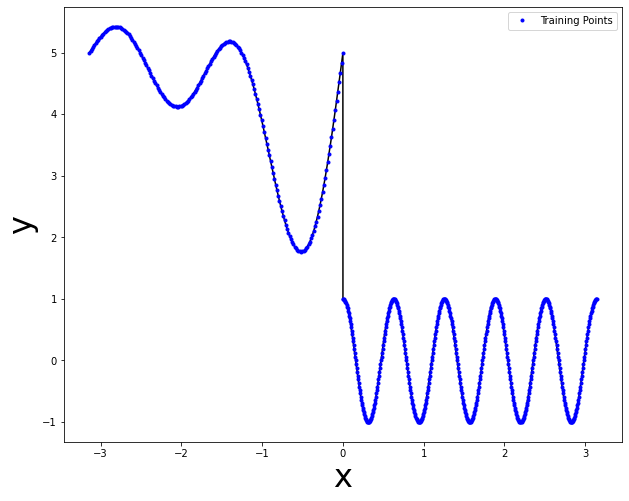

In [38]:
# ============================================
# Constant Learning Rate training (Adam optimizer)
# + Plots: (1) Train/Test loss curves, (2) Prediction vs True function
# ============================================

import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(1234)

# --------------------------------------------
# Target function (piecewise)
#   x < 0  : 5 + sum of sines
#   x >= 0 : cos(10x)
# --------------------------------------------
def fun_x(x):
    if x < 0.0:
        return 5.0 + np.sin(x) + np.sin(2.0 * x) + np.sin(3.0 * x) + np.sin(4.0 * x)
    else:
        return np.cos(10.0 * x)

# --------------------------------------------
# Build training data
# --------------------------------------------
x_in_l = np.linspace(-np.pi, -1.0e-3, 201)   # negative side (avoid 0 exactly)
x_in_r = np.linspace(0.0, np.pi, 501)        # non-negative side
x_in = np.concatenate((x_in_l, x_in_r), axis=0)
y_in = np.array([fun_x(i) for i in x_in])

# Build test data (more points on the left)
x_test_l = np.linspace(-np.pi, -1.0e-3, 301)
x_test_r = np.linspace(0.0, np.pi, 501)
x_test_np = np.concatenate((x_test_l, x_test_r), axis=0)
y_test_np = np.array([fun_x(i) for i in x_test_np])

# --------------------------------------------
# Plot the training points / true function
# --------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_in, y_in, 'k-', label="True Function")
ax.plot(x_in, y_in, '.b', label="Training Points")
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.legend()
plt.show()

# --------------------------------------------
# Convert NumPy arrays to PyTorch tensors
# Shape (N,1) for single-feature regression
# --------------------------------------------
x = torch.from_numpy(x_in.reshape(-1, 1)).float()
y = torch.from_numpy(y_in.reshape(-1, 1)).float()

x_test = torch.from_numpy(x_test_np.reshape(-1, 1)).float()
y_test = torch.from_numpy(y_test_np.reshape(-1, 1)).float()

# --------------------------------------------
# Model, loss, optimizer (constant LR)
# --------------------------------------------
loss_function = torch.nn.MSELoss()
Niter = 30000

Net = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

# Adam with constant learning rate
optimizer = torch.optim.Adam(Net.parameters(), lr=0.01, weight_decay=1e-5)

# --------------------------------------------
# Logs (store floats so plotting is easy)
# --------------------------------------------
train_loss_list = []
test_loss_list = []

# Optional: relative-error logs (your "accuracy" proxy)
acc_train = []
acc_test = []

# --------------------------------------------
# Training loop
# NOTE: printing every iteration is very slow; print every `print_every`.
# --------------------------------------------
print_every = 1500
print("Adam Optimization (Constant LR)")

for it in range(Niter):
    # Forward pass
    y_pred = Net(x)

    # Training loss
    loss = loss_function(y_pred, y)

    # Backprop + update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on train/test without grad tracking
    with torch.no_grad():
        y_train_pred = Net(x)
        y_test_pred = Net(x_test)

        test_loss = loss_function(y_test_pred, y_test)

        # Relative error metrics (optional)
        train_rel_err = torch.linalg.norm(y - y_train_pred) / torch.linalg.norm(y_train_pred)
        test_rel_err = torch.linalg.norm(y_test - y_test_pred) / torch.linalg.norm(y_test_pred)

        # Store floats (NOT tensors)
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
        acc_train.append(train_rel_err.item())
        acc_test.append(test_rel_err.item())

    # Print occasionally to keep training fast
    if (it + 1) % print_every == 0 or it == 0:
        print(f"Iter: {it + 1:>6}/{Niter}  TrainLoss: {loss.item():.3e}  TestLoss: {test_loss.item():.3e}")

# Final predictions on training x for plotting
with torch.no_grad():
    y_const_lr = Net(x).detach().numpy()

# ============================================
# Plot 1: Train/Test Loss Curves (log scale)
# ============================================
fig, ax = plt.subplots(figsize=(15, 10))

ep = np.arange(0, len(train_loss_list), 1)
ax.set_xlabel('# Iterations', fontsize=22)
ax.set_ylabel('Loss (MSE)', fontsize=22)
ax.set_xlim(0, len(ep) + 10)

ax.semilogy(ep, np.array(train_loss_list), 'k--', lw=2, label="Train Loss (Constant LR)")
ax.semilogy(ep, np.array(test_loss_list),  'r--', lw=2, label="Test Loss (Constant LR)")

ax.legend()
plt.show()

# ============================================
# Plot 2: Prediction vs True Function
# ============================================
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x_in, y_in, 'k-', label="True Function")
ax.plot(x_in, y_in, '.b', label="Training Points")
ax.plot(x_in, y_const_lr, '-r', label="NN Prediction (Constant LR)")

ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('y', fontsize=22)
ax.legend()
plt.show()

# $L_1$-regularizer for DNN with function approxiamtion


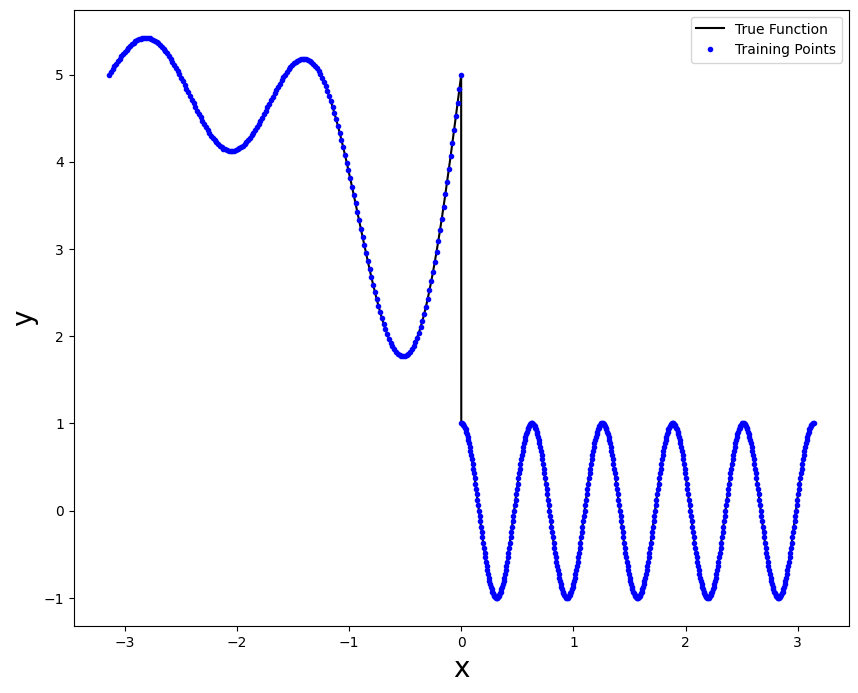

Adam Optimization (Constant LR + L1)
Iter:      1/30000  TrainLoss: 6.237e+00  TestLoss(MSE): 6.058e+00
Iter:    500/30000  TrainLoss: 4.733e-01  TestLoss(MSE): 4.894e-01
Iter:   1000/30000  TrainLoss: 3.522e-01  TestLoss(MSE): 3.550e-01
Iter:   1500/30000  TrainLoss: 2.828e-01  TestLoss(MSE): 2.671e-01
Iter:   2000/30000  TrainLoss: 2.199e-01  TestLoss(MSE): 2.068e-01
Iter:   2500/30000  TrainLoss: 1.912e-01  TestLoss(MSE): 1.796e-01
Iter:   3000/30000  TrainLoss: 1.795e-01  TestLoss(MSE): 1.680e-01
Iter:   3500/30000  TrainLoss: 1.717e-01  TestLoss(MSE): 1.604e-01
Iter:   4000/30000  TrainLoss: 1.662e-01  TestLoss(MSE): 1.552e-01
Iter:   4500/30000  TrainLoss: 1.607e-01  TestLoss(MSE): 1.495e-01
Iter:   5000/30000  TrainLoss: 1.833e-01  TestLoss(MSE): 1.750e-01
Iter:   5500/30000  TrainLoss: 1.581e-01  TestLoss(MSE): 1.456e-01
Iter:   6000/30000  TrainLoss: 1.476e-01  TestLoss(MSE): 1.344e-01
Iter:   6500/30000  TrainLoss: 1.585e-01  TestLoss(MSE): 1.474e-01
Iter:   7000/30000  Train

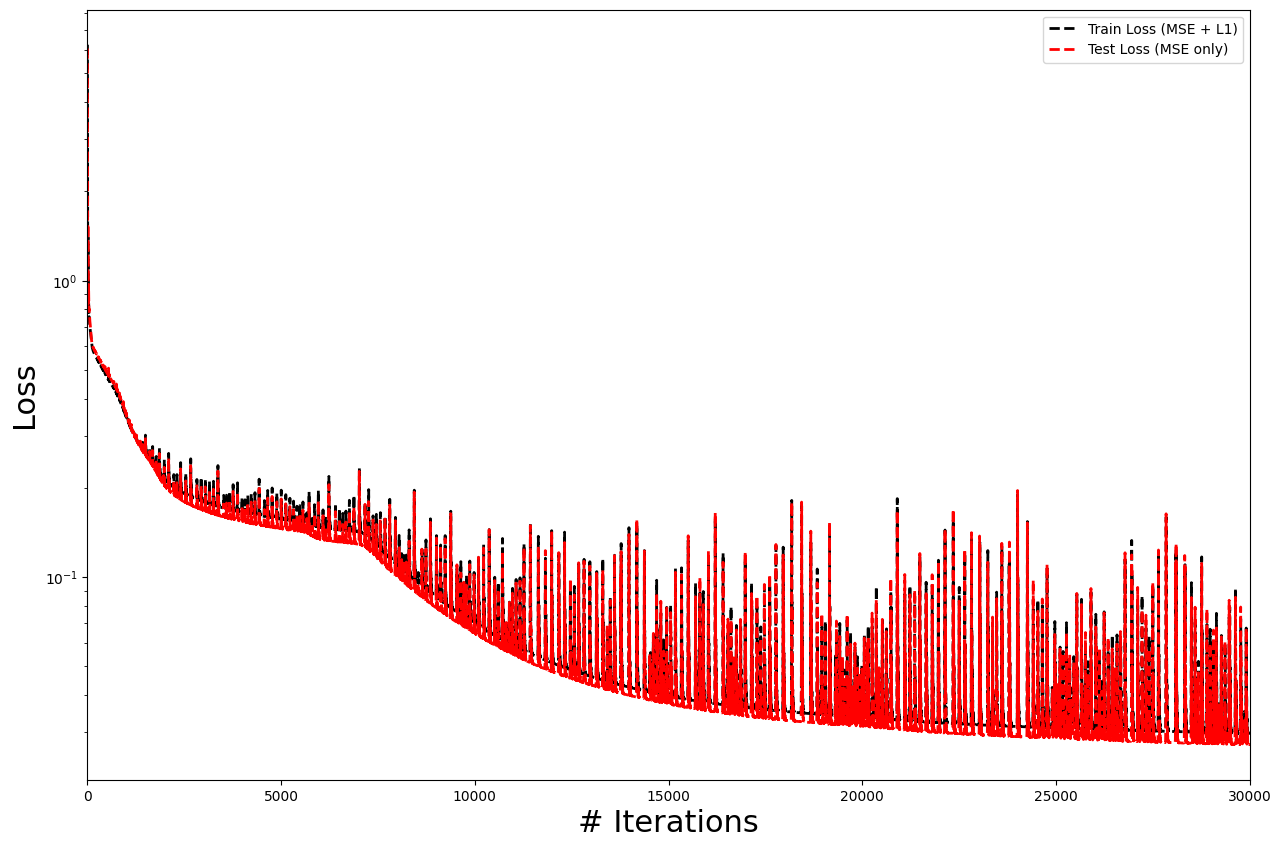

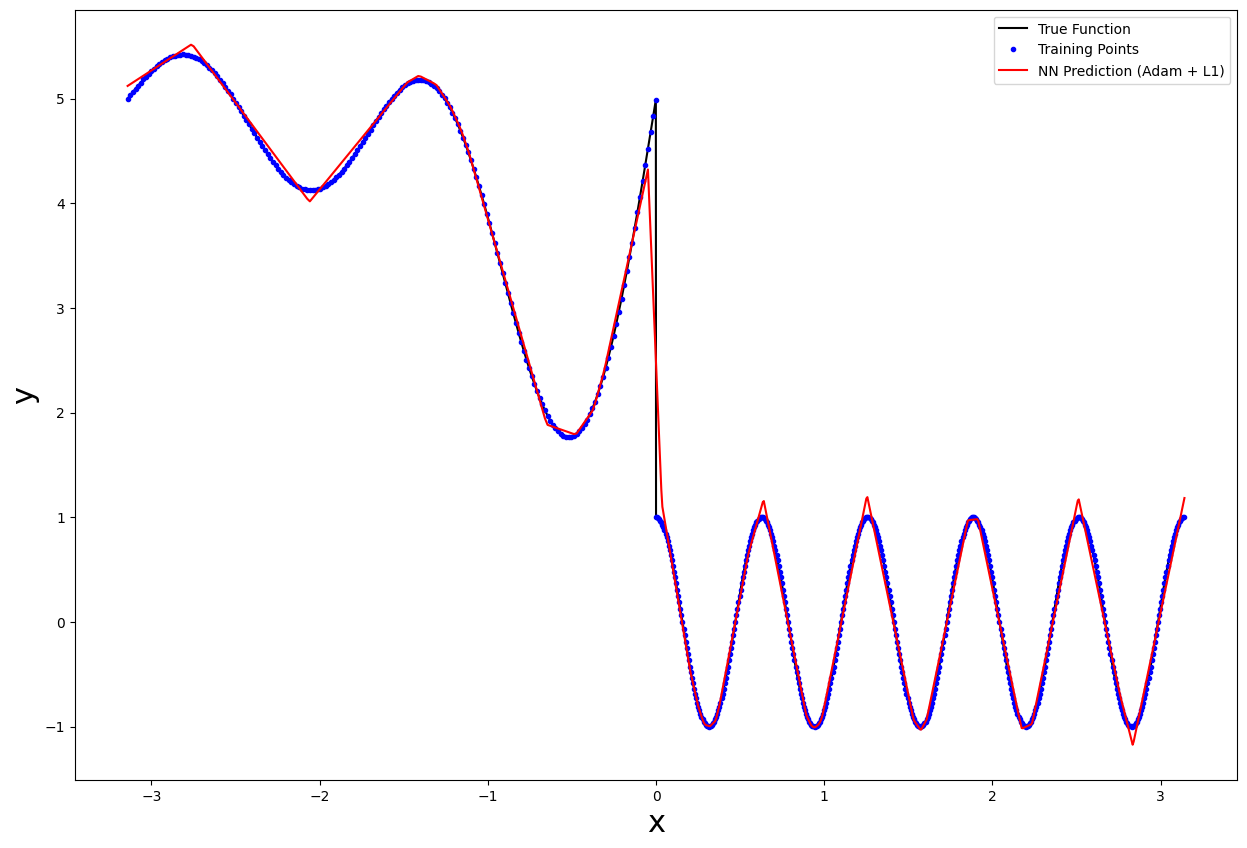

Epoch: 508/30000 Loss: 4.43628e-01
Epoch: 509/30000 Loss: 4.43129e-01
Epoch: 510/30000 Loss: 4.42644e-01
Epoch: 511/30000 Loss: 4.42162e-01
Epoch: 512/30000 Loss: 4.41682e-01
Epoch: 513/30000 Loss: 4.41211e-01
Epoch: 514/30000 Loss: 4.40751e-01
Epoch: 515/30000 Loss: 4.40290e-01
Epoch: 516/30000 Loss: 4.39868e-01
Epoch: 517/30000 Loss: 4.39508e-01
Epoch: 518/30000 Loss: 4.39243e-01
Epoch: 519/30000 Loss: 4.39162e-01
Epoch: 520/30000 Loss: 4.39346e-01
Epoch: 521/30000 Loss: 4.39926e-01
Epoch: 522/30000 Loss: 4.41207e-01
Epoch: 523/30000 Loss: 4.43231e-01
Epoch: 524/30000 Loss: 4.45819e-01
Epoch: 525/30000 Loss: 4.47167e-01
Epoch: 526/30000 Loss: 4.45556e-01
Epoch: 527/30000 Loss: 4.40262e-01
Epoch: 528/30000 Loss: 4.34855e-01
Epoch: 529/30000 Loss: 4.33264e-01
Epoch: 530/30000 Loss: 4.35418e-01
Epoch: 531/30000 Loss: 4.38046e-01
Epoch: 532/30000 Loss: 4.37749e-01
Epoch: 533/30000 Loss: 4.34527e-01
Epoch: 534/30000 Loss: 4.31243e-01
Epoch: 535/30000 Loss: 4.30642e-01
Epoch: 536/30000 Los

Epoch: 765/30000 Loss: 3.56075e-01
Epoch: 766/30000 Loss: 3.54259e-01
Epoch: 767/30000 Loss: 3.53084e-01
Epoch: 768/30000 Loss: 3.53045e-01
Epoch: 769/30000 Loss: 3.53702e-01
Epoch: 770/30000 Loss: 3.54150e-01
Epoch: 771/30000 Loss: 3.53749e-01
Epoch: 772/30000 Loss: 3.52675e-01
Epoch: 773/30000 Loss: 3.51528e-01
Epoch: 774/30000 Loss: 3.51006e-01
Epoch: 775/30000 Loss: 3.51181e-01
Epoch: 776/30000 Loss: 3.51553e-01
Epoch: 777/30000 Loss: 3.51534e-01
Epoch: 778/30000 Loss: 3.50963e-01
Epoch: 779/30000 Loss: 3.50144e-01
Epoch: 780/30000 Loss: 3.49532e-01
Epoch: 781/30000 Loss: 3.49280e-01
Epoch: 782/30000 Loss: 3.49258e-01
Epoch: 783/30000 Loss: 3.49252e-01
Epoch: 784/30000 Loss: 3.49149e-01
Epoch: 785/30000 Loss: 3.48887e-01
Epoch: 786/30000 Loss: 3.48505e-01
Epoch: 787/30000 Loss: 3.48057e-01
Epoch: 788/30000 Loss: 3.47619e-01
Epoch: 789/30000 Loss: 3.47254e-01
Epoch: 790/30000 Loss: 3.47001e-01
Epoch: 791/30000 Loss: 3.46846e-01
Epoch: 792/30000 Loss: 3.46738e-01
Epoch: 793/30000 Los

Epoch: 1025/30000 Loss: 2.95490e-01
Epoch: 1026/30000 Loss: 2.95353e-01
Epoch: 1027/30000 Loss: 2.95199e-01
Epoch: 1028/30000 Loss: 2.94996e-01
Epoch: 1029/30000 Loss: 2.94750e-01
Epoch: 1030/30000 Loss: 2.94479e-01
Epoch: 1031/30000 Loss: 2.94226e-01
Epoch: 1032/30000 Loss: 2.94009e-01
Epoch: 1033/30000 Loss: 2.93823e-01
Epoch: 1034/30000 Loss: 2.93656e-01
Epoch: 1035/30000 Loss: 2.93502e-01
Epoch: 1036/30000 Loss: 2.93348e-01
Epoch: 1037/30000 Loss: 2.93195e-01
Epoch: 1038/30000 Loss: 2.93035e-01
Epoch: 1039/30000 Loss: 2.92863e-01
Epoch: 1040/30000 Loss: 2.92661e-01
Epoch: 1041/30000 Loss: 2.92436e-01
Epoch: 1042/30000 Loss: 2.92203e-01
Epoch: 1043/30000 Loss: 2.91975e-01
Epoch: 1044/30000 Loss: 2.91760e-01
Epoch: 1045/30000 Loss: 2.91552e-01
Epoch: 1046/30000 Loss: 2.91348e-01
Epoch: 1047/30000 Loss: 2.91151e-01
Epoch: 1048/30000 Loss: 2.90957e-01
Epoch: 1049/30000 Loss: 2.90765e-01
Epoch: 1050/30000 Loss: 2.90579e-01
Epoch: 1051/30000 Loss: 2.90396e-01
Epoch: 1052/30000 Loss: 2.90

Epoch: 1281/30000 Loss: 2.59281e-01
Epoch: 1282/30000 Loss: 2.60451e-01
Epoch: 1283/30000 Loss: 2.62343e-01
Epoch: 1284/30000 Loss: 2.65234e-01
Epoch: 1285/30000 Loss: 2.69376e-01
Epoch: 1286/30000 Loss: 2.74712e-01
Epoch: 1287/30000 Loss: 2.80108e-01
Epoch: 1288/30000 Loss: 2.83750e-01
Epoch: 1289/30000 Loss: 2.82317e-01
Epoch: 1290/30000 Loss: 2.75140e-01
Epoch: 1291/30000 Loss: 2.65022e-01
Epoch: 1292/30000 Loss: 2.57934e-01
Epoch: 1293/30000 Loss: 2.57055e-01
Epoch: 1294/30000 Loss: 2.60839e-01
Epoch: 1295/30000 Loss: 2.64969e-01
Epoch: 1296/30000 Loss: 2.65622e-01
Epoch: 1297/30000 Loss: 2.62563e-01
Epoch: 1298/30000 Loss: 2.58419e-01
Epoch: 1299/30000 Loss: 2.56379e-01
Epoch: 1300/30000 Loss: 2.57222e-01
Epoch: 1301/30000 Loss: 2.59088e-01
Epoch: 1302/30000 Loss: 2.59695e-01
Epoch: 1303/30000 Loss: 2.58393e-01
Epoch: 1304/30000 Loss: 2.56328e-01
Epoch: 1305/30000 Loss: 2.55153e-01
Epoch: 1306/30000 Loss: 2.55445e-01
Epoch: 1307/30000 Loss: 2.56350e-01
Epoch: 1308/30000 Loss: 2.56

Epoch: 1549/30000 Loss: 2.32864e-01
Epoch: 1550/30000 Loss: 2.32787e-01
Epoch: 1551/30000 Loss: 2.32711e-01
Epoch: 1552/30000 Loss: 2.32636e-01
Epoch: 1553/30000 Loss: 2.32560e-01
Epoch: 1554/30000 Loss: 2.32486e-01
Epoch: 1555/30000 Loss: 2.32414e-01
Epoch: 1556/30000 Loss: 2.32344e-01
Epoch: 1557/30000 Loss: 2.32279e-01
Epoch: 1558/30000 Loss: 2.32220e-01
Epoch: 1559/30000 Loss: 2.32174e-01
Epoch: 1560/30000 Loss: 2.32146e-01
Epoch: 1561/30000 Loss: 2.32152e-01
Epoch: 1562/30000 Loss: 2.32210e-01
Epoch: 1563/30000 Loss: 2.32359e-01
Epoch: 1564/30000 Loss: 2.32655e-01
Epoch: 1565/30000 Loss: 2.33192e-01
Epoch: 1566/30000 Loss: 2.34097e-01
Epoch: 1567/30000 Loss: 2.35518e-01
Epoch: 1568/30000 Loss: 2.37498e-01
Epoch: 1569/30000 Loss: 2.39790e-01
Epoch: 1570/30000 Loss: 2.41476e-01
Epoch: 1571/30000 Loss: 2.41403e-01
Epoch: 1572/30000 Loss: 2.39026e-01
Epoch: 1573/30000 Loss: 2.36123e-01
Epoch: 1574/30000 Loss: 2.35491e-01
Epoch: 1575/30000 Loss: 2.38544e-01
Epoch: 1576/30000 Loss: 2.44

Epoch: 1799/30000 Loss: 2.18638e-01
Epoch: 1800/30000 Loss: 2.17636e-01
Epoch: 1801/30000 Loss: 2.19989e-01
Epoch: 1802/30000 Loss: 2.23557e-01
Epoch: 1803/30000 Loss: 2.26052e-01
Epoch: 1804/30000 Loss: 2.26168e-01
Epoch: 1805/30000 Loss: 2.23908e-01
Epoch: 1806/30000 Loss: 2.20545e-01
Epoch: 1807/30000 Loss: 2.17769e-01
Epoch: 1808/30000 Loss: 2.16778e-01
Epoch: 1809/30000 Loss: 2.17589e-01
Epoch: 1810/30000 Loss: 2.19234e-01
Epoch: 1811/30000 Loss: 2.20534e-01
Epoch: 1812/30000 Loss: 2.20683e-01
Epoch: 1813/30000 Loss: 2.19655e-01
Epoch: 1814/30000 Loss: 2.18029e-01
Epoch: 1815/30000 Loss: 2.16689e-01
Epoch: 1816/30000 Loss: 2.16201e-01
Epoch: 1817/30000 Loss: 2.16565e-01
Epoch: 1818/30000 Loss: 2.17323e-01
Epoch: 1819/30000 Loss: 2.17904e-01
Epoch: 1820/30000 Loss: 2.17969e-01
Epoch: 1821/30000 Loss: 2.17515e-01
Epoch: 1822/30000 Loss: 2.16796e-01
Epoch: 1823/30000 Loss: 2.16148e-01
Epoch: 1824/30000 Loss: 2.15815e-01
Epoch: 1825/30000 Loss: 2.15823e-01
Epoch: 1826/30000 Loss: 2.16

Epoch: 2045/30000 Loss: 2.05436e-01
Epoch: 2046/30000 Loss: 2.05418e-01
Epoch: 2047/30000 Loss: 2.05394e-01
Epoch: 2048/30000 Loss: 2.05354e-01
Epoch: 2049/30000 Loss: 2.05297e-01
Epoch: 2050/30000 Loss: 2.05221e-01
Epoch: 2051/30000 Loss: 2.05138e-01
Epoch: 2052/30000 Loss: 2.05053e-01
Epoch: 2053/30000 Loss: 2.04976e-01
Epoch: 2054/30000 Loss: 2.04909e-01
Epoch: 2055/30000 Loss: 2.04858e-01
Epoch: 2056/30000 Loss: 2.04813e-01
Epoch: 2057/30000 Loss: 2.04774e-01
Epoch: 2058/30000 Loss: 2.04737e-01
Epoch: 2059/30000 Loss: 2.04697e-01
Epoch: 2060/30000 Loss: 2.04655e-01
Epoch: 2061/30000 Loss: 2.04611e-01
Epoch: 2062/30000 Loss: 2.04564e-01
Epoch: 2063/30000 Loss: 2.04516e-01
Epoch: 2064/30000 Loss: 2.04468e-01
Epoch: 2065/30000 Loss: 2.04420e-01
Epoch: 2066/30000 Loss: 2.04374e-01
Epoch: 2067/30000 Loss: 2.04330e-01
Epoch: 2068/30000 Loss: 2.04290e-01
Epoch: 2069/30000 Loss: 2.04251e-01
Epoch: 2070/30000 Loss: 2.04219e-01
Epoch: 2071/30000 Loss: 2.04192e-01
Epoch: 2072/30000 Loss: 2.04

Epoch: 2318/30000 Loss: 2.08302e-01
Epoch: 2319/30000 Loss: 2.28317e-01
Epoch: 2320/30000 Loss: 2.32767e-01
Epoch: 2321/30000 Loss: 2.16967e-01
Epoch: 2322/30000 Loss: 1.98822e-01
Epoch: 2323/30000 Loss: 1.96486e-01
Epoch: 2324/30000 Loss: 2.07880e-01
Epoch: 2325/30000 Loss: 2.16280e-01
Epoch: 2326/30000 Loss: 2.11140e-01
Epoch: 2327/30000 Loss: 1.99558e-01
Epoch: 2328/30000 Loss: 1.95086e-01
Epoch: 2329/30000 Loss: 2.00610e-01
Epoch: 2330/30000 Loss: 2.06842e-01
Epoch: 2331/30000 Loss: 2.05346e-01
Epoch: 2332/30000 Loss: 1.98570e-01
Epoch: 2333/30000 Loss: 1.94848e-01
Epoch: 2334/30000 Loss: 1.97437e-01
Epoch: 2335/30000 Loss: 2.01450e-01
Epoch: 2336/30000 Loss: 2.01272e-01
Epoch: 2337/30000 Loss: 1.97417e-01
Epoch: 2338/30000 Loss: 1.94750e-01
Epoch: 2339/30000 Loss: 1.95839e-01
Epoch: 2340/30000 Loss: 1.98321e-01
Epoch: 2341/30000 Loss: 1.98680e-01
Epoch: 2342/30000 Loss: 1.96595e-01
Epoch: 2343/30000 Loss: 1.94701e-01
Epoch: 2344/30000 Loss: 1.94922e-01
Epoch: 2345/30000 Loss: 1.96

Epoch: 2581/30000 Loss: 1.88401e-01
Epoch: 2582/30000 Loss: 1.88570e-01
Epoch: 2583/30000 Loss: 1.88812e-01
Epoch: 2584/30000 Loss: 1.89167e-01
Epoch: 2585/30000 Loss: 1.89665e-01
Epoch: 2586/30000 Loss: 1.90378e-01
Epoch: 2587/30000 Loss: 1.91369e-01
Epoch: 2588/30000 Loss: 1.92756e-01
Epoch: 2589/30000 Loss: 1.94621e-01
Epoch: 2590/30000 Loss: 1.97100e-01
Epoch: 2591/30000 Loss: 2.00125e-01
Epoch: 2592/30000 Loss: 2.03763e-01
Epoch: 2593/30000 Loss: 2.07479e-01
Epoch: 2594/30000 Loss: 2.10558e-01
Epoch: 2595/30000 Loss: 2.11587e-01
Epoch: 2596/30000 Loss: 2.09706e-01
Epoch: 2597/30000 Loss: 2.04529e-01
Epoch: 2598/30000 Loss: 1.97612e-01
Epoch: 2599/30000 Loss: 1.91298e-01
Epoch: 2600/30000 Loss: 1.87831e-01
Epoch: 2601/30000 Loss: 1.87859e-01
Epoch: 2602/30000 Loss: 1.90375e-01
Epoch: 2603/30000 Loss: 1.93500e-01
Epoch: 2604/30000 Loss: 1.95413e-01
Epoch: 2605/30000 Loss: 1.95239e-01
Epoch: 2606/30000 Loss: 1.93140e-01
Epoch: 2607/30000 Loss: 1.90304e-01
Epoch: 2608/30000 Loss: 1.88

Epoch: 2842/30000 Loss: 1.83185e-01
Epoch: 2843/30000 Loss: 1.83019e-01
Epoch: 2844/30000 Loss: 1.82681e-01
Epoch: 2845/30000 Loss: 1.82289e-01
Epoch: 2846/30000 Loss: 1.81951e-01
Epoch: 2847/30000 Loss: 1.81741e-01
Epoch: 2848/30000 Loss: 1.81681e-01
Epoch: 2849/30000 Loss: 1.81743e-01
Epoch: 2850/30000 Loss: 1.81871e-01
Epoch: 2851/30000 Loss: 1.82001e-01
Epoch: 2852/30000 Loss: 1.82088e-01
Epoch: 2853/30000 Loss: 1.82103e-01
Epoch: 2854/30000 Loss: 1.82054e-01
Epoch: 2855/30000 Loss: 1.81947e-01
Epoch: 2856/30000 Loss: 1.81816e-01
Epoch: 2857/30000 Loss: 1.81679e-01
Epoch: 2858/30000 Loss: 1.81562e-01
Epoch: 2859/30000 Loss: 1.81477e-01
Epoch: 2860/30000 Loss: 1.81428e-01
Epoch: 2861/30000 Loss: 1.81411e-01
Epoch: 2862/30000 Loss: 1.81416e-01
Epoch: 2863/30000 Loss: 1.81431e-01
Epoch: 2864/30000 Loss: 1.81446e-01
Epoch: 2865/30000 Loss: 1.81455e-01
Epoch: 2866/30000 Loss: 1.81454e-01
Epoch: 2867/30000 Loss: 1.81442e-01
Epoch: 2868/30000 Loss: 1.81421e-01
Epoch: 2869/30000 Loss: 1.81

Epoch: 3099/30000 Loss: 1.83324e-01
Epoch: 3100/30000 Loss: 1.83281e-01
Epoch: 3101/30000 Loss: 1.83014e-01
Epoch: 3102/30000 Loss: 1.82560e-01
Epoch: 3103/30000 Loss: 1.81921e-01
Epoch: 3104/30000 Loss: 1.81139e-01
Epoch: 3105/30000 Loss: 1.80290e-01
Epoch: 3106/30000 Loss: 1.79431e-01
Epoch: 3107/30000 Loss: 1.78628e-01
Epoch: 3108/30000 Loss: 1.77933e-01
Epoch: 3109/30000 Loss: 1.77387e-01
Epoch: 3110/30000 Loss: 1.77009e-01
Epoch: 3111/30000 Loss: 1.76803e-01
Epoch: 3112/30000 Loss: 1.76750e-01
Epoch: 3113/30000 Loss: 1.76814e-01
Epoch: 3114/30000 Loss: 1.76962e-01
Epoch: 3115/30000 Loss: 1.77157e-01
Epoch: 3116/30000 Loss: 1.77371e-01
Epoch: 3117/30000 Loss: 1.77588e-01
Epoch: 3118/30000 Loss: 1.77794e-01
Epoch: 3119/30000 Loss: 1.78001e-01
Epoch: 3120/30000 Loss: 1.78194e-01
Epoch: 3121/30000 Loss: 1.78397e-01
Epoch: 3122/30000 Loss: 1.78585e-01
Epoch: 3123/30000 Loss: 1.78749e-01
Epoch: 3124/30000 Loss: 1.78885e-01
Epoch: 3125/30000 Loss: 1.78991e-01
Epoch: 3126/30000 Loss: 1.79

Epoch: 3363/30000 Loss: 1.73041e-01
Epoch: 3364/30000 Loss: 1.73103e-01
Epoch: 3365/30000 Loss: 1.73167e-01
Epoch: 3366/30000 Loss: 1.73223e-01
Epoch: 3367/30000 Loss: 1.73266e-01
Epoch: 3368/30000 Loss: 1.73295e-01
Epoch: 3369/30000 Loss: 1.73323e-01
Epoch: 3370/30000 Loss: 1.73341e-01
Epoch: 3371/30000 Loss: 1.73363e-01
Epoch: 3372/30000 Loss: 1.73384e-01
Epoch: 3373/30000 Loss: 1.73406e-01
Epoch: 3374/30000 Loss: 1.73436e-01
Epoch: 3375/30000 Loss: 1.73478e-01
Epoch: 3376/30000 Loss: 1.73541e-01
Epoch: 3377/30000 Loss: 1.73630e-01
Epoch: 3378/30000 Loss: 1.73755e-01
Epoch: 3379/30000 Loss: 1.73936e-01
Epoch: 3380/30000 Loss: 1.74175e-01
Epoch: 3381/30000 Loss: 1.74488e-01
Epoch: 3382/30000 Loss: 1.74891e-01
Epoch: 3383/30000 Loss: 1.75411e-01
Epoch: 3384/30000 Loss: 1.76056e-01
Epoch: 3385/30000 Loss: 1.76828e-01
Epoch: 3386/30000 Loss: 1.77737e-01
Epoch: 3387/30000 Loss: 1.78763e-01
Epoch: 3388/30000 Loss: 1.79851e-01
Epoch: 3389/30000 Loss: 1.80905e-01
Epoch: 3390/30000 Loss: 1.81

Epoch: 3624/30000 Loss: 1.70228e-01
Epoch: 3625/30000 Loss: 1.70151e-01
Epoch: 3626/30000 Loss: 1.70054e-01
Epoch: 3627/30000 Loss: 1.69943e-01
Epoch: 3628/30000 Loss: 1.69835e-01
Epoch: 3629/30000 Loss: 1.69732e-01
Epoch: 3630/30000 Loss: 1.69644e-01
Epoch: 3631/30000 Loss: 1.69574e-01
Epoch: 3632/30000 Loss: 1.69523e-01
Epoch: 3633/30000 Loss: 1.69489e-01
Epoch: 3634/30000 Loss: 1.69469e-01
Epoch: 3635/30000 Loss: 1.69462e-01
Epoch: 3636/30000 Loss: 1.69465e-01
Epoch: 3637/30000 Loss: 1.69477e-01
Epoch: 3638/30000 Loss: 1.69494e-01
Epoch: 3639/30000 Loss: 1.69518e-01
Epoch: 3640/30000 Loss: 1.69551e-01
Epoch: 3641/30000 Loss: 1.69601e-01
Epoch: 3642/30000 Loss: 1.69672e-01
Epoch: 3643/30000 Loss: 1.69776e-01
Epoch: 3644/30000 Loss: 1.69921e-01
Epoch: 3645/30000 Loss: 1.70129e-01
Epoch: 3646/30000 Loss: 1.70413e-01
Epoch: 3647/30000 Loss: 1.70808e-01
Epoch: 3648/30000 Loss: 1.71349e-01
Epoch: 3649/30000 Loss: 1.72081e-01
Epoch: 3650/30000 Loss: 1.73070e-01
Epoch: 3651/30000 Loss: 1.74

Epoch: 3864/30000 Loss: 1.67188e-01
Epoch: 3865/30000 Loss: 1.67373e-01
Epoch: 3866/30000 Loss: 1.67453e-01
Epoch: 3867/30000 Loss: 1.67399e-01
Epoch: 3868/30000 Loss: 1.67230e-01
Epoch: 3869/30000 Loss: 1.66998e-01
Epoch: 3870/30000 Loss: 1.66763e-01
Epoch: 3871/30000 Loss: 1.66577e-01
Epoch: 3872/30000 Loss: 1.66471e-01
Epoch: 3873/30000 Loss: 1.66445e-01
Epoch: 3874/30000 Loss: 1.66482e-01
Epoch: 3875/30000 Loss: 1.66552e-01
Epoch: 3876/30000 Loss: 1.66623e-01
Epoch: 3877/30000 Loss: 1.66673e-01
Epoch: 3878/30000 Loss: 1.66692e-01
Epoch: 3879/30000 Loss: 1.66678e-01
Epoch: 3880/30000 Loss: 1.66642e-01
Epoch: 3881/30000 Loss: 1.66595e-01
Epoch: 3882/30000 Loss: 1.66550e-01
Epoch: 3883/30000 Loss: 1.66512e-01
Epoch: 3884/30000 Loss: 1.66488e-01
Epoch: 3885/30000 Loss: 1.66472e-01
Epoch: 3886/30000 Loss: 1.66461e-01
Epoch: 3887/30000 Loss: 1.66451e-01
Epoch: 3888/30000 Loss: 1.66437e-01
Epoch: 3889/30000 Loss: 1.66417e-01
Epoch: 3890/30000 Loss: 1.66391e-01
Epoch: 3891/30000 Loss: 1.66

Epoch: 4125/30000 Loss: 1.64113e-01
Epoch: 4126/30000 Loss: 1.64205e-01
Epoch: 4127/30000 Loss: 1.64351e-01
Epoch: 4128/30000 Loss: 1.64577e-01
Epoch: 4129/30000 Loss: 1.64933e-01
Epoch: 4130/30000 Loss: 1.65486e-01
Epoch: 4131/30000 Loss: 1.66381e-01
Epoch: 4132/30000 Loss: 1.67772e-01
Epoch: 4133/30000 Loss: 1.69967e-01
Epoch: 4134/30000 Loss: 1.73316e-01
Epoch: 4135/30000 Loss: 1.78377e-01
Epoch: 4136/30000 Loss: 1.85605e-01
Epoch: 4137/30000 Loss: 1.95322e-01
Epoch: 4138/30000 Loss: 2.06509e-01
Epoch: 4139/30000 Loss: 2.16883e-01
Epoch: 4140/30000 Loss: 2.21995e-01
Epoch: 4141/30000 Loss: 2.18368e-01
Epoch: 4142/30000 Loss: 2.06485e-01
Epoch: 4143/30000 Loss: 1.92999e-01
Epoch: 4144/30000 Loss: 1.84879e-01
Epoch: 4145/30000 Loss: 1.83710e-01
Epoch: 4146/30000 Loss: 1.84804e-01
Epoch: 4147/30000 Loss: 1.83671e-01
Epoch: 4148/30000 Loss: 1.79508e-01
Epoch: 4149/30000 Loss: 1.74876e-01
Epoch: 4150/30000 Loss: 1.73081e-01
Epoch: 4151/30000 Loss: 1.74431e-01
Epoch: 4152/30000 Loss: 1.76

Epoch: 4380/30000 Loss: 1.61717e-01
Epoch: 4381/30000 Loss: 1.61709e-01
Epoch: 4382/30000 Loss: 1.61700e-01
Epoch: 4383/30000 Loss: 1.61691e-01
Epoch: 4384/30000 Loss: 1.61680e-01
Epoch: 4385/30000 Loss: 1.61669e-01
Epoch: 4386/30000 Loss: 1.61659e-01
Epoch: 4387/30000 Loss: 1.61649e-01
Epoch: 4388/30000 Loss: 1.61640e-01
Epoch: 4389/30000 Loss: 1.61631e-01
Epoch: 4390/30000 Loss: 1.61623e-01
Epoch: 4391/30000 Loss: 1.61615e-01
Epoch: 4392/30000 Loss: 1.61608e-01
Epoch: 4393/30000 Loss: 1.61600e-01
Epoch: 4394/30000 Loss: 1.61592e-01
Epoch: 4395/30000 Loss: 1.61585e-01
Epoch: 4396/30000 Loss: 1.61577e-01
Epoch: 4397/30000 Loss: 1.61570e-01
Epoch: 4398/30000 Loss: 1.61562e-01
Epoch: 4399/30000 Loss: 1.61555e-01
Epoch: 4400/30000 Loss: 1.61549e-01
Epoch: 4401/30000 Loss: 1.61544e-01
Epoch: 4402/30000 Loss: 1.61541e-01
Epoch: 4403/30000 Loss: 1.61540e-01
Epoch: 4404/30000 Loss: 1.61542e-01
Epoch: 4405/30000 Loss: 1.61549e-01
Epoch: 4406/30000 Loss: 1.61562e-01
Epoch: 4407/30000 Loss: 1.61

Epoch: 4626/30000 Loss: 1.59972e-01
Epoch: 4627/30000 Loss: 1.59999e-01
Epoch: 4628/30000 Loss: 1.60017e-01
Epoch: 4629/30000 Loss: 1.60032e-01
Epoch: 4630/30000 Loss: 1.60039e-01
Epoch: 4631/30000 Loss: 1.60041e-01
Epoch: 4632/30000 Loss: 1.60040e-01
Epoch: 4633/30000 Loss: 1.60042e-01
Epoch: 4634/30000 Loss: 1.60046e-01
Epoch: 4635/30000 Loss: 1.60068e-01
Epoch: 4636/30000 Loss: 1.60096e-01
Epoch: 4637/30000 Loss: 1.60145e-01
Epoch: 4638/30000 Loss: 1.60204e-01
Epoch: 4639/30000 Loss: 1.60282e-01
Epoch: 4640/30000 Loss: 1.60376e-01
Epoch: 4641/30000 Loss: 1.60505e-01
Epoch: 4642/30000 Loss: 1.60664e-01
Epoch: 4643/30000 Loss: 1.60885e-01
Epoch: 4644/30000 Loss: 1.61161e-01
Epoch: 4645/30000 Loss: 1.61512e-01
Epoch: 4646/30000 Loss: 1.61957e-01
Epoch: 4647/30000 Loss: 1.62552e-01
Epoch: 4648/30000 Loss: 1.63305e-01
Epoch: 4649/30000 Loss: 1.64286e-01
Epoch: 4650/30000 Loss: 1.65509e-01
Epoch: 4651/30000 Loss: 1.67045e-01
Epoch: 4652/30000 Loss: 1.68871e-01
Epoch: 4653/30000 Loss: 1.71

Epoch: 4878/30000 Loss: 1.59214e-01
Epoch: 4879/30000 Loss: 1.58729e-01
Epoch: 4880/30000 Loss: 1.58353e-01
Epoch: 4881/30000 Loss: 1.58180e-01
Epoch: 4882/30000 Loss: 1.58206e-01
Epoch: 4883/30000 Loss: 1.58359e-01
Epoch: 4884/30000 Loss: 1.58537e-01
Epoch: 4885/30000 Loss: 1.58652e-01
Epoch: 4886/30000 Loss: 1.58660e-01
Epoch: 4887/30000 Loss: 1.58561e-01
Epoch: 4888/30000 Loss: 1.58392e-01
Epoch: 4889/30000 Loss: 1.58209e-01
Epoch: 4890/30000 Loss: 1.58061e-01
Epoch: 4891/30000 Loss: 1.57980e-01
Epoch: 4892/30000 Loss: 1.57968e-01
Epoch: 4893/30000 Loss: 1.58009e-01
Epoch: 4894/30000 Loss: 1.58078e-01
Epoch: 4895/30000 Loss: 1.58144e-01
Epoch: 4896/30000 Loss: 1.58186e-01
Epoch: 4897/30000 Loss: 1.58194e-01
Epoch: 4898/30000 Loss: 1.58166e-01
Epoch: 4899/30000 Loss: 1.58112e-01
Epoch: 4900/30000 Loss: 1.58045e-01
Epoch: 4901/30000 Loss: 1.57978e-01
Epoch: 4902/30000 Loss: 1.57920e-01
Epoch: 4903/30000 Loss: 1.57880e-01
Epoch: 4904/30000 Loss: 1.57856e-01
Epoch: 4905/30000 Loss: 1.57

Epoch: 5146/30000 Loss: 1.57563e-01
Epoch: 5147/30000 Loss: 1.57293e-01
Epoch: 5148/30000 Loss: 1.56881e-01
Epoch: 5149/30000 Loss: 1.56539e-01
Epoch: 5150/30000 Loss: 1.56388e-01
Epoch: 5151/30000 Loss: 1.56425e-01
Epoch: 5152/30000 Loss: 1.56559e-01
Epoch: 5153/30000 Loss: 1.56679e-01
Epoch: 5154/30000 Loss: 1.56723e-01
Epoch: 5155/30000 Loss: 1.56683e-01
Epoch: 5156/30000 Loss: 1.56596e-01
Epoch: 5157/30000 Loss: 1.56503e-01
Epoch: 5158/30000 Loss: 1.56433e-01
Epoch: 5159/30000 Loss: 1.56388e-01
Epoch: 5160/30000 Loss: 1.56363e-01
Epoch: 5161/30000 Loss: 1.56345e-01
Epoch: 5162/30000 Loss: 1.56331e-01
Epoch: 5163/30000 Loss: 1.56323e-01
Epoch: 5164/30000 Loss: 1.56323e-01
Epoch: 5165/30000 Loss: 1.56329e-01
Epoch: 5166/30000 Loss: 1.56334e-01
Epoch: 5167/30000 Loss: 1.56330e-01
Epoch: 5168/30000 Loss: 1.56312e-01
Epoch: 5169/30000 Loss: 1.56281e-01
Epoch: 5170/30000 Loss: 1.56242e-01
Epoch: 5171/30000 Loss: 1.56207e-01
Epoch: 5172/30000 Loss: 1.56182e-01
Epoch: 5173/30000 Loss: 1.56

Epoch: 5423/30000 Loss: 1.56117e-01
Epoch: 5424/30000 Loss: 1.56472e-01
Epoch: 5425/30000 Loss: 1.56927e-01
Epoch: 5426/30000 Loss: 1.57526e-01
Epoch: 5427/30000 Loss: 1.58293e-01
Epoch: 5428/30000 Loss: 1.59290e-01
Epoch: 5429/30000 Loss: 1.60549e-01
Epoch: 5430/30000 Loss: 1.62136e-01
Epoch: 5431/30000 Loss: 1.64063e-01
Epoch: 5432/30000 Loss: 1.66356e-01
Epoch: 5433/30000 Loss: 1.68911e-01
Epoch: 5434/30000 Loss: 1.71613e-01
Epoch: 5435/30000 Loss: 1.74093e-01
Epoch: 5436/30000 Loss: 1.76008e-01
Epoch: 5437/30000 Loss: 1.76779e-01
Epoch: 5438/30000 Loss: 1.76106e-01
Epoch: 5439/30000 Loss: 1.73832e-01
Epoch: 5440/30000 Loss: 1.70354e-01
Epoch: 5441/30000 Loss: 1.66294e-01
Epoch: 5442/30000 Loss: 1.62460e-01
Epoch: 5443/30000 Loss: 1.59455e-01
Epoch: 5444/30000 Loss: 1.57605e-01
Epoch: 5445/30000 Loss: 1.56878e-01
Epoch: 5446/30000 Loss: 1.57042e-01
Epoch: 5447/30000 Loss: 1.57754e-01
Epoch: 5448/30000 Loss: 1.58603e-01
Epoch: 5449/30000 Loss: 1.59284e-01
Epoch: 5450/30000 Loss: 1.59

Epoch: 5672/30000 Loss: 1.53871e-01
Epoch: 5673/30000 Loss: 1.53754e-01
Epoch: 5674/30000 Loss: 1.53673e-01
Epoch: 5675/30000 Loss: 1.53692e-01
Epoch: 5676/30000 Loss: 1.53803e-01
Epoch: 5677/30000 Loss: 1.54058e-01
Epoch: 5678/30000 Loss: 1.54428e-01
Epoch: 5679/30000 Loss: 1.54950e-01
Epoch: 5680/30000 Loss: 1.55405e-01
Epoch: 5681/30000 Loss: 1.55877e-01
Epoch: 5682/30000 Loss: 1.56391e-01
Epoch: 5683/30000 Loss: 1.57040e-01
Epoch: 5684/30000 Loss: 1.57647e-01
Epoch: 5685/30000 Loss: 1.58122e-01
Epoch: 5686/30000 Loss: 1.58147e-01
Epoch: 5687/30000 Loss: 1.57792e-01
Epoch: 5688/30000 Loss: 1.57172e-01
Epoch: 5689/30000 Loss: 1.56470e-01
Epoch: 5690/30000 Loss: 1.55710e-01
Epoch: 5691/30000 Loss: 1.54994e-01
Epoch: 5692/30000 Loss: 1.54349e-01
Epoch: 5693/30000 Loss: 1.53813e-01
Epoch: 5694/30000 Loss: 1.53425e-01
Epoch: 5695/30000 Loss: 1.53200e-01
Epoch: 5696/30000 Loss: 1.53110e-01
Epoch: 5697/30000 Loss: 1.53116e-01
Epoch: 5698/30000 Loss: 1.53220e-01
Epoch: 5699/30000 Loss: 1.53

Epoch: 5924/30000 Loss: 1.60161e-01
Epoch: 5925/30000 Loss: 1.62776e-01
Epoch: 5926/30000 Loss: 1.61640e-01
Epoch: 5927/30000 Loss: 1.58091e-01
Epoch: 5928/30000 Loss: 1.54961e-01
Epoch: 5929/30000 Loss: 1.54199e-01
Epoch: 5930/30000 Loss: 1.55122e-01
Epoch: 5931/30000 Loss: 1.55820e-01
Epoch: 5932/30000 Loss: 1.54820e-01
Epoch: 5933/30000 Loss: 1.52647e-01
Epoch: 5934/30000 Loss: 1.50804e-01
Epoch: 5935/30000 Loss: 1.50480e-01
Epoch: 5936/30000 Loss: 1.51560e-01
Epoch: 5937/30000 Loss: 1.52816e-01
Epoch: 5938/30000 Loss: 1.53022e-01
Epoch: 5939/30000 Loss: 1.51794e-01
Epoch: 5940/30000 Loss: 1.49969e-01
Epoch: 5941/30000 Loss: 1.48751e-01
Epoch: 5942/30000 Loss: 1.48778e-01
Epoch: 5943/30000 Loss: 1.49726e-01
Epoch: 5944/30000 Loss: 1.50676e-01
Epoch: 5945/30000 Loss: 1.50856e-01
Epoch: 5946/30000 Loss: 1.50134e-01
Epoch: 5947/30000 Loss: 1.49034e-01
Epoch: 5948/30000 Loss: 1.48265e-01
Epoch: 5949/30000 Loss: 1.48201e-01
Epoch: 5950/30000 Loss: 1.48689e-01
Epoch: 5951/30000 Loss: 1.49

Epoch: 6178/30000 Loss: 1.43915e-01
Epoch: 6179/30000 Loss: 1.43877e-01
Epoch: 6180/30000 Loss: 1.43838e-01
Epoch: 6181/30000 Loss: 1.43799e-01
Epoch: 6182/30000 Loss: 1.43760e-01
Epoch: 6183/30000 Loss: 1.43720e-01
Epoch: 6184/30000 Loss: 1.43681e-01
Epoch: 6185/30000 Loss: 1.43641e-01
Epoch: 6186/30000 Loss: 1.43602e-01
Epoch: 6187/30000 Loss: 1.43563e-01
Epoch: 6188/30000 Loss: 1.43525e-01
Epoch: 6189/30000 Loss: 1.43489e-01
Epoch: 6190/30000 Loss: 1.43455e-01
Epoch: 6191/30000 Loss: 1.43425e-01
Epoch: 6192/30000 Loss: 1.43400e-01
Epoch: 6193/30000 Loss: 1.43383e-01
Epoch: 6194/30000 Loss: 1.43378e-01
Epoch: 6195/30000 Loss: 1.43396e-01
Epoch: 6196/30000 Loss: 1.43448e-01
Epoch: 6197/30000 Loss: 1.43554e-01
Epoch: 6198/30000 Loss: 1.43751e-01
Epoch: 6199/30000 Loss: 1.44094e-01
Epoch: 6200/30000 Loss: 1.44672e-01
Epoch: 6201/30000 Loss: 1.45650e-01
Epoch: 6202/30000 Loss: 1.47283e-01
Epoch: 6203/30000 Loss: 1.49990e-01
Epoch: 6204/30000 Loss: 1.54303e-01
Epoch: 6205/30000 Loss: 1.61

Epoch: 6427/30000 Loss: 1.34474e-01
Epoch: 6428/30000 Loss: 1.34498e-01
Epoch: 6429/30000 Loss: 1.34556e-01
Epoch: 6430/30000 Loss: 1.34671e-01
Epoch: 6431/30000 Loss: 1.34874e-01
Epoch: 6432/30000 Loss: 1.35219e-01
Epoch: 6433/30000 Loss: 1.35785e-01
Epoch: 6434/30000 Loss: 1.36703e-01
Epoch: 6435/30000 Loss: 1.38184e-01
Epoch: 6436/30000 Loss: 1.40579e-01
Epoch: 6437/30000 Loss: 1.44380e-01
Epoch: 6438/30000 Loss: 1.50269e-01
Epoch: 6439/30000 Loss: 1.58882e-01
Epoch: 6440/30000 Loss: 1.70819e-01
Epoch: 6441/30000 Loss: 1.85353e-01
Epoch: 6442/30000 Loss: 1.99651e-01
Epoch: 6443/30000 Loss: 2.07568e-01
Epoch: 6444/30000 Loss: 2.02449e-01
Epoch: 6445/30000 Loss: 1.83518e-01
Epoch: 6446/30000 Loss: 1.59451e-01
Epoch: 6447/30000 Loss: 1.42888e-01
Epoch: 6448/30000 Loss: 1.40117e-01
Epoch: 6449/30000 Loss: 1.47267e-01
Epoch: 6450/30000 Loss: 1.55056e-01
Epoch: 6451/30000 Loss: 1.56720e-01
Epoch: 6452/30000 Loss: 1.51813e-01
Epoch: 6453/30000 Loss: 1.45333e-01
Epoch: 6454/30000 Loss: 1.41

Epoch: 6672/30000 Loss: 1.25438e-01
Epoch: 6673/30000 Loss: 1.25408e-01
Epoch: 6674/30000 Loss: 1.25378e-01
Epoch: 6675/30000 Loss: 1.25347e-01
Epoch: 6676/30000 Loss: 1.25316e-01
Epoch: 6677/30000 Loss: 1.25289e-01
Epoch: 6678/30000 Loss: 1.25266e-01
Epoch: 6679/30000 Loss: 1.25247e-01
Epoch: 6680/30000 Loss: 1.25233e-01
Epoch: 6681/30000 Loss: 1.25225e-01
Epoch: 6682/30000 Loss: 1.25225e-01
Epoch: 6683/30000 Loss: 1.25235e-01
Epoch: 6684/30000 Loss: 1.25259e-01
Epoch: 6685/30000 Loss: 1.25308e-01
Epoch: 6686/30000 Loss: 1.25385e-01
Epoch: 6687/30000 Loss: 1.25506e-01
Epoch: 6688/30000 Loss: 1.25681e-01
Epoch: 6689/30000 Loss: 1.25934e-01
Epoch: 6690/30000 Loss: 1.26293e-01
Epoch: 6691/30000 Loss: 1.26803e-01
Epoch: 6692/30000 Loss: 1.27523e-01
Epoch: 6693/30000 Loss: 1.28537e-01
Epoch: 6694/30000 Loss: 1.29945e-01
Epoch: 6695/30000 Loss: 1.31873e-01
Epoch: 6696/30000 Loss: 1.34461e-01
Epoch: 6697/30000 Loss: 1.37840e-01
Epoch: 6698/30000 Loss: 1.41916e-01
Epoch: 6699/30000 Loss: 1.46

Epoch: 6917/30000 Loss: 1.30131e-01
Epoch: 6918/30000 Loss: 1.25771e-01
Epoch: 6919/30000 Loss: 1.19697e-01
Epoch: 6920/30000 Loss: 1.17520e-01
Epoch: 6921/30000 Loss: 1.19845e-01
Epoch: 6922/30000 Loss: 1.22728e-01
Epoch: 6923/30000 Loss: 1.22895e-01
Epoch: 6924/30000 Loss: 1.20920e-01
Epoch: 6925/30000 Loss: 1.19343e-01
Epoch: 6926/30000 Loss: 1.19253e-01
Epoch: 6927/30000 Loss: 1.19515e-01
Epoch: 6928/30000 Loss: 1.18999e-01
Epoch: 6929/30000 Loss: 1.18125e-01
Epoch: 6930/30000 Loss: 1.18032e-01
Epoch: 6931/30000 Loss: 1.18839e-01
Epoch: 6932/30000 Loss: 1.19436e-01
Epoch: 6933/30000 Loss: 1.18931e-01
Epoch: 6934/30000 Loss: 1.17697e-01
Epoch: 6935/30000 Loss: 1.16879e-01
Epoch: 6936/30000 Loss: 1.17057e-01
Epoch: 6937/30000 Loss: 1.17742e-01
Epoch: 6938/30000 Loss: 1.18088e-01
Epoch: 6939/30000 Loss: 1.17809e-01
Epoch: 6940/30000 Loss: 1.17310e-01
Epoch: 6941/30000 Loss: 1.17055e-01
Epoch: 6942/30000 Loss: 1.17080e-01
Epoch: 6943/30000 Loss: 1.17100e-01
Epoch: 6944/30000 Loss: 1.16

Epoch: 7174/30000 Loss: 1.15475e-01
Epoch: 7175/30000 Loss: 1.15019e-01
Epoch: 7176/30000 Loss: 1.13712e-01
Epoch: 7177/30000 Loss: 1.12251e-01
Epoch: 7178/30000 Loss: 1.11337e-01
Epoch: 7179/30000 Loss: 1.11314e-01
Epoch: 7180/30000 Loss: 1.12035e-01
Epoch: 7181/30000 Loss: 1.13024e-01
Epoch: 7182/30000 Loss: 1.13745e-01
Epoch: 7183/30000 Loss: 1.13859e-01
Epoch: 7184/30000 Loss: 1.13343e-01
Epoch: 7185/30000 Loss: 1.12440e-01
Epoch: 7186/30000 Loss: 1.11517e-01
Epoch: 7187/30000 Loss: 1.10871e-01
Epoch: 7188/30000 Loss: 1.10611e-01
Epoch: 7189/30000 Loss: 1.10655e-01
Epoch: 7190/30000 Loss: 1.10808e-01
Epoch: 7191/30000 Loss: 1.10879e-01
Epoch: 7192/30000 Loss: 1.10758e-01
Epoch: 7193/30000 Loss: 1.10454e-01
Epoch: 7194/30000 Loss: 1.10057e-01
Epoch: 7195/30000 Loss: 1.09694e-01
Epoch: 7196/30000 Loss: 1.09457e-01
Epoch: 7197/30000 Loss: 1.09380e-01
Epoch: 7198/30000 Loss: 1.09431e-01
Epoch: 7199/30000 Loss: 1.09539e-01
Epoch: 7200/30000 Loss: 1.09635e-01
Epoch: 7201/30000 Loss: 1.09

Epoch: 7423/30000 Loss: 1.08631e-01
Epoch: 7424/30000 Loss: 1.04749e-01
Epoch: 7425/30000 Loss: 1.03982e-01
Epoch: 7426/30000 Loss: 1.05791e-01
Epoch: 7427/30000 Loss: 1.08773e-01
Epoch: 7428/30000 Loss: 1.11359e-01
Epoch: 7429/30000 Loss: 1.12385e-01
Epoch: 7430/30000 Loss: 1.11451e-01
Epoch: 7431/30000 Loss: 1.09053e-01
Epoch: 7432/30000 Loss: 1.06232e-01
Epoch: 7433/30000 Loss: 1.04067e-01
Epoch: 7434/30000 Loss: 1.03180e-01
Epoch: 7435/30000 Loss: 1.03522e-01
Epoch: 7436/30000 Loss: 1.04633e-01
Epoch: 7437/30000 Loss: 1.05886e-01
Epoch: 7438/30000 Loss: 1.06761e-01
Epoch: 7439/30000 Loss: 1.06851e-01
Epoch: 7440/30000 Loss: 1.06110e-01
Epoch: 7441/30000 Loss: 1.04926e-01
Epoch: 7442/30000 Loss: 1.03804e-01
Epoch: 7443/30000 Loss: 1.03136e-01
Epoch: 7444/30000 Loss: 1.03059e-01
Epoch: 7445/30000 Loss: 1.03441e-01
Epoch: 7446/30000 Loss: 1.03998e-01
Epoch: 7447/30000 Loss: 1.04439e-01
Epoch: 7448/30000 Loss: 1.04575e-01
Epoch: 7449/30000 Loss: 1.04390e-01
Epoch: 7450/30000 Loss: 1.03

Epoch: 7678/30000 Loss: 9.77973e-02
Epoch: 7679/30000 Loss: 9.79039e-02
Epoch: 7680/30000 Loss: 9.80525e-02
Epoch: 7681/30000 Loss: 9.81653e-02
Epoch: 7682/30000 Loss: 9.81778e-02
Epoch: 7683/30000 Loss: 9.80630e-02
Epoch: 7684/30000 Loss: 9.78438e-02
Epoch: 7685/30000 Loss: 9.75785e-02
Epoch: 7686/30000 Loss: 9.73392e-02
Epoch: 7687/30000 Loss: 9.71805e-02
Epoch: 7688/30000 Loss: 9.71254e-02
Epoch: 7689/30000 Loss: 9.71610e-02
Epoch: 7690/30000 Loss: 9.72504e-02
Epoch: 7691/30000 Loss: 9.73473e-02
Epoch: 7692/30000 Loss: 9.74121e-02
Epoch: 7693/30000 Loss: 9.74271e-02
Epoch: 7694/30000 Loss: 9.73860e-02
Epoch: 7695/30000 Loss: 9.73029e-02
Epoch: 7696/30000 Loss: 9.71986e-02
Epoch: 7697/30000 Loss: 9.70943e-02
Epoch: 7698/30000 Loss: 9.70048e-02
Epoch: 7699/30000 Loss: 9.69368e-02
Epoch: 7700/30000 Loss: 9.68897e-02
Epoch: 7701/30000 Loss: 9.68586e-02
Epoch: 7702/30000 Loss: 9.68379e-02
Epoch: 7703/30000 Loss: 9.68222e-02
Epoch: 7704/30000 Loss: 9.68085e-02
Epoch: 7705/30000 Loss: 9.67

Epoch: 7943/30000 Loss: 9.15875e-02
Epoch: 7944/30000 Loss: 9.15661e-02
Epoch: 7945/30000 Loss: 9.15447e-02
Epoch: 7946/30000 Loss: 9.15234e-02
Epoch: 7947/30000 Loss: 9.15022e-02
Epoch: 7948/30000 Loss: 9.14811e-02
Epoch: 7949/30000 Loss: 9.14605e-02
Epoch: 7950/30000 Loss: 9.14405e-02
Epoch: 7951/30000 Loss: 9.14213e-02
Epoch: 7952/30000 Loss: 9.14038e-02
Epoch: 7953/30000 Loss: 9.13895e-02
Epoch: 7954/30000 Loss: 9.13811e-02
Epoch: 7955/30000 Loss: 9.13833e-02
Epoch: 7956/30000 Loss: 9.14050e-02
Epoch: 7957/30000 Loss: 9.14628e-02
Epoch: 7958/30000 Loss: 9.15893e-02
Epoch: 7959/30000 Loss: 9.18452e-02
Epoch: 7960/30000 Loss: 9.23458e-02
Epoch: 7961/30000 Loss: 9.33082e-02
Epoch: 7962/30000 Loss: 9.51397e-02
Epoch: 7963/30000 Loss: 9.85714e-02
Epoch: 7964/30000 Loss: 1.04877e-01
Epoch: 7965/30000 Loss: 1.15861e-01
Epoch: 7966/30000 Loss: 1.33488e-01
Epoch: 7967/30000 Loss: 1.56614e-01
Epoch: 7968/30000 Loss: 1.75807e-01
Epoch: 7969/30000 Loss: 1.72258e-01
Epoch: 7970/30000 Loss: 1.38

Epoch: 8202/30000 Loss: 8.68671e-02
Epoch: 8203/30000 Loss: 8.68693e-02
Epoch: 8204/30000 Loss: 8.68802e-02
Epoch: 8205/30000 Loss: 8.69031e-02
Epoch: 8206/30000 Loss: 8.69436e-02
Epoch: 8207/30000 Loss: 8.70093e-02
Epoch: 8208/30000 Loss: 8.71129e-02
Epoch: 8209/30000 Loss: 8.72725e-02
Epoch: 8210/30000 Loss: 8.75148e-02
Epoch: 8211/30000 Loss: 8.78819e-02
Epoch: 8212/30000 Loss: 8.84329e-02
Epoch: 8213/30000 Loss: 8.92580e-02
Epoch: 8214/30000 Loss: 9.04869e-02
Epoch: 8215/30000 Loss: 9.23042e-02
Epoch: 8216/30000 Loss: 9.49621e-02
Epoch: 8217/30000 Loss: 9.87820e-02
Epoch: 8218/30000 Loss: 1.04187e-01
Epoch: 8219/30000 Loss: 1.11297e-01
Epoch: 8220/30000 Loss: 1.20127e-01
Epoch: 8221/30000 Loss: 1.29338e-01
Epoch: 8222/30000 Loss: 1.36553e-01
Epoch: 8223/30000 Loss: 1.37841e-01
Epoch: 8224/30000 Loss: 1.30643e-01
Epoch: 8225/30000 Loss: 1.16096e-01
Epoch: 8226/30000 Loss: 1.00686e-01
Epoch: 8227/30000 Loss: 9.11732e-02
Epoch: 8228/30000 Loss: 9.04840e-02
Epoch: 8229/30000 Loss: 9.58

Epoch: 8458/30000 Loss: 8.23017e-02
Epoch: 8459/30000 Loss: 8.22716e-02
Epoch: 8460/30000 Loss: 8.22517e-02
Epoch: 8461/30000 Loss: 8.22395e-02
Epoch: 8462/30000 Loss: 8.22313e-02
Epoch: 8463/30000 Loss: 8.22225e-02
Epoch: 8464/30000 Loss: 8.22103e-02
Epoch: 8465/30000 Loss: 8.21927e-02
Epoch: 8466/30000 Loss: 8.21696e-02
Epoch: 8467/30000 Loss: 8.21418e-02
Epoch: 8468/30000 Loss: 8.21114e-02
Epoch: 8469/30000 Loss: 8.20803e-02
Epoch: 8470/30000 Loss: 8.20501e-02
Epoch: 8471/30000 Loss: 8.20225e-02
Epoch: 8472/30000 Loss: 8.19980e-02
Epoch: 8473/30000 Loss: 8.19768e-02
Epoch: 8474/30000 Loss: 8.19584e-02
Epoch: 8475/30000 Loss: 8.19421e-02
Epoch: 8476/30000 Loss: 8.19272e-02
Epoch: 8477/30000 Loss: 8.19128e-02
Epoch: 8478/30000 Loss: 8.18985e-02
Epoch: 8479/30000 Loss: 8.18836e-02
Epoch: 8480/30000 Loss: 8.18683e-02
Epoch: 8481/30000 Loss: 8.18521e-02
Epoch: 8482/30000 Loss: 8.18352e-02
Epoch: 8483/30000 Loss: 8.18177e-02
Epoch: 8484/30000 Loss: 8.17998e-02
Epoch: 8485/30000 Loss: 8.17

Epoch: 8711/30000 Loss: 7.92284e-02
Epoch: 8712/30000 Loss: 7.83978e-02
Epoch: 8713/30000 Loss: 7.93847e-02
Epoch: 8714/30000 Loss: 8.08206e-02
Epoch: 8715/30000 Loss: 8.13097e-02
Epoch: 8716/30000 Loss: 8.05248e-02
Epoch: 8717/30000 Loss: 7.92375e-02
Epoch: 8718/30000 Loss: 7.84360e-02
Epoch: 8719/30000 Loss: 7.85136e-02
Epoch: 8720/30000 Loss: 7.90947e-02
Epoch: 8721/30000 Loss: 7.95118e-02
Epoch: 8722/30000 Loss: 7.93997e-02
Epoch: 8723/30000 Loss: 7.88965e-02
Epoch: 8724/30000 Loss: 7.84137e-02
Epoch: 8725/30000 Loss: 7.82481e-02
Epoch: 8726/30000 Loss: 7.83832e-02
Epoch: 8727/30000 Loss: 7.85815e-02
Epoch: 8728/30000 Loss: 7.86213e-02
Epoch: 8729/30000 Loss: 7.84647e-02
Epoch: 8730/30000 Loss: 7.82385e-02
Epoch: 8731/30000 Loss: 7.80933e-02
Epoch: 8732/30000 Loss: 7.80838e-02
Epoch: 8733/30000 Loss: 7.81473e-02
Epoch: 8734/30000 Loss: 7.81814e-02
Epoch: 8735/30000 Loss: 7.81299e-02
Epoch: 8736/30000 Loss: 7.80189e-02
Epoch: 8737/30000 Loss: 7.79179e-02
Epoch: 8738/30000 Loss: 7.78

Epoch: 9035/30000 Loss: 8.43446e-02
Epoch: 9036/30000 Loss: 8.42331e-02
Epoch: 9037/30000 Loss: 8.12278e-02
Epoch: 9038/30000 Loss: 7.72901e-02
Epoch: 9039/30000 Loss: 7.45871e-02
Epoch: 9040/30000 Loss: 7.41046e-02
Epoch: 9041/30000 Loss: 7.52881e-02
Epoch: 9042/30000 Loss: 7.67561e-02
Epoch: 9043/30000 Loss: 7.73525e-02
Epoch: 9044/30000 Loss: 7.67840e-02
Epoch: 9045/30000 Loss: 7.56095e-02
Epoch: 9046/30000 Loss: 7.46710e-02
Epoch: 9047/30000 Loss: 7.44696e-02
Epoch: 9048/30000 Loss: 7.48938e-02
Epoch: 9049/30000 Loss: 7.54138e-02
Epoch: 9050/30000 Loss: 7.55207e-02
Epoch: 9051/30000 Loss: 7.50492e-02
Epoch: 9052/30000 Loss: 7.42418e-02
Epoch: 9053/30000 Loss: 7.35243e-02
Epoch: 9054/30000 Loss: 7.32287e-02
Epoch: 9055/30000 Loss: 7.34046e-02
Epoch: 9056/30000 Loss: 7.38378e-02
Epoch: 9057/30000 Loss: 7.42250e-02
Epoch: 9058/30000 Loss: 7.43461e-02
Epoch: 9059/30000 Loss: 7.41732e-02
Epoch: 9060/30000 Loss: 7.38355e-02
Epoch: 9061/30000 Loss: 7.35197e-02
Epoch: 9062/30000 Loss: 7.33

Epoch: 9296/30000 Loss: 7.01485e-02
Epoch: 9297/30000 Loss: 7.00936e-02
Epoch: 9298/30000 Loss: 7.01408e-02
Epoch: 9299/30000 Loss: 7.02424e-02
Epoch: 9300/30000 Loss: 7.03497e-02
Epoch: 9301/30000 Loss: 7.04609e-02
Epoch: 9302/30000 Loss: 7.05449e-02
Epoch: 9303/30000 Loss: 7.05872e-02
Epoch: 9304/30000 Loss: 7.05889e-02
Epoch: 9305/30000 Loss: 7.05544e-02
Epoch: 9306/30000 Loss: 7.04964e-02
Epoch: 9307/30000 Loss: 7.04273e-02
Epoch: 9308/30000 Loss: 7.03596e-02
Epoch: 9309/30000 Loss: 7.03004e-02
Epoch: 9310/30000 Loss: 7.02611e-02
Epoch: 9311/30000 Loss: 7.02431e-02
Epoch: 9312/30000 Loss: 7.02523e-02
Epoch: 9313/30000 Loss: 7.02863e-02
Epoch: 9314/30000 Loss: 7.03470e-02
Epoch: 9315/30000 Loss: 7.04331e-02
Epoch: 9316/30000 Loss: 7.05443e-02
Epoch: 9317/30000 Loss: 7.06782e-02
Epoch: 9318/30000 Loss: 7.08361e-02
Epoch: 9319/30000 Loss: 7.10218e-02
Epoch: 9320/30000 Loss: 7.12340e-02
Epoch: 9321/30000 Loss: 7.14782e-02
Epoch: 9322/30000 Loss: 7.17526e-02
Epoch: 9323/30000 Loss: 7.20

Epoch: 9552/30000 Loss: 6.74801e-02
Epoch: 9553/30000 Loss: 6.74834e-02
Epoch: 9554/30000 Loss: 6.73634e-02
Epoch: 9555/30000 Loss: 6.71808e-02
Epoch: 9556/30000 Loss: 6.70115e-02
Epoch: 9557/30000 Loss: 6.69122e-02
Epoch: 9558/30000 Loss: 6.68995e-02
Epoch: 9559/30000 Loss: 6.69506e-02
Epoch: 9560/30000 Loss: 6.70212e-02
Epoch: 9561/30000 Loss: 6.70687e-02
Epoch: 9562/30000 Loss: 6.70706e-02
Epoch: 9563/30000 Loss: 6.70268e-02
Epoch: 9564/30000 Loss: 6.69571e-02
Epoch: 9565/30000 Loss: 6.68877e-02
Epoch: 9566/30000 Loss: 6.68406e-02
Epoch: 9567/30000 Loss: 6.68272e-02
Epoch: 9568/30000 Loss: 6.68456e-02
Epoch: 9569/30000 Loss: 6.68878e-02
Epoch: 9570/30000 Loss: 6.69422e-02
Epoch: 9571/30000 Loss: 6.70052e-02
Epoch: 9572/30000 Loss: 6.70781e-02
Epoch: 9573/30000 Loss: 6.71775e-02
Epoch: 9574/30000 Loss: 6.73269e-02
Epoch: 9575/30000 Loss: 6.75671e-02
Epoch: 9576/30000 Loss: 6.79465e-02
Epoch: 9577/30000 Loss: 6.85434e-02
Epoch: 9578/30000 Loss: 6.94539e-02
Epoch: 9579/30000 Loss: 7.08

Epoch: 9808/30000 Loss: 6.47885e-02
Epoch: 9809/30000 Loss: 6.48158e-02
Epoch: 9810/30000 Loss: 6.48315e-02
Epoch: 9811/30000 Loss: 6.48316e-02
Epoch: 9812/30000 Loss: 6.48216e-02
Epoch: 9813/30000 Loss: 6.48059e-02
Epoch: 9814/30000 Loss: 6.47953e-02
Epoch: 9815/30000 Loss: 6.47979e-02
Epoch: 9816/30000 Loss: 6.48222e-02
Epoch: 9817/30000 Loss: 6.48748e-02
Epoch: 9818/30000 Loss: 6.49613e-02
Epoch: 9819/30000 Loss: 6.50861e-02
Epoch: 9820/30000 Loss: 6.52542e-02
Epoch: 9821/30000 Loss: 6.54719e-02
Epoch: 9822/30000 Loss: 6.57498e-02
Epoch: 9823/30000 Loss: 6.61054e-02
Epoch: 9824/30000 Loss: 6.65546e-02
Epoch: 9825/30000 Loss: 6.71315e-02
Epoch: 9826/30000 Loss: 6.78623e-02
Epoch: 9827/30000 Loss: 6.88005e-02
Epoch: 9828/30000 Loss: 6.99885e-02
Epoch: 9829/30000 Loss: 7.14832e-02
Epoch: 9830/30000 Loss: 7.33059e-02
Epoch: 9831/30000 Loss: 7.54861e-02
Epoch: 9832/30000 Loss: 7.79482e-02
Epoch: 9833/30000 Loss: 8.05645e-02
Epoch: 9834/30000 Loss: 8.30382e-02
Epoch: 9835/30000 Loss: 8.49

Epoch: 10064/30000 Loss: 6.41660e-02
Epoch: 10065/30000 Loss: 6.26009e-02
Epoch: 10066/30000 Loss: 6.17837e-02
Epoch: 10067/30000 Loss: 6.18216e-02
Epoch: 10068/30000 Loss: 6.24567e-02
Epoch: 10069/30000 Loss: 6.32484e-02
Epoch: 10070/30000 Loss: 6.37974e-02
Epoch: 10071/30000 Loss: 6.38658e-02
Epoch: 10072/30000 Loss: 6.34731e-02
Epoch: 10073/30000 Loss: 6.28043e-02
Epoch: 10074/30000 Loss: 6.21405e-02
Epoch: 10075/30000 Loss: 6.16982e-02
Epoch: 10076/30000 Loss: 6.15747e-02
Epoch: 10077/30000 Loss: 6.17259e-02
Epoch: 10078/30000 Loss: 6.20149e-02
Epoch: 10079/30000 Loss: 6.22851e-02
Epoch: 10080/30000 Loss: 6.24190e-02
Epoch: 10081/30000 Loss: 6.23767e-02
Epoch: 10082/30000 Loss: 6.21878e-02
Epoch: 10083/30000 Loss: 6.19331e-02
Epoch: 10084/30000 Loss: 6.16979e-02
Epoch: 10085/30000 Loss: 6.15472e-02
Epoch: 10086/30000 Loss: 6.15040e-02
Epoch: 10087/30000 Loss: 6.15529e-02
Epoch: 10088/30000 Loss: 6.16541e-02
Epoch: 10089/30000 Loss: 6.17615e-02
Epoch: 10090/30000 Loss: 6.18422e-02
E

Epoch: 10317/30000 Loss: 5.95664e-02
Epoch: 10318/30000 Loss: 5.96756e-02
Epoch: 10319/30000 Loss: 5.97727e-02
Epoch: 10320/30000 Loss: 5.98302e-02
Epoch: 10321/30000 Loss: 5.98382e-02
Epoch: 10322/30000 Loss: 5.97964e-02
Epoch: 10323/30000 Loss: 5.97180e-02
Epoch: 10324/30000 Loss: 5.96203e-02
Epoch: 10325/30000 Loss: 5.95227e-02
Epoch: 10326/30000 Loss: 5.94392e-02
Epoch: 10327/30000 Loss: 5.93788e-02
Epoch: 10328/30000 Loss: 5.93433e-02
Epoch: 10329/30000 Loss: 5.93303e-02
Epoch: 10330/30000 Loss: 5.93338e-02
Epoch: 10331/30000 Loss: 5.93464e-02
Epoch: 10332/30000 Loss: 5.93613e-02
Epoch: 10333/30000 Loss: 5.93734e-02
Epoch: 10334/30000 Loss: 5.93807e-02
Epoch: 10335/30000 Loss: 5.93812e-02
Epoch: 10336/30000 Loss: 5.93761e-02
Epoch: 10337/30000 Loss: 5.93647e-02
Epoch: 10338/30000 Loss: 5.93492e-02
Epoch: 10339/30000 Loss: 5.93314e-02
Epoch: 10340/30000 Loss: 5.93135e-02
Epoch: 10341/30000 Loss: 5.92966e-02
Epoch: 10342/30000 Loss: 5.92816e-02
Epoch: 10343/30000 Loss: 5.92689e-02
E

Epoch: 10572/30000 Loss: 5.76450e-02
Epoch: 10573/30000 Loss: 5.76961e-02
Epoch: 10574/30000 Loss: 5.77670e-02
Epoch: 10575/30000 Loss: 5.78619e-02
Epoch: 10576/30000 Loss: 5.79891e-02
Epoch: 10577/30000 Loss: 5.81574e-02
Epoch: 10578/30000 Loss: 5.83838e-02
Epoch: 10579/30000 Loss: 5.86846e-02
Epoch: 10580/30000 Loss: 5.90963e-02
Epoch: 10581/30000 Loss: 5.96431e-02
Epoch: 10582/30000 Loss: 6.03829e-02
Epoch: 10583/30000 Loss: 6.13517e-02
Epoch: 10584/30000 Loss: 6.26282e-02
Epoch: 10585/30000 Loss: 6.42316e-02
Epoch: 10586/30000 Loss: 6.62155e-02
Epoch: 10587/30000 Loss: 6.84740e-02
Epoch: 10588/30000 Loss: 7.08935e-02
Epoch: 10589/30000 Loss: 7.30281e-02
Epoch: 10590/30000 Loss: 7.44518e-02
Epoch: 10591/30000 Loss: 7.44493e-02
Epoch: 10592/30000 Loss: 7.27579e-02
Epoch: 10593/30000 Loss: 6.94155e-02
Epoch: 10594/30000 Loss: 6.52851e-02
Epoch: 10595/30000 Loss: 6.14130e-02
Epoch: 10596/30000 Loss: 5.88550e-02
Epoch: 10597/30000 Loss: 5.80598e-02
Epoch: 10598/30000 Loss: 5.88021e-02
E

Epoch: 10822/30000 Loss: 6.14403e-02
Epoch: 10823/30000 Loss: 6.28065e-02
Epoch: 10824/30000 Loss: 6.43172e-02
Epoch: 10825/30000 Loss: 6.59186e-02
Epoch: 10826/30000 Loss: 6.73841e-02
Epoch: 10827/30000 Loss: 6.85353e-02
Epoch: 10828/30000 Loss: 6.90202e-02
Epoch: 10829/30000 Loss: 6.86880e-02
Epoch: 10830/30000 Loss: 6.73894e-02
Epoch: 10831/30000 Loss: 6.53543e-02
Epoch: 10832/30000 Loss: 6.29430e-02
Epoch: 10833/30000 Loss: 6.06880e-02
Epoch: 10834/30000 Loss: 5.90027e-02
Epoch: 10835/30000 Loss: 5.80828e-02
Epoch: 10836/30000 Loss: 5.78697e-02
Epoch: 10837/30000 Loss: 5.81167e-02
Epoch: 10838/30000 Loss: 5.85090e-02
Epoch: 10839/30000 Loss: 5.87706e-02
Epoch: 10840/30000 Loss: 5.87303e-02
Epoch: 10841/30000 Loss: 5.83451e-02
Epoch: 10842/30000 Loss: 5.76927e-02
Epoch: 10843/30000 Loss: 5.69226e-02
Epoch: 10844/30000 Loss: 5.62156e-02
Epoch: 10845/30000 Loss: 5.57090e-02
Epoch: 10846/30000 Loss: 5.54751e-02
Epoch: 10847/30000 Loss: 5.55065e-02
Epoch: 10848/30000 Loss: 5.57366e-02
E

Epoch: 11072/30000 Loss: 5.38601e-02
Epoch: 11073/30000 Loss: 5.38464e-02
Epoch: 11074/30000 Loss: 5.38380e-02
Epoch: 11075/30000 Loss: 5.38312e-02
Epoch: 11076/30000 Loss: 5.38237e-02
Epoch: 11077/30000 Loss: 5.38136e-02
Epoch: 11078/30000 Loss: 5.38015e-02
Epoch: 11079/30000 Loss: 5.37888e-02
Epoch: 11080/30000 Loss: 5.37769e-02
Epoch: 11081/30000 Loss: 5.37671e-02
Epoch: 11082/30000 Loss: 5.37601e-02
Epoch: 11083/30000 Loss: 5.37557e-02
Epoch: 11084/30000 Loss: 5.37533e-02
Epoch: 11085/30000 Loss: 5.37519e-02
Epoch: 11086/30000 Loss: 5.37504e-02
Epoch: 11087/30000 Loss: 5.37481e-02
Epoch: 11088/30000 Loss: 5.37445e-02
Epoch: 11089/30000 Loss: 5.37396e-02
Epoch: 11090/30000 Loss: 5.37333e-02
Epoch: 11091/30000 Loss: 5.37263e-02
Epoch: 11092/30000 Loss: 5.37189e-02
Epoch: 11093/30000 Loss: 5.37116e-02
Epoch: 11094/30000 Loss: 5.37049e-02
Epoch: 11095/30000 Loss: 5.36990e-02
Epoch: 11096/30000 Loss: 5.36944e-02
Epoch: 11097/30000 Loss: 5.36912e-02
Epoch: 11098/30000 Loss: 5.36898e-02
E

Epoch: 11327/30000 Loss: 5.38973e-02
Epoch: 11328/30000 Loss: 5.34957e-02
Epoch: 11329/30000 Loss: 5.47285e-02
Epoch: 11330/30000 Loss: 5.65793e-02
Epoch: 11331/30000 Loss: 5.80967e-02
Epoch: 11332/30000 Loss: 5.86577e-02
Epoch: 11333/30000 Loss: 5.81390e-02
Epoch: 11334/30000 Loss: 5.68281e-02
Epoch: 11335/30000 Loss: 5.52984e-02
Epoch: 11336/30000 Loss: 5.40902e-02
Epoch: 11337/30000 Loss: 5.35371e-02
Epoch: 11338/30000 Loss: 5.36476e-02
Epoch: 11339/30000 Loss: 5.41660e-02
Epoch: 11340/30000 Loss: 5.47320e-02
Epoch: 11341/30000 Loss: 5.50323e-02
Epoch: 11342/30000 Loss: 5.49181e-02
Epoch: 11343/30000 Loss: 5.44092e-02
Epoch: 11344/30000 Loss: 5.36789e-02
Epoch: 11345/30000 Loss: 5.29453e-02
Epoch: 11346/30000 Loss: 5.24033e-02
Epoch: 11347/30000 Loss: 5.21575e-02
Epoch: 11348/30000 Loss: 5.22043e-02
Epoch: 11349/30000 Loss: 5.24559e-02
Epoch: 11350/30000 Loss: 5.27835e-02
Epoch: 11351/30000 Loss: 5.30664e-02
Epoch: 11352/30000 Loss: 5.32224e-02
Epoch: 11353/30000 Loss: 5.32254e-02
E

Epoch: 11586/30000 Loss: 5.07889e-02
Epoch: 11587/30000 Loss: 5.08005e-02
Epoch: 11588/30000 Loss: 5.08204e-02
Epoch: 11589/30000 Loss: 5.08538e-02
Epoch: 11590/30000 Loss: 5.09070e-02
Epoch: 11591/30000 Loss: 5.09919e-02
Epoch: 11592/30000 Loss: 5.11245e-02
Epoch: 11593/30000 Loss: 5.13337e-02
Epoch: 11594/30000 Loss: 5.16604e-02
Epoch: 11595/30000 Loss: 5.21751e-02
Epoch: 11596/30000 Loss: 5.29803e-02
Epoch: 11597/30000 Loss: 5.42483e-02
Epoch: 11598/30000 Loss: 5.62205e-02
Epoch: 11599/30000 Loss: 5.92904e-02
Epoch: 11600/30000 Loss: 6.39154e-02
Epoch: 11601/30000 Loss: 7.07220e-02
Epoch: 11602/30000 Loss: 8.00054e-02
Epoch: 11603/30000 Loss: 9.15838e-02
Epoch: 11604/30000 Loss: 1.03479e-01
Epoch: 11605/30000 Loss: 1.11950e-01
Epoch: 11606/30000 Loss: 1.12775e-01
Epoch: 11607/30000 Loss: 1.06025e-01
Epoch: 11608/30000 Loss: 9.71817e-02
Epoch: 11609/30000 Loss: 9.31397e-02
Epoch: 11610/30000 Loss: 9.46607e-02
Epoch: 11611/30000 Loss: 9.58804e-02
Epoch: 11612/30000 Loss: 8.97465e-02
E

Epoch: 11845/30000 Loss: 4.95354e-02
Epoch: 11846/30000 Loss: 4.95631e-02
Epoch: 11847/30000 Loss: 4.96022e-02
Epoch: 11848/30000 Loss: 4.96556e-02
Epoch: 11849/30000 Loss: 4.97301e-02
Epoch: 11850/30000 Loss: 4.98334e-02
Epoch: 11851/30000 Loss: 4.99795e-02
Epoch: 11852/30000 Loss: 5.01853e-02
Epoch: 11853/30000 Loss: 5.04792e-02
Epoch: 11854/30000 Loss: 5.08961e-02
Epoch: 11855/30000 Loss: 5.14925e-02
Epoch: 11856/30000 Loss: 5.23360e-02
Epoch: 11857/30000 Loss: 5.35331e-02
Epoch: 11858/30000 Loss: 5.51948e-02
Epoch: 11859/30000 Loss: 5.74838e-02
Epoch: 11860/30000 Loss: 6.05003e-02
Epoch: 11861/30000 Loss: 6.43500e-02
Epoch: 11862/30000 Loss: 6.87946e-02
Epoch: 11863/30000 Loss: 7.34021e-02
Epoch: 11864/30000 Loss: 7.69770e-02
Epoch: 11865/30000 Loss: 7.83221e-02
Epoch: 11866/30000 Loss: 7.61471e-02
Epoch: 11867/30000 Loss: 7.07986e-02
Epoch: 11868/30000 Loss: 6.39095e-02
Epoch: 11869/30000 Loss: 5.82123e-02
Epoch: 11870/30000 Loss: 5.55336e-02
Epoch: 11871/30000 Loss: 5.59389e-02
E

Epoch: 12099/30000 Loss: 4.93232e-02
Epoch: 12100/30000 Loss: 5.00410e-02
Epoch: 12101/30000 Loss: 5.06238e-02
Epoch: 12102/30000 Loss: 5.09114e-02
Epoch: 12103/30000 Loss: 5.08447e-02
Epoch: 12104/30000 Loss: 5.04725e-02
Epoch: 12105/30000 Loss: 4.99063e-02
Epoch: 12106/30000 Loss: 4.92914e-02
Epoch: 12107/30000 Loss: 4.87542e-02
Epoch: 12108/30000 Loss: 4.83814e-02
Epoch: 12109/30000 Loss: 4.82039e-02
Epoch: 12110/30000 Loss: 4.82026e-02
Epoch: 12111/30000 Loss: 4.83264e-02
Epoch: 12112/30000 Loss: 4.85109e-02
Epoch: 12113/30000 Loss: 4.86969e-02
Epoch: 12114/30000 Loss: 4.88392e-02
Epoch: 12115/30000 Loss: 4.89149e-02
Epoch: 12116/30000 Loss: 4.89196e-02
Epoch: 12117/30000 Loss: 4.88638e-02
Epoch: 12118/30000 Loss: 4.87675e-02
Epoch: 12119/30000 Loss: 4.86524e-02
Epoch: 12120/30000 Loss: 4.85382e-02
Epoch: 12121/30000 Loss: 4.84388e-02
Epoch: 12122/30000 Loss: 4.83616e-02
Epoch: 12123/30000 Loss: 4.83086e-02
Epoch: 12124/30000 Loss: 4.82770e-02
Epoch: 12125/30000 Loss: 4.82617e-02
E

Epoch: 12359/30000 Loss: 4.75125e-02
Epoch: 12360/30000 Loss: 4.74775e-02
Epoch: 12361/30000 Loss: 4.74127e-02
Epoch: 12362/30000 Loss: 4.73610e-02
Epoch: 12363/30000 Loss: 4.73478e-02
Epoch: 12364/30000 Loss: 4.73715e-02
Epoch: 12365/30000 Loss: 4.74107e-02
Epoch: 12366/30000 Loss: 4.74395e-02
Epoch: 12367/30000 Loss: 4.74396e-02
Epoch: 12368/30000 Loss: 4.74095e-02
Epoch: 12369/30000 Loss: 4.73606e-02
Epoch: 12370/30000 Loss: 4.73107e-02
Epoch: 12371/30000 Loss: 4.72746e-02
Epoch: 12372/30000 Loss: 4.72592e-02
Epoch: 12373/30000 Loss: 4.72618e-02
Epoch: 12374/30000 Loss: 4.72747e-02
Epoch: 12375/30000 Loss: 4.72881e-02
Epoch: 12376/30000 Loss: 4.72961e-02
Epoch: 12377/30000 Loss: 4.72983e-02
Epoch: 12378/30000 Loss: 4.72981e-02
Epoch: 12379/30000 Loss: 4.73024e-02
Epoch: 12380/30000 Loss: 4.73176e-02
Epoch: 12381/30000 Loss: 4.73488e-02
Epoch: 12382/30000 Loss: 4.73992e-02
Epoch: 12383/30000 Loss: 4.74708e-02
Epoch: 12384/30000 Loss: 4.75662e-02
Epoch: 12385/30000 Loss: 4.76895e-02
E

Epoch: 12612/30000 Loss: 4.60976e-02
Epoch: 12613/30000 Loss: 4.60936e-02
Epoch: 12614/30000 Loss: 4.60896e-02
Epoch: 12615/30000 Loss: 4.60855e-02
Epoch: 12616/30000 Loss: 4.60815e-02
Epoch: 12617/30000 Loss: 4.60775e-02
Epoch: 12618/30000 Loss: 4.60736e-02
Epoch: 12619/30000 Loss: 4.60696e-02
Epoch: 12620/30000 Loss: 4.60657e-02
Epoch: 12621/30000 Loss: 4.60618e-02
Epoch: 12622/30000 Loss: 4.60581e-02
Epoch: 12623/30000 Loss: 4.60544e-02
Epoch: 12624/30000 Loss: 4.60509e-02
Epoch: 12625/30000 Loss: 4.60477e-02
Epoch: 12626/30000 Loss: 4.60448e-02
Epoch: 12627/30000 Loss: 4.60426e-02
Epoch: 12628/30000 Loss: 4.60414e-02
Epoch: 12629/30000 Loss: 4.60415e-02
Epoch: 12630/30000 Loss: 4.60440e-02
Epoch: 12631/30000 Loss: 4.60500e-02
Epoch: 12632/30000 Loss: 4.60615e-02
Epoch: 12633/30000 Loss: 4.60817e-02
Epoch: 12634/30000 Loss: 4.61160e-02
Epoch: 12635/30000 Loss: 4.61728e-02
Epoch: 12636/30000 Loss: 4.62659e-02
Epoch: 12637/30000 Loss: 4.64184e-02
Epoch: 12638/30000 Loss: 4.66678e-02
E

Epoch: 12873/30000 Loss: 5.14973e-02
Epoch: 12874/30000 Loss: 5.12757e-02
Epoch: 12875/30000 Loss: 5.03876e-02
Epoch: 12876/30000 Loss: 4.90761e-02
Epoch: 12877/30000 Loss: 4.76828e-02
Epoch: 12878/30000 Loss: 4.65576e-02
Epoch: 12879/30000 Loss: 4.59238e-02
Epoch: 12880/30000 Loss: 4.58356e-02
Epoch: 12881/30000 Loss: 4.61772e-02
Epoch: 12882/30000 Loss: 4.67334e-02
Epoch: 12883/30000 Loss: 4.72621e-02
Epoch: 12884/30000 Loss: 4.75770e-02
Epoch: 12885/30000 Loss: 4.75828e-02
Epoch: 12886/30000 Loss: 4.72871e-02
Epoch: 12887/30000 Loss: 4.67839e-02
Epoch: 12888/30000 Loss: 4.62059e-02
Epoch: 12889/30000 Loss: 4.56903e-02
Epoch: 12890/30000 Loss: 4.53328e-02
Epoch: 12891/30000 Loss: 4.51758e-02
Epoch: 12892/30000 Loss: 4.52049e-02
Epoch: 12893/30000 Loss: 4.53649e-02
Epoch: 12894/30000 Loss: 4.55827e-02
Epoch: 12895/30000 Loss: 4.57877e-02
Epoch: 12896/30000 Loss: 4.59285e-02
Epoch: 12897/30000 Loss: 4.59781e-02
Epoch: 12898/30000 Loss: 4.59365e-02
Epoch: 12899/30000 Loss: 4.58217e-02
E

Epoch: 13125/30000 Loss: 4.43624e-02
Epoch: 13126/30000 Loss: 4.43443e-02
Epoch: 13127/30000 Loss: 4.43371e-02
Epoch: 13128/30000 Loss: 4.43385e-02
Epoch: 13129/30000 Loss: 4.43450e-02
Epoch: 13130/30000 Loss: 4.43528e-02
Epoch: 13131/30000 Loss: 4.43590e-02
Epoch: 13132/30000 Loss: 4.43615e-02
Epoch: 13133/30000 Loss: 4.43596e-02
Epoch: 13134/30000 Loss: 4.43540e-02
Epoch: 13135/30000 Loss: 4.43450e-02
Epoch: 13136/30000 Loss: 4.43343e-02
Epoch: 13137/30000 Loss: 4.43228e-02
Epoch: 13138/30000 Loss: 4.43119e-02
Epoch: 13139/30000 Loss: 4.43023e-02
Epoch: 13140/30000 Loss: 4.42944e-02
Epoch: 13141/30000 Loss: 4.42883e-02
Epoch: 13142/30000 Loss: 4.42839e-02
Epoch: 13143/30000 Loss: 4.42808e-02
Epoch: 13144/30000 Loss: 4.42788e-02
Epoch: 13145/30000 Loss: 4.42772e-02
Epoch: 13146/30000 Loss: 4.42760e-02
Epoch: 13147/30000 Loss: 4.42747e-02
Epoch: 13148/30000 Loss: 4.42732e-02
Epoch: 13149/30000 Loss: 4.42716e-02
Epoch: 13150/30000 Loss: 4.42696e-02
Epoch: 13151/30000 Loss: 4.42673e-02
E

Epoch: 13376/30000 Loss: 5.45497e-02
Epoch: 13377/30000 Loss: 5.69289e-02
Epoch: 13378/30000 Loss: 5.33820e-02
Epoch: 13379/30000 Loss: 4.72971e-02
Epoch: 13380/30000 Loss: 4.37295e-02
Epoch: 13381/30000 Loss: 4.47657e-02
Epoch: 13382/30000 Loss: 4.82679e-02
Epoch: 13383/30000 Loss: 5.04895e-02
Epoch: 13384/30000 Loss: 4.95217e-02
Epoch: 13385/30000 Loss: 4.65145e-02
Epoch: 13386/30000 Loss: 4.41077e-02
Epoch: 13387/30000 Loss: 4.39183e-02
Epoch: 13388/30000 Loss: 4.54027e-02
Epoch: 13389/30000 Loss: 4.67856e-02
Epoch: 13390/30000 Loss: 4.67987e-02
Epoch: 13391/30000 Loss: 4.55945e-02
Epoch: 13392/30000 Loss: 4.42939e-02
Epoch: 13393/30000 Loss: 4.38443e-02
Epoch: 13394/30000 Loss: 4.42848e-02
Epoch: 13395/30000 Loss: 4.49372e-02
Epoch: 13396/30000 Loss: 4.51330e-02
Epoch: 13397/30000 Loss: 4.47486e-02
Epoch: 13398/30000 Loss: 4.41708e-02
Epoch: 13399/30000 Loss: 4.38480e-02
Epoch: 13400/30000 Loss: 4.39128e-02
Epoch: 13401/30000 Loss: 4.41514e-02
Epoch: 13402/30000 Loss: 4.42676e-02
E

Epoch: 13629/30000 Loss: 4.28723e-02
Epoch: 13630/30000 Loss: 4.28697e-02
Epoch: 13631/30000 Loss: 4.28682e-02
Epoch: 13632/30000 Loss: 4.28660e-02
Epoch: 13633/30000 Loss: 4.28621e-02
Epoch: 13634/30000 Loss: 4.28567e-02
Epoch: 13635/30000 Loss: 4.28509e-02
Epoch: 13636/30000 Loss: 4.28458e-02
Epoch: 13637/30000 Loss: 4.28419e-02
Epoch: 13638/30000 Loss: 4.28390e-02
Epoch: 13639/30000 Loss: 4.28363e-02
Epoch: 13640/30000 Loss: 4.28332e-02
Epoch: 13641/30000 Loss: 4.28294e-02
Epoch: 13642/30000 Loss: 4.28253e-02
Epoch: 13643/30000 Loss: 4.28215e-02
Epoch: 13644/30000 Loss: 4.28181e-02
Epoch: 13645/30000 Loss: 4.28153e-02
Epoch: 13646/30000 Loss: 4.28127e-02
Epoch: 13647/30000 Loss: 4.28101e-02
Epoch: 13648/30000 Loss: 4.28073e-02
Epoch: 13649/30000 Loss: 4.28042e-02
Epoch: 13650/30000 Loss: 4.28009e-02
Epoch: 13651/30000 Loss: 4.27978e-02
Epoch: 13652/30000 Loss: 4.27948e-02
Epoch: 13653/30000 Loss: 4.27920e-02
Epoch: 13654/30000 Loss: 4.27893e-02
Epoch: 13655/30000 Loss: 4.27867e-02
E

Epoch: 13879/30000 Loss: 4.22096e-02
Epoch: 13880/30000 Loss: 4.22055e-02
Epoch: 13881/30000 Loss: 4.22039e-02
Epoch: 13882/30000 Loss: 4.22035e-02
Epoch: 13883/30000 Loss: 4.22032e-02
Epoch: 13884/30000 Loss: 4.22020e-02
Epoch: 13885/30000 Loss: 4.21994e-02
Epoch: 13886/30000 Loss: 4.21957e-02
Epoch: 13887/30000 Loss: 4.21913e-02
Epoch: 13888/30000 Loss: 4.21870e-02
Epoch: 13889/30000 Loss: 4.21834e-02
Epoch: 13890/30000 Loss: 4.21809e-02
Epoch: 13891/30000 Loss: 4.21799e-02
Epoch: 13892/30000 Loss: 4.21802e-02
Epoch: 13893/30000 Loss: 4.21818e-02
Epoch: 13894/30000 Loss: 4.21849e-02
Epoch: 13895/30000 Loss: 4.21892e-02
Epoch: 13896/30000 Loss: 4.21953e-02
Epoch: 13897/30000 Loss: 4.22039e-02
Epoch: 13898/30000 Loss: 4.22163e-02
Epoch: 13899/30000 Loss: 4.22340e-02
Epoch: 13900/30000 Loss: 4.22595e-02
Epoch: 13901/30000 Loss: 4.22964e-02
Epoch: 13902/30000 Loss: 4.23491e-02
Epoch: 13903/30000 Loss: 4.24250e-02
Epoch: 13904/30000 Loss: 4.25337e-02
Epoch: 13905/30000 Loss: 4.26900e-02
E

Epoch: 14133/30000 Loss: 4.15812e-02
Epoch: 14134/30000 Loss: 4.15759e-02
Epoch: 14135/30000 Loss: 4.15709e-02
Epoch: 14136/30000 Loss: 4.15664e-02
Epoch: 14137/30000 Loss: 4.15627e-02
Epoch: 14138/30000 Loss: 4.15596e-02
Epoch: 14139/30000 Loss: 4.15570e-02
Epoch: 14140/30000 Loss: 4.15547e-02
Epoch: 14141/30000 Loss: 4.15524e-02
Epoch: 14142/30000 Loss: 4.15500e-02
Epoch: 14143/30000 Loss: 4.15475e-02
Epoch: 14144/30000 Loss: 4.15448e-02
Epoch: 14145/30000 Loss: 4.15419e-02
Epoch: 14146/30000 Loss: 4.15390e-02
Epoch: 14147/30000 Loss: 4.15360e-02
Epoch: 14148/30000 Loss: 4.15330e-02
Epoch: 14149/30000 Loss: 4.15302e-02
Epoch: 14150/30000 Loss: 4.15273e-02
Epoch: 14151/30000 Loss: 4.15247e-02
Epoch: 14152/30000 Loss: 4.15221e-02
Epoch: 14153/30000 Loss: 4.15196e-02
Epoch: 14154/30000 Loss: 4.15171e-02
Epoch: 14155/30000 Loss: 4.15148e-02
Epoch: 14156/30000 Loss: 4.15123e-02
Epoch: 14157/30000 Loss: 4.15100e-02
Epoch: 14158/30000 Loss: 4.15076e-02
Epoch: 14159/30000 Loss: 4.15052e-02
E

Epoch: 14390/30000 Loss: 4.12681e-02
Epoch: 14391/30000 Loss: 4.14205e-02
Epoch: 14392/30000 Loss: 4.16626e-02
Epoch: 14393/30000 Loss: 4.20477e-02
Epoch: 14394/30000 Loss: 4.26648e-02
Epoch: 14395/30000 Loss: 4.36519e-02
Epoch: 14396/30000 Loss: 4.52364e-02
Epoch: 14397/30000 Loss: 4.77477e-02
Epoch: 14398/30000 Loss: 5.16941e-02
Epoch: 14399/30000 Loss: 5.76555e-02
Epoch: 14400/30000 Loss: 6.62573e-02
Epoch: 14401/30000 Loss: 7.73113e-02
Epoch: 14402/30000 Loss: 8.91673e-02
Epoch: 14403/30000 Loss: 9.72070e-02
Epoch: 14404/30000 Loss: 9.59297e-02
Epoch: 14405/30000 Loss: 8.29706e-02
Epoch: 14406/30000 Loss: 6.57439e-02
Epoch: 14407/30000 Loss: 5.71296e-02
Epoch: 14408/30000 Loss: 6.50139e-02
Epoch: 14409/30000 Loss: 8.58431e-02
Epoch: 14410/30000 Loss: 1.08470e-01
Epoch: 14411/30000 Loss: 1.21174e-01
Epoch: 14412/30000 Loss: 1.18936e-01
Epoch: 14413/30000 Loss: 1.03551e-01
Epoch: 14414/30000 Loss: 8.37910e-02
Epoch: 14415/30000 Loss: 6.73972e-02
Epoch: 14416/30000 Loss: 5.89403e-02
E

Epoch: 14643/30000 Loss: 4.07739e-02
Epoch: 14644/30000 Loss: 4.08227e-02
Epoch: 14645/30000 Loss: 4.07758e-02
Epoch: 14646/30000 Loss: 4.06558e-02
Epoch: 14647/30000 Loss: 4.05311e-02
Epoch: 14648/30000 Loss: 4.04644e-02
Epoch: 14649/30000 Loss: 4.04771e-02
Epoch: 14650/30000 Loss: 4.05437e-02
Epoch: 14651/30000 Loss: 4.06145e-02
Epoch: 14652/30000 Loss: 4.06473e-02
Epoch: 14653/30000 Loss: 4.06290e-02
Epoch: 14654/30000 Loss: 4.05754e-02
Epoch: 14655/30000 Loss: 4.05176e-02
Epoch: 14656/30000 Loss: 4.04811e-02
Epoch: 14657/30000 Loss: 4.04738e-02
Epoch: 14658/30000 Loss: 4.04866e-02
Epoch: 14659/30000 Loss: 4.05014e-02
Epoch: 14660/30000 Loss: 4.05032e-02
Epoch: 14661/30000 Loss: 4.04875e-02
Epoch: 14662/30000 Loss: 4.04608e-02
Epoch: 14663/30000 Loss: 4.04341e-02
Epoch: 14664/30000 Loss: 4.04172e-02
Epoch: 14665/30000 Loss: 4.04138e-02
Epoch: 14666/30000 Loss: 4.04210e-02
Epoch: 14667/30000 Loss: 4.04320e-02
Epoch: 14668/30000 Loss: 4.04399e-02
Epoch: 14669/30000 Loss: 4.04406e-02
E

Epoch: 14888/30000 Loss: 4.01512e-02
Epoch: 14889/30000 Loss: 4.02086e-02
Epoch: 14890/30000 Loss: 4.02874e-02
Epoch: 14891/30000 Loss: 4.03967e-02
Epoch: 14892/30000 Loss: 4.05475e-02
Epoch: 14893/30000 Loss: 4.07583e-02
Epoch: 14894/30000 Loss: 4.10515e-02
Epoch: 14895/30000 Loss: 4.14647e-02
Epoch: 14896/30000 Loss: 4.20442e-02
Epoch: 14897/30000 Loss: 4.28619e-02
Epoch: 14898/30000 Loss: 4.40034e-02
Epoch: 14899/30000 Loss: 4.55948e-02
Epoch: 14900/30000 Loss: 4.77601e-02
Epoch: 14901/30000 Loss: 5.06604e-02
Epoch: 14902/30000 Loss: 5.43463e-02
Epoch: 14903/30000 Loss: 5.88024e-02
Epoch: 14904/30000 Loss: 6.35818e-02
Epoch: 14905/30000 Loss: 6.79918e-02
Epoch: 14906/30000 Loss: 7.06934e-02
Epoch: 14907/30000 Loss: 7.06934e-02
Epoch: 14908/30000 Loss: 6.74201e-02
Epoch: 14909/30000 Loss: 6.20337e-02
Epoch: 14910/30000 Loss: 5.65847e-02
Epoch: 14911/30000 Loss: 5.31099e-02
Epoch: 14912/30000 Loss: 5.22096e-02
Epoch: 14913/30000 Loss: 5.29184e-02
Epoch: 14914/30000 Loss: 5.34992e-02
E

Epoch: 15135/30000 Loss: 3.96002e-02
Epoch: 15136/30000 Loss: 3.95711e-02
Epoch: 15137/30000 Loss: 3.95414e-02
Epoch: 15138/30000 Loss: 3.95155e-02
Epoch: 15139/30000 Loss: 3.94968e-02
Epoch: 15140/30000 Loss: 3.94865e-02
Epoch: 15141/30000 Loss: 3.94837e-02
Epoch: 15142/30000 Loss: 3.94866e-02
Epoch: 15143/30000 Loss: 3.94928e-02
Epoch: 15144/30000 Loss: 3.94998e-02
Epoch: 15145/30000 Loss: 3.95061e-02
Epoch: 15146/30000 Loss: 3.95102e-02
Epoch: 15147/30000 Loss: 3.95117e-02
Epoch: 15148/30000 Loss: 3.95105e-02
Epoch: 15149/30000 Loss: 3.95071e-02
Epoch: 15150/30000 Loss: 3.95021e-02
Epoch: 15151/30000 Loss: 3.94961e-02
Epoch: 15152/30000 Loss: 3.94896e-02
Epoch: 15153/30000 Loss: 3.94833e-02
Epoch: 15154/30000 Loss: 3.94775e-02
Epoch: 15155/30000 Loss: 3.94721e-02
Epoch: 15156/30000 Loss: 3.94674e-02
Epoch: 15157/30000 Loss: 3.94632e-02
Epoch: 15158/30000 Loss: 3.94596e-02
Epoch: 15159/30000 Loss: 3.94562e-02
Epoch: 15160/30000 Loss: 3.94531e-02
Epoch: 15161/30000 Loss: 3.94504e-02
E

Epoch: 15403/30000 Loss: 4.57310e-02
Epoch: 15404/30000 Loss: 4.31974e-02
Epoch: 15405/30000 Loss: 4.04162e-02
Epoch: 15406/30000 Loss: 3.91963e-02
Epoch: 15407/30000 Loss: 3.99110e-02
Epoch: 15408/30000 Loss: 4.15088e-02
Epoch: 15409/30000 Loss: 4.25392e-02
Epoch: 15410/30000 Loss: 4.22314e-02
Epoch: 15411/30000 Loss: 4.09321e-02
Epoch: 15412/30000 Loss: 3.96342e-02
Epoch: 15413/30000 Loss: 3.91621e-02
Epoch: 15414/30000 Loss: 3.96085e-02
Epoch: 15415/30000 Loss: 4.04189e-02
Epoch: 15416/30000 Loss: 4.09067e-02
Epoch: 15417/30000 Loss: 4.07523e-02
Epoch: 15418/30000 Loss: 4.01573e-02
Epoch: 15419/30000 Loss: 3.96022e-02
Epoch: 15420/30000 Loss: 3.94669e-02
Epoch: 15421/30000 Loss: 3.97961e-02
Epoch: 15422/30000 Loss: 4.03412e-02
Epoch: 15423/30000 Loss: 4.08009e-02
Epoch: 15424/30000 Loss: 4.10381e-02
Epoch: 15425/30000 Loss: 4.11647e-02
Epoch: 15426/30000 Loss: 4.14293e-02
Epoch: 15427/30000 Loss: 4.20751e-02
Epoch: 15428/30000 Loss: 4.32096e-02
Epoch: 15429/30000 Loss: 4.48418e-02
E

Epoch: 15651/30000 Loss: 3.86152e-02
Epoch: 15652/30000 Loss: 3.86118e-02
Epoch: 15653/30000 Loss: 3.86081e-02
Epoch: 15654/30000 Loss: 3.86045e-02
Epoch: 15655/30000 Loss: 3.86012e-02
Epoch: 15656/30000 Loss: 3.85984e-02
Epoch: 15657/30000 Loss: 3.85960e-02
Epoch: 15658/30000 Loss: 3.85940e-02
Epoch: 15659/30000 Loss: 3.85923e-02
Epoch: 15660/30000 Loss: 3.85908e-02
Epoch: 15661/30000 Loss: 3.85894e-02
Epoch: 15662/30000 Loss: 3.85878e-02
Epoch: 15663/30000 Loss: 3.85862e-02
Epoch: 15664/30000 Loss: 3.85845e-02
Epoch: 15665/30000 Loss: 3.85826e-02
Epoch: 15666/30000 Loss: 3.85807e-02
Epoch: 15667/30000 Loss: 3.85787e-02
Epoch: 15668/30000 Loss: 3.85767e-02
Epoch: 15669/30000 Loss: 3.85748e-02
Epoch: 15670/30000 Loss: 3.85728e-02
Epoch: 15671/30000 Loss: 3.85710e-02
Epoch: 15672/30000 Loss: 3.85692e-02
Epoch: 15673/30000 Loss: 3.85677e-02
Epoch: 15674/30000 Loss: 3.85662e-02
Epoch: 15675/30000 Loss: 3.85651e-02
Epoch: 15676/30000 Loss: 3.85642e-02
Epoch: 15677/30000 Loss: 3.85637e-02
E

Epoch: 15915/30000 Loss: 3.99336e-02
Epoch: 15916/30000 Loss: 4.13523e-02
Epoch: 15917/30000 Loss: 4.25748e-02
Epoch: 15918/30000 Loss: 4.32854e-02
Epoch: 15919/30000 Loss: 4.33550e-02
Epoch: 15920/30000 Loss: 4.28358e-02
Epoch: 15921/30000 Loss: 4.19291e-02
Epoch: 15922/30000 Loss: 4.08858e-02
Epoch: 15923/30000 Loss: 3.99401e-02
Epoch: 15924/30000 Loss: 3.92340e-02
Epoch: 15925/30000 Loss: 3.88163e-02
Epoch: 15926/30000 Loss: 3.86602e-02
Epoch: 15927/30000 Loss: 3.86932e-02
Epoch: 15928/30000 Loss: 3.88360e-02
Epoch: 15929/30000 Loss: 3.90153e-02
Epoch: 15930/30000 Loss: 3.91792e-02
Epoch: 15931/30000 Loss: 3.92962e-02
Epoch: 15932/30000 Loss: 3.93531e-02
Epoch: 15933/30000 Loss: 3.93503e-02
Epoch: 15934/30000 Loss: 3.92925e-02
Epoch: 15935/30000 Loss: 3.91921e-02
Epoch: 15936/30000 Loss: 3.90578e-02
Epoch: 15937/30000 Loss: 3.89039e-02
Epoch: 15938/30000 Loss: 3.87409e-02
Epoch: 15939/30000 Loss: 3.85836e-02
Epoch: 15940/30000 Loss: 3.84423e-02
Epoch: 15941/30000 Loss: 3.83280e-02
E

Epoch: 16168/30000 Loss: 3.78075e-02
Epoch: 16169/30000 Loss: 3.78059e-02
Epoch: 16170/30000 Loss: 3.77992e-02
Epoch: 16171/30000 Loss: 3.77895e-02
Epoch: 16172/30000 Loss: 3.77793e-02
Epoch: 16173/30000 Loss: 3.77710e-02
Epoch: 16174/30000 Loss: 3.77656e-02
Epoch: 16175/30000 Loss: 3.77636e-02
Epoch: 16176/30000 Loss: 3.77642e-02
Epoch: 16177/30000 Loss: 3.77661e-02
Epoch: 16178/30000 Loss: 3.77684e-02
Epoch: 16179/30000 Loss: 3.77699e-02
Epoch: 16180/30000 Loss: 3.77701e-02
Epoch: 16181/30000 Loss: 3.77691e-02
Epoch: 16182/30000 Loss: 3.77672e-02
Epoch: 16183/30000 Loss: 3.77648e-02
Epoch: 16184/30000 Loss: 3.77627e-02
Epoch: 16185/30000 Loss: 3.77614e-02
Epoch: 16186/30000 Loss: 3.77617e-02
Epoch: 16187/30000 Loss: 3.77639e-02
Epoch: 16188/30000 Loss: 3.77686e-02
Epoch: 16189/30000 Loss: 3.77761e-02
Epoch: 16190/30000 Loss: 3.77872e-02
Epoch: 16191/30000 Loss: 3.78032e-02
Epoch: 16192/30000 Loss: 3.78258e-02
Epoch: 16193/30000 Loss: 3.78576e-02
Epoch: 16194/30000 Loss: 3.79032e-02
E

Epoch: 16441/30000 Loss: 3.77041e-02
Epoch: 16442/30000 Loss: 3.77139e-02
Epoch: 16443/30000 Loss: 3.77202e-02
Epoch: 16444/30000 Loss: 3.77243e-02
Epoch: 16445/30000 Loss: 3.77278e-02
Epoch: 16446/30000 Loss: 3.77318e-02
Epoch: 16447/30000 Loss: 3.77377e-02
Epoch: 16448/30000 Loss: 3.77469e-02
Epoch: 16449/30000 Loss: 3.77604e-02
Epoch: 16450/30000 Loss: 3.77798e-02
Epoch: 16451/30000 Loss: 3.78067e-02
Epoch: 16452/30000 Loss: 3.78425e-02
Epoch: 16453/30000 Loss: 3.78914e-02
Epoch: 16454/30000 Loss: 3.79545e-02
Epoch: 16455/30000 Loss: 3.80384e-02
Epoch: 16456/30000 Loss: 3.81458e-02
Epoch: 16457/30000 Loss: 3.82866e-02
Epoch: 16458/30000 Loss: 3.84671e-02
Epoch: 16459/30000 Loss: 3.87026e-02
Epoch: 16460/30000 Loss: 3.90050e-02
Epoch: 16461/30000 Loss: 3.93993e-02
Epoch: 16462/30000 Loss: 3.99073e-02
Epoch: 16463/30000 Loss: 4.05688e-02
Epoch: 16464/30000 Loss: 4.14193e-02
Epoch: 16465/30000 Loss: 4.25176e-02
Epoch: 16466/30000 Loss: 4.39107e-02
Epoch: 16467/30000 Loss: 4.56537e-02
E

Epoch: 16688/30000 Loss: 4.48291e-02
Epoch: 16689/30000 Loss: 4.72438e-02
Epoch: 16690/30000 Loss: 4.83395e-02
Epoch: 16691/30000 Loss: 4.73017e-02
Epoch: 16692/30000 Loss: 4.47932e-02
Epoch: 16693/30000 Loss: 4.23970e-02
Epoch: 16694/30000 Loss: 4.12408e-02
Epoch: 16695/30000 Loss: 4.13198e-02
Epoch: 16696/30000 Loss: 4.18094e-02
Epoch: 16697/30000 Loss: 4.18456e-02
Epoch: 16698/30000 Loss: 4.11462e-02
Epoch: 16699/30000 Loss: 4.00883e-02
Epoch: 16700/30000 Loss: 3.93369e-02
Epoch: 16701/30000 Loss: 3.92522e-02
Epoch: 16702/30000 Loss: 3.96511e-02
Epoch: 16703/30000 Loss: 3.99902e-02
Epoch: 16704/30000 Loss: 3.98274e-02
Epoch: 16705/30000 Loss: 3.91277e-02
Epoch: 16706/30000 Loss: 3.82523e-02
Epoch: 16707/30000 Loss: 3.76776e-02
Epoch: 16708/30000 Loss: 3.76569e-02
Epoch: 16709/30000 Loss: 3.80794e-02
Epoch: 16710/30000 Loss: 3.85702e-02
Epoch: 16711/30000 Loss: 3.87592e-02
Epoch: 16712/30000 Loss: 3.85007e-02
Epoch: 16713/30000 Loss: 3.79378e-02
Epoch: 16714/30000 Loss: 3.73736e-02
E

Epoch: 16944/30000 Loss: 3.68004e-02
Epoch: 16945/30000 Loss: 3.68432e-02
Epoch: 16946/30000 Loss: 3.69061e-02
Epoch: 16947/30000 Loss: 3.69996e-02
Epoch: 16948/30000 Loss: 3.71389e-02
Epoch: 16949/30000 Loss: 3.73480e-02
Epoch: 16950/30000 Loss: 3.76616e-02
Epoch: 16951/30000 Loss: 3.81359e-02
Epoch: 16952/30000 Loss: 3.88516e-02
Epoch: 16953/30000 Loss: 3.99357e-02
Epoch: 16954/30000 Loss: 4.15618e-02
Epoch: 16955/30000 Loss: 4.39921e-02
Epoch: 16956/30000 Loss: 4.75313e-02
Epoch: 16957/30000 Loss: 5.25642e-02
Epoch: 16958/30000 Loss: 5.92529e-02
Epoch: 16959/30000 Loss: 6.74795e-02
Epoch: 16960/30000 Loss: 7.58633e-02
Epoch: 16961/30000 Loss: 8.19998e-02
Epoch: 16962/30000 Loss: 8.25076e-02
Epoch: 16963/30000 Loss: 7.60089e-02
Epoch: 16964/30000 Loss: 6.48989e-02
Epoch: 16965/30000 Loss: 5.53308e-02
Epoch: 16966/30000 Loss: 5.25235e-02
Epoch: 16967/30000 Loss: 5.68057e-02
Epoch: 16968/30000 Loss: 6.36159e-02
Epoch: 16969/30000 Loss: 6.71310e-02
Epoch: 16970/30000 Loss: 6.37766e-02
E

Epoch: 17204/30000 Loss: 4.48524e-02
Epoch: 17205/30000 Loss: 4.76598e-02
Epoch: 17206/30000 Loss: 5.12499e-02
Epoch: 17207/30000 Loss: 5.56751e-02
Epoch: 17208/30000 Loss: 6.08546e-02
Epoch: 17209/30000 Loss: 6.63494e-02
Epoch: 17210/30000 Loss: 7.14197e-02
Epoch: 17211/30000 Loss: 7.48696e-02
Epoch: 17212/30000 Loss: 7.55818e-02
Epoch: 17213/30000 Loss: 7.28193e-02
Epoch: 17214/30000 Loss: 6.69907e-02
Epoch: 17215/30000 Loss: 5.96879e-02
Epoch: 17216/30000 Loss: 5.28600e-02
Epoch: 17217/30000 Loss: 4.78481e-02
Epoch: 17218/30000 Loss: 4.50513e-02
Epoch: 17219/30000 Loss: 4.39635e-02
Epoch: 17220/30000 Loss: 4.38171e-02
Epoch: 17221/30000 Loss: 4.38921e-02
Epoch: 17222/30000 Loss: 4.37781e-02
Epoch: 17223/30000 Loss: 4.33928e-02
Epoch: 17224/30000 Loss: 4.29330e-02
Epoch: 17225/30000 Loss: 4.26127e-02
Epoch: 17226/30000 Loss: 4.24510e-02
Epoch: 17227/30000 Loss: 4.22685e-02
Epoch: 17228/30000 Loss: 4.17842e-02
Epoch: 17229/30000 Loss: 4.09060e-02
Epoch: 17230/30000 Loss: 3.97648e-02
E

Epoch: 17459/30000 Loss: 3.61234e-02
Epoch: 17460/30000 Loss: 3.61222e-02
Epoch: 17461/30000 Loss: 3.61211e-02
Epoch: 17462/30000 Loss: 3.61200e-02
Epoch: 17463/30000 Loss: 3.61189e-02
Epoch: 17464/30000 Loss: 3.61179e-02
Epoch: 17465/30000 Loss: 3.61169e-02
Epoch: 17466/30000 Loss: 3.61159e-02
Epoch: 17467/30000 Loss: 3.61150e-02
Epoch: 17468/30000 Loss: 3.61142e-02
Epoch: 17469/30000 Loss: 3.61135e-02
Epoch: 17470/30000 Loss: 3.61130e-02
Epoch: 17471/30000 Loss: 3.61128e-02
Epoch: 17472/30000 Loss: 3.61129e-02
Epoch: 17473/30000 Loss: 3.61136e-02
Epoch: 17474/30000 Loss: 3.61150e-02
Epoch: 17475/30000 Loss: 3.61175e-02
Epoch: 17476/30000 Loss: 3.61218e-02
Epoch: 17477/30000 Loss: 3.61284e-02
Epoch: 17478/30000 Loss: 3.61386e-02
Epoch: 17479/30000 Loss: 3.61545e-02
Epoch: 17480/30000 Loss: 3.61791e-02
Epoch: 17481/30000 Loss: 3.62166e-02
Epoch: 17482/30000 Loss: 3.62751e-02
Epoch: 17483/30000 Loss: 3.63650e-02
Epoch: 17484/30000 Loss: 3.65051e-02
Epoch: 17485/30000 Loss: 3.67227e-02
E

Epoch: 17714/30000 Loss: 3.59578e-02
Epoch: 17715/30000 Loss: 3.59928e-02
Epoch: 17716/30000 Loss: 3.60407e-02
Epoch: 17717/30000 Loss: 3.61084e-02
Epoch: 17718/30000 Loss: 3.62066e-02
Epoch: 17719/30000 Loss: 3.63533e-02
Epoch: 17720/30000 Loss: 3.65726e-02
Epoch: 17721/30000 Loss: 3.69052e-02
Epoch: 17722/30000 Loss: 3.74061e-02
Epoch: 17723/30000 Loss: 3.81662e-02
Epoch: 17724/30000 Loss: 3.93125e-02
Epoch: 17725/30000 Loss: 4.10453e-02
Epoch: 17726/30000 Loss: 4.36404e-02
Epoch: 17727/30000 Loss: 4.74799e-02
Epoch: 17728/30000 Loss: 5.30375e-02
Epoch: 17729/30000 Loss: 6.07670e-02
Epoch: 17730/30000 Loss: 7.07741e-02
Epoch: 17731/30000 Loss: 8.23581e-02
Epoch: 17732/30000 Loss: 9.30117e-02
Epoch: 17733/30000 Loss: 9.85478e-02
Epoch: 17734/30000 Loss: 9.38840e-02
Epoch: 17735/30000 Loss: 7.89207e-02
Epoch: 17736/30000 Loss: 5.91074e-02
Epoch: 17737/30000 Loss: 4.42875e-02
Epoch: 17738/30000 Loss: 4.04853e-02
Epoch: 17739/30000 Loss: 4.61270e-02
Epoch: 17740/30000 Loss: 5.42597e-02
E

Epoch: 17976/30000 Loss: 3.56750e-02
Epoch: 17977/30000 Loss: 3.57014e-02
Epoch: 17978/30000 Loss: 3.57229e-02
Epoch: 17979/30000 Loss: 3.57319e-02
Epoch: 17980/30000 Loss: 3.57267e-02
Epoch: 17981/30000 Loss: 3.57100e-02
Epoch: 17982/30000 Loss: 3.56876e-02
Epoch: 17983/30000 Loss: 3.56654e-02
Epoch: 17984/30000 Loss: 3.56481e-02
Epoch: 17985/30000 Loss: 3.56381e-02
Epoch: 17986/30000 Loss: 3.56355e-02
Epoch: 17987/30000 Loss: 3.56386e-02
Epoch: 17988/30000 Loss: 3.56444e-02
Epoch: 17989/30000 Loss: 3.56504e-02
Epoch: 17990/30000 Loss: 3.56544e-02
Epoch: 17991/30000 Loss: 3.56552e-02
Epoch: 17992/30000 Loss: 3.56525e-02
Epoch: 17993/30000 Loss: 3.56470e-02
Epoch: 17994/30000 Loss: 3.56397e-02
Epoch: 17995/30000 Loss: 3.56318e-02
Epoch: 17996/30000 Loss: 3.56243e-02
Epoch: 17997/30000 Loss: 3.56182e-02
Epoch: 17998/30000 Loss: 3.56136e-02
Epoch: 17999/30000 Loss: 3.56107e-02
Epoch: 18000/30000 Loss: 3.56093e-02
Epoch: 18001/30000 Loss: 3.56091e-02
Epoch: 18002/30000 Loss: 3.56097e-02
E

Epoch: 18231/30000 Loss: 5.18504e-02
Epoch: 18232/30000 Loss: 4.02654e-02
Epoch: 18233/30000 Loss: 3.72322e-02
Epoch: 18234/30000 Loss: 4.29228e-02
Epoch: 18235/30000 Loss: 5.16777e-02
Epoch: 18236/30000 Loss: 5.65297e-02
Epoch: 18237/30000 Loss: 5.40401e-02
Epoch: 18238/30000 Loss: 4.62894e-02
Epoch: 18239/30000 Loss: 3.87482e-02
Epoch: 18240/30000 Loss: 3.58265e-02
Epoch: 18241/30000 Loss: 3.78832e-02
Epoch: 18242/30000 Loss: 4.18512e-02
Epoch: 18243/30000 Loss: 4.41906e-02
Epoch: 18244/30000 Loss: 4.34518e-02
Epoch: 18245/30000 Loss: 4.07551e-02
Epoch: 18246/30000 Loss: 3.82866e-02
Epoch: 18247/30000 Loss: 3.73742e-02
Epoch: 18248/30000 Loss: 3.77884e-02
Epoch: 18249/30000 Loss: 3.84088e-02
Epoch: 18250/30000 Loss: 3.83979e-02
Epoch: 18251/30000 Loss: 3.77913e-02
Epoch: 18252/30000 Loss: 3.72126e-02
Epoch: 18253/30000 Loss: 3.71388e-02
Epoch: 18254/30000 Loss: 3.74603e-02
Epoch: 18255/30000 Loss: 3.76647e-02
Epoch: 18256/30000 Loss: 3.73565e-02
Epoch: 18257/30000 Loss: 3.66111e-02
E

Epoch: 18486/30000 Loss: 3.56855e-02
Epoch: 18487/30000 Loss: 3.55663e-02
Epoch: 18488/30000 Loss: 3.54735e-02
Epoch: 18489/30000 Loss: 3.54020e-02
Epoch: 18490/30000 Loss: 3.53469e-02
Epoch: 18491/30000 Loss: 3.53052e-02
Epoch: 18492/30000 Loss: 3.52733e-02
Epoch: 18493/30000 Loss: 3.52493e-02
Epoch: 18494/30000 Loss: 3.52310e-02
Epoch: 18495/30000 Loss: 3.52174e-02
Epoch: 18496/30000 Loss: 3.52070e-02
Epoch: 18497/30000 Loss: 3.51994e-02
Epoch: 18498/30000 Loss: 3.51938e-02
Epoch: 18499/30000 Loss: 3.51898e-02
Epoch: 18500/30000 Loss: 3.51870e-02
Epoch: 18501/30000 Loss: 3.51854e-02
Epoch: 18502/30000 Loss: 3.51847e-02
Epoch: 18503/30000 Loss: 3.51852e-02
Epoch: 18504/30000 Loss: 3.51869e-02
Epoch: 18505/30000 Loss: 3.51899e-02
Epoch: 18506/30000 Loss: 3.51949e-02
Epoch: 18507/30000 Loss: 3.52023e-02
Epoch: 18508/30000 Loss: 3.52131e-02
Epoch: 18509/30000 Loss: 3.52289e-02
Epoch: 18510/30000 Loss: 3.52519e-02
Epoch: 18511/30000 Loss: 3.52851e-02
Epoch: 18512/30000 Loss: 3.53335e-02
E

Epoch: 18736/30000 Loss: 4.40552e-02
Epoch: 18737/30000 Loss: 6.59352e-02
Epoch: 18738/30000 Loss: 7.73162e-02
Epoch: 18739/30000 Loss: 6.75170e-02
Epoch: 18740/30000 Loss: 4.71236e-02
Epoch: 18741/30000 Loss: 3.60797e-02
Epoch: 18742/30000 Loss: 4.16072e-02
Epoch: 18743/30000 Loss: 5.31840e-02
Epoch: 18744/30000 Loss: 5.65304e-02
Epoch: 18745/30000 Loss: 4.85960e-02
Epoch: 18746/30000 Loss: 3.86960e-02
Epoch: 18747/30000 Loss: 3.65937e-02
Epoch: 18748/30000 Loss: 4.19634e-02
Epoch: 18749/30000 Loss: 4.67028e-02
Epoch: 18750/30000 Loss: 4.50938e-02
Epoch: 18751/30000 Loss: 3.94455e-02
Epoch: 18752/30000 Loss: 3.60552e-02
Epoch: 18753/30000 Loss: 3.75465e-02
Epoch: 18754/30000 Loss: 4.07664e-02
Epoch: 18755/30000 Loss: 4.14152e-02
Epoch: 18756/30000 Loss: 3.88739e-02
Epoch: 18757/30000 Loss: 3.61758e-02
Epoch: 18758/30000 Loss: 3.59328e-02
Epoch: 18759/30000 Loss: 3.76016e-02
Epoch: 18760/30000 Loss: 3.87049e-02
Epoch: 18761/30000 Loss: 3.78993e-02
Epoch: 18762/30000 Loss: 3.62044e-02
E

Epoch: 18986/30000 Loss: 3.69160e-02
Epoch: 18987/30000 Loss: 3.65171e-02
Epoch: 18988/30000 Loss: 3.57946e-02
Epoch: 18989/30000 Loss: 3.52718e-02
Epoch: 18990/30000 Loss: 3.52379e-02
Epoch: 18991/30000 Loss: 3.55694e-02
Epoch: 18992/30000 Loss: 3.58902e-02
Epoch: 18993/30000 Loss: 3.58987e-02
Epoch: 18994/30000 Loss: 3.55868e-02
Epoch: 18995/30000 Loss: 3.51909e-02
Epoch: 18996/30000 Loss: 3.49785e-02
Epoch: 18997/30000 Loss: 3.50383e-02
Epoch: 18998/30000 Loss: 3.52478e-02
Epoch: 18999/30000 Loss: 3.53986e-02
Epoch: 19000/30000 Loss: 3.53623e-02
Epoch: 19001/30000 Loss: 3.51717e-02
Epoch: 19002/30000 Loss: 3.49654e-02
Epoch: 19003/30000 Loss: 3.48720e-02
Epoch: 19004/30000 Loss: 3.49200e-02
Epoch: 19005/30000 Loss: 3.50357e-02
Epoch: 19006/30000 Loss: 3.51130e-02
Epoch: 19007/30000 Loss: 3.50921e-02
Epoch: 19008/30000 Loss: 3.49921e-02
Epoch: 19009/30000 Loss: 3.48828e-02
Epoch: 19010/30000 Loss: 3.48292e-02
Epoch: 19011/30000 Loss: 3.48484e-02
Epoch: 19012/30000 Loss: 3.49075e-02
E

Epoch: 19242/30000 Loss: 3.46273e-02
Epoch: 19243/30000 Loss: 3.46270e-02
Epoch: 19244/30000 Loss: 3.46270e-02
Epoch: 19245/30000 Loss: 3.46269e-02
Epoch: 19246/30000 Loss: 3.46267e-02
Epoch: 19247/30000 Loss: 3.46264e-02
Epoch: 19248/30000 Loss: 3.46258e-02
Epoch: 19249/30000 Loss: 3.46249e-02
Epoch: 19250/30000 Loss: 3.46238e-02
Epoch: 19251/30000 Loss: 3.46226e-02
Epoch: 19252/30000 Loss: 3.46214e-02
Epoch: 19253/30000 Loss: 3.46200e-02
Epoch: 19254/30000 Loss: 3.46188e-02
Epoch: 19255/30000 Loss: 3.46176e-02
Epoch: 19256/30000 Loss: 3.46164e-02
Epoch: 19257/30000 Loss: 3.46154e-02
Epoch: 19258/30000 Loss: 3.46145e-02
Epoch: 19259/30000 Loss: 3.46136e-02
Epoch: 19260/30000 Loss: 3.46127e-02
Epoch: 19261/30000 Loss: 3.46119e-02
Epoch: 19262/30000 Loss: 3.46111e-02
Epoch: 19263/30000 Loss: 3.46104e-02
Epoch: 19264/30000 Loss: 3.46096e-02
Epoch: 19265/30000 Loss: 3.46088e-02
Epoch: 19266/30000 Loss: 3.46081e-02
Epoch: 19267/30000 Loss: 3.46073e-02
Epoch: 19268/30000 Loss: 3.46066e-02
E

Epoch: 19488/30000 Loss: 4.04261e-02
Epoch: 19489/30000 Loss: 3.54857e-02
Epoch: 19490/30000 Loss: 3.56123e-02
Epoch: 19491/30000 Loss: 3.91922e-02
Epoch: 19492/30000 Loss: 4.20183e-02
Epoch: 19493/30000 Loss: 4.13345e-02
Epoch: 19494/30000 Loss: 3.86303e-02
Epoch: 19495/30000 Loss: 3.59103e-02
Epoch: 19496/30000 Loss: 3.45449e-02
Epoch: 19497/30000 Loss: 3.50594e-02
Epoch: 19498/30000 Loss: 3.66380e-02
Epoch: 19499/30000 Loss: 3.79469e-02
Epoch: 19500/30000 Loss: 3.80724e-02
Epoch: 19501/30000 Loss: 3.70058e-02
Epoch: 19502/30000 Loss: 3.55906e-02
Epoch: 19503/30000 Loss: 3.47866e-02
Epoch: 19504/30000 Loss: 3.49536e-02
Epoch: 19505/30000 Loss: 3.57130e-02
Epoch: 19506/30000 Loss: 3.63502e-02
Epoch: 19507/30000 Loss: 3.63689e-02
Epoch: 19508/30000 Loss: 3.58023e-02
Epoch: 19509/30000 Loss: 3.50895e-02
Epoch: 19510/30000 Loss: 3.46995e-02
Epoch: 19511/30000 Loss: 3.47881e-02
Epoch: 19512/30000 Loss: 3.51494e-02
Epoch: 19513/30000 Loss: 3.54309e-02
Epoch: 19514/30000 Loss: 3.54055e-02
E

Epoch: 19741/30000 Loss: 3.43259e-02
Epoch: 19742/30000 Loss: 3.43125e-02
Epoch: 19743/30000 Loss: 3.43077e-02
Epoch: 19744/30000 Loss: 3.43100e-02
Epoch: 19745/30000 Loss: 3.43164e-02
Epoch: 19746/30000 Loss: 3.43238e-02
Epoch: 19747/30000 Loss: 3.43294e-02
Epoch: 19748/30000 Loss: 3.43316e-02
Epoch: 19749/30000 Loss: 3.43301e-02
Epoch: 19750/30000 Loss: 3.43255e-02
Epoch: 19751/30000 Loss: 3.43190e-02
Epoch: 19752/30000 Loss: 3.43120e-02
Epoch: 19753/30000 Loss: 3.43056e-02
Epoch: 19754/30000 Loss: 3.43009e-02
Epoch: 19755/30000 Loss: 3.42982e-02
Epoch: 19756/30000 Loss: 3.42974e-02
Epoch: 19757/30000 Loss: 3.42985e-02
Epoch: 19758/30000 Loss: 3.43007e-02
Epoch: 19759/30000 Loss: 3.43037e-02
Epoch: 19760/30000 Loss: 3.43072e-02
Epoch: 19761/30000 Loss: 3.43112e-02
Epoch: 19762/30000 Loss: 3.43157e-02
Epoch: 19763/30000 Loss: 3.43212e-02
Epoch: 19764/30000 Loss: 3.43284e-02
Epoch: 19765/30000 Loss: 3.43384e-02
Epoch: 19766/30000 Loss: 3.43526e-02
Epoch: 19767/30000 Loss: 3.43737e-02
E

Epoch: 19989/30000 Loss: 3.46726e-02
Epoch: 19990/30000 Loss: 3.45547e-02
Epoch: 19991/30000 Loss: 3.44392e-02
Epoch: 19992/30000 Loss: 3.43381e-02
Epoch: 19993/30000 Loss: 3.42585e-02
Epoch: 19994/30000 Loss: 3.42040e-02
Epoch: 19995/30000 Loss: 3.41740e-02
Epoch: 19996/30000 Loss: 3.41656e-02
Epoch: 19997/30000 Loss: 3.41741e-02
Epoch: 19998/30000 Loss: 3.41945e-02
Epoch: 19999/30000 Loss: 3.42218e-02
Epoch: 20000/30000 Loss: 3.42519e-02
Epoch: 20001/30000 Loss: 3.42815e-02
Epoch: 20002/30000 Loss: 3.43084e-02
Epoch: 20003/30000 Loss: 3.43316e-02
Epoch: 20004/30000 Loss: 3.43505e-02
Epoch: 20005/30000 Loss: 3.43657e-02
Epoch: 20006/30000 Loss: 3.43773e-02
Epoch: 20007/30000 Loss: 3.43868e-02
Epoch: 20008/30000 Loss: 3.43948e-02
Epoch: 20009/30000 Loss: 3.44027e-02
Epoch: 20010/30000 Loss: 3.44112e-02
Epoch: 20011/30000 Loss: 3.44221e-02
Epoch: 20012/30000 Loss: 3.44359e-02
Epoch: 20013/30000 Loss: 3.44545e-02
Epoch: 20014/30000 Loss: 3.44790e-02
Epoch: 20015/30000 Loss: 3.45117e-02
E

Epoch: 20240/30000 Loss: 4.40286e-02
Epoch: 20241/30000 Loss: 5.04451e-02
Epoch: 20242/30000 Loss: 5.66833e-02
Epoch: 20243/30000 Loss: 6.07092e-02
Epoch: 20244/30000 Loss: 6.16253e-02
Epoch: 20245/30000 Loss: 5.96047e-02
Epoch: 20246/30000 Loss: 5.62054e-02
Epoch: 20247/30000 Loss: 5.28249e-02
Epoch: 20248/30000 Loss: 4.97066e-02
Epoch: 20249/30000 Loss: 4.67318e-02
Epoch: 20250/30000 Loss: 4.41689e-02
Epoch: 20251/30000 Loss: 4.21026e-02
Epoch: 20252/30000 Loss: 4.04694e-02
Epoch: 20253/30000 Loss: 3.92409e-02
Epoch: 20254/30000 Loss: 3.84881e-02
Epoch: 20255/30000 Loss: 3.83519e-02
Epoch: 20256/30000 Loss: 3.87811e-02
Epoch: 20257/30000 Loss: 3.94848e-02
Epoch: 20258/30000 Loss: 3.99827e-02
Epoch: 20259/30000 Loss: 3.98877e-02
Epoch: 20260/30000 Loss: 3.90746e-02
Epoch: 20261/30000 Loss: 3.77343e-02
Epoch: 20262/30000 Loss: 3.63033e-02
Epoch: 20263/30000 Loss: 3.52220e-02
Epoch: 20264/30000 Loss: 3.47895e-02
Epoch: 20265/30000 Loss: 3.50147e-02
Epoch: 20266/30000 Loss: 3.56603e-02
E

Epoch: 20490/30000 Loss: 3.38936e-02
Epoch: 20491/30000 Loss: 3.39018e-02
Epoch: 20492/30000 Loss: 3.39134e-02
Epoch: 20493/30000 Loss: 3.39298e-02
Epoch: 20494/30000 Loss: 3.39532e-02
Epoch: 20495/30000 Loss: 3.39865e-02
Epoch: 20496/30000 Loss: 3.40344e-02
Epoch: 20497/30000 Loss: 3.41037e-02
Epoch: 20498/30000 Loss: 3.42043e-02
Epoch: 20499/30000 Loss: 3.43518e-02
Epoch: 20500/30000 Loss: 3.45706e-02
Epoch: 20501/30000 Loss: 3.48950e-02
Epoch: 20502/30000 Loss: 3.53811e-02
Epoch: 20503/30000 Loss: 3.61071e-02
Epoch: 20504/30000 Loss: 3.72004e-02
Epoch: 20505/30000 Loss: 3.88338e-02
Epoch: 20506/30000 Loss: 4.12753e-02
Epoch: 20507/30000 Loss: 4.48382e-02
Epoch: 20508/30000 Loss: 4.99628e-02
Epoch: 20509/30000 Loss: 5.70433e-02
Epoch: 20510/30000 Loss: 6.61954e-02
Epoch: 20511/30000 Loss: 7.67717e-02
Epoch: 20512/30000 Loss: 8.64130e-02
Epoch: 20513/30000 Loss: 9.15409e-02
Epoch: 20514/30000 Loss: 8.73469e-02
Epoch: 20515/30000 Loss: 7.34010e-02
Epoch: 20516/30000 Loss: 5.41814e-02
E

Epoch: 20754/30000 Loss: 3.37249e-02
Epoch: 20755/30000 Loss: 3.37285e-02
Epoch: 20756/30000 Loss: 3.37342e-02
Epoch: 20757/30000 Loss: 3.37420e-02
Epoch: 20758/30000 Loss: 3.37528e-02
Epoch: 20759/30000 Loss: 3.37672e-02
Epoch: 20760/30000 Loss: 3.37870e-02
Epoch: 20761/30000 Loss: 3.38139e-02
Epoch: 20762/30000 Loss: 3.38514e-02
Epoch: 20763/30000 Loss: 3.39041e-02
Epoch: 20764/30000 Loss: 3.39788e-02
Epoch: 20765/30000 Loss: 3.40860e-02
Epoch: 20766/30000 Loss: 3.42410e-02
Epoch: 20767/30000 Loss: 3.44668e-02
Epoch: 20768/30000 Loss: 3.47995e-02
Epoch: 20769/30000 Loss: 3.52924e-02
Epoch: 20770/30000 Loss: 3.60277e-02
Epoch: 20771/30000 Loss: 3.71296e-02
Epoch: 20772/30000 Loss: 3.87856e-02
Epoch: 20773/30000 Loss: 4.12741e-02
Epoch: 20774/30000 Loss: 4.49985e-02
Epoch: 20775/30000 Loss: 5.05142e-02
Epoch: 20776/30000 Loss: 5.84755e-02
Epoch: 20777/30000 Loss: 6.96353e-02
Epoch: 20778/30000 Loss: 8.43795e-02
Epoch: 20779/30000 Loss: 1.01934e-01
Epoch: 20780/30000 Loss: 1.19354e-01
E

Epoch: 21004/30000 Loss: 3.54273e-02
Epoch: 21005/30000 Loss: 3.46498e-02
Epoch: 21006/30000 Loss: 3.44573e-02
Epoch: 21007/30000 Loss: 3.47708e-02
Epoch: 21008/30000 Loss: 3.52808e-02
Epoch: 21009/30000 Loss: 3.56371e-02
Epoch: 21010/30000 Loss: 3.56246e-02
Epoch: 21011/30000 Loss: 3.52289e-02
Epoch: 21012/30000 Loss: 3.46243e-02
Epoch: 21013/30000 Loss: 3.40484e-02
Epoch: 21014/30000 Loss: 3.37013e-02
Epoch: 21015/30000 Loss: 3.36565e-02
Epoch: 21016/30000 Loss: 3.38585e-02
Epoch: 21017/30000 Loss: 3.41686e-02
Epoch: 21018/30000 Loss: 3.44341e-02
Epoch: 21019/30000 Loss: 3.45527e-02
Epoch: 21020/30000 Loss: 3.44933e-02
Epoch: 21021/30000 Loss: 3.43002e-02
Epoch: 21022/30000 Loss: 3.40541e-02
Epoch: 21023/30000 Loss: 3.38395e-02
Epoch: 21024/30000 Loss: 3.37117e-02
Epoch: 21025/30000 Loss: 3.36823e-02
Epoch: 21026/30000 Loss: 3.37251e-02
Epoch: 21027/30000 Loss: 3.37949e-02
Epoch: 21028/30000 Loss: 3.38492e-02
Epoch: 21029/30000 Loss: 3.38621e-02
Epoch: 21030/30000 Loss: 3.38307e-02
E

Epoch: 21253/30000 Loss: 3.35089e-02
Epoch: 21254/30000 Loss: 3.34915e-02
Epoch: 21255/30000 Loss: 3.34795e-02
Epoch: 21256/30000 Loss: 3.34732e-02
Epoch: 21257/30000 Loss: 3.34717e-02
Epoch: 21258/30000 Loss: 3.34740e-02
Epoch: 21259/30000 Loss: 3.34786e-02
Epoch: 21260/30000 Loss: 3.34841e-02
Epoch: 21261/30000 Loss: 3.34895e-02
Epoch: 21262/30000 Loss: 3.34941e-02
Epoch: 21263/30000 Loss: 3.34973e-02
Epoch: 21264/30000 Loss: 3.34990e-02
Epoch: 21265/30000 Loss: 3.34992e-02
Epoch: 21266/30000 Loss: 3.34982e-02
Epoch: 21267/30000 Loss: 3.34962e-02
Epoch: 21268/30000 Loss: 3.34934e-02
Epoch: 21269/30000 Loss: 3.34903e-02
Epoch: 21270/30000 Loss: 3.34870e-02
Epoch: 21271/30000 Loss: 3.34838e-02
Epoch: 21272/30000 Loss: 3.34806e-02
Epoch: 21273/30000 Loss: 3.34777e-02
Epoch: 21274/30000 Loss: 3.34751e-02
Epoch: 21275/30000 Loss: 3.34728e-02
Epoch: 21276/30000 Loss: 3.34708e-02
Epoch: 21277/30000 Loss: 3.34692e-02
Epoch: 21278/30000 Loss: 3.34679e-02
Epoch: 21279/30000 Loss: 3.34668e-02
E

Epoch: 21503/30000 Loss: 3.35191e-02
Epoch: 21504/30000 Loss: 3.63801e-02
Epoch: 21505/30000 Loss: 4.05537e-02
Epoch: 21506/30000 Loss: 4.27019e-02
Epoch: 21507/30000 Loss: 4.14151e-02
Epoch: 21508/30000 Loss: 3.78495e-02
Epoch: 21509/30000 Loss: 3.45210e-02
Epoch: 21510/30000 Loss: 3.33683e-02
Epoch: 21511/30000 Loss: 3.45162e-02
Epoch: 21512/30000 Loss: 3.65551e-02
Epoch: 21513/30000 Loss: 3.77856e-02
Epoch: 21514/30000 Loss: 3.73786e-02
Epoch: 21515/30000 Loss: 3.57594e-02
Epoch: 21516/30000 Loss: 3.40930e-02
Epoch: 21517/30000 Loss: 3.33710e-02
Epoch: 21518/30000 Loss: 3.37807e-02
Epoch: 21519/30000 Loss: 3.47482e-02
Epoch: 21520/30000 Loss: 3.54662e-02
Epoch: 21521/30000 Loss: 3.54495e-02
Epoch: 21522/30000 Loss: 3.47926e-02
Epoch: 21523/30000 Loss: 3.39847e-02
Epoch: 21524/30000 Loss: 3.35277e-02
Epoch: 21525/30000 Loss: 3.36189e-02
Epoch: 21526/30000 Loss: 3.40761e-02
Epoch: 21527/30000 Loss: 3.45348e-02
Epoch: 21528/30000 Loss: 3.47023e-02
Epoch: 21529/30000 Loss: 3.45220e-02
E

Epoch: 21755/30000 Loss: 3.53301e-02
Epoch: 21756/30000 Loss: 3.46883e-02
Epoch: 21757/30000 Loss: 3.41758e-02
Epoch: 21758/30000 Loss: 3.38541e-02
Epoch: 21759/30000 Loss: 3.37225e-02
Epoch: 21760/30000 Loss: 3.37331e-02
Epoch: 21761/30000 Loss: 3.38203e-02
Epoch: 21762/30000 Loss: 3.39207e-02
Epoch: 21763/30000 Loss: 3.39902e-02
Epoch: 21764/30000 Loss: 3.40061e-02
Epoch: 21765/30000 Loss: 3.39697e-02
Epoch: 21766/30000 Loss: 3.38944e-02
Epoch: 21767/30000 Loss: 3.38036e-02
Epoch: 21768/30000 Loss: 3.37177e-02
Epoch: 21769/30000 Loss: 3.36529e-02
Epoch: 21770/30000 Loss: 3.36152e-02
Epoch: 21771/30000 Loss: 3.36039e-02
Epoch: 21772/30000 Loss: 3.36115e-02
Epoch: 21773/30000 Loss: 3.36276e-02
Epoch: 21774/30000 Loss: 3.36420e-02
Epoch: 21775/30000 Loss: 3.36461e-02
Epoch: 21776/30000 Loss: 3.36367e-02
Epoch: 21777/30000 Loss: 3.36110e-02
Epoch: 21778/30000 Loss: 3.35713e-02
Epoch: 21779/30000 Loss: 3.35210e-02
Epoch: 21780/30000 Loss: 3.34656e-02
Epoch: 21781/30000 Loss: 3.34097e-02
E

Epoch: 22004/30000 Loss: 3.73051e-02
Epoch: 22005/30000 Loss: 3.74383e-02
Epoch: 22006/30000 Loss: 3.59932e-02
Epoch: 22007/30000 Loss: 3.41080e-02
Epoch: 22008/30000 Loss: 3.31573e-02
Epoch: 22009/30000 Loss: 3.35911e-02
Epoch: 22010/30000 Loss: 3.47283e-02
Epoch: 22011/30000 Loss: 3.54978e-02
Epoch: 22012/30000 Loss: 3.53415e-02
Epoch: 22013/30000 Loss: 3.45192e-02
Epoch: 22014/30000 Loss: 3.37395e-02
Epoch: 22015/30000 Loss: 3.35071e-02
Epoch: 22016/30000 Loss: 3.37741e-02
Epoch: 22017/30000 Loss: 3.41104e-02
Epoch: 22018/30000 Loss: 3.41333e-02
Epoch: 22019/30000 Loss: 3.38008e-02
Epoch: 22020/30000 Loss: 3.33818e-02
Epoch: 22021/30000 Loss: 3.31823e-02
Epoch: 22022/30000 Loss: 3.33007e-02
Epoch: 22023/30000 Loss: 3.35847e-02
Epoch: 22024/30000 Loss: 3.37885e-02
Epoch: 22025/30000 Loss: 3.37694e-02
Epoch: 22026/30000 Loss: 3.35648e-02
Epoch: 22027/30000 Loss: 3.33319e-02
Epoch: 22028/30000 Loss: 3.32125e-02
Epoch: 22029/30000 Loss: 3.32360e-02
Epoch: 22030/30000 Loss: 3.33256e-02
E

Epoch: 22249/30000 Loss: 3.30095e-02
Epoch: 22250/30000 Loss: 3.30097e-02
Epoch: 22251/30000 Loss: 3.30182e-02
Epoch: 22252/30000 Loss: 3.30303e-02
Epoch: 22253/30000 Loss: 3.30416e-02
Epoch: 22254/30000 Loss: 3.30494e-02
Epoch: 22255/30000 Loss: 3.30522e-02
Epoch: 22256/30000 Loss: 3.30504e-02
Epoch: 22257/30000 Loss: 3.30453e-02
Epoch: 22258/30000 Loss: 3.30386e-02
Epoch: 22259/30000 Loss: 3.30323e-02
Epoch: 22260/30000 Loss: 3.30278e-02
Epoch: 22261/30000 Loss: 3.30257e-02
Epoch: 22262/30000 Loss: 3.30267e-02
Epoch: 22263/30000 Loss: 3.30307e-02
Epoch: 22264/30000 Loss: 3.30370e-02
Epoch: 22265/30000 Loss: 3.30456e-02
Epoch: 22266/30000 Loss: 3.30557e-02
Epoch: 22267/30000 Loss: 3.30678e-02
Epoch: 22268/30000 Loss: 3.30817e-02
Epoch: 22269/30000 Loss: 3.30988e-02
Epoch: 22270/30000 Loss: 3.31197e-02
Epoch: 22271/30000 Loss: 3.31468e-02
Epoch: 22272/30000 Loss: 3.31825e-02
Epoch: 22273/30000 Loss: 3.32306e-02
Epoch: 22274/30000 Loss: 3.32953e-02
Epoch: 22275/30000 Loss: 3.33842e-02
E

Epoch: 22510/30000 Loss: 3.56846e-02
Epoch: 22511/30000 Loss: 3.67595e-02
Epoch: 22512/30000 Loss: 3.82691e-02
Epoch: 22513/30000 Loss: 4.03589e-02
Epoch: 22514/30000 Loss: 4.32199e-02
Epoch: 22515/30000 Loss: 4.70353e-02
Epoch: 22516/30000 Loss: 5.19208e-02
Epoch: 22517/30000 Loss: 5.78598e-02
Epoch: 22518/30000 Loss: 6.42801e-02
Epoch: 22519/30000 Loss: 7.00239e-02
Epoch: 22520/30000 Loss: 7.38410e-02
Epoch: 22521/30000 Loss: 7.44605e-02
Epoch: 22522/30000 Loss: 6.96741e-02
Epoch: 22523/30000 Loss: 5.94328e-02
Epoch: 22524/30000 Loss: 4.72764e-02
Epoch: 22525/30000 Loss: 3.78130e-02
Epoch: 22526/30000 Loss: 3.41374e-02
Epoch: 22527/30000 Loss: 3.62971e-02
Epoch: 22528/30000 Loss: 4.15528e-02
Epoch: 22529/30000 Loss: 4.62256e-02
Epoch: 22530/30000 Loss: 4.75437e-02
Epoch: 22531/30000 Loss: 4.48765e-02
Epoch: 22532/30000 Loss: 3.98238e-02
Epoch: 22533/30000 Loss: 3.51409e-02
Epoch: 22534/30000 Loss: 3.29759e-02
Epoch: 22535/30000 Loss: 3.37430e-02
Epoch: 22536/30000 Loss: 3.62096e-02
E

Epoch: 22760/30000 Loss: 6.62455e-02
Epoch: 22761/30000 Loss: 5.75330e-02
Epoch: 22762/30000 Loss: 5.07749e-02
Epoch: 22763/30000 Loss: 4.64357e-02
Epoch: 22764/30000 Loss: 4.43337e-02
Epoch: 22765/30000 Loss: 4.37944e-02
Epoch: 22766/30000 Loss: 4.39613e-02
Epoch: 22767/30000 Loss: 4.40591e-02
Epoch: 22768/30000 Loss: 4.37139e-02
Epoch: 22769/30000 Loss: 4.30049e-02
Epoch: 22770/30000 Loss: 4.21124e-02
Epoch: 22771/30000 Loss: 4.10887e-02
Epoch: 22772/30000 Loss: 3.98583e-02
Epoch: 22773/30000 Loss: 3.85384e-02
Epoch: 22774/30000 Loss: 3.73807e-02
Epoch: 22775/30000 Loss: 3.66452e-02
Epoch: 22776/30000 Loss: 3.64149e-02
Epoch: 22777/30000 Loss: 3.65670e-02
Epoch: 22778/30000 Loss: 3.68242e-02
Epoch: 22779/30000 Loss: 3.68688e-02
Epoch: 22780/30000 Loss: 3.65248e-02
Epoch: 22781/30000 Loss: 3.58171e-02
Epoch: 22782/30000 Loss: 3.49907e-02
Epoch: 22783/30000 Loss: 3.43405e-02
Epoch: 22784/30000 Loss: 3.40550e-02
Epoch: 22785/30000 Loss: 3.41313e-02
Epoch: 22786/30000 Loss: 3.44022e-02
E

Epoch: 23011/30000 Loss: 3.26950e-02
Epoch: 23012/30000 Loss: 3.26968e-02
Epoch: 23013/30000 Loss: 3.26994e-02
Epoch: 23014/30000 Loss: 3.27030e-02
Epoch: 23015/30000 Loss: 3.27082e-02
Epoch: 23016/30000 Loss: 3.27155e-02
Epoch: 23017/30000 Loss: 3.27256e-02
Epoch: 23018/30000 Loss: 3.27399e-02
Epoch: 23019/30000 Loss: 3.27600e-02
Epoch: 23020/30000 Loss: 3.27886e-02
Epoch: 23021/30000 Loss: 3.28296e-02
Epoch: 23022/30000 Loss: 3.28888e-02
Epoch: 23023/30000 Loss: 3.29747e-02
Epoch: 23024/30000 Loss: 3.31002e-02
Epoch: 23025/30000 Loss: 3.32840e-02
Epoch: 23026/30000 Loss: 3.35555e-02
Epoch: 23027/30000 Loss: 3.39567e-02
Epoch: 23028/30000 Loss: 3.45538e-02
Epoch: 23029/30000 Loss: 3.54395e-02
Epoch: 23030/30000 Loss: 3.67556e-02
Epoch: 23031/30000 Loss: 3.86865e-02
Epoch: 23032/30000 Loss: 4.14945e-02
Epoch: 23033/30000 Loss: 4.54405e-02
Epoch: 23034/30000 Loss: 5.07969e-02
Epoch: 23035/30000 Loss: 5.74665e-02
Epoch: 23036/30000 Loss: 6.49048e-02
Epoch: 23037/30000 Loss: 7.12234e-02
E

Epoch: 23272/30000 Loss: 3.29412e-02
Epoch: 23273/30000 Loss: 3.30309e-02
Epoch: 23274/30000 Loss: 3.31534e-02
Epoch: 23275/30000 Loss: 3.33226e-02
Epoch: 23276/30000 Loss: 3.35540e-02
Epoch: 23277/30000 Loss: 3.38751e-02
Epoch: 23278/30000 Loss: 3.43181e-02
Epoch: 23279/30000 Loss: 3.49356e-02
Epoch: 23280/30000 Loss: 3.57923e-02
Epoch: 23281/30000 Loss: 3.69883e-02
Epoch: 23282/30000 Loss: 3.86414e-02
Epoch: 23283/30000 Loss: 4.09243e-02
Epoch: 23284/30000 Loss: 4.40120e-02
Epoch: 23285/30000 Loss: 4.81166e-02
Epoch: 23286/30000 Loss: 5.34091e-02
Epoch: 23287/30000 Loss: 5.98441e-02
Epoch: 23288/30000 Loss: 6.71312e-02
Epoch: 23289/30000 Loss: 7.42745e-02
Epoch: 23290/30000 Loss: 7.97731e-02
Epoch: 23291/30000 Loss: 8.20097e-02
Epoch: 23292/30000 Loss: 8.00871e-02
Epoch: 23293/30000 Loss: 7.44682e-02
Epoch: 23294/30000 Loss: 6.70267e-02
Epoch: 23295/30000 Loss: 5.99279e-02
Epoch: 23296/30000 Loss: 5.45748e-02
Epoch: 23297/30000 Loss: 5.07640e-02
Epoch: 23298/30000 Loss: 4.79861e-02
E

Epoch: 23526/30000 Loss: 3.24878e-02
Epoch: 23527/30000 Loss: 3.24862e-02
Epoch: 23528/30000 Loss: 3.24849e-02
Epoch: 23529/30000 Loss: 3.24840e-02
Epoch: 23530/30000 Loss: 3.24834e-02
Epoch: 23531/30000 Loss: 3.24831e-02
Epoch: 23532/30000 Loss: 3.24828e-02
Epoch: 23533/30000 Loss: 3.24827e-02
Epoch: 23534/30000 Loss: 3.24825e-02
Epoch: 23535/30000 Loss: 3.24822e-02
Epoch: 23536/30000 Loss: 3.24818e-02
Epoch: 23537/30000 Loss: 3.24813e-02
Epoch: 23538/30000 Loss: 3.24806e-02
Epoch: 23539/30000 Loss: 3.24799e-02
Epoch: 23540/30000 Loss: 3.24792e-02
Epoch: 23541/30000 Loss: 3.24784e-02
Epoch: 23542/30000 Loss: 3.24777e-02
Epoch: 23543/30000 Loss: 3.24770e-02
Epoch: 23544/30000 Loss: 3.24764e-02
Epoch: 23545/30000 Loss: 3.24758e-02
Epoch: 23546/30000 Loss: 3.24752e-02
Epoch: 23547/30000 Loss: 3.24747e-02
Epoch: 23548/30000 Loss: 3.24742e-02
Epoch: 23549/30000 Loss: 3.24737e-02
Epoch: 23550/30000 Loss: 3.24732e-02
Epoch: 23551/30000 Loss: 3.24728e-02
Epoch: 23552/30000 Loss: 3.24723e-02
E

Epoch: 23778/30000 Loss: 3.23886e-02
Epoch: 23779/30000 Loss: 3.23881e-02
Epoch: 23780/30000 Loss: 3.23877e-02
Epoch: 23781/30000 Loss: 3.23872e-02
Epoch: 23782/30000 Loss: 3.23867e-02
Epoch: 23783/30000 Loss: 3.23863e-02
Epoch: 23784/30000 Loss: 3.23858e-02
Epoch: 23785/30000 Loss: 3.23853e-02
Epoch: 23786/30000 Loss: 3.23848e-02
Epoch: 23787/30000 Loss: 3.23843e-02
Epoch: 23788/30000 Loss: 3.23839e-02
Epoch: 23789/30000 Loss: 3.23835e-02
Epoch: 23790/30000 Loss: 3.23830e-02
Epoch: 23791/30000 Loss: 3.23826e-02
Epoch: 23792/30000 Loss: 3.23822e-02
Epoch: 23793/30000 Loss: 3.23817e-02
Epoch: 23794/30000 Loss: 3.23814e-02
Epoch: 23795/30000 Loss: 3.23810e-02
Epoch: 23796/30000 Loss: 3.23807e-02
Epoch: 23797/30000 Loss: 3.23805e-02
Epoch: 23798/30000 Loss: 3.23804e-02
Epoch: 23799/30000 Loss: 3.23805e-02
Epoch: 23800/30000 Loss: 3.23810e-02
Epoch: 23801/30000 Loss: 3.23819e-02
Epoch: 23802/30000 Loss: 3.23836e-02
Epoch: 23803/30000 Loss: 3.23864e-02
Epoch: 23804/30000 Loss: 3.23911e-02
E

Epoch: 24040/30000 Loss: 3.22647e-02
Epoch: 24041/30000 Loss: 3.22676e-02
Epoch: 24042/30000 Loss: 3.22690e-02
Epoch: 24043/30000 Loss: 3.22681e-02
Epoch: 24044/30000 Loss: 3.22654e-02
Epoch: 24045/30000 Loss: 3.22625e-02
Epoch: 24046/30000 Loss: 3.22608e-02
Epoch: 24047/30000 Loss: 3.22607e-02
Epoch: 24048/30000 Loss: 3.22617e-02
Epoch: 24049/30000 Loss: 3.22628e-02
Epoch: 24050/30000 Loss: 3.22631e-02
Epoch: 24051/30000 Loss: 3.22626e-02
Epoch: 24052/30000 Loss: 3.22612e-02
Epoch: 24053/30000 Loss: 3.22600e-02
Epoch: 24054/30000 Loss: 3.22593e-02
Epoch: 24055/30000 Loss: 3.22593e-02
Epoch: 24056/30000 Loss: 3.22600e-02
Epoch: 24057/30000 Loss: 3.22610e-02
Epoch: 24058/30000 Loss: 3.22621e-02
Epoch: 24059/30000 Loss: 3.22630e-02
Epoch: 24060/30000 Loss: 3.22642e-02
Epoch: 24061/30000 Loss: 3.22657e-02
Epoch: 24062/30000 Loss: 3.22682e-02
Epoch: 24063/30000 Loss: 3.22720e-02
Epoch: 24064/30000 Loss: 3.22775e-02
Epoch: 24065/30000 Loss: 3.22853e-02
Epoch: 24066/30000 Loss: 3.22960e-02
E

Epoch: 24289/30000 Loss: 3.51066e-02
Epoch: 24290/30000 Loss: 3.60798e-02
Epoch: 24291/30000 Loss: 3.73891e-02
Epoch: 24292/30000 Loss: 3.91414e-02
Epoch: 24293/30000 Loss: 4.14430e-02
Epoch: 24294/30000 Loss: 4.44081e-02
Epoch: 24295/30000 Loss: 4.81181e-02
Epoch: 24296/30000 Loss: 5.24956e-02
Epoch: 24297/30000 Loss: 5.73161e-02
Epoch: 24298/30000 Loss: 6.18929e-02
Epoch: 24299/30000 Loss: 6.52047e-02
Epoch: 24300/30000 Loss: 6.74108e-02
Epoch: 24301/30000 Loss: 6.84084e-02
Epoch: 24302/30000 Loss: 6.55384e-02
Epoch: 24303/30000 Loss: 5.85894e-02
Epoch: 24304/30000 Loss: 4.95871e-02
Epoch: 24305/30000 Loss: 4.14196e-02
Epoch: 24306/30000 Loss: 3.66332e-02
Epoch: 24307/30000 Loss: 3.55159e-02
Epoch: 24308/30000 Loss: 3.69452e-02
Epoch: 24309/30000 Loss: 3.92666e-02
Epoch: 24310/30000 Loss: 4.09238e-02
Epoch: 24311/30000 Loss: 4.09999e-02
Epoch: 24312/30000 Loss: 3.95510e-02
Epoch: 24313/30000 Loss: 3.75537e-02
Epoch: 24314/30000 Loss: 3.61202e-02
Epoch: 24315/30000 Loss: 3.58001e-02
E

Epoch: 24551/30000 Loss: 3.21997e-02
Epoch: 24552/30000 Loss: 3.22013e-02
Epoch: 24553/30000 Loss: 3.22066e-02
Epoch: 24554/30000 Loss: 3.22160e-02
Epoch: 24555/30000 Loss: 3.22303e-02
Epoch: 24556/30000 Loss: 3.22502e-02
Epoch: 24557/30000 Loss: 3.22773e-02
Epoch: 24558/30000 Loss: 3.23131e-02
Epoch: 24559/30000 Loss: 3.23604e-02
Epoch: 24560/30000 Loss: 3.24223e-02
Epoch: 24561/30000 Loss: 3.25039e-02
Epoch: 24562/30000 Loss: 3.26126e-02
Epoch: 24563/30000 Loss: 3.27562e-02
Epoch: 24564/30000 Loss: 3.29483e-02
Epoch: 24565/30000 Loss: 3.32051e-02
Epoch: 24566/30000 Loss: 3.35518e-02
Epoch: 24567/30000 Loss: 3.40190e-02
Epoch: 24568/30000 Loss: 3.46543e-02
Epoch: 24569/30000 Loss: 3.55153e-02
Epoch: 24570/30000 Loss: 3.66888e-02
Epoch: 24571/30000 Loss: 3.82770e-02
Epoch: 24572/30000 Loss: 4.04242e-02
Epoch: 24573/30000 Loss: 4.32847e-02
Epoch: 24574/30000 Loss: 4.70440e-02
Epoch: 24575/30000 Loss: 5.18635e-02
Epoch: 24576/30000 Loss: 5.77787e-02
Epoch: 24577/30000 Loss: 6.46463e-02
E

Epoch: 24795/30000 Loss: 3.19090e-02
Epoch: 24796/30000 Loss: 3.19093e-02
Epoch: 24797/30000 Loss: 3.19101e-02
Epoch: 24798/30000 Loss: 3.19110e-02
Epoch: 24799/30000 Loss: 3.19116e-02
Epoch: 24800/30000 Loss: 3.19119e-02
Epoch: 24801/30000 Loss: 3.19114e-02
Epoch: 24802/30000 Loss: 3.19104e-02
Epoch: 24803/30000 Loss: 3.19090e-02
Epoch: 24804/30000 Loss: 3.19074e-02
Epoch: 24805/30000 Loss: 3.19056e-02
Epoch: 24806/30000 Loss: 3.19039e-02
Epoch: 24807/30000 Loss: 3.19023e-02
Epoch: 24808/30000 Loss: 3.19010e-02
Epoch: 24809/30000 Loss: 3.18998e-02
Epoch: 24810/30000 Loss: 3.18988e-02
Epoch: 24811/30000 Loss: 3.18981e-02
Epoch: 24812/30000 Loss: 3.18974e-02
Epoch: 24813/30000 Loss: 3.18969e-02
Epoch: 24814/30000 Loss: 3.18963e-02
Epoch: 24815/30000 Loss: 3.18958e-02
Epoch: 24816/30000 Loss: 3.18953e-02
Epoch: 24817/30000 Loss: 3.18949e-02
Epoch: 24818/30000 Loss: 3.18945e-02
Epoch: 24819/30000 Loss: 3.18940e-02
Epoch: 24820/30000 Loss: 3.18936e-02
Epoch: 24821/30000 Loss: 3.18932e-02
E

Epoch: 25062/30000 Loss: 3.80246e-02
Epoch: 25063/30000 Loss: 3.42606e-02
Epoch: 25064/30000 Loss: 3.38527e-02
Epoch: 25065/30000 Loss: 3.57946e-02
Epoch: 25066/30000 Loss: 3.70453e-02
Epoch: 25067/30000 Loss: 3.59812e-02
Epoch: 25068/30000 Loss: 3.37285e-02
Epoch: 25069/30000 Loss: 3.25532e-02
Epoch: 25070/30000 Loss: 3.33397e-02
Epoch: 25071/30000 Loss: 3.49095e-02
Epoch: 25072/30000 Loss: 3.54712e-02
Epoch: 25073/30000 Loss: 3.44173e-02
Epoch: 25074/30000 Loss: 3.27295e-02
Epoch: 25075/30000 Loss: 3.18120e-02
Epoch: 25076/30000 Loss: 3.21617e-02
Epoch: 25077/30000 Loss: 3.30966e-02
Epoch: 25078/30000 Loss: 3.36008e-02
Epoch: 25079/30000 Loss: 3.32836e-02
Epoch: 25080/30000 Loss: 3.25729e-02
Epoch: 25081/30000 Loss: 3.21379e-02
Epoch: 25082/30000 Loss: 3.22297e-02
Epoch: 25083/30000 Loss: 3.25506e-02
Epoch: 25084/30000 Loss: 3.26555e-02
Epoch: 25085/30000 Loss: 3.23999e-02
Epoch: 25086/30000 Loss: 3.20142e-02
Epoch: 25087/30000 Loss: 3.18311e-02
Epoch: 25088/30000 Loss: 3.19619e-02
E

Epoch: 25308/30000 Loss: 3.44302e-02
Epoch: 25309/30000 Loss: 4.38160e-02
Epoch: 25310/30000 Loss: 5.05994e-02
Epoch: 25311/30000 Loss: 4.75554e-02
Epoch: 25312/30000 Loss: 3.81681e-02
Epoch: 25313/30000 Loss: 3.20071e-02
Epoch: 25314/30000 Loss: 3.37409e-02
Epoch: 25315/30000 Loss: 3.93710e-02
Epoch: 25316/30000 Loss: 4.19935e-02
Epoch: 25317/30000 Loss: 3.91556e-02
Epoch: 25318/30000 Loss: 3.42806e-02
Epoch: 25319/30000 Loss: 3.21307e-02
Epoch: 25320/30000 Loss: 3.37761e-02
Epoch: 25321/30000 Loss: 3.63073e-02
Epoch: 25322/30000 Loss: 3.66863e-02
Epoch: 25323/30000 Loss: 3.47970e-02
Epoch: 25324/30000 Loss: 3.28470e-02
Epoch: 25325/30000 Loss: 3.25512e-02
Epoch: 25326/30000 Loss: 3.35266e-02
Epoch: 25327/30000 Loss: 3.42194e-02
Epoch: 25328/30000 Loss: 3.37990e-02
Epoch: 25329/30000 Loss: 3.28239e-02
Epoch: 25330/30000 Loss: 3.23355e-02
Epoch: 25331/30000 Loss: 3.26214e-02
Epoch: 25332/30000 Loss: 3.30752e-02
Epoch: 25333/30000 Loss: 3.30297e-02
Epoch: 25334/30000 Loss: 3.24877e-02
E

Epoch: 25574/30000 Loss: 5.89685e-02
Epoch: 25575/30000 Loss: 6.66191e-02
Epoch: 25576/30000 Loss: 7.41123e-02
Epoch: 25577/30000 Loss: 7.94365e-02
Epoch: 25578/30000 Loss: 8.04636e-02
Epoch: 25579/30000 Loss: 7.56248e-02
Epoch: 25580/30000 Loss: 6.58693e-02
Epoch: 25581/30000 Loss: 5.44119e-02
Epoch: 25582/30000 Loss: 4.52426e-02
Epoch: 25583/30000 Loss: 4.05407e-02
Epoch: 25584/30000 Loss: 4.02322e-02
Epoch: 25585/30000 Loss: 4.20611e-02
Epoch: 25586/30000 Loss: 4.32043e-02
Epoch: 25587/30000 Loss: 4.23038e-02
Epoch: 25588/30000 Loss: 3.97146e-02
Epoch: 25589/30000 Loss: 3.69430e-02
Epoch: 25590/30000 Loss: 3.55437e-02
Epoch: 25591/30000 Loss: 3.60546e-02
Epoch: 25592/30000 Loss: 3.77033e-02
Epoch: 25593/30000 Loss: 3.90850e-02
Epoch: 25594/30000 Loss: 3.90303e-02
Epoch: 25595/30000 Loss: 3.73621e-02
Epoch: 25596/30000 Loss: 3.48547e-02
Epoch: 25597/30000 Loss: 3.26988e-02
Epoch: 25598/30000 Loss: 3.17857e-02
Epoch: 25599/30000 Loss: 3.22626e-02
Epoch: 25600/30000 Loss: 3.35688e-02
E

Epoch: 25817/30000 Loss: 1.32082e-01
Epoch: 25818/30000 Loss: 9.80002e-02
Epoch: 25819/30000 Loss: 5.85976e-02
Epoch: 25820/30000 Loss: 3.44363e-02
Epoch: 25821/30000 Loss: 3.53485e-02
Epoch: 25822/30000 Loss: 5.40227e-02
Epoch: 25823/30000 Loss: 7.30542e-02
Epoch: 25824/30000 Loss: 7.73607e-02
Epoch: 25825/30000 Loss: 6.39840e-02
Epoch: 25826/30000 Loss: 4.38581e-02
Epoch: 25827/30000 Loss: 3.21146e-02
Epoch: 25828/30000 Loss: 3.50145e-02
Epoch: 25829/30000 Loss: 4.62236e-02
Epoch: 25830/30000 Loss: 5.41232e-02
Epoch: 25831/30000 Loss: 5.18395e-02
Epoch: 25832/30000 Loss: 4.20472e-02
Epoch: 25833/30000 Loss: 3.33165e-02
Epoch: 25834/30000 Loss: 3.19372e-02
Epoch: 25835/30000 Loss: 3.69582e-02
Epoch: 25836/30000 Loss: 4.23464e-02
Epoch: 25837/30000 Loss: 4.29502e-02
Epoch: 25838/30000 Loss: 3.86136e-02
Epoch: 25839/30000 Loss: 3.34238e-02
Epoch: 25840/30000 Loss: 3.14874e-02
Epoch: 25841/30000 Loss: 3.34342e-02
Epoch: 25842/30000 Loss: 3.65542e-02
Epoch: 25843/30000 Loss: 3.77099e-02
E

Epoch: 26074/30000 Loss: 3.14447e-02
Epoch: 26075/30000 Loss: 3.14660e-02
Epoch: 26076/30000 Loss: 3.14876e-02
Epoch: 26077/30000 Loss: 3.15071e-02
Epoch: 26078/30000 Loss: 3.15227e-02
Epoch: 26079/30000 Loss: 3.15337e-02
Epoch: 26080/30000 Loss: 3.15403e-02
Epoch: 26081/30000 Loss: 3.15436e-02
Epoch: 26082/30000 Loss: 3.15447e-02
Epoch: 26083/30000 Loss: 3.15453e-02
Epoch: 26084/30000 Loss: 3.15466e-02
Epoch: 26085/30000 Loss: 3.15497e-02
Epoch: 26086/30000 Loss: 3.15553e-02
Epoch: 26087/30000 Loss: 3.15637e-02
Epoch: 26088/30000 Loss: 3.15754e-02
Epoch: 26089/30000 Loss: 3.15906e-02
Epoch: 26090/30000 Loss: 3.16102e-02
Epoch: 26091/30000 Loss: 3.16348e-02
Epoch: 26092/30000 Loss: 3.16663e-02
Epoch: 26093/30000 Loss: 3.17064e-02
Epoch: 26094/30000 Loss: 3.17579e-02
Epoch: 26095/30000 Loss: 3.18244e-02
Epoch: 26096/30000 Loss: 3.19121e-02
Epoch: 26097/30000 Loss: 3.20264e-02
Epoch: 26098/30000 Loss: 3.21777e-02
Epoch: 26099/30000 Loss: 3.23762e-02
Epoch: 26100/30000 Loss: 3.26405e-02
E

Epoch: 26325/30000 Loss: 3.20737e-02
Epoch: 26326/30000 Loss: 3.19078e-02
Epoch: 26327/30000 Loss: 3.18371e-02
Epoch: 26328/30000 Loss: 3.18582e-02
Epoch: 26329/30000 Loss: 3.19516e-02
Epoch: 26330/30000 Loss: 3.20908e-02
Epoch: 26331/30000 Loss: 3.22499e-02
Epoch: 26332/30000 Loss: 3.24099e-02
Epoch: 26333/30000 Loss: 3.25596e-02
Epoch: 26334/30000 Loss: 3.26993e-02
Epoch: 26335/30000 Loss: 3.28370e-02
Epoch: 26336/30000 Loss: 3.29904e-02
Epoch: 26337/30000 Loss: 3.31804e-02
Epoch: 26338/30000 Loss: 3.34350e-02
Epoch: 26339/30000 Loss: 3.37804e-02
Epoch: 26340/30000 Loss: 3.42523e-02
Epoch: 26341/30000 Loss: 3.48784e-02
Epoch: 26342/30000 Loss: 3.57002e-02
Epoch: 26343/30000 Loss: 3.67474e-02
Epoch: 26344/30000 Loss: 3.80630e-02
Epoch: 26345/30000 Loss: 3.96624e-02
Epoch: 26346/30000 Loss: 4.15596e-02
Epoch: 26347/30000 Loss: 4.37002e-02
Epoch: 26348/30000 Loss: 4.59952e-02
Epoch: 26349/30000 Loss: 4.82660e-02
Epoch: 26350/30000 Loss: 5.01872e-02
Epoch: 26351/30000 Loss: 5.14145e-02
E

Epoch: 26579/30000 Loss: 5.05824e-02
Epoch: 26580/30000 Loss: 4.66526e-02
Epoch: 26581/30000 Loss: 4.01126e-02
Epoch: 26582/30000 Loss: 3.43557e-02
Epoch: 26583/30000 Loss: 3.21455e-02
Epoch: 26584/30000 Loss: 3.39414e-02
Epoch: 26585/30000 Loss: 3.78931e-02
Epoch: 26586/30000 Loss: 4.12550e-02
Epoch: 26587/30000 Loss: 4.20230e-02
Epoch: 26588/30000 Loss: 3.99564e-02
Epoch: 26589/30000 Loss: 3.63939e-02
Epoch: 26590/30000 Loss: 3.32682e-02
Epoch: 26591/30000 Loss: 3.18790e-02
Epoch: 26592/30000 Loss: 3.23069e-02
Epoch: 26593/30000 Loss: 3.36355e-02
Epoch: 26594/30000 Loss: 3.47171e-02
Epoch: 26595/30000 Loss: 3.48749e-02
Epoch: 26596/30000 Loss: 3.41641e-02
Epoch: 26597/30000 Loss: 3.31614e-02
Epoch: 26598/30000 Loss: 3.24991e-02
Epoch: 26599/30000 Loss: 3.24537e-02
Epoch: 26600/30000 Loss: 3.28574e-02
Epoch: 26601/30000 Loss: 3.32915e-02
Epoch: 26602/30000 Loss: 3.33764e-02
Epoch: 26603/30000 Loss: 3.29908e-02
Epoch: 26604/30000 Loss: 3.23046e-02
Epoch: 26605/30000 Loss: 3.16340e-02
E

Epoch: 26829/30000 Loss: 4.08966e-02
Epoch: 26830/30000 Loss: 4.35349e-02
Epoch: 26831/30000 Loss: 4.65402e-02
Epoch: 26832/30000 Loss: 4.95866e-02
Epoch: 26833/30000 Loss: 5.22823e-02
Epoch: 26834/30000 Loss: 5.38952e-02
Epoch: 26835/30000 Loss: 5.38912e-02
Epoch: 26836/30000 Loss: 5.18541e-02
Epoch: 26837/30000 Loss: 4.81810e-02
Epoch: 26838/30000 Loss: 4.37598e-02
Epoch: 26839/30000 Loss: 3.98602e-02
Epoch: 26840/30000 Loss: 3.74089e-02
Epoch: 26841/30000 Loss: 3.66360e-02
Epoch: 26842/30000 Loss: 3.70973e-02
Epoch: 26843/30000 Loss: 3.79590e-02
Epoch: 26844/30000 Loss: 3.84342e-02
Epoch: 26845/30000 Loss: 3.80317e-02
Epoch: 26846/30000 Loss: 3.67307e-02
Epoch: 26847/30000 Loss: 3.48856e-02
Epoch: 26848/30000 Loss: 3.30609e-02
Epoch: 26849/30000 Loss: 3.17655e-02
Epoch: 26850/30000 Loss: 3.12820e-02
Epoch: 26851/30000 Loss: 3.15843e-02
Epoch: 26852/30000 Loss: 3.24036e-02
Epoch: 26853/30000 Loss: 3.33704e-02
Epoch: 26854/30000 Loss: 3.41359e-02
Epoch: 26855/30000 Loss: 3.44913e-02
E

Epoch: 27078/30000 Loss: 3.10664e-02
Epoch: 27079/30000 Loss: 3.14981e-02
Epoch: 27080/30000 Loss: 3.23377e-02
Epoch: 27081/30000 Loss: 3.29217e-02
Epoch: 27082/30000 Loss: 3.29025e-02
Epoch: 27083/30000 Loss: 3.23959e-02
Epoch: 27084/30000 Loss: 3.18177e-02
Epoch: 27085/30000 Loss: 3.15419e-02
Epoch: 27086/30000 Loss: 3.16675e-02
Epoch: 27087/30000 Loss: 3.20105e-02
Epoch: 27088/30000 Loss: 3.22762e-02
Epoch: 27089/30000 Loss: 3.22755e-02
Epoch: 27090/30000 Loss: 3.20139e-02
Epoch: 27091/30000 Loss: 3.16590e-02
Epoch: 27092/30000 Loss: 3.14004e-02
Epoch: 27093/30000 Loss: 3.13342e-02
Epoch: 27094/30000 Loss: 3.14234e-02
Epoch: 27095/30000 Loss: 3.15488e-02
Epoch: 27096/30000 Loss: 3.15980e-02
Epoch: 27097/30000 Loss: 3.15276e-02
Epoch: 27098/30000 Loss: 3.13769e-02
Epoch: 27099/30000 Loss: 3.12252e-02
Epoch: 27100/30000 Loss: 3.11410e-02
Epoch: 27101/30000 Loss: 3.11427e-02
Epoch: 27102/30000 Loss: 3.12003e-02
Epoch: 27103/30000 Loss: 3.12610e-02
Epoch: 27104/30000 Loss: 3.12826e-02
E

Epoch: 27330/30000 Loss: 3.33739e-02
Epoch: 27331/30000 Loss: 3.40979e-02
Epoch: 27332/30000 Loss: 3.48652e-02
Epoch: 27333/30000 Loss: 3.52834e-02
Epoch: 27334/30000 Loss: 3.51232e-02
Epoch: 27335/30000 Loss: 3.44050e-02
Epoch: 27336/30000 Loss: 3.33474e-02
Epoch: 27337/30000 Loss: 3.22708e-02
Epoch: 27338/30000 Loss: 3.14620e-02
Epoch: 27339/30000 Loss: 3.10826e-02
Epoch: 27340/30000 Loss: 3.11368e-02
Epoch: 27341/30000 Loss: 3.15009e-02
Epoch: 27342/30000 Loss: 3.19882e-02
Epoch: 27343/30000 Loss: 3.24131e-02
Epoch: 27344/30000 Loss: 3.26493e-02
Epoch: 27345/30000 Loss: 3.26449e-02
Epoch: 27346/30000 Loss: 3.24299e-02
Epoch: 27347/30000 Loss: 3.20821e-02
Epoch: 27348/30000 Loss: 3.17028e-02
Epoch: 27349/30000 Loss: 3.13774e-02
Epoch: 27350/30000 Loss: 3.11621e-02
Epoch: 27351/30000 Loss: 3.10713e-02
Epoch: 27352/30000 Loss: 3.10865e-02
Epoch: 27353/30000 Loss: 3.11684e-02
Epoch: 27354/30000 Loss: 3.12721e-02
Epoch: 27355/30000 Loss: 3.13610e-02
Epoch: 27356/30000 Loss: 3.14106e-02
E

Epoch: 27577/30000 Loss: 3.11455e-02
Epoch: 27578/30000 Loss: 3.10359e-02
Epoch: 27579/30000 Loss: 3.09964e-02
Epoch: 27580/30000 Loss: 3.10207e-02
Epoch: 27581/30000 Loss: 3.10785e-02
Epoch: 27582/30000 Loss: 3.11324e-02
Epoch: 27583/30000 Loss: 3.11551e-02
Epoch: 27584/30000 Loss: 3.11375e-02
Epoch: 27585/30000 Loss: 3.10890e-02
Epoch: 27586/30000 Loss: 3.10289e-02
Epoch: 27587/30000 Loss: 3.09781e-02
Epoch: 27588/30000 Loss: 3.09498e-02
Epoch: 27589/30000 Loss: 3.09471e-02
Epoch: 27590/30000 Loss: 3.09636e-02
Epoch: 27591/30000 Loss: 3.09878e-02
Epoch: 27592/30000 Loss: 3.10079e-02
Epoch: 27593/30000 Loss: 3.10158e-02
Epoch: 27594/30000 Loss: 3.10095e-02
Epoch: 27595/30000 Loss: 3.09917e-02
Epoch: 27596/30000 Loss: 3.09684e-02
Epoch: 27597/30000 Loss: 3.09459e-02
Epoch: 27598/30000 Loss: 3.09294e-02
Epoch: 27599/30000 Loss: 3.09214e-02
Epoch: 27600/30000 Loss: 3.09216e-02
Epoch: 27601/30000 Loss: 3.09279e-02
Epoch: 27602/30000 Loss: 3.09369e-02
Epoch: 27603/30000 Loss: 3.09454e-02
E

Epoch: 27825/30000 Loss: 3.08666e-02
Epoch: 27826/30000 Loss: 3.08661e-02
Epoch: 27827/30000 Loss: 3.08658e-02
Epoch: 27828/30000 Loss: 3.08654e-02
Epoch: 27829/30000 Loss: 3.08651e-02
Epoch: 27830/30000 Loss: 3.08647e-02
Epoch: 27831/30000 Loss: 3.08645e-02
Epoch: 27832/30000 Loss: 3.08644e-02
Epoch: 27833/30000 Loss: 3.08643e-02
Epoch: 27834/30000 Loss: 3.08644e-02
Epoch: 27835/30000 Loss: 3.08646e-02
Epoch: 27836/30000 Loss: 3.08652e-02
Epoch: 27837/30000 Loss: 3.08663e-02
Epoch: 27838/30000 Loss: 3.08680e-02
Epoch: 27839/30000 Loss: 3.08707e-02
Epoch: 27840/30000 Loss: 3.08749e-02
Epoch: 27841/30000 Loss: 3.08814e-02
Epoch: 27842/30000 Loss: 3.08913e-02
Epoch: 27843/30000 Loss: 3.09064e-02
Epoch: 27844/30000 Loss: 3.09296e-02
Epoch: 27845/30000 Loss: 3.09656e-02
Epoch: 27846/30000 Loss: 3.10217e-02
Epoch: 27847/30000 Loss: 3.11094e-02
Epoch: 27848/30000 Loss: 3.12477e-02
Epoch: 27849/30000 Loss: 3.14674e-02
Epoch: 27850/30000 Loss: 3.18190e-02
Epoch: 27851/30000 Loss: 3.23843e-02
E

Epoch: 28079/30000 Loss: 3.10005e-02
Epoch: 28080/30000 Loss: 3.16335e-02
Epoch: 28081/30000 Loss: 3.20635e-02
Epoch: 28082/30000 Loss: 3.19090e-02
Epoch: 28083/30000 Loss: 3.13571e-02
Epoch: 28084/30000 Loss: 3.08937e-02
Epoch: 28085/30000 Loss: 3.08408e-02
Epoch: 28086/30000 Loss: 3.11237e-02
Epoch: 28087/30000 Loss: 3.14119e-02
Epoch: 28088/30000 Loss: 3.14388e-02
Epoch: 28089/30000 Loss: 3.12039e-02
Epoch: 28090/30000 Loss: 3.09188e-02
Epoch: 28091/30000 Loss: 3.07960e-02
Epoch: 28092/30000 Loss: 3.08807e-02
Epoch: 28093/30000 Loss: 3.10484e-02
Epoch: 28094/30000 Loss: 3.11368e-02
Epoch: 28095/30000 Loss: 3.10783e-02
Epoch: 28096/30000 Loss: 3.09327e-02
Epoch: 28097/30000 Loss: 3.08158e-02
Epoch: 28098/30000 Loss: 3.07994e-02
Epoch: 28099/30000 Loss: 3.09039e-02
Epoch: 28100/30000 Loss: 3.11644e-02
Epoch: 28101/30000 Loss: 3.14226e-02
Epoch: 28102/30000 Loss: 3.14314e-02
Epoch: 28103/30000 Loss: 3.12128e-02
Epoch: 28104/30000 Loss: 3.09529e-02
Epoch: 28105/30000 Loss: 3.08418e-02
E

Epoch: 28336/30000 Loss: 3.07801e-02
Epoch: 28337/30000 Loss: 3.08004e-02
Epoch: 28338/30000 Loss: 3.08298e-02
Epoch: 28339/30000 Loss: 3.08519e-02
Epoch: 28340/30000 Loss: 3.08603e-02
Epoch: 28341/30000 Loss: 3.08625e-02
Epoch: 28342/30000 Loss: 3.08714e-02
Epoch: 28343/30000 Loss: 3.08966e-02
Epoch: 28344/30000 Loss: 3.09386e-02
Epoch: 28345/30000 Loss: 3.09928e-02
Epoch: 28346/30000 Loss: 3.10544e-02
Epoch: 28347/30000 Loss: 3.11263e-02
Epoch: 28348/30000 Loss: 3.12170e-02
Epoch: 28349/30000 Loss: 3.13416e-02
Epoch: 28350/30000 Loss: 3.15138e-02
Epoch: 28351/30000 Loss: 3.17492e-02
Epoch: 28352/30000 Loss: 3.20636e-02
Epoch: 28353/30000 Loss: 3.24837e-02
Epoch: 28354/30000 Loss: 3.30424e-02
Epoch: 28355/30000 Loss: 3.37939e-02
Epoch: 28356/30000 Loss: 3.47948e-02
Epoch: 28357/30000 Loss: 3.61295e-02
Epoch: 28358/30000 Loss: 3.78574e-02
Epoch: 28359/30000 Loss: 4.00609e-02
Epoch: 28360/30000 Loss: 4.27177e-02
Epoch: 28361/30000 Loss: 4.57793e-02
Epoch: 28362/30000 Loss: 4.89064e-02
E

Epoch: 28596/30000 Loss: 4.72248e-02
Epoch: 28597/30000 Loss: 5.16533e-02
Epoch: 28598/30000 Loss: 5.61099e-02
Epoch: 28599/30000 Loss: 5.95501e-02
Epoch: 28600/30000 Loss: 6.10404e-02
Epoch: 28601/30000 Loss: 5.97048e-02
Epoch: 28602/30000 Loss: 5.61144e-02
Epoch: 28603/30000 Loss: 5.20142e-02
Epoch: 28604/30000 Loss: 5.01276e-02
Epoch: 28605/30000 Loss: 5.24879e-02
Epoch: 28606/30000 Loss: 5.94997e-02
Epoch: 28607/30000 Loss: 6.92955e-02
Epoch: 28608/30000 Loss: 7.85429e-02
Epoch: 28609/30000 Loss: 8.26622e-02
Epoch: 28610/30000 Loss: 7.86467e-02
Epoch: 28611/30000 Loss: 6.61784e-02
Epoch: 28612/30000 Loss: 4.98993e-02
Epoch: 28613/30000 Loss: 3.64461e-02
Epoch: 28614/30000 Loss: 3.09323e-02
Epoch: 28615/30000 Loss: 3.37900e-02
Epoch: 28616/30000 Loss: 4.11995e-02
Epoch: 28617/30000 Loss: 4.78077e-02
Epoch: 28618/30000 Loss: 4.96383e-02
Epoch: 28619/30000 Loss: 4.58823e-02
Epoch: 28620/30000 Loss: 3.90303e-02
Epoch: 28621/30000 Loss: 3.30598e-02
Epoch: 28622/30000 Loss: 3.08410e-02
E

Epoch: 28854/30000 Loss: 3.06938e-02
Epoch: 28855/30000 Loss: 3.06771e-02
Epoch: 28856/30000 Loss: 3.06558e-02
Epoch: 28857/30000 Loss: 3.06347e-02
Epoch: 28858/30000 Loss: 3.06178e-02
Epoch: 28859/30000 Loss: 3.06064e-02
Epoch: 28860/30000 Loss: 3.06010e-02
Epoch: 28861/30000 Loss: 3.06002e-02
Epoch: 28862/30000 Loss: 3.06022e-02
Epoch: 28863/30000 Loss: 3.06053e-02
Epoch: 28864/30000 Loss: 3.06078e-02
Epoch: 28865/30000 Loss: 3.06089e-02
Epoch: 28866/30000 Loss: 3.06081e-02
Epoch: 28867/30000 Loss: 3.06059e-02
Epoch: 28868/30000 Loss: 3.06026e-02
Epoch: 28869/30000 Loss: 3.05989e-02
Epoch: 28870/30000 Loss: 3.05954e-02
Epoch: 28871/30000 Loss: 3.05927e-02
Epoch: 28872/30000 Loss: 3.05910e-02
Epoch: 28873/30000 Loss: 3.05903e-02
Epoch: 28874/30000 Loss: 3.05907e-02
Epoch: 28875/30000 Loss: 3.05918e-02
Epoch: 28876/30000 Loss: 3.05935e-02
Epoch: 28877/30000 Loss: 3.05957e-02
Epoch: 28878/30000 Loss: 3.05982e-02
Epoch: 28879/30000 Loss: 3.06010e-02
Epoch: 28880/30000 Loss: 3.06041e-02
E

Epoch: 29122/30000 Loss: 3.11442e-02
Epoch: 29123/30000 Loss: 3.10921e-02
Epoch: 29124/30000 Loss: 3.10714e-02
Epoch: 29125/30000 Loss: 3.10834e-02
Epoch: 29126/30000 Loss: 3.11273e-02
Epoch: 29127/30000 Loss: 3.12031e-02
Epoch: 29128/30000 Loss: 3.13093e-02
Epoch: 29129/30000 Loss: 3.14500e-02
Epoch: 29130/30000 Loss: 3.16245e-02
Epoch: 29131/30000 Loss: 3.18419e-02
Epoch: 29132/30000 Loss: 3.21050e-02
Epoch: 29133/30000 Loss: 3.24296e-02
Epoch: 29134/30000 Loss: 3.28238e-02
Epoch: 29135/30000 Loss: 3.33114e-02
Epoch: 29136/30000 Loss: 3.39072e-02
Epoch: 29137/30000 Loss: 3.46439e-02
Epoch: 29138/30000 Loss: 3.55403e-02
Epoch: 29139/30000 Loss: 3.66339e-02
Epoch: 29140/30000 Loss: 3.79372e-02
Epoch: 29141/30000 Loss: 3.94744e-02
Epoch: 29142/30000 Loss: 4.12219e-02
Epoch: 29143/30000 Loss: 4.31506e-02
Epoch: 29144/30000 Loss: 4.51644e-02
Epoch: 29145/30000 Loss: 4.71217e-02
Epoch: 29146/30000 Loss: 4.88347e-02
Epoch: 29147/30000 Loss: 5.00932e-02
Epoch: 29148/30000 Loss: 5.07494e-02
E

Epoch: 29364/30000 Loss: 3.37583e-02
Epoch: 29365/30000 Loss: 3.45642e-02
Epoch: 29366/30000 Loss: 3.46057e-02
Epoch: 29367/30000 Loss: 3.40000e-02
Epoch: 29368/30000 Loss: 3.31075e-02
Epoch: 29369/30000 Loss: 3.23144e-02
Epoch: 29370/30000 Loss: 3.18591e-02
Epoch: 29371/30000 Loss: 3.17551e-02
Epoch: 29372/30000 Loss: 3.18602e-02
Epoch: 29373/30000 Loss: 3.19722e-02
Epoch: 29374/30000 Loss: 3.19462e-02
Epoch: 29375/30000 Loss: 3.17372e-02
Epoch: 29376/30000 Loss: 3.14129e-02
Epoch: 29377/30000 Loss: 3.10932e-02
Epoch: 29378/30000 Loss: 3.08925e-02
Epoch: 29379/30000 Loss: 3.08642e-02
Epoch: 29380/30000 Loss: 3.09877e-02
Epoch: 29381/30000 Loss: 3.11879e-02
Epoch: 29382/30000 Loss: 3.13664e-02
Epoch: 29383/30000 Loss: 3.14492e-02
Epoch: 29384/30000 Loss: 3.14008e-02
Epoch: 29385/30000 Loss: 3.12384e-02
Epoch: 29386/30000 Loss: 3.10098e-02
Epoch: 29387/30000 Loss: 3.07789e-02
Epoch: 29388/30000 Loss: 3.05983e-02
Epoch: 29389/30000 Loss: 3.04977e-02
Epoch: 29390/30000 Loss: 3.04788e-02
E

Epoch: 29617/30000 Loss: 3.04968e-02
Epoch: 29618/30000 Loss: 3.05887e-02
Epoch: 29619/30000 Loss: 3.06614e-02
Epoch: 29620/30000 Loss: 3.06813e-02
Epoch: 29621/30000 Loss: 3.06442e-02
Epoch: 29622/30000 Loss: 3.05714e-02
Epoch: 29623/30000 Loss: 3.04946e-02
Epoch: 29624/30000 Loss: 3.04413e-02
Epoch: 29625/30000 Loss: 3.04246e-02
Epoch: 29626/30000 Loss: 3.04409e-02
Epoch: 29627/30000 Loss: 3.04758e-02
Epoch: 29628/30000 Loss: 3.05112e-02
Epoch: 29629/30000 Loss: 3.05335e-02
Epoch: 29630/30000 Loss: 3.05372e-02
Epoch: 29631/30000 Loss: 3.05257e-02
Epoch: 29632/30000 Loss: 3.05077e-02
Epoch: 29633/30000 Loss: 3.04946e-02
Epoch: 29634/30000 Loss: 3.04951e-02
Epoch: 29635/30000 Loss: 3.05153e-02
Epoch: 29636/30000 Loss: 3.05572e-02
Epoch: 29637/30000 Loss: 3.06222e-02
Epoch: 29638/30000 Loss: 3.07122e-02
Epoch: 29639/30000 Loss: 3.08347e-02
Epoch: 29640/30000 Loss: 3.10026e-02
Epoch: 29641/30000 Loss: 3.12407e-02
Epoch: 29642/30000 Loss: 3.15858e-02
Epoch: 29643/30000 Loss: 3.20943e-02
E

Epoch: 29865/30000 Loss: 3.03872e-02
Epoch: 29866/30000 Loss: 3.04563e-02
Epoch: 29867/30000 Loss: 3.06078e-02
Epoch: 29868/30000 Loss: 3.07297e-02
Epoch: 29869/30000 Loss: 3.07552e-02
Epoch: 29870/30000 Loss: 3.06856e-02
Epoch: 29871/30000 Loss: 3.05732e-02
Epoch: 29872/30000 Loss: 3.04780e-02
Epoch: 29873/30000 Loss: 3.04346e-02
Epoch: 29874/30000 Loss: 3.04406e-02
Epoch: 29875/30000 Loss: 3.04692e-02
Epoch: 29876/30000 Loss: 3.04916e-02
Epoch: 29877/30000 Loss: 3.04929e-02
Epoch: 29878/30000 Loss: 3.04765e-02
Epoch: 29879/30000 Loss: 3.04550e-02
Epoch: 29880/30000 Loss: 3.04413e-02
Epoch: 29881/30000 Loss: 3.04389e-02
Epoch: 29882/30000 Loss: 3.04423e-02
Epoch: 29883/30000 Loss: 3.04425e-02
Epoch: 29884/30000 Loss: 3.04339e-02
Epoch: 29885/30000 Loss: 3.04173e-02
Epoch: 29886/30000 Loss: 3.03984e-02
Epoch: 29887/30000 Loss: 3.03844e-02
Epoch: 29888/30000 Loss: 3.03828e-02
Epoch: 29889/30000 Loss: 3.03863e-02
Epoch: 29890/30000 Loss: 3.03900e-02
Epoch: 29891/30000 Loss: 3.03942e-02
E

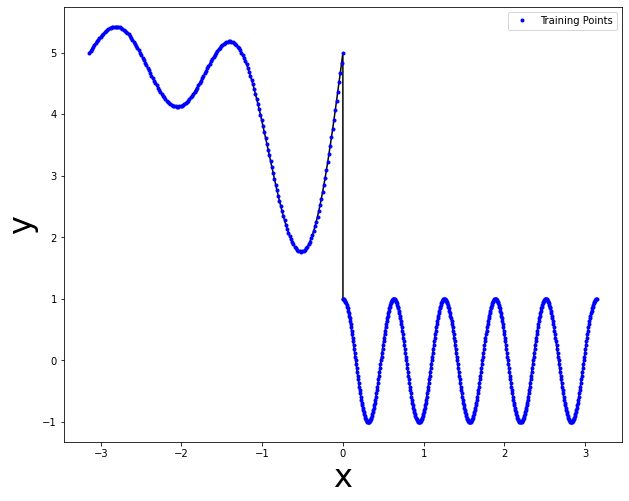

In [34]:
# ============================================
# Constant LR training (Adam) + L1 regularization
# + Plots: (1) Train/Test loss curves, (2) Prediction vs True function
# ============================================

import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline
torch.manual_seed(1234)

# --------------------------------------------
# Target function (piecewise)
#   x < 0  : 5 + sum of sines
#   x >= 0 : cos(10x)
# --------------------------------------------
def fun_x(x):
    if x < 0.0:
        return 5.0 + np.sin(x) + np.sin(2.0 * x) + np.sin(3.0 * x) + np.sin(4.0 * x)
    else:
        return np.cos(10.0 * x)

# --------------------------------------------
# Build training and test datasets (NumPy)
# --------------------------------------------
x_in_l = np.linspace(-np.pi, -1.0e-3, 201)
x_in_r = np.linspace(0.0, np.pi, 501)
x_in = np.concatenate((x_in_l, x_in_r), axis=0)
y_in = np.array([fun_x(i) for i in x_in])

x_test_l = np.linspace(-np.pi, -1.0e-3, 301)
x_test_r = np.linspace(0.0, np.pi, 501)
x_test_np = np.concatenate((x_test_l, x_test_r), axis=0)
y_test_np = np.array([fun_x(i) for i in x_test_np])

# --------------------------------------------
# Visualize training points / true function
# --------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_in, y_in, 'k-', label="True Function")
ax.plot(x_in, y_in, '.b', label="Training Points")
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.legend()
plt.show()

# --------------------------------------------
# Convert to PyTorch tensors (shape [N, 1])
# --------------------------------------------
x = torch.from_numpy(x_in.reshape(-1, 1)).float()
y = torch.from_numpy(y_in.reshape(-1, 1)).float()

x_test = torch.from_numpy(x_test_np.reshape(-1, 1)).float()
y_test = torch.from_numpy(y_test_np.reshape(-1, 1)).float()

# --------------------------------------------
# Model, loss, optimizer
# --------------------------------------------
loss_function = torch.nn.MSELoss()
Niter = 30000

Net = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

# Adam with constant LR + (optional) weight decay (L2)
optimizer = torch.optim.Adam(Net.parameters(), lr=0.01, weight_decay=1e-5)

# --------------------------------------------
# L1 penalty function (adds sparsity pressure)
# L1 penalty = lambda * sum(|weights|)
# --------------------------------------------
def l1_penalty(model, l1_lambda=1e-5):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

l1_lambda = 1e-5  # strength of L1 penalty

# --------------------------------------------
# Logs (store floats, not tensors)
# --------------------------------------------
train_loss_list = []
test_loss_list = []
acc_train = []   # relative error (your "accuracy" proxy)
acc_test = []
print_every = 500

print("Adam Optimization (Constant LR + L1)")

# --------------------------------------------
# Training loop
# --------------------------------------------
for it in range(Niter):
    # Forward pass
    y_pred = Net(x)

    # Total loss = MSE + L1 penalty
    loss = loss_function(y_pred, y) + l1_penalty(Net, l1_lambda=l1_lambda)

    # Backprop + update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate train/test without grad tracking
    with torch.no_grad():
        y_train_pred = Net(x)
        y_test_pred = Net(x_test)

        # NOTE: test_loss here is pure MSE (not including L1 penalty),
        # which is usually what you want to evaluate generalization.
        test_loss = loss_function(y_test_pred, y_test)

        # Relative error metrics (optional)
        train_rel_err = torch.linalg.norm(y - y_train_pred) / torch.linalg.norm(y_train_pred)
        test_rel_err = torch.linalg.norm(y_test - y_test_pred) / torch.linalg.norm(y_test_pred)

        # Store floats
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
        acc_train.append(train_rel_err.item())
        acc_test.append(test_rel_err.item())

    if (it + 1) % print_every == 0 or it == 0:
        print(f"Iter: {it + 1:>6}/{Niter}  TrainLoss: {loss.item():.3e}  TestLoss(MSE): {test_loss.item():.3e}")

# --------------------------------------------
# Final predictions on training inputs for plotting
# --------------------------------------------
with torch.no_grad():
    y_l1_pred = Net(x).detach().numpy()

# ============================================
# Plot 1: Train/Test Loss Curves (log scale)
# ============================================
fig, ax = plt.subplots(figsize=(15, 10))

ep = np.arange(0, len(train_loss_list), 1)
ax.set_xlabel('# Iterations', fontsize=22)
ax.set_ylabel('Loss', fontsize=22)
ax.set_xlim(0, len(ep) + 10)

ax.semilogy(ep, np.array(train_loss_list), 'k--', lw=2, label="Train Loss (MSE + L1)")
ax.semilogy(ep, np.array(test_loss_list),  'r--', lw=2, label="Test Loss (MSE only)")

ax.legend()
plt.show()

# ============================================
# Plot 2: Prediction vs True Function
# ============================================
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(x_in, y_in, 'k-', label="True Function")
ax.plot(x_in, y_in, '.b', label="Training Points")
ax.plot(x_in, y_l1_pred, '-r', label="NN Prediction (Adam + L1)")

ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('y', fontsize=22)
ax.legend()
plt.show()

# DNN training with Ada Hessian


Epoch: 01/30 Loss: 6.23648e+00
Epoch: 02/30 Loss: 6.06708e+00
Epoch: 03/30 Loss: 5.90236e+00
Epoch: 04/30 Loss: 5.74237e+00
Epoch: 05/30 Loss: 5.58713e+00
Epoch: 06/30 Loss: 5.43660e+00
Epoch: 07/30 Loss: 5.29071e+00
Epoch: 08/30 Loss: 5.14929e+00
Epoch: 09/30 Loss: 5.01213e+00
Epoch: 10/30 Loss: 4.87900e+00
Epoch: 11/30 Loss: 4.74966e+00
Epoch: 12/30 Loss: 4.62385e+00
Epoch: 13/30 Loss: 4.50134e+00
Epoch: 14/30 Loss: 4.38191e+00
Epoch: 15/30 Loss: 4.26534e+00
Epoch: 16/30 Loss: 4.15145e+00
Epoch: 17/30 Loss: 4.04007e+00
Epoch: 18/30 Loss: 3.93108e+00
Epoch: 19/30 Loss: 3.82437e+00
Epoch: 20/30 Loss: 3.71989e+00
Epoch: 21/30 Loss: 3.61762e+00
Epoch: 22/30 Loss: 3.51753e+00
Epoch: 23/30 Loss: 3.41965e+00
Epoch: 24/30 Loss: 3.32400e+00
Epoch: 25/30 Loss: 3.23062e+00
Epoch: 26/30 Loss: 3.13954e+00
Epoch: 27/30 Loss: 3.05080e+00
Epoch: 28/30 Loss: 2.96442e+00
Epoch: 29/30 Loss: 2.88041e+00
Epoch: 30/30 Loss: 2.79877e+00
in AdaHessian Loss
Epoch: 01/52 Loss: 2.71949e+00


/Users/raj/opt/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  ../torch/csrc/autograd/engine.cpp:976.)
  Variable._execution_engine.run_backward(


Epoch: 02/52 Loss: 1.19629e+00
Epoch: 03/52 Loss: 8.95687e-01
Epoch: 04/52 Loss: 1.02054e+00
Epoch: 05/52 Loss: 1.13427e+00
Epoch: 06/52 Loss: 1.16512e+00
Epoch: 07/52 Loss: 1.11291e+00
Epoch: 08/52 Loss: 1.02046e+00
Epoch: 09/52 Loss: 9.39480e-01
Epoch: 10/52 Loss: 8.77871e-01
Epoch: 11/52 Loss: 8.42322e-01
Epoch: 12/52 Loss: 8.31098e-01
Epoch: 13/52 Loss: 8.39078e-01
Epoch: 14/52 Loss: 8.55458e-01
Epoch: 15/52 Loss: 8.69826e-01
Epoch: 16/52 Loss: 8.77802e-01
Epoch: 17/52 Loss: 8.76922e-01
Epoch: 18/52 Loss: 8.67657e-01
Epoch: 19/52 Loss: 8.52034e-01
Epoch: 20/52 Loss: 8.33739e-01
Epoch: 21/52 Loss: 8.15753e-01
Epoch: 22/52 Loss: 8.00964e-01
Epoch: 23/52 Loss: 7.91075e-01
Epoch: 24/52 Loss: 7.85938e-01
Epoch: 25/52 Loss: 7.84592e-01
Epoch: 26/52 Loss: 7.85552e-01
Epoch: 27/52 Loss: 7.87264e-01
Epoch: 28/52 Loss: 7.88241e-01
Epoch: 29/52 Loss: 7.87503e-01
Epoch: 30/52 Loss: 7.84836e-01
Epoch: 31/52 Loss: 7.80584e-01
Epoch: 32/52 Loss: 7.75155e-01
Epoch: 33/52 Loss: 7.69290e-01
Epoch: 3

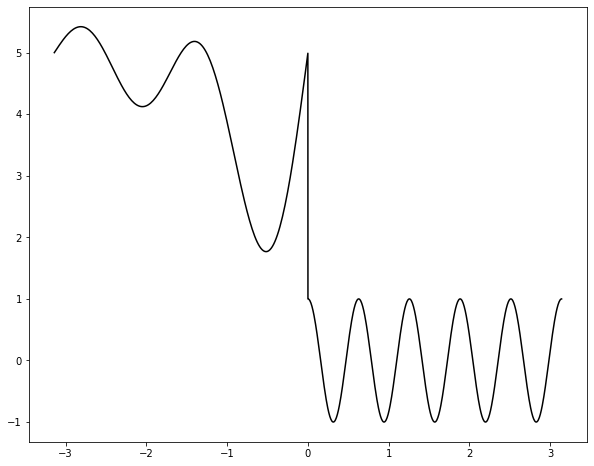

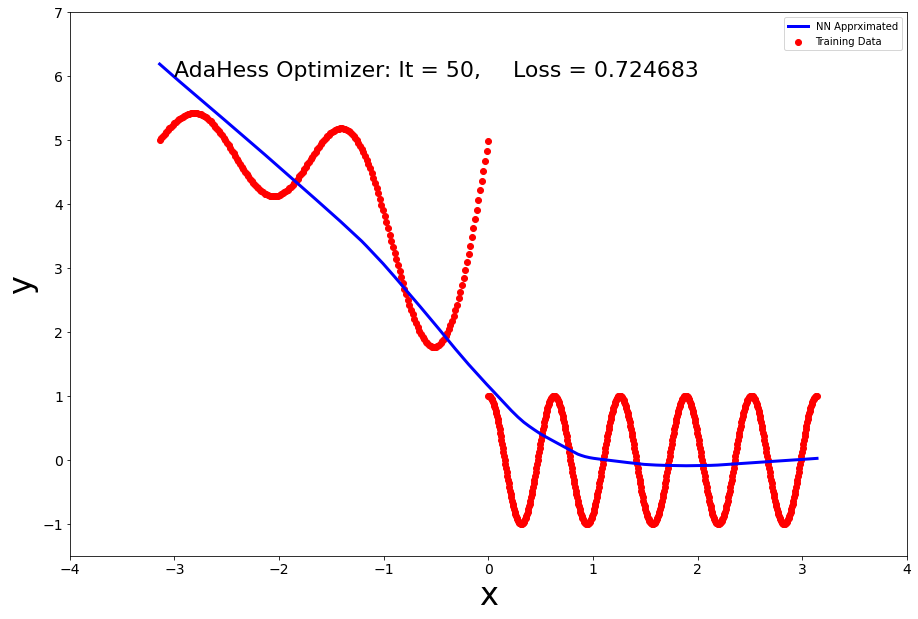

In [2]:
# Combination of Adam + AdaHessian
import numpy as np
import imageio
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import SGD, LBFGS, Adam
from torch.utils.data import Dataset, DataLoader
from AdaHessian import AdaHessian


%matplotlib inline
torch.manual_seed(1234) 


def fun_x(x):
    if x < 0.:
        f = 5.0 + np.sin(x) + np.sin(2.*x) + np.sin(3.*x) + np.sin(4.*x)
    else:
        f = np.cos(10.*x)
    return f

fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
x_in_l = np.linspace(-np.pi, -1.0e-3, 201)
x_in_r = np.linspace(0., np.pi, 501)
y_in_l = np.array([fun_x(i) for i in x_in_l])
y_in_r = np.array([fun_x(i) for i in x_in_r])
x_in = np.concatenate((x_in_l, x_in_r), axis=0)
y_in = np.array([fun_x(i) for i in x_in])
ax1.plot(x_in, y_in, 'k-')


x = torch.from_numpy(x_in.reshape(-1,1)).float()
y = torch.from_numpy(y_in.reshape(-1,1)).float()




loss_function = torch.nn.MSELoss()
Niter_Adam = 30
Niter_LBFGS = 52


Net = torch.nn.Sequential(
      torch.nn.Linear(1, 100),
      torch.nn.ReLU(),
      torch.nn.Linear(100, 1))

optimizer_adam = torch.optim.Adam(Net.parameters(), lr = 0.001)
optimizer_lbfgs = AdaHessian(Net.parameters())

fig, ax = plt.subplots(figsize=(15,10))
image_list = []
adam_loss = []
AdaHess_loss = []

x = Variable(x)
y = Variable(y)



for it in range(Niter_Adam):
    y_pred = Net(x)
    loss = loss_function(y_pred, y)  # Notice the order: NN Pred first and then actual value
    optimizer_adam.zero_grad()    # Zero Out the gradient
    loss.backward()
    optimizer_adam.step()    
    adam_loss.append(loss)
    print(f"Epoch: {it + 1:02}/{Niter_Adam} Loss: {loss:.5e}")
    y_pred = Net(x)
    y_test = y_pred.detach().numpy()
    if it % 4 == 0:
        plt.cla()
        ax.set_xlabel('x', fontsize=32)
        ax.set_ylabel('y Predictied', fontsize=32)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-1.5, 7.0)
        ax.scatter(x_in, y_in, color = "red", label="Noisy Data")
        ax.plot(x_in, y_test, 'k--', lw=2,  label="NN Apprximated")
        ax.text(-3, 6.0, 'Adam Optimizer: It = %d,' %it, fontdict={'size': 22, 'color':  'black'})
        ax.text(0.24, 6.0, 'Loss = %.6f' % loss,
                fontdict={'size': 22, 'color':  'black'})
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend()

        fig.canvas.draw()      
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        image_list.append(image)
    
print("in AdaHessian Loss")

 
for it in range(Niter_LBFGS):
    optimizer_lbfgs.zero_grad()
    y_pred = Net(x)
    loss = loss_function(y_pred, y)
    loss.backward(create_graph=True)
    optimizer_lbfgs.step()
    AdaHess_loss.append(loss.detach().numpy())
    print(f"Epoch: {it + 1:02}/{Niter_LBFGS} Loss: {loss:.5e}")
    y_pred = Net(x)
    y_test = y_pred.detach().numpy()
    if it % 2 == 0:
        plt.cla()
        ax.set_xlabel('x', fontsize=32)
        ax.set_ylabel('y', fontsize=32)
        ax.set_xlim(-4, 4)
        ax.set_ylim(-1.5, 7.0)
        ax.scatter(x_in, y_in, color = "red", label="Training Data")
        ax.plot(x_in, y_test, 'b-', lw=3, label="NN Apprximated")
        ax.text(-3, 6.0, 'AdaHess Optimizer: It = %d,' %it, fontdict={'size': 22, 'color':  'black'})
        ax.text(0.24, 6.0, 'Loss = %.6f' % loss,
                fontdict={'size': 22, 'color':  'black'})
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        ax.legend()

        fig.canvas.draw()      
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        image_list.append(image)
    
   

imageio.mimsave('./Adam_and_AdaHess.gif', image_list, fps=1)

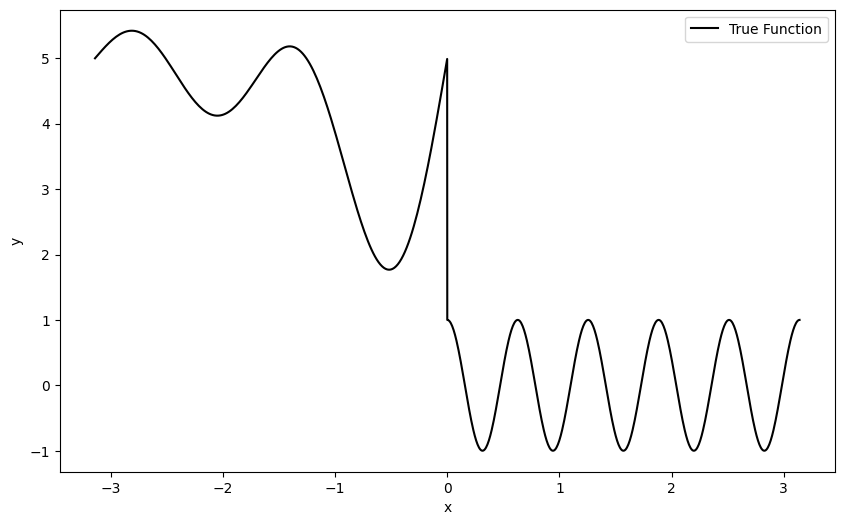

Phase 1: Adam Optimization
Adam Iter: 01/30  Loss: 6.23648e+00
Adam Iter: 05/30  Loss: 5.58713e+00
Adam Iter: 10/30  Loss: 4.87900e+00
Adam Iter: 15/30  Loss: 4.26534e+00
Adam Iter: 20/30  Loss: 3.71989e+00
Adam Iter: 25/30  Loss: 3.23061e+00
Adam Iter: 30/30  Loss: 2.79877e+00

Phase 2: AdaHessian Optimization
AdaHessian Iter: 01/52  Loss: 2.71949e+00


/Users/raj/opt/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1182.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


AdaHessian Iter: 05/52  Loss: 1.13427e+00
AdaHessian Iter: 10/52  Loss: 8.77871e-01
AdaHessian Iter: 15/52  Loss: 8.69826e-01
AdaHessian Iter: 20/52  Loss: 8.33739e-01
AdaHessian Iter: 25/52  Loss: 7.84592e-01
AdaHessian Iter: 30/52  Loss: 7.84836e-01
AdaHessian Iter: 35/52  Loss: 7.58525e-01
AdaHessian Iter: 40/52  Loss: 7.47835e-01
AdaHessian Iter: 45/52  Loss: 7.38850e-01
AdaHessian Iter: 50/52  Loss: 7.26350e-01

Saved GIF to: ./Adam_and_AdaHess.gif


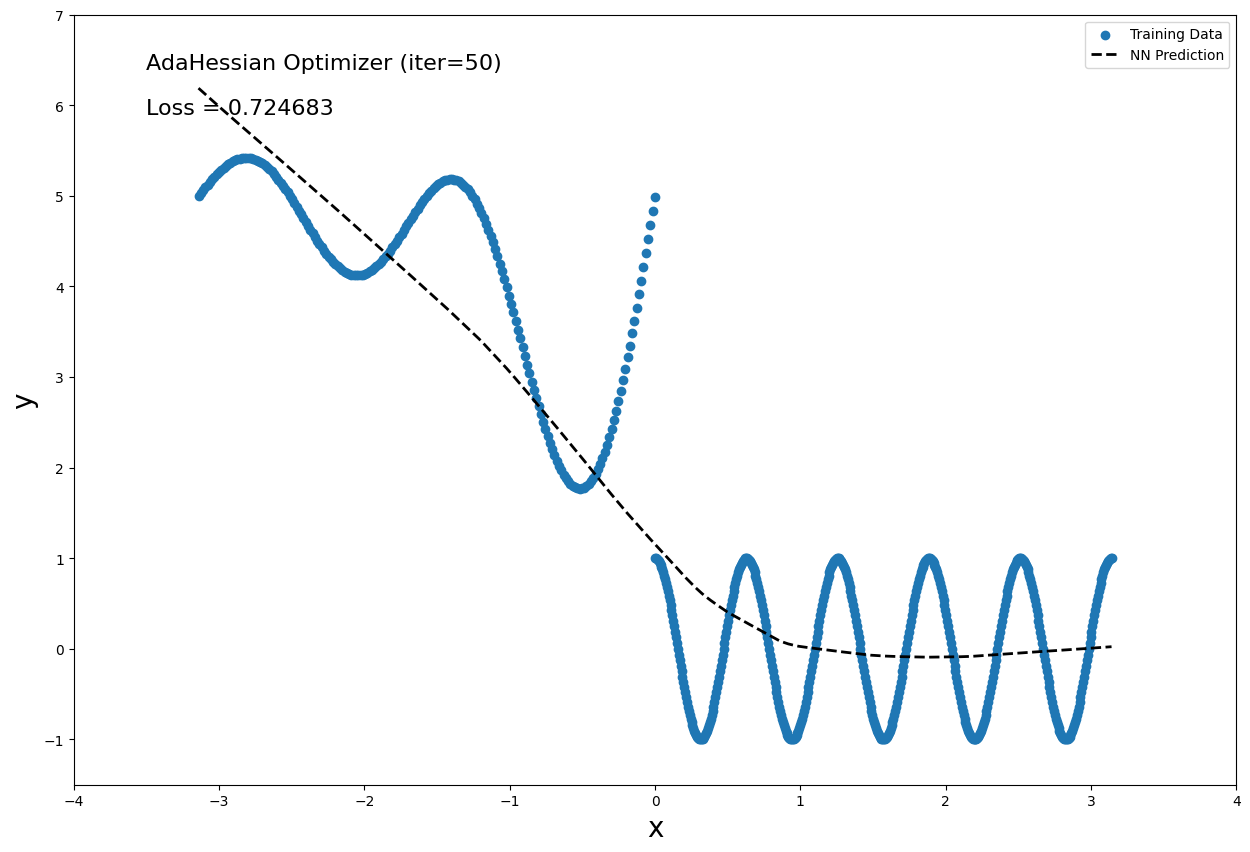

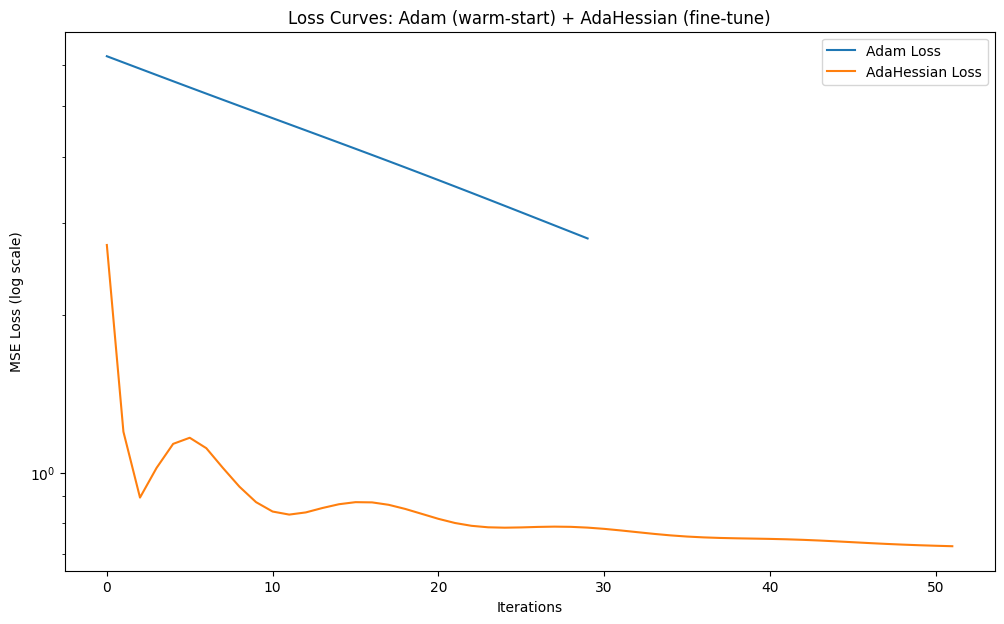

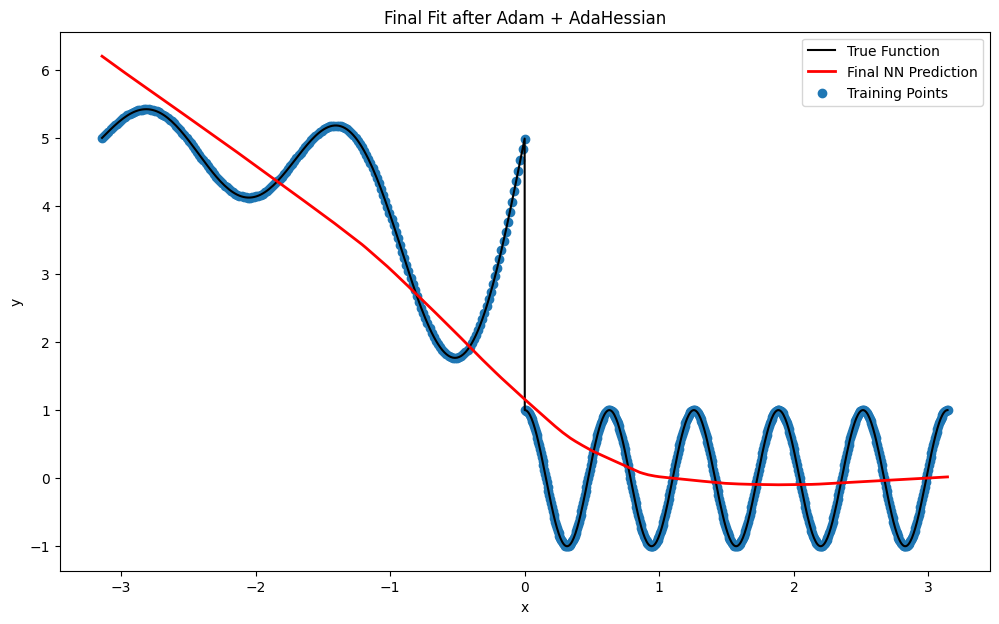

In [35]:
# ============================================
# Combination of Adam + AdaHessian (two-phase training)
# 1) Warm-start with Adam
# 2) Fine-tune with AdaHessian (2nd-order info)
#
# Outputs:
# - A GIF showing prediction improving over time
# - A loss plot (Adam vs AdaHessian)
# - A final prediction plot vs the true function
# ============================================

import numpy as np
import imageio
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable

# IMPORTANT: AdaHessian must be installed / importable in your environment
# e.g. pip install adahessian (or your provided AdaHessian.py file on PYTHONPATH)
from AdaHessian import AdaHessian

%matplotlib inline
torch.manual_seed(1234)

# --------------------------------------------
# Target function (piecewise)
# --------------------------------------------
def fun_x(x):
    if x < 0.0:
        return 5.0 + np.sin(x) + np.sin(2.0 * x) + np.sin(3.0 * x) + np.sin(4.0 * x)
    else:
        return np.cos(10.0 * x)

# --------------------------------------------
# Build training data
# --------------------------------------------
x_in_l = np.linspace(-np.pi, -1.0e-3, 201)
x_in_r = np.linspace(0.0, np.pi, 501)
x_in = np.concatenate((x_in_l, x_in_r), axis=0)
y_in = np.array([fun_x(i) for i in x_in])

# Plot true function once
fig_true, ax_true = plt.subplots(figsize=(10, 6))
ax_true.plot(x_in, y_in, "k-", label="True Function")
ax_true.set_xlabel("x")
ax_true.set_ylabel("y")
ax_true.legend()
plt.show()

# Convert to torch tensors
x = torch.from_numpy(x_in.reshape(-1, 1)).float()
y = torch.from_numpy(y_in.reshape(-1, 1)).float()
x = Variable(x)
y = Variable(y)

# --------------------------------------------
# Model: 1 -> 100 (ReLU) -> 1
# --------------------------------------------
Net = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

loss_fn = torch.nn.MSELoss()

# --------------------------------------------
# Two optimizers
# --------------------------------------------
Niter_adam = 30
Niter_adahess = 52

optimizer_adam = torch.optim.Adam(Net.parameters(), lr=1e-3)

# AdaHessian optimizer (defaults may vary depending on your implementation)
optimizer_adahess = AdaHessian(Net.parameters())

# --------------------------------------------
# Logging + GIF frames
# Store floats for losses to avoid tensor/NumPy headaches later
# --------------------------------------------
adam_loss = []
adahess_loss = []
image_list = []

# We'll draw frames on this figure and capture them to build a GIF
fig_anim, ax_anim = plt.subplots(figsize=(15, 10))

def capture_frame(title_text, loss_value):
    """Render current prediction and capture a frame for the GIF."""
    ax_anim.cla()

    # Current prediction
    with torch.no_grad():
        y_pred_np = Net(x).detach().cpu().numpy()

    ax_anim.set_xlabel("x", fontsize=20)
    ax_anim.set_ylabel("y", fontsize=20)
    ax_anim.set_xlim(-4, 4)
    ax_anim.set_ylim(-1.5, 7.0)

    # Data + prediction
    ax_anim.scatter(x_in, y_in, label="Training Data")
    ax_anim.plot(x_in, y_pred_np, "k--", lw=2, label="NN Prediction")

    # Title / loss
    ax_anim.text(-3.5, 6.4, title_text, fontsize=16)
    ax_anim.text(-3.5, 5.9, f"Loss = {loss_value:.6f}", fontsize=16)

    ax_anim.legend()
    fig_anim.canvas.draw()

    # Capture RGB buffer as an image
    img = np.frombuffer(fig_anim.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig_anim.canvas.get_width_height()[::-1] + (3,))
    image_list.append(img)

# ============================================
# Phase 1: Adam warm-start
# ============================================
print("Phase 1: Adam Optimization")

for it in range(Niter_adam):
    y_pred = Net(x)
    loss = loss_fn(y_pred, y)

    optimizer_adam.zero_grad()
    loss.backward()
    optimizer_adam.step()

    adam_loss.append(loss.item())

    if (it == 0) or ((it + 1) % 5 == 0):
        print(f"Adam Iter: {it + 1:02}/{Niter_adam}  Loss: {loss.item():.5e}")

    # Capture a frame occasionally
    if it % 4 == 0:
        capture_frame(title_text=f"Adam Optimizer (iter={it})", loss_value=loss.item())

# ============================================
# Phase 2: AdaHessian fine-tune
# AdaHessian typically needs create_graph=True to compute Hessian-vector products
# ============================================
print("\nPhase 2: AdaHessian Optimization")

for it in range(Niter_adahess):
    optimizer_adahess.zero_grad()
    y_pred = Net(x)
    loss = loss_fn(y_pred, y)

    # create_graph=True is required for second-order methods like AdaHessian
    loss.backward(create_graph=True)
    optimizer_adahess.step()

    adahess_loss.append(loss.item())

    if (it == 0) or ((it + 1) % 5 == 0):
        print(f"AdaHessian Iter: {it + 1:02}/{Niter_adahess}  Loss: {loss.item():.5e}")

    # Capture a frame occasionally
    if it % 2 == 0:
        capture_frame(title_text=f"AdaHessian Optimizer (iter={it})", loss_value=loss.item())

# --------------------------------------------
# Save GIF
# --------------------------------------------
gif_path = "./Adam_and_AdaHess.gif"
imageio.mimsave(gif_path, image_list, fps=1)
print(f"\nSaved GIF to: {gif_path}")

# ============================================
# Plot 1: Loss curves (Adam vs AdaHessian)
# ============================================
fig_loss, ax_loss = plt.subplots(figsize=(12, 7))

ax_loss.semilogy(np.arange(len(adam_loss)), adam_loss, label="Adam Loss")
ax_loss.semilogy(np.arange(len(adahess_loss)), adahess_loss, label="AdaHessian Loss")

ax_loss.set_xlabel("Iterations")
ax_loss.set_ylabel("MSE Loss (log scale)")
ax_loss.set_title("Loss Curves: Adam (warm-start) + AdaHessian (fine-tune)")
ax_loss.legend()
plt.show()

# ============================================
# Plot 2: Final prediction vs true function
# ============================================
with torch.no_grad():
    y_final = Net(x).detach().cpu().numpy()

fig_pred, ax_pred = plt.subplots(figsize=(12, 7))
ax_pred.plot(x_in, y_in, "k-", label="True Function")
ax_pred.plot(x_in, y_final, "r-", lw=2, label="Final NN Prediction")
ax_pred.scatter(x_in, y_in, label="Training Points")
ax_pred.set_xlabel("x")
ax_pred.set_ylabel("y")
ax_pred.set_title("Final Fit after Adam + AdaHessian")
ax_pred.legend()
plt.show()